In [66]:
import pandas as pd
import re
from NewWordDetect import SegDocument
import jieba
import jieba.analyse
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from pymongo import MongoClient
import pyLDAvis
import pyLDAvis.gensim


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_colwidth", -1)

### 從mongodb讀取資料

In [2]:
client = MongoClient()
client = MongoClient(host='13.114.0.xx',
                     port=27000, 
                     username='xxxxxxx', 
                     password='xxxxxxxxxx',
                     authSource='digital',
                     authMechanism='SCRAM-SHA-1')
db = client.digital

In [5]:
news = pd.DataFrame(list(db.news.find({})))

### 資料探索

In [6]:
news.head(10)

,_id,article,author,ckip_keywords,crawled_time,cust_keywords,flag_article,flag_ckip_keywords,keywords,mining_keywords,published_time,source,summary,title,url,utc_published_time
0,5ccd358cb65561e3fbf0478c,2013年，商周第一次，也是至今唯一一次，把紀錄片推上戲院。因為一些約定，這紀錄片完整版鎖了...,劉佩修,"[台灣, 寧寧, 社頭襪鄉, 林強, 彰化, 李東林, 琬凌, 郭涵羚, 美, 韓, 社頭鄉...",2019-05-03 17:22:05,[],True,True,[商周茶館],NaN,2019-05-03 16:51:57,商周.Com 最新綜合文章,2013年，商周第一次，也是至今唯一一次，把紀錄片推上戲院。因為一些約定，這紀錄片完整版鎖了...,上次採訪還身陷生存危機，現已拚出千萬營收...6年社頭襪廠追蹤，看台灣頭家的突圍生存力,http://www.businessweekly.com.tw/article.aspx?...,2019-05-03 08:51:57
1,5ccd358cb65561e3fbf04796,一如我原先預料，美國各項良好的經濟數據，加上先前熱絡的股市表現，促使美國FED的說法由極鴿轉...,老馬,"[美國, 台灣, 聯發科, 中, 中國, 美, 英國, 川普, 台積]",2019-05-03 16:51:33,"[Artificial Intelligence, Economic 經濟]",True,True,[大咖投資日記],NaN,2019-05-03 16:40:46,商周.Com 最新綜合文章,一如我原先預料，美國各項良好的經濟數據，加上先前熱絡的股市表現，促使美國FED的說法由極鴿轉...,美企表現樂觀，中美貿易談判露曙光...台股下步投資佈局，股市大咖點名3大產業商機,http://www.businessweekly.com.tw/article.aspx?...,2019-05-03 08:40:46
2,5ccd358cb65561e3fbf04782,川普打破傳統第3次缺席白宮記者晚宴，不只如此，這一回白宮記者晚宴也自我打破傳統，取消諧星說笑...,張經義,"[美國, 川普, 白宮, 桑德斯]",2019-05-03 18:53:25,[領導],True,True,[張經義的白宮義見],NaN,2019-05-03 18:33:36,商周.Com 最新綜合文章,川普打破傳統第3次缺席白宮記者晚宴，不只如此，這一回白宮記者晚宴也自我打破傳統，取消諧星說笑...,川普缺席晚宴，只剩媒體同溫層取暖...一個白宮記者：第8年出席，這回有點笑不出來,http://www.businessweekly.com.tw/article.aspx?...,2019-05-03 10:33:36
3,5ccd358cb65561e3fbf0479b,產品是必要的，營銷是重要的我是一個惜時如金的人，我最貴的資源，就是時間。我要求自己，必須活成...,劉潤,"[瑞士, 劉潤, 段永平]",2019-05-03 16:51:33,[],True,True,[劉潤專欄],NaN,2019-05-03 16:29:10,商周.Com 最新綜合文章,產品是必要的，營銷是重要的\n我是一個惜時如金的人，我最貴的資源，就是時間。\n我要求自己，...,惜時如金，我卻耐心讀完這封行銷郵件！健身教練教我的一堂商業案例課,http://www.businessweekly.com.tw/article.aspx?...,2019-05-03 08:29:10
4,5ccd358cb65561e3fbf04791,臉書是大部分人每天都會頻繁使用的社群平台，上面充斥著資訊、圖片以及我們與好友間的互動，我們也...,寫點科普Lynn,"[美國, 台灣, 巴西, Mark Kelley, 秘魯, 馬來西亞, 中國, 新加坡, 墨...",2019-05-03 16:51:33,"[商業模式, 溝通, 領導, Economic 經濟]",True,True,[Lynn寫點科普，觀點筆記],NaN,2019-05-03 16:49:38,商周.Com 最新綜合文章,臉書是大部分人每天都會頻繁使用的社群平台，上面充斥著資訊、圖片以及我們與好友間的互動，我們也...,臉書「暗戀」功能來了！一宣布Tinder股價就跌4.5%，看社群龍頭背後轉型盤算,http://www.businessweekly.com.tw/article.aspx?...,2019-05-03 08:49:38
5,5ccd358cb65561e3fbf047aa,先前在美國輿論界引發風波的美國互聯網巨頭谷歌（Google）的大陸版搜尋引擎「蜻蜓計劃」，證...,工商時報 譚有勝,"[谷歌, 大陸, 美國, Alphabet, 中國, 谷歌母公司]",2019-05-03 10:16:30,[Economic 經濟],True,True,[中時電子報],NaN,2019-05-03 09:48:24,商周.Com 最新綜合文章,先前在美國輿論界引發風波的美國互聯網巨頭谷歌（Google）的大陸版搜尋引擎「蜻蜓計劃」，證...,谷歌重返中國 已胎死腹中,http://www.businessweekly.com.tw/article.aspx?...,2019-05-03 01:48:24
6,5ccd358cb65561e3fbf0477d,由下而上傳遞能量正因為OKR是公開透明的，不必依樣畫葫蘆層層下達。如果有利於公司的大目標，也...,約翰‧杜爾,"[Google, Chrome, 賴瑞, 葛洛夫, 美國, 拉茲洛, 布達, Gmail, ...",2019-05-03 19:23:56,[領導],True,True,[非讀BOOK],NaN,2019-05-03 18:47:28,商周.Com 最新綜合文章,由下而上傳遞能量\n正因為OKR是公開透明的，不必依樣畫葫蘆層層下達。如果有利於公司的大目標...,若Google沒讓員工多放假，我們就沒有Gmail！每間公司都在做的「這件事」，是扼殺企業的凶手,http://www.businessweekly.com.tw/article.aspx?...,2019-05-03 10:47:28
7,5ccd358cb65561e3fbf047a5,一般業務員與超級業務員的差別是什麼？重點就在懂不懂得「人性的需求」。據美國知名廣告人德魯．艾...,,"[吉姆, 德魯, 美國, 德魯．艾瑞克．惠特曼, 廣告部, 奧迪R8 Coupe, Drew...",2019-05-03 11:17:28,[領導],True,True,[特別企劃],NaN,2019-05-03 11:07:38,商周.Com 最新綜合文章,一般業務員與超級業務員的差別是什麼？重點就在懂不懂得「人性的需求」。據美國知名廣告人德魯．艾...,美國廣告大師教你 擊中人性8大欲望問話術,http://magazine.businessweekly.com.tw/Article_...,2019-05-03 03:07:38
8,5ccd358cb65561e3fbf047af,今年年初，我向日本公司多請了幾天假返鄉度假，回日本前，我一反常態決定為日本同事準備一些來自「...,瓶顆,[日本],2019-05-02 21:05:37,[],True,True,[辦公室不在台灣],NaN,2019-05-02 20:26:32,商周.Com 最新綜合文章,今年年初，我向日本公司多請了幾天假返鄉度假，回日本前，我一反常態決定為日本同事準備一些來自「...,日本便利商店冷熱食竟分裝2袋！那些台灣人好奇的事，是日本人展現的「愛國文化」,http://www.businessweekly.com.tw/article.aspx?...,2019-05-02 12:26:32
9,5ccd358cb65561e3fbf047a0,"根據人權觀察組織（Human Rights Watch, HRW）最新調查報告，中國公安部門...",金融時報,"[新疆, 中國, Inzhu, App, 上海, 矽谷, 美國, 英國, 格雷格沃爾頓, 維...",2019-05-03 16:21:12,"[Artificial Intelligence, Big Data]",True,True,[金融時報精選],NaN,2019-05-03 15:47:54,商周.Com 最新綜合文章,"根據人權觀察組織（Human Rights Watch, HRW）最新調查報告，中國公安部門...",不跟鄰居來往、用電量變多...都很可疑！中國警民科技戰再升級，揭秘最新「作戰App」,http://www.businessweekly.com.tw/article.aspx?...,2019-05-03 07:47:54


In [7]:
news.shape

(14752, 16)

In [8]:
news.fillna('', inplace=True)

In [57]:
news.source.unique()

array(['商周.Com  最新綜合文章', 'iThome 新聞', 'TechNews 科技新報', 'Cheers雜誌精選文章',
       '經理人 Managertoday', 'INSIDE', 'TechOrange', '天下雜誌精選文章',
       '數位時代 BusinessNext', '遠見雜誌 - 前進的動力',
       'Engadget 中文版 RSS Feed [expanded by feedex.net]', 'PanX 泛科技',
       'dcplus 數位行銷實戰家', '資安趨勢部落格', '傳說中的挨踢部門', '創新拿鐵', '康健雜誌精選文章',
       'News100 | SmartM 人才培訓網', 'News100 | SmartM 電子商務X網路行銷學校',
       '鉅亨網 - 頭條新聞', 'Yahoo看見數位行銷力'], dtype=object)

### 斷詞

In [13]:
def my_cut(inTxt):
    """
    斷詞方法：
    text tank 取前20重要的字
    使用information entropy & mutual information filtering取前90%的字
    """
    regex = r"([0-9]*[%$]*[\u4e00-\u9fff\w+]+[0-9]*[%$]*[\u4e00-\u9fff\w+]*)"
    match = re.findall(regex, inTxt)
    txt = ''
    for i in match:
        txt = txt + i
    txt = re.sub('[a-zA-Z0-9]','',txt)
    words_list = jieba.analyse.extract_tags(txt, topK=20)
    try:  
        res=SegDocument(txt,max_word_len=5, min_tf=0, min_infor_ent=0,min_pmi=0)
        word=[]
        for item in res.word_tf_pmi_ent:
            word.append([item[0], item[1], item[2], item[3]])
        KeyWord = pd.DataFrame(word, columns=['word', 'tf', 'pmi', 'info_ent'])
        thres_up_20 =KeyWord.iloc[:,1:].gt(KeyWord.quantile(0.9),axis=1)
        filter_ky_up_20_wordSeg = KeyWord[thres_up_20.apply(lambda x:x[0]*((x[1]+x[2])>0),axis=1)]
        allwords = list(filter_ky_up_20_wordSeg['word'].unique())
        for n in allwords:
            if n not in words_list:
                words_list.append(n)
    except:
        pass
    print(words_list)
    
    return words_list

In [14]:
jieba.analyse.set_stop_words('stopwords-all.txt')

In [15]:
news['article_kw'] = news['article'].apply(my_cut)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.566 seconds.
Prefix dict has been built succesfully.


['黑狗', '襪子', '商周', '廁所', '採訪', '轉型', '有人', '錄片', '戲院', '特攻', '突圍記', '寧寧', '產業', '兄是', '聊著', '社頭', '營收', '萬元', '機器', '閱讀', '黑狗兄', '一個', '我們', '黑狗兄的']
['美國', '市場', '經濟', '表現', '談判', '情況', '投資', '整體', '資金', '國家', '散戶', '美股', '總統', '企業', '狀況', '台股', '產業', '相關', '原先', '先前', '政策']
['媒體', '晚宴', '美國', '白宮', '記者', '總統', '川普', '桑德斯', '假新聞', '諧星', '報導', '台柱', '信任', '傳統', '晚會', '新聞', '去年', '台下', '呆子', '切爾諾', '美國媒體', '因為']
['營銷', '產品', '時間', '郵件', '同理', '不願', '浪費', '教練', '地讀', '學習', '這位', '這封', '好產品', '耐心', '健身', '能力', '答案', '角度', '巷子深', '封主', '的營銷']
['臉書', '好友', '交友', '名單', '使用者', '對象', '交友平台', '功能', '社群', '透過', '好感', '互動', '訊息', '陌生', '程式', '平台', '這項', '發展', '改變', '秘密', '問題', '對方', '以及', '可能', '我們', '推出', '已經', '的好友', '不會', '他們', '如果']
['谷歌', '大陸', '計劃', '搜尋', '中國', '大陸版', '證實', '引擎', '蜻蜓', '外界', '美國', '輿論界', '引發', '員工', '審查', '內部', '批評', '市場', '時報', '胎死腹中']
['目標', '用戶', '解決', '設定', '億名', '團隊', '組織', '產品', '活躍用', '公開', '層層', '多個', '傳給', '計畫', '改變', '一項', '網路', '瀏覽', '艱難', '戶數', '我們', '公司', '的目標']

['對象', '運勢', '戀愛運', '未有', '工作', '財運', '溝通', '同儕', '已有', '專業', '投資', '相處', '進度', '帶來', '狀況', '計劃', '相關', '時間', '負責', '面對', '注意', '未有對象', '座工作運勢', '避免', '或是', '新的']
['核災', '福島', '返鄉', '之友', '滿田夏花', '避難者', '責任', '輻射', '避難', '地球', '日本', '調查', '環境', '電力', '核電', '居民', '政府', '核能', '圖為', '資訊', '生活', '福島縣', '災民']
['美國', '槍擊', '國會', '槍枝', '大規模', '記者', '新聞', '卡利斯', '槍擊案', '擁槍', '事件', '警察', '超過', '禁槍', '協會', '聲響', '管控', '這還', '歐巴馬', '憲法', '議員', '在美國', '人民', '一個', '因此', '就是', '自己', '史卡利斯']
['口罩', '中衛', '行銷', '彩色', '張德成', '部門', '接班', '轉型', '市場', '時間', '醫材廠', '醫療', '傳統', '生產', '調整', '空降', '流行', '第代', '開發', '面臨', '員工', '彩色口罩']
['持續', '市場', '台股', '反轉', '情緒', '過度', '引來', '之際', '股價', '樂觀', '拉回', '留意', '利空', '修正', '假如能', '持股', '戒慎', '幅度', '良莠', '投資人', '或是']
['階段', '獨才', '組織', '學習', '中年人', '專才', '創業', '中年', '通才', '性正確', '幾歲', '小米', '跨出去', '輕人', '同學', '變得', '性正', '改變', '職場', '經驗', '一個', '這個', '可能', '階段性正確', '之後', '的是']
['南山', '系統', '人壽', '資訊系統', '新系統', '境界', '更換', '並行', '保險局', '投資型', '保單', '未來', '壽險', '保險',

['超市', '連鎖', '提案', '經濟', '經營', '顧客', '企業', '消費者', '準化', '連鎖店', '日本', '流通', '唐吉軻德', '連續', '營收', '成長', '萎縮', '媽媽', '賣場', '社區']
['郭董', '台灣', '經濟', '郭台銘', '未來', '做事', '聖母院', '影響', '選總統', '價值', '這是', '國際', '距離', '和平', '時間', '川普', '習近', '新聞', '總統', '韓國瑜', '一個', '什麼', '可能', '就是', '美國']
['千禧', '輕人', '世代', '台灣', '積極型', '萬日圓', '存款', '日本', '儲蓄', '調查', '萬台幣', '消極型', '銀行', '喜歡', '四處', '租屋', '報告', '發現', '哪裡', '保證', '他們', '但是']
['企業', '銷售', '店面', '網路', '生產', '服裝', '市場', '應鏈', '會計', '消費者', '時尚', '改變', '計劃', '減少', '關店', '傳統', '英國', '回應', '採取', '結構', '成本']
['工作', '就業', '企業', '零工', '失業', '經濟', '改變', '正職', '價值', '中年人', '薪水', '一份', '資遣', '發明', '中年', '收入', '核心', '思考', '機會', '思維', '可以', '自己', '也不', '不是', '找工作']
['台灣', '經濟', '郭董', '媽祖', '新加坡', '總統', '未來', '當選', '選總統', '國家', '人民', '這幾', '表態', '資金', '主牌', '國際', '競爭力', '股價', '貿易', '十年', '如果', '他的', '台灣的', '沒有', '這個', '台灣人民', '不要', '可以', '因為']
['小安', '餐廳', '本事', '美式', '創業', '當老', '吃苦', '運作', '父母', '工作', '碩士', '幾次', '公關', '爸媽', '磚塊', '脾氣', '發脾氣', '耐勞才', '享樂', '好員工

['咖啡', '研磨', '時間', '萃取', '乾香', '相處', '咖啡豆', '過程', '顆粒', '過度', '一種', '機會', '烘焙', '一杯', '經歷', '一點', '風味', '手動', '適合', '發現', '第一', '自己', '決定', '方式', '比較', '研磨的', '自己的']
['思考', '批判', '溝通', '語言', '討論', '能力', '理解', '動物', '價值', '意見', '成共識', '別人', '歧見', '推論', '機會', '國家', '大考', '理想', '路上', '化解', '批判思考']
['咖啡', '死亡率', '發現', '致癌物', '喝杯', '風險', '降低', '喝咖啡', '女性', '族群', '男性', '胰島素', '%%', '劑量', '研究', '心血管', '疾病', '癌症', '抗癌', '腫瘤', '咖啡的']
['總統', '公職', '申報', '人員', '察院', '美延', '參選人', '郭台銘', '不動產', '參選', '財產申', '獻金', '名下', '國民黨', '選舉', '選委會', '國內', '上櫃', '財產', '報法']
['野心', '父親', '努力', '年紀', '攝影', '紅燒', '喜歡', '孩子', '考試', '單字', '浪跡', '決心', '兒子', '過得', '簡單', '味道', '天涯', '改變', '一塌糊塗', '修邊', '自己', '什麼', '你想', '有野心', '沒有', '他們']
['張愛晶', '新聞', '社會', '圖片', '孩子', '工作', '媒體', '記者', '母親', '事新聞', '資訊', '時間', '影響力', '狀況', '問心', '無愧', '暫時', '離開', '貢獻', '特質', '我們', '一個', '她們']
['肺癌', '檢查', '發現', '結節', '胸部', '治療', '公分', '早期', '腫瘤', '第期', '醫院', '台灣', '手術', '篩檢', '指數', '正確', '診斷', '癌症', '癌胚抗原', '幸運']
['台灣', '資料', '餐點', 

['遠鏡', '黑洞', '觀測', '格陵蘭', '格陵蘭望', '望遠鏡', '明堂', '中研院', '陰影', '特長', '基線', '毫米波', '大氣', '地點', '團隊', '河系', '解析度', '科學家', '人類', '頻率', '天文', '我們', '科學', '陳明堂說', '但是', '地球', '必須', '不會', '格陵蘭的']
['餐廳', '米其林', '聲量', '山海', '擔仔', '年月日', '摘星', '天本', '台南', '趨勢', '台菜', '來源', '去年', '奪星', '這家', '大數據', '關鍵', '榜單', '預測', '主廚', '山海樓', '不少', '鮨天本', '台南擔仔麵']
['平成', '愛範兒', '日本', '來源', '昭和', '年號', '廢物', '任天堂', '最後的', '經濟', '動畫', '遊戲', '輕人', '仁天皇', '推出', '新年', '天皇', '流行', '懷念', '時間', '平成最後的', '令和', '來源愛範兒', '動漫', '的年', '年的', '成為']
['布袋', '台灣', '師父', '法國', '偶戲', '喜歡', '劇場', '戲偶', '藝術', '演出', '劇團', '傳統', '李天祿', '觀眾', '美麗', '女孩', '語言', '偶師', '想學', '三芝', '布袋戲', '一個', '操偶', '什麼', '必須', '有一', '沒有', '西方', '在台灣', '非常', '學布袋戲']
['契約', '試用', '勞動', '終止', '勞工', '公司', '試用期', '期間', '勞基法', '雇主', '事務', '預告', '爸爸', '工作', '解雇', '加班', '有次', '我覺', '職業', '當飯', '員工', '覺得', '可以', '沒有', '規定']
['網紅', '如涵', '張大奕', '銷售額', '中國', '成長', '超過', '營銷', '億元', '美元', '流量', '成本', '直播', '收盤', '發行', '網紅股', '競爭', '馮敏', '女裝', '電商', '的網紅']
['屋主', '小米'

['成果', '工作', '重視', '過程', '重現', '年收入', '薪資', '破千萬', '重點', '產出', '順利', '方式', '努力', '時薪', '計算', '相較', '影響', '開心', '職涯', '專注', '工作成果', '獲得', '的工作']
['美國', '邊境', '關閉', '墨西哥', '美墨', '國家', '危機', '進口', '中美洲', '毒品', '汽車', '移民', '超過', '閉邊境', '川普', '湧入', '這波', '好事', '千公里', '密西根', '關閉邊境', '美國的', '美墨邊境', '他們', '可是', '的話', '這些']
['臉書', '媒體', '還早', '擁有', '萬訂', '閱數', '親子', '頻道', '寄賣店', '這裡', '賣家', '紀下', '國中生', '萬元', '這群', '你還', '妞妞', '全台', '社群', '修到']
['愚人', '創意', '品牌', '玩笑', '節創意', '企業', '地雷', '推出', '煞有其事', '出發', '消費者', '顧客', '記者', '成功', '三大', '微軟', '節的', '耳機', '產品', '台灣', '愚人節', '一個', '公司', '今年', '愚人節創意', '的創意']
['廣告', '網站', '資源', '手機', '努力', '購物', '選擇', '銷售', '安雅', '預算', '趨勢', '浪頭', '行銷', '優化', '帶來', '業績', '遠遠', '使力', '數字', '方向', '可以']
['顧問', '公司', '趨勢', '解決', '客戶', '職業', '履歷', '內容', '轉型', '告訴', '企業', '問費用', '內部', '面臨', '聰明', '報告', '未來', '管理', '真的', '外行人', '問題']
['職場', '中國', '畢業', '機會', '蘇州', '薪水', '發現', '學習', '心態', '上司', '公司', '特助', '這項', '職涯', '成長', '決策', '時間', '解決', '遷廠', '學會', '文倢', '自己', '成為',

['駭客', '用戶', '攻擊', '惡意', '節點', '網路', '程式', '比特', '發動', '阻斷', '服務', '伺服器', '目標', '偽造', '連結', '超過', '公開', '更新', '漏洞', '分散式']
['網路', '使用者', '互動', '社交', '提醒', '暫離', '機制', '臉書', '內容', '程式', '漏洞', '扮演', '角色', '含有', '安全部', '工具', '模式', '執行長', '發者', '會議']
['董事', '執行長', '擔任', '企業', '網路', '程式', '漏洞', '含有', '安全部', '成員', '這屆', '之後將', '一職', '離開', '經參', '兩名', '創辦', '延攬', '示範', '龐大']
['服務', '儲存', '資料', '雲端', '備份', '用戶', '保護', '企業', '設備', '環境', '微軟', '提供', '物件', '存放', '公有', '軟體', '解決', '可選擇', '畫面', '網站', '雲端服務']
['蘋果', '成長', '美元', '銷售', '股價', '庫克', '數量', '產品', '類別', '預期', '網路', '程式', '漏洞', '去年', '日公', '含有', '安全部', '下滑', '加持', '下季']
['用戶', '臉書', '社團', '感興趣', '功能', '主題', '設計', '社團則', '朋友', '程式', '漏洞', '演講', '持續', '臉書正', '臉書進', '專注', '活動', '空間', '臉書上', '尋找']
['臉書', '桌機', '用戶', '影片', '企業', '空間', '桌機版', '功能', '時間', '電腦', '啟動', '傳訊', '聯絡', '專案', '檔案', '專屬', '網路', '相片', '瘦身', '程式', '手機']
['網路', '通訊', '執行', '支援', '程式', '作業', '系統', '個體', '負載', '電腦', '群組', '流量', '高效能', '漏洞', '附加', '接器', '模型', '修改', '介面', '工作', '

['駭客', '網頁', '使用者', '攻擊', '網釣頁', '資安業者', '濫用', '專案', '內容', '網釣', '銀行', '輸入', '透過', '網路', '代管', '程式', '漏洞', '含有', '藉由', '安全部']
['網路', '使用者', '網際', '數位', '社群', '素養', '報告', '隱私', '資料', '開放', '社交', '開放性', '議題', '採取', '系統', '臉書', '用戶', '商業', '參與', '創新', '以及', '公司']
['螢幕', '三星', '手機', '異物', '媒體', '網站', '兩個', '轉軸', '展開', '縫隙', '防護', '機率', '實驗室', '測試', '網路', '缺口', '拆解', '程式', '脊柱', '漏洞', '摺疊', '的螢幕']
['叢集', '修補', '版本', '漏洞', '系統', '執行', '邊緣', '程式', '管理系', '安全性', '專案', '設計', '企業', '底層', '帶來', '節點', '發行', '內建', '輕量', '資源']
['資料', '程式', '開發', '發人員', '伺服器', '跨平台', '人員', '計畫', '超過', '網路', '平台', '漏洞', '同步', '打造', '支援', '含有', '藉由', '安全部', '管理系', '導向']
['活動', '用戶', '程式', '目標', '數據', '系統', '移動分', '鐘數', '網路', '健康', '漏洞', '含有', '安全部', '資訊', '將身體', '科學', '轉為', '簡單', '心臟點', '數移動']
['用戶', '頻道', '建置', '工作', '流程', '企業', '程式', '工具', '搜尋', '整合', '功能', '工作站', '電子', '郵件', '自動化', '溝通', '計畫', '檔案', '透過', '還會']
['惡意', '軟體', '執行', '蘋果', '程式', '平台', '偵測', '電腦', '內建', '發現', '防護', '網路', '防毒', '漏洞', '悄悄', '支援', '含有', '安全

['醫療', '醫院', '資安', '網路', '設備', '資通', '系統', '單位', '北市', '執行', '儀器', '聯醫', '管理', '監控', '電腦', '訓練', '資訊', '楊榮林', '許世欣', '事件', '北市聯醫', '問題']
['開發', '程式', '軟體', '結構化', '語言', '規範化', '雜度', '錯誤', '模型', '微軟', '人員生', '產力', '品質', '發表', '結構', '人員', '開發者', '專案', '網路', '提到', '迴圈']
['新漢', '產線', '工廠', '工業', '生產', '設備', '智慧', '戰情', '資訊', '自動', '決策', '即時', '工業物', '聯網', '雲端', '螢幕', '硬體', '技術', '運作', '開發', '可以', '機臺', '戰情中心', '製程', '作業', '檢測']
['企業', '系統', '技術', '程式', '持續', '廠商', '開發', '雲端', '發展', '現代化', '軟體', '創新', '既有', '伺服器', '現況', '態勢', '虛擬化', '服務業者', '採取', '企業級', '公司']
['漏洞', '攻擊', '使用者', '腳本', '輸入', '程式', '版本', '跨站', '服務', '引擎', '網站', '發者', '未過', '危險', '驗證', '執行', '遠端', '用戶', '網路', '框架', '使用', '可能']
['產品', '機關', '原則', '網路', '採購', '國家', '資安法', '資通', '危害', '這項', '關鍵', '基礎', '設施', '單位', '提供者', '各機關', '未來', '規範', '相關', '行政院', '政府', '資安', '使用原則']
['軟體', '電視台', '氣象', '開播', '網路', '惡意', '攻擊', '勒索', '藉由', '美國', '新聞', '節目', '調查', '聯邦', '資產', '程式', '漏洞', '含有', '重播', '安全部']
['斯里蘭卡', '攻擊', '封鎖', '調查', '活節', '緊急'

['網路', '神經', '神經元', '資源', '技術', '擴增', '優化', '現有', '架構', '階段', '計算', '模型', '一項', '並將', '分類', '過程', '代價', '目標', '低效率', '深度', '神經網路', '個神經元']
['中國', '美國', '申請', '網路', '否決', '申請案', '聯邦', '發出', '公開', '市場', '外國', '設備', '單位', '以國家', '建議', '證據', '機率', '企業', '信服', '程式', '中國移動', '電信']
['雲端', '微軟', '資料', '用戶', '當機', '開源', '程式', '基礎', '設施', '企業', '合約', '防部', '營運', '美國國', '市場', '中國', '服務', '臉書', '授權', '全文', '美國', '應用', '使用', '基礎設施', '管理', '詳全文']
['臉書', '助理', '報導', '裝置', '蘋果', '團隊', '部門', '機器', '測試', '網路', '智慧', '打造', '程式', '使用者', '消息人士', '漏洞', '喇叭', '指令', '指出', '自有']
['技術', '微軟', '辨識', '拒絕', '將臉', '部辨識', '賣給', '臉部', '這項', '人工智慧', '單位', '攝影', '臉辨識', '誤判', '資料', '美國', '股東', '網路', '警方', '整合']
['網址', '網站', '網頁', '來源', '顯示', '技術', '內容', '瀏覽器', '快取', '加密', '用戶', '當用戶', '出現', '證明', '頁面', '網路', '存取', '程式', '使用者', '品牌', '使用']
['叢集', '執行', '服務', '資源', '程式', '容器', '伺服器', '負載', '用戶', '軟體', '企業', '網路', '映像', '支援', '安全性', '強化', '自動化', '基礎', '設施', '擴展', '使用']
['無痕', '網站', '使用者', '模式', '隱私', '造訪', '新聞', '藉由', '視窗'

['預測', '亞馬遜', '按鍵', '企業', '改變', '機器', '購物', '商業', '決策', '創造', '東西', '準確', '鍵盤', '策略', '網路', '數據', '資訊', '蘋果', '流程', '模式', '我們', '我們的', '出貨', '的預測', '來說', '就是']
['萬元', '投資人', '證券', '監理', '金管會', '募資金額', '發行', '交易法', '管會', '規範', '專業', '認購', '張振山', '研議', '超過', '一募', '訂定', '建議', '相關', '第條']
['內容', '軟體', '企業', '資安', '程式', '微軟', '開源', '灣資安大會', '假新聞', '資料', '免費', '網路', '醫療', '學習', '圖片', '來源', '使用者', '碼協作', '環境', '資訊', '更多內容', '使用', '安全', '可以', '雲端', '人員', '功能', '成為', '政府', '開源軟體']
['轉型', '數位', '企業', '領先', '技術', '大調查', '擁抱', '目標', '採用', '成熟期', '發展', '過半', '新興', '關鍵', '優先', '剖析', '敏捷', '宏仁', '年度', '尋求']
['虛擬', '功能', '模擬', '開發', '引擎', '發者', '測量', '醫療', '作業', '裝置', '光線', '支援', '版本', '來源', '搜尋', '鏡頭', '自動', '用戶', '臉書', '學習', '可以', '加入', '能力', '人員', '即時', '推出', '維護']
['儲存', '容器', '環境', '程式', '陣列', '持續性', '透過', '架構', '服務', '支援', '企業', '軟體', '整合', '外掛', '執行', '儲存區', '檔案', '建立', '搭配', '設備', '儲存陣列', '使用', '提供', '的儲存', '以及']
['參數', '物件', '可選', '模式', '建構', '具名', '選項', '過程', '請求', '狀態', '類別', '程式', '言中', '

['企業', '台灣', '決策', '創新', '江芳韻', '導入', '亞太區', '競爭力', '調查', '擁抱', '亞太地區', '風險', '線員工', '生產力', '發展', '計畫', '未來', '服務', '創新力', '成長', '亞太', '員工', '台灣企業', '決策者', '認為']
['微軟', '雙語', '台灣', '高雄市', '學生', '學習', '學校', '教學', '計畫', '教育', '數位', '課程', '資源', '智慧', '工具', '培養', '合作', '高雄', '外語', '鼓勵', '台灣微軟']
['系統', '工控', '設備', '環境', '網路', '工業', '瓊瑩', '漏洞', '攻擊', '暴露', '風險', '控制', '現況', '資安', '實驗平', '關鍵', '協定', '封包', '發現', '密碼', '問題', '黃瓊瑩', '他們', '研究', '的是', '臺灣', '這樣的']
['移除', '快取', '微軟', '儲存', '裝置', '硬體', '寫入', '效能', '磁碟', '系統', '作業', '換至', '網路', '外接', '更佳', '程式', '政策', '漏洞', '外部', '含有']
['資料', '保護', '微軟', '歐盟', '組織', '服務', '用戶', '機關', '企業', '荷蘭', '歐洲', '軟產品', '規範', '蒐集', '評估', '風險', '產品', '合約', '確保', '網路', '資料保護']
['微軟', '版本', '發人員', '專案', '測試', '支援', '網站', '自頻', '下載', '臭蟲', '修補', '頻道', '電腦', '運作', '網路', '整合', '程式', '效能', '漏洞', '更新']
['網路', '網站', '白皮', '英國', '內容', '移除', '傷害', '社群', '主管', '臉書', '負責', '連結', '書建議', '內容平', '機關', '搜尋', '可處', '公開', '用戶', '罰金', '白皮書']
['軟體', '鄭郁霖', '開源', '企業', '網路', '人員', '

['資源', '物件', '執行', '清理', '方法', '實作', '實例', '時機', '參考', '類別', '開發者', '邏輯', '內部', '呼叫', '回收', '垃圾', '週期', '發者', '定義了', '透過', '的方法', '資源清理']
['虛擬', '機器', '記憶體', '最佳化', '計算', '負載', '系列', '擴充', '理器', '每小時', '效能', '英特', '程式', '使用者', '第二代', '超過', '執行', '企業', '類型', '將會', '虛擬機器', '使用']
['使用者', '記憶體', '轉移', '快取', '程式', '故障', '測試', '演算法', '指標', '資料', '服務', '手動', '自動', '監控', '主動', '系統', '網路', '收集', '支援', '漏洞', '使用']
['企業', '競賽', '隊伍', '資安', '攻擊', '設備', '徐千洋', '資源', '真實', '時間', '主辦', '單位', '紅隊', '網路', '積分', '人才', '學習', '參賽', '分享', '國內']
['營業', '資訊', '保護', '張紹斌', '企業', '密法', '財產權', '價值', '保密', '智慧', '經濟', '一種', '專利', '不正', '電腦', '技術', '視為', '將營業', '差異', '財產', '營業祕密', '的資訊']
['調查', '企業', '問卷', '信心', '主管', '資訊', '資安', '網路', '安防', '程式', '漏洞', '填答', '含有', '安全部', '資安大', '執行', '對象', '涵蓋', '灣千大', '歷屆']
['攻擊', '設施', '基礎', '關鍵', '張裕敏', '駭客', '網路', '媒體', '單位', '目標', '影響', '發生', '導致', '發現', '瑞拉', '遭受', '趨勢', '情況', '傳播', '電力', '因此', '資安', '安全', '想要', '資訊']
['企業', '資安', '產品', '事件', '修補', '應變', '漏洞', '發生', '國際', 

['美國', '伊朗', '制裁', '油價', '石油', '油市', '市場', '川普', '將會', '原油', '看漲', '逆轉', '產量', '趨勢', '期貨', '庫存', '謹慎', '態度', '聯準', '計畫']
['日本', '價格', '農業', '種植', '減少', '進口', '出口', '稻米', '國內', '高級', '餐廳', '產量', '駕駛', '飼料', '外國米', '削減', '市場', '農業部', '中國', '無人機', '日本米']
['代理商', '廣告', '數位', '行銷', '台灣', '新報', '生態', '認證', '考試', '收費', '科技', '屈臣氏', '模式', '專業', '媒體', '高數量', '內部', '轉型', '重視', '中文', '相當']
['發現', '古柯', '他命', '倫敦國', '王學院', '動物', '毒品', '研究', '偏遠', '索夫克大學', '這項', '英國', '藥物', '淡水', '米勒', '野生', '巴隆', '學者', '英格爾', '東部']
['利金', '專利', '華為', '美國', '產品', '中國', '擁有', '關鍵', '業者', '發展', '申請', '龐大', '手機', '授權', '技術', '禁用', '握有', '打造', '爭霸', '戰中', '權利金']
['天線', '軟板', '新款', '預期', '報告', '螢幕', '無線', '下半年', '蘋果', '升級', '可望', '質將', '總價值', '成長', '優勢', '生產', '東山', '應鏈', '應商', '鏡頭', '天線軟板']
['手機', '勁量', '電池', '機身', '生產商', '設計', '失敗', '眾籌', '連續', '小時', '厚度', '播放', '智慧', '影片', '自拍', '內建電池', '採用彈', '出式', '相機', '當自']
['英特', '獨立', '光線', '資料', '等級', '架構', '顯卡', '產品', '支援', '硬體', '中心', '顯卡產品', '預計將', '競爭', '優化', '專用', '理器', '

['市場', '第季', '手機', '銷量', '蘋果', '中國', '萬支', '全球', '三星', '同期', '智慧型', '億支', '占率', '小米', '下跌', '顯示', '趨緩', '銷售', '中國華為', '相較']
['廣告', '成長', '廣告業務', '用戶', '亞馬遜', '投放', '平台', '業務', '營收', '客戶', '市場', '發展', '內容', '第一季', '投資者', '導致', '影響', '資料', '點擊', '網路', '沒有']
['手術', '醫師', '眼鏡', '台灣', '骨王', '技術', '產品', '智慧', '影像', '醫療', '精準', '輔助', '螢幕', '組織', '市場', '時間', '開刀', '判斷', '新報', '關鍵', '台灣骨王', '智慧眼鏡', '進行']
['電池', '儲能', '離子', '系統', '意外', '未來', '發生', '起火', '安全性', '桑那州', '發展', '關鍵', '議題', '這起', '儲能系', '統廠', '企業', '調查', '影響', '環境', '鋰電池']
['顯示器', '三星', '面板', '智慧型', '部門', '市場', '螢幕', '虧損', '手機', '單季', '持續', '蘋果', '狀態', '第季', '指出', '報導', '金額', '出現', '電視產品', '主電視', '三星顯示器']
['水星', '軌道', '行星', '人員', '信使', '地球', '固態', '直徑', '金屬', '內部', '內核', '數據', '核心', '研究', '重力', '公里', '精確', '影響', '測器', '外核']
['蘋果', '調查', '申請', '專利', '財產權', '南韓', '台灣', '生產', '積電', '技術', '撤銷', '智慧', '和解', '侵犯', '提交', '韓科學', '技術院', '機構', '韓貿易', '委員會']
['時間', '螢幕', '兒童', '電子', '久坐', '裝置', '組織', '報告', '內容', '手機', '成癮', '電視', '減少', '遊戲', '世衛

['睡眠', '祖克柏', '手機', '時間', '光線', '鬧鐘', '螢幕', '發出', '技術', '建議', '設備', '人來', '東西', '適合', '女兒', '貼文', '孩子', '木箱', '妻子', '效用', '睡眠盒']
['中華電信', '領航隊', '場域', '音樂', '北流', '技術', '直播', '展示', '場館', '測試', '創新', '發展', '現場', '觀眾', '中心', '流行', '智慧', '垂直', '全景', '台北', '應用']
['貿易', '中國', '談判', '階段', '努欽', '美國', '梅努欽', '協商', '順利', '協議', '中美談判', '華盛頓', '不願', '本輪', '重點', '進口', '戰貿易', '尚待', '豁免', '美方']
['醫療', '產業', '臨床', '比翼', '加速器', '市場', '台灣', '研發', '計畫', '工作坊', '領域', '技術', '器材', '廠商', '轉型', '體系', '實察', '人員', '開發', '資源', '產品']
['蘋果', '用戶', '裝置', '軟體', '物品', '開發', '遺失', '一款', '查找', '磁片', '配對', '尋物', '網路', '授權', '收購', '位置', '通知', '共享', '家人', '能相容', '標籤']
['機車', '電動', '補助', '億元', '經濟部', '沈榮津', '充換', '工業局', '電站', '經濟', '補助款', '業局', '預計', '萬輛', '補助民眾', '購置', '經費', '報告', '國內', '油車', '電動機車']
['空屋', '萬戶', '日本', '調查', '閒置', '房屋', '住宅', '增加', '愈來', '顯示', '創下', '歷史', '報導', '租賃', '建築', '老舊', '廢棄', '東京', '拆遷', '發現', '問題']
['規格', '未來', '記者', '細節', '轉載', '光線', '遊戲', '支援', '官方', '次世代', '解析度', '日前', '消費性', '電子', '大廠', '遊

['億元', '不動產', '大飲', '財報', '國信', '計師', '交易', '飲料', '總經理', '萬元', '董事', '公司', '公告', '蘋果', '虧損', '背書', '旭順', '監察人', '高層', '擔任', '會計師']
['競爭', '分潤', '遊戲開', '發者', '獨占遊戲', '發商', '將會', '遊戲', '妥協', '分成', '夥伴', '整在', '只是', '執行長', '經常公', '開表達', '將的', '調整', '尋求', '承諾為', '加入']
['廣告', '數據', '影音', '觀看', '新報', '資料', '世代', '科技', '企業', '台灣', '消費者', '數位', '桌機', '時間', '裝置', '提供', '上架', '平均', '分析', '這強']
['荷蘭', '台灣', '投資', '經濟', '外國', '台幣', '歐洲', '荷芬', '計畫', '交流', '荷蘭貿易', '辦事處', '循環', '領域', '投資國', '億元', '歐盟', '設立', '新創', '技術']
['購物', '回饋', '金卡會員', '會員', '優惠', '遠東', '金卡會員制', '忠誠會員', '消費者', '集團', '消費', '電商', '新客', '星巴克', '用戶', '鐵粉', '經濟', '銅板', '服務', '發展']
['景氣', '信號', '分數', '持續', '對策', '藍燈', '設備', '發會', '指數', '貿易', '增加', '綜合', '判斷', '分較', '分燈', '指標', '顯示', '成項', '藍燈轉', '進口']
['區塊', '手機', '信生', '宏達電', '鏈手', '第代區', '除虛擬', '貨幣', '將數位', '資產', '擴及', '瀏覽訊息', '領域', '技術', '投資', '發展', '階段', '數據', '資料', '預期']
['影音', '頻道', '內容', '知識', '動物', '影片', '寵物', '發展', '相關', '創作', '分享', '社會', '經理', '倉鼠', '大眾', '作者', '毛孩', '類型', 

['區塊', '中心化', '主網', '平台', '鏈技術', '寬宏藝術', '運行', '技術', '系統', '創新', '節點', '透過', '品牌', '交易所', '支援', '全球', '台灣', '首個', '公鏈', '鏈產業', '區塊鏈', '交易', '能夠']
['作者', '原創', '市集', '台灣', '創作', '貼圖', '文博會', '粉絲', '市場', '持續', '法鬥皮', '明星', '週年', '圖創', '簽名', '現場', '設計', '擁有', '一同', '圖用戶', '創作者', '原創市集', '夢想', '的創作者', '貼圖明星', '法鬥皮古']
['投資人', '債券', '垃圾', '發行', '串流', '影音', '票面', '美元', '競爭', '超過', '總額', '優先債', '認購', '發債案', '籌募', '債市', '利率', '穆迪', '毛利率', '迪士尼', '億美元']
['英特', '晶片', '基頻', '理器', '連網', '發展', '蘋果', '高通', '市場', '手機用', '網路', '競爭', '報導', '常時', '產品', '和解', '一步', '爾來', '手機', '現有', '英特爾', '處理器']
['吸管', '塑膠', '連署', '麥當勞', '飲料', '英國', '奶昔', '當勞', '超過', '萬人', '網站', '利德', '星巴克', '採用紙', '顧客', '億根', '持續', '麥當', '民眾', '環保', '使用', '紙吸管']
['工業', '台灣', '新漢', '企業', '解決', '市場', '聯盟', '客戶', '方案', '智慧', '系統', '未來', '商業', '整合', '資訊', '技術', '生態', '工廠', '位化', '現階段', '解決方案']
['指紋', '辨識', '使用者', '解鎖', '更新', '手機', '登記', '功能', '物品', '影片', '用戶', '投訴', '終於針', '安裝', '虛設', '截圖', '一條', '試過', '硬幣', '一雙']
['口罩', '日本', '透過', '社交', '

['遊戲', '筆電', '玩家', '效能', '畫面', '搭載', '產品', '夥伴', '功耗', '推出', '超過款', '設計', '技術', '組合', '英雄', '更新', '要塞', '最新', '包括', '全球', '遊戲筆電']
['市場', '情況', '產能', '第季', '每股', '大摩', '報告', '調升', '創新', '旺宏及', '價位', '表現', '應商', '價格', '旺宏', '元及', '大盤', '需求', '跌幅', '利用率', '的情況下']
['巴菲特', '報紙', '所得', '將會', '萬美國', '報業', '閱讀', '不均', '成功', '表示', '抵免', '股神', '將到', '東大會', '財經', '專訪', '投資家', '解決', '工資', '稅減免']
['無人機', '無人', '美國', '地區', '認證', '機運送', '送貨', '服務', '報導', '飛行', '超過', '未來', '澳洲', '航空', '配送', '公司', '文章', '人群', '有害物', '機技術']
['手機', '智慧型', '二手', '消費者', '樂趣', '台灣', '賣家', '購買', '雅人', '產品', '石橋', '用戶', '市場', '平台', '刊登', '世代', '發現', '還能', '小時', '高達', '樂趣買']
['中國', '衛星', '人造', '通訊', '華爾街', '日報', '客戶', '集團', '美國', '網路', '凱雷', '投資', '這家', '告訴', '公司', '南海', '政府', '安全部', '年初一', '正當華府', '人造衛星']
['外送', '美食', '台南', '消費者', '餐廳', '平台', '開區', '協助', '南台', '市場', '數據', '透過', '夥伴', '本次', '商機', '體驗', '經驗', '推薦', '全台', '介面']
['中國', '報導', '豬瘟', '非洲', '疫情', '官方', '防疫', '瘟疫', '萬頭', '生豬', '上報', '試圖', '掩蓋', '大眾', '解決', '發生', '真實',

['理器', '供貨', '良率', '英特', '市場', '服務', '伺服器', '運算', '奈米', '台積', '觀察', '競爭', '軟體', '下半年', '積電', '傳出', '經達', '總裁', '執行長', '產業', '製程', '處理器', '陳俊聖']
['科索沃', '創新', '發展', '以色列', '中心', '巴爾幹', '輕人', '國家', '超過', '歐洲', '經濟', '歐元', '創業', '育成', '地區', '成長', '高達', '離開', '機會', '服務']
['安森美', '晶圓廠', '格芯', '半導體', '出售', '晶圓', '工廠', '市場', '價格', '代工', '美元', '報導', '大廠', '時間', '最終', '紐約州', '台幣', '億元', '資產', '技術', '吋晶圓廠']
['華為', '美國', '情報', '機構', '資金', '司法部', '英國', '報導', '指責華為', '中國國家', '否認', '產品', '孟晚', '市場', '合約', '超過', '第一季', '公司', '指控', '加拿大']
['使用者', '貼文', '測試', '動態', '數量', '發現', '限時', '隱藏', '功能', '介面', '計較', '影響', '從眾', '內容', '競爭', '計畫', '設計', '隨者', '歌詞', '顯示', '讚數']
['中華電信', '總經理', '鄭優', '謝繼茂', '服務', '董事', '台灣', '計畫', '網路', '期間', '大數據', '領域', '轉型', '發展', '接任', '一職', '電信', '業務', '執行', '中華電']
['免疫', '皮膚', '自體', '細胞', '基因', '發現', '系統', '狼瘡', '小鼠', '女性', '研究', '疾病', '密西根', '團隊', '相關', '表達', '導致', '患者', '罹患', '大學']
['資訊', '數位', '英國', '政府', '語言', '服務團隊', '超過', '詢問', '助理', '流程', '打字', '截取', '像是', '理解', '努力', '

['鳥類', '芝加哥', '候鳥', '光害', '窗戶', '燈光', '城市', '美國', '建築物', '事故', '摩天', '大樓', '報告', '方向感', '夜晚', '菲爾德', '遷徙', '普琳絲', '期間', '飛行鳴', '牠們', '的鳥類', '研究', '每年', '摩天大樓']
['太陽能', '銀價', '電池', '稀土', '需求', '太陽', '持續', '金屬', '成本', '研究', '技術', '模組', '英國', '科學家', '價格', '將會', '發現', '電極', '環氧', '團隊']
['潮牌', '折扣', '鄧克頓', '促銷', '品牌', '英國', '乾燥', '服飾', '消費者', '打折', '一年', '名人', '不酷', '國民衣', '總座', '扼殺', '誠度', '創辦', '執行長', '發表', '去年']
['機器', '人大', '影片', '美日', '當初', '戰帖', '群眾', '對戰', '恐龍', '挑戰', '對決', '觀眾', '加拿大', '巨型', '現場', '公開', '實況', '呈現', '熱情', '聯賽', '機器人']
['月球', '發現', '太空', '乾燥', '流星雨', '表層', '意味著', '總署', '塵埃', '環境', '探測器', '撞擊', '登月', '表面', '流星', '流失', '土壤', '找水', '當美國', '人類', '的水']
['簡志霖', '永明', '宏達', '王雪紅', '宏達電', '內部', '硬體', '主管', '公司', '設計', '愛將', '陸學森', '中國', '洩密', '檢調', '競爭', '弊案', '高階', '黑函', '電高階', '周永明', '員工', '高階主管', '內控', '雖然']
['家具', '設計', '空間', '電視', '體驗者', '體驗', '產品', '智慧', '米蘭國際', '影響', '房間', '大腦', '螢幕', '音響', '越來', '科技', '國際', '傳統', '廠商', '出現']
['投資', '選手', '發展', '聯盟', '戰隊', '本田', '拿下', 

['智慧', '理器', '人工智慧', '聯發科', '解決', '技術', '平台', '領域', '體驗', '方案', '提供', '物聯網', '工廠', '兩大', '遠端', '設備', '生產', '系統', '成員', '自動']
['教育工作者', '微軟', '教學', '學生', '教育', '教案', '舉辦', '學習', '大會', '台灣', '老師', '全球', '包容性', '科技', '泰雅族', '領導者', '創新', '結合', '教師', '課程']
['投資', '投資人', '阿發', '機器', '市場', '總管', '選擇', '基金', '配息', '理財', '亨網', '將會', '區塊', '工研院', '技術', '國內', '謝文淵', '決策', '用戶', '風險', '鉅亨']
['冷水', '暗物質', '粒子', '晶核', '實驗', '水分子', '結冰', '冰點', '結晶', '中子', '影片', '依附', '也許', '瞬間', '結凍', '簡單', '溫度', '現象', '乾淨', '標準', '過冷水']
['面板', '手機', '謝勤益', '三星', '華為', '台灣', '中國', '智慧', '可望', '品牌', '顯示', '產業', '顯示器', '東方', '市場', '第季', '供過', '債務', '危機', '推出', '面板廠']
['數據', '行銷', '狀況', '平台', '透過', '用戶', '聯盟', '廣告', '台灣', '影音', '夥伴', '大中華', '地區', '總經理', '轉換率', '增長', '時間', '錦標賽', '活動', '新報', '的數據']
['資料', '聯絡', '新用戶', '電郵聯絡', '用戶', '隱私權', '相關', '報導', '資訊', '路透社', '同意', '自年', '無意間', '傳萬名', '這家', '媒體', '面臨', '電郵帳', '號密碼', '驗證', '上傳', '密碼']
['創新', '發展', '趨勢', '智慧', '人工智慧', '活水', '延展', '產業', '物聯', '實境', '指標', '醫療', '資訊', '新創

['企業', '解決', '轉型', '數位', '風險', '方案', '關鍵', '業務', '協助', '軟體', '相關', '技術', '領域', '服務', '系統', '分析', '需求', '洞察', '快速', '提供', '解決方案', '安全']
['國際', '台北', '記者', '主題', '分別', '邀請', '運算', '南港', '英特', '首度', '電腦展', '創新', '啟用', '展覽館', '展前', '增設', '總裁', '為題', '演講', '探討']
['銀行', '太陽能', '台灣', '中租', '融資', '系統', '投資', '能源', '開發', '超過', '電廠', '壽險', '綠能', '地區', '電站', '項目', '台灣光', '電系統', '預估', '目標', '公司']
['集團', '總統', '郭台銘', '議題', '市場', '總裁', '接班', '鴻海', '參選', '難免', '擔心', '投資人', '未來', '成長', '董事', '關注', '焦點', '郭台銘選', '台積', '張忠謀', '鴻海集團']
['蘋果', '螢幕', '模式', '郵件', '更新', '深色', '用戶', '開啟', '功能', '分類', '支援', '時間', '介面', '這版', '閱讀', '網頁', '彭博社', '字型', '最佳化', '第三方', '應用', '深色模式', '分螢幕']
['機遊戲', '遊戲', '玩家', '普空', '時光', '街機', '清單', '手把', '包含', '控制器', '感受', '任天堂', '耐用性', '古街', '古情', '懷正', '夯繼', '之後卡', '古遊', '戲機', '可以']
['中國', '經濟', '數據', '成長', '預期', '反彈', '第一季', '學家', '貿易', '環境', '支撐', '超過', '信貸', '同期相比', '美元', '探底', '官方', '北京', '政府', '政策', '目前']
['高通', '蘋果', '商業', '晶片', '訴訟', '達成', '專利', '模式', '糾紛', '兩家', '授權', '未來'

['台積', '預期', '晶圓', '第季', '市場', '成長', '減少', '陸行', '代工', '毛利率', '億元', '調降', '財測', '營收', '半導體', '整體', '首季', '股利', '法人', '收成', '台積電', '%到%']
['發電', '再生能源', '太陽能', '目標', '綠能', '水準', '綠電', '發展', '專區', '裝置量', '修法', '用電', '購費率', '電廠', '台灣', '台電', '電站', '民眾', '政府', '建置', '可以']
['三星', '設計', '提供', '樣品', '系統', '奈米', '台積', '功耗', '代工', '性能', '夥伴', '流片', '日南韓', '官網', '發文', '用戶', '資料', '與奈米', '面積', '更強', '奈米製程', '已經', '可以']
['中國', '視覺', '版權', '圖片', '照片', '圖庫', '增長', '公司', '侵權', '透過', '媒體', '客戶', '數量', '勒索', '擁有', '一間', '內容', '生產者', '協議', '付費', '視覺中國', '他們', '使用', '平台', '圖庫公司', '視覺中國的']
['字幕', '隱藏', '觀眾', '權力', '遊戲', '美國', '聽障', '眼鏡', '英國', '人物', '開播', '電影', '開啟', '還會', '畫面', '說話', '雜的', '一條', '大學', '記憶', '隱藏字幕', '權力遊戲']
['三星', '設備', '基亞', '愛立', '報告', '華為', '網路', '美國', '高盛', '風險', '服務', '解決', '中興', '信華為', '全球', '基地', '下行', '來臨', '市場', '電信', '諾基亞']
['壟斷', '調查', '記憶體', '市場', '歐盟', '中國', '海力士', '三星', '廠商', '記憶', '價格', '美光', '啟動', '機構', '相關', '開出', '罰單', '報導', '美國', '英飛']
['資料', '機器', '企業', '技術', '甲骨文', '學

['誠美材', '群創', '董事', '經營權', '奇美', '昆山', '經營', '面板', '光板', '子公司', '影響', '公司', '紛爭', '導致', '關鍵', '發聲', '錦江', '集團', '首季', '材料']
['系統', '建置', '票務', '億元', '台鐵', '第代票務系統', '補票', '網路', '立委', '旅客', '前瞻', '解決', '許毓仁', '開發', '訂票', '設計', '評論', '票務系統', '上線', '相關', '服務', '預算']
['軟體', '蘋果', '音樂', '設計', '分拆', '功能', '介面', '獨立', '類似', '娛樂', '出現', '秋天', '推出', '工具', '操作', '版本', '同步', '全新', '經歷', '改進', '應用軟體']
['海水', '淡化', '太陽能', '鹽分', '結晶', '團隊', '光熱', '濃度', '蒸發', '鹵水', '設備', '蒸餾', '透過', '設計', '小時', '水蒸', '薄膜', '杯子', '添入', '來源', '海水淡化']
['美國', '網路', '國家', '頻譜', '普說', '美國將', '未來', '無線', '基礎', '中國', '政府', '白宮', '領先', '企業', '這是', '經濟', '設施', '年月日', '變得', '產業', '川普', '月日', '川普說', '工作', '必須', '指出']
['基礎', '浮式', '風能', '離岸', '塞班', '油氣', '公尺', '結構', '設計', '六角', '工程', '測試', '海底', '技術', '愛爾蘭', '歐洲', '計畫', '經驗', '綠能', '配重', '浮式基礎', '離岸風能']
['密碼', '施奈爾', '隱私', '保護', '父親', '密碼學', '系統', '信任', '危機', '美國', '數字', '學家', '電腦', '碼學', '加密', '一部分', '心理', '關鍵', '連線', '資料', '安全', '我們', '就是', '數學', '沒有', '安全的', '可能', '如何']
['地圖',

['遊戲', '玩家', '雞遊戲', '真實', '招募', '絕地', '網站', '舉辦', '規則', '島嶼', '比賽', '露營', '嘗試', '活動', '英雄', '薪水', '求生', '活到', '要塞', '私人']
['歐盟', '美國', '談判', '關稅', '議題', '貿易', '盟委', '員會', '補貼', '相關', '授權', '農產品', '協議', '成共識', '年月日', '波音', '棘手', '短期', '出口', '正式']
['波音', '客機', '軟體', '測試', '米倫', '作業', '飛行', '伯格', '更新', '空難', '執行長', '運作', '客戶', '監管', '機關', '航空', '已能', '全球', '連續', '發生']
['客戶', '學習', '資料', '發明', '時間', '亞馬遜', '構建', '機器', '貝佐斯', '組織', '迭代', '程式', '好奇心', '內容', '解決', '企業', '內部', '執行', '仔細', '產品', '我們', '資料庫', '一個', '他們', '工作']
['蘋果', '再生能源', '富士康', '能源', '計畫', '清潔', '台積', '項目', '供應', '電等', '目標', '設施', '採用', '供電', '中國', '資料', '應鏈', '將清潔', '太陽能', '應商']
['華為', '體驗', '台灣', '雍海', '系統', '軟體', '董事', '供應', '產品', '高階機種', '機種', '用戶', '終端', '發表會', '應鏈', '蘋果', '挑戰', '而華為', '鏈業者', '總經理', '供應鏈', '董事長', '手機']
['中國', '視覺', '網站', '黑洞', '照片', '版權', '遠鏡', '網友', '這張', '編輯', '共青', '國徽', '圖片', '付費', '視界望', '計畫', '座望', '商業', '問視覺', '授權', '視覺中國']
['億元', '財政部', '娃娃', '成長', '第季', '娛樂稅', '減少', '官員', '機娛', '元年', '特別', '樂稅'

['分拆', '集團', '事業', '福利', '新煒', '周賢穎', '調動', '資遣', '員工', '母艦', '股權', '輿論', '關注', '中國', '薪資', '鴻海', '調整', '公司', '子公司', '拆分']
['億元', '電子', '營收', '預期', '第季', '談判', '代工', '月份', '資料', '工天數', '情況', '台幣', '水準', '消費性', '產品', '品則', '階段', '營運表現', '貿易', '鴻海']
['投資者', '美元', '軟體', '估值', '預計', '紐交所', '融資', '投資', '企業', '關鍵', '通訊', '上市', '股票', '私人', '報導', '以溢價', '價格購', '一輪', '討論', '計算', '億美元']
['移除', '隨身', '硬體', '資料', '拔除', '模式', '選擇', '使用者', '習慣', '圖示', '裝置', '訊息', '想拔', '微軟', '確保', '系統', '一種', '手動', '切換', '存取', '隨身碟', '可以', '使用']
['物質', '放射性', '冰河', '落塵', '沉積物', '環境', '大氣層', '落回', '輻射', '沉積', '發現', '濃度', '車諾', '酸雨', '核子', '降雪', '地面', '融化', '粒子', '放到', '放射性物質']
['無人機', '澳洲', '配送', '安全局', '坎培拉', '服務', '地區', '民航', '方化', '透過', '新鮮', '非處', '測試', '用戶', '資料', '飛行', '送貨', '程式', '家庭', '安全性', '安全']
['音樂', '塑膠', '溫室', '氣體', '公斤', '下載', '串流', '大學', '數位', '發現', '研究', '唱片', '報告', '環境', '影響', '數量', '減少', '人員', '消費者', '消費']
['力豹', '發電', '西班牙', '油氣', '投資', '市場', '儲存', '儲能', '成長', '百萬瓦', '用戶', '容量', '石油', '公司', '能源', 

['社經', '甲基化', '基因', '貧困', '影響', '地位', '機制', '研究', '關聯', '過程', '健康', '社會', '經濟', '大學', '關聯性', '產生', '身體', '透過', '相關', '人員', '社經地位']
['台灣', '企業', '微軟', '報告', '創新', '亞太地區', '商用', '作風', '未來', '不願', '將在', '計畫', '技術', '驅動', '解決', '保守', '文化', '指出', '無庸', '不大會', '台灣企業']
['第季', '減少', '出貨量', '萬片', '營收', '面板', '尺寸', '群創', '累計', '億元', '共計', '同期', '月份', '台幣', '增加', '市場', '新產能', '開出', '情況', '第季合', '年第季', '減少%']
['飛機', '機翼', '結構', '麻省理工', '學院', '變形', '變化', '階段', '飛行', '設計', '形狀', '立方公尺', '科學家', '數千個', '環境', '空氣動', '力學', '構造', '傳統', '自動']
['招募', '實習', '技術', '相關', '台灣', '內容', '人才', '規模', '職缺', '區塊', '電商', '資料', '團隊', '連結', '百人', '工程', '招手', '日期', '收件', '串接', '實習生']
['營收', '宏碁', '第一季', '億元', '成長', '年減', '華碩', '單位', '手機', '停業', '預期', '創新', '營運動', '事業', '持續', '元月', '筆電', '雙雄', '月營', '收達']
['理器', '產品', '預計', '行動處', '商用', '夥伴', '效能', '未來', '兩款', '將用', '高階', '筆電上', '聯想', '終端', '廠商', '陸續', '問市', '具備', '筆電', '作業', '處理器']
['創作', '周興哲', '蘋果', '拍攝', '張立群', '攝影', '器材', '首播', '音樂', '傳統', '勘景', '擁有', '拍出', '租借', '一支

['殺價', '人數', '主管', '課程', '夥伴', '池皓農', '教戰守則', '目標緣', '執行', '情願', '部門', '標題', '喜歡', '講師', '超過', '鐘點費', '資訊', '差異', '試試', '價值', '自己', '這麼']
['總經理', '評價', '客戶', '做事', '企業', '公司', '解雇', '主管', '員工', '銀行', '晉升', '開除', '判斷', '經驗', '意見', '抱怨', '工作', '能力', '考試', '成績', '的人', '什麼', '如果', '一個', '他們', '一次', '也會', '但是', '你的', '可能', '是一', '的員工', '這樣的']
['目標', '關鍵', '企業', '制訂', '評分', '主管', '組織', '績效', '達成', '客觀', '設立', '設定', '反省', '公開', '微軟', '成員', '運作', '執行', '週期', '由下而上', '關鍵結果', '員工', '的目標', '作為', '工作', '完成', '管理']
['李瑞華', '台積電', '積電', '人才', '台積', '張忠謀', '未來', '能力', '溝通', '環境', '賞罰', '兩個', '面試', '部屬', '適合', '員工', '徵才', '提撥', '社群', '主管', '不是', '公司']
['盧建彰', '創意', '廣告', '客戶', '故事', '文案', '台灣', '大學', '時間', '目標', '公司', '第一名', '總監', '廣告業', '優秀', '畢業', '環境', '我要', '舉例', '影響', '自己', '如何', '的創意', '自己的', '創意總監', '工作', '老闆', '廣告公司']
['上司', '部下', '認同', '評價', '優秀', '團隊', '工作', '報告', '成果', '文件', '做出', '人際關', '用場', '擔任', '狀況', '溝通', '告訴', '的關', '能力', '提拔', '的人', '自己', '上司的', '覺得', '這樣', '這種', '自己的']
['衝突', '迎擊',

['千鶴子', '性別', '上野', '社會', '成績', '女學生', '東京大學', '學生', '努力', '學校', '回報', '大學', '入學', '環境', '考生', '開學典', '東京', '發現', '東大', '女性', '上野千鶴子', '日本']
['區塊', '啟淵', '投票', '韓國', '系統', '韓國黨', '團隊', '合作', '自由', '創業', '市場', '過程', '記者', '投給', '解決', '台灣', '關鍵', '技術', '專案', '機會', '區塊鏈', '洪啟淵', '郭天鋭', '他們', '新創', '知道', '自由韓國黨']
['郭台銘', '和平', '經濟', '媒體', '武器', '日報', '這是', '追問', '參選', '總統', '初選', '戰爭', '大位', '場上', '國防靠', '機會', '發言', '提問', '他則', '這場', '今天', '決定']
['失眠', '鈣質', '維生素', '缺鈣', '神經', '攝取', '骨質', '活誌', '透過', '質來', '出現', '品質', '補充', '時間點', '離子', '細胞', '關鍵', '睡眠', '吸收率', '充足', '可以']
['林茂賢', '台灣', '傳統', '大甲媽', '這段', '感動', '媽祖', '戲曲', '民俗', '王建棟', '攝影', '回憶', '發現', '大學', '學生', '三百多公里', '編輯', '這數', '十萬人', '甘願']
['主管', '屬下', '沒料', '有料', '一種', '厲害', '投胎', '資深', '職場', '無能', '團隊', '屬下會', '強將', '操到', '變強', '能力', '提升', '生日', '一流', '程度', '的主管', '可以', '的人', '主管的']
['申報', '所得', '扣除', '民眾', '葉建郎', '納稅', '扶養', '列舉', '親屬', '提醒', '日報', '經濟', '綜合', '免稅額', '電子', '報稅', '錯誤', '年度', '來源', '資料', '扣除額']
['工作', '興趣', '金錢',

['工作', '低級', '作業', '執行', '內容', '階之分', '地覺', '產力', '價值', '構思', '企畫', '招攬', '客戶', '高級', '總裁', '執行長', '優劣', '無形', '打擊士氣', '損害']
['身體', '姿勢', '點頭', '動作', '習慣', '喜歡', '音樂', '手臂', '交叉', '慣性', '當你', '對話', '不安', '散發', '習慣動', '負面', '情緒', '許多人', '支撐', '證據', '自己', '他們', '對方', '可是', '托腮', '我們', '自己的']
['員工', '企業', '規矩', '單位', '運轉', '明星', '現象', '特別', '袒護', '業務當', '頭常睜', '眼閉', '這群', '金雞母', '開除', '傷害', '組織', '團隊', '規則', '競爭', '公司', '業務', '老闆']
['蘋果', '賈伯斯', '哲學', '產品', '設計', '哲學家', '大學', '培訓', '一種', '報導', '課程', '鮮花', '科技', '土壤', '經理', '禪學', '影響', '終生', '習慣', '還將', '的產品', '蘋果大學']
['睡眠', '小時', '時間', '少睡', '基因', '記憶力', '日報', '睡覺', '學習', '變差', '改變', '好奇心', '養成', '發現', '大腦', '風險', '阿爾茲', '海默症', '細胞', '睡個', '的人', '的睡眠', '睡眠時間', '一個', '人的', '的基因']
['媒體', '遊戲', '串流', '影集', '權力', '內容', '訂閱', '觀看', '影視', '華納', '集團', '成本', '模式', '拆分', '美元', '超過', '用戶', '相較', '成長', '營收', '權力遊戲', '華納媒體', '目前']
['失敗', '領導者', '時間', '杜蘭大學', '未來', '意見', '組織', '喜歡', '決策', '改變', '原因', '柯文', '校長', '職業', '勝利', '關注', '過程', '經歷', '學習', '學校

['泰國', '秦芳', '設計師', '設計', '廣告', '開發', '翻譯', '解決', '失敗', '拒絕', '泰文', '泰國區', '負責人', '市場', '內容', '記者', '媒體', '上架', '商品', '經理', '張秦芳', '自己', '因為']
['睡眠', '小睡', '熬夜', '分鐘', '職場', '小時', '睡覺', '咖啡因', '工作', '第期', '時間', '表現', '連續', '時段', '輪班', '隔天', '指出', '經理', '工場', '執行長', '可以']
['回應', '回答', '答出', '面試', '被問', '職談', '時要', '薪資', '大客戶', '簽約', '前問', '廠商', '過許', '職場', '關鍵', '時刻', '失千載', '難逢', '問句', '專家', '什麼', '問題', '問你']
['加薪', '表現', '拒絕', '目標', '成績', '標準', '尷尬', '希望', '時員工', '申請', '確是', '位不錯', '員工', '並未達', '交雜', '離去', '兩個', '無奈', '堅定', '職信', '他的']
['創業', '精實', '產品', '循環', '蒐集', '成長', '顧客', '服務', '過程', '反饋', '改進', '執行', '軸轉', '使用者', '經理', '好技術', '資源', '創業家', '學習', '構想', '可以', '精實創業']
['策略', '人才', '企業', '環境', '改變', '執行', '預測', '市場', '發現', '難以', '機會', '情境', '經營', '適合', '具備', '適應型', '擅長', '面對', '失敗', '玩家', '的人才', '公司']
['轉型', '數位', '李易騰', '服務', '實體', '零售', '三越', '經驗', '企業', '新光', '便利商店', '透過', '成長', '銀行', '台灣', '創造', '體驗', '進化', '消費者', '案例', '數位轉型', '新零售']
['經理', '第期', '月刊', '資訊', '圖表', '管理者', '溝通', 

['車輛', '智慧', '未來', '駕駛', '輔助', '自動', '科技', '交通', '駕駛者', '共享', '發展', '人類', '透過', '車廠', '汽車', '傷亡', '目標', '張瑛芳', '導入', '市場', '安全', '智慧交通']
['施密特', '董事', '執行長', '技術', '軟體', '職務', '成長', '布林', '卸下', '重挫', '美元', '市值', '評論', '媒體', '聯合', '新聞', '網經', '授權', '轉載', '離開']
['創業', '產品', '團隊', '真實', '經驗', '營運', '壓力', '競品', '事情', '思考', '新創', '大學時', '專業', '了解', '三件', '想法', '台灣', '行銷', '競賽', '關鍵', '可以', '你的']
['刪除', '服務', '隱私', '歷史', '記錄', '功能', '自動', '選擇', '性化', '影響', '保留', '伺服器', '評論', '資安', '幾年', '正視', '議題', '風波', '股價', '相繼']
['計畫', '這項', '中國', '搜尋', '引擎', '內部', '提案', '一項', '審查', '市場', '推出', '一份', '文件', '李彦宏', '達志', '評論', '聯合', '新聞網', '記者', '起宇']
['創新', '創新大賽', '社會', '國際', '科技', '台灣', '美國', '融合', '麻省理工', '學院', '數位', '保險', '發展', '機會', '接軌', '就業', '解決', '財務', '穩定', '人才', '工作', '可以']
['創新', '創新大賽', '社會', '國際', '科技', '台灣', '美國', '融合', '麻省理工', '學院', '數位', '保險', '發展', '機會', '接軌', '就業', '解決', '財務', '穩定', '人才', '工作', '可以']
['蘋果', '高通', '美元', '營收', '和解', '美分', '授權', '調查', '影響', '財測', '調整', '糾紛', '分析', '財報', '投

['企業', '創業', '經濟部', '創新', '獲獎', '永續', '目標', '創事業', '產業', '輔導', '申請', '日止', '創企業', '獲選', '有家', '市場', '將在', '協助', '發展', '生態', '新創事業獎']
['螢幕', '三星', '消費者', '手機', '保護膜', '智慧型', '告知', '延遲', '客戶', '顯示', '脫落', '內部', '保護', '聲明', '顯示器', '稍早', '表示', '警告', '先前', '耐用性']
['特斯拉', '自駕', '自動', '晶片', '駕駛', '計程車', '共享', '汽車', '自研', '全自動', '車輛', '時間', '技術', '未來', '採用', '服務', '充電', '車車', '計程', '區域', '自動駕駛']
['創新', '競賽', '社會', '報名', '組織', '麻省理工', '學院', '機會', '區域', '台灣', '科技', '透過', '創造', '申請', '融合', '全球', '國際', '經濟', '亞洲區', '解決', '月日', '世界', '團隊']
['美國', '團體', '報導', '組織', '切尼', '民眾', '外媒', '成員', '邊境', '執法', '集團', '帳戶', '新墨西哥州', '平台', '表示', '票根', '停止', '拉里', '評論', '紐約']
['密碼', '使用者', '數據', '資料', '足球明星', '國家', '網路', '建議', '設定', '設備', '困惑', '薄弱', '侵入', '名字', '評論', '還記', '外國人', '台灣', '許多人', '類型', '的密碼']
['中國', '華為', '美國', '媒體', '英國', '經費', '無權', '業務', '經營', '情報', '自中國', '機構', '設備', '活動', '共產黨', '不正', '政府', '接受', '分享', '干涉']
['社群', '媒體', '平台', '言論', '擴散', '仇恨', '禁用', '政府', '飯店', '大樓', '報導', '攻擊', '封鎖', '總理', '擔

['蘋果', '媒體', '廣告', '數位', '閱制', '台灣', '新聞', '網路', '讀者', '流量', '優勢', '日報', '帶來', '購買', '商業', '報紙', '原文', '下滑', '模式', '果殼', '訂閱制', '數位廣告', '現在', '這個']
['辛巴威', '美元', '辛元', '貨幣', '辛國', '通貨', '發行', '經濟', '虛擬', '年月日', '政府', '實質', '現金', '幣值', '穆加', '新幣', '惡性', '面額', '總統', '印鈔', '年月', '代辛元', '使用', '通膨']
['福衛七號', '發射', '衛星', '太空中心', '預計', '氣象', '太空', '運送', '美國', '台灣', '升空', '機場', '計畫', '福爾摩', '沙衛星', '七號', '實驗', '搭載', '桃園', '國際']
['報稅', '網頁', '系統', '申報', '財政部', '軟體', '萬戶', '所得', '使用版', '好評', '稅時', '下載', '估計', '用戶', '不卡', '推展', '去年', '介面', '不用', '評論']
['祖克柏', '臉書', '美元', '費用', '保全', '媒體', '授權', '相關', '出現', '醜聞', '報導', '公司', '薪酬', '支付', '文件', '伺服器', '評論', '亨網', '轉載', '臉書週', '萬美元']
['超級', '特斯拉', '充電站', '充電座', '充電', '台灣', '都市', '設有', '超過', '全台', '評論', '台東', '屏東', '花蓮', '十個', '地點', '車主能', '環島', '啟動', '站點']
['漏洞', '駭客', '氟乙酸', '挑戰', '破解', '資安', '現場', '應商', '攻擊', '獎金', '項目', '目標', '比賽', '時間', '白帽', '計畫', '競賽', '趨勢', '系統', '獎勵', '研究', '氟乙酸鈉', '供應商', '團隊', '獲得', '以及', '的資安']
['基因', '人類', '這項', '評論', '科學家'

['微軟', '瀏覽器', '使用者', '截圖', '閱讀', '下載', '版本', '引擎', '外觀', '測試', '兩種', '觀看', '新聞', '變化', '圖片', '網頁', '不錯', '體驗', '開發', '編輯', '使用']
['移除', '微軟', '使用者', '裝置', '檔案', '選項', '硬體並', '媒體', '隨身', '出現', '損毀', '預設值', '設定', '傳輸', '硬體', '編輯', '拔取', '更好', '性能', '退出']
['駕駛', '自動', '特斯拉', '車道', '貼紙', '測試', '標線', '報告', '攻擊', '研究', '資安', '左側', '中並', '危險', '駭客', '人類', '漏洞', '模糊', '延伸', '事故率', '自動駕駛']
['胡亦嘉', '街口', '愛評', '執行長', '支付', '員工', '邱威傑', '台北市', '指派', '愛評網', '過程', '金管會', '華頓', '管會', '創辦', '解僱', '位員工', '科技', '法律', '公司', '街口支付']
['瑞幸', '咖啡', '中國', '一輪', '星巴克', '補貼', '融資', '募資', '企業', '擴張', '編輯', '美元', '分店', '抵押', '官方', '半年', '咖啡粉', '新增', '品牌', '模式', '瑞幸咖啡']
['遊戲', '電影', '玩家', '熱潮', '黑鏡', '公民', '平台', '抽成', '線上', '內容', '隔閡', '發商', '互動式', '觀眾', '選擇', '結局', '觀看', '世界', '影音', '上架', '世界公民']
['新聞', '媒體', '社群', '社會', '內容', '德國', '影音', '事件', '平台', '真相', '結論', '發生', '檢舉', '思考', '嗜血', '直播', '貪婪', '離劇', '照線', '難民', '我們', '一個', '現在', '的新聞', '的方式']
['如涵', '網紅', '張大奕', '報導', '成長', '女裝', '變現', '控股', '直播', '中國', '美國'

['影音', '廣告', '成長', '分享', '演算法', '內容', '推薦', '用戶', '編輯', '有害', '市值', '約兆新', '台幣', '調整', '營收', '第季', '變化', '台灣', '流失', '美元', '我們', '谷歌', '這些']
['漢堡', '華堡', '牛肉', '素食', '畜牧', '人造肉', '美國', '動物', '分享', '汙染', '暖化', '解決', '肉類', '真肉', '生長', '編輯', '食肉', '寄至', '全球', '報橘', '漢堡王', '不可能華堡']
['無人機', '運送', '器官', '分享', '編輯', '無人', '移植', '捐贈', '狀況', '監控', '商業', '億台幣', '器官移植', '寄至', '時間', '蘭大學', '超過', '報橘', '徵才', '機運送']
['史密', '分享', '董事', '執行長', '擔任', '密特', '台幣', '台灣', '未來', '顧問', '特年', '軟體', '技術', '一職', '離開', '機會', '醜聞', '仇者', '彩蛋', '薩諾斯彈', '史密特', '公司', '公司的']
['用戶', '臉書', '大會', '暗戀', '分享', '企業', '功能', '台灣', '視訊', '推出', '聊天', '發者', '二日', '社群', '影片', '預約', '系統', '未來', '台幣', '萬元', '可以', '新功能']
['學習', '機器', '統計', '數據', '統計學', '模型', '預測', '函數', '機率', '之間', '演算法', '線性', '假設', '理論', '變數', '的關', '感測器', '風險', '方法', '人工智慧', '機器學習', '我們', '一個', '不同', '可以', '可能', '這個', '使用', '科學', '基於', '概念', '進行', '統計模型', '因為', '這些', '線性迴歸', '分享', '它們', '就是', '機器學習的', '描述', '解釋', '訓練', '這種', '的統計']
['網路', '體驗', '企業', '裝置', '解決',

['教育', '學生', '老師', '醜聞', '美國', '大學', '思考', '觀念', '賓森', '閱讀', '學校', '經濟', '改變', '測驗', '目的', '教育部', '技能', '制度', '美國大學', '天賦', '我們', '一個', '如何', '個人', '成為', '改革']
['企業', '銷售', '市場', '消費者', '服裝', '中文', '網路', '日經', '財年', '減少', '媒體', '模式', '勢力', '優勢', '擴張', '發展', '變化', '銷售額', '這一', '採取', '店舖', '生産', '日本', '産品', '計劃']
[]
['攻擊', '目標', '蘭國', '伊斯', '組織', '份子', '宗教性', '聖戰', '蓋達', '隨者', '學人', '恐攻', '領導層', '文章', '死亡', '伊拉克', '斯里蘭', '卡大屠殺', '網址', '美國', '伊斯蘭國', '蓋達組織', '斯里蘭卡']
['平成', '民眾', '時代', '選擇', '女性', '經濟', '訪者', '日本', '男性', '運動員', '年齡', '新聞', '性別', '滿意', '最能', '平等', '文章', '代表', '看法', '告別', '平成時代', '%的', '表示']
['客戶', '分類', '商管', '駱姿宇', '實用', '分析', '文章', '小野', '圖解別', '張圖', '網址', '義直', '頻率', '優良', '設定', '行銷', '戰術', '下載', '找出', '分享', '購買']
['天皇', '女官', '負責', '掌侍', '侍司', '侍典', '時代', '皇室', '侍掌', '典侍', '宮內', '皇后', '明治', '解開', '官們', '職能', '身邊', '職務', '女孺', '尚侍', '天皇的', '成為', '典侍掌侍']
['本週', '財經', '週報', '經濟', '中國', '閱讀', '文章', '天下', '中美貿易', '談判終', '網址', '貿易', '談判', '協議', '登入', '下載', '貿易戰', '分享', '一篇', '

['指紋', '辨識', '手機', '分享', '解鎖', '用戶', '列印', '漏洞', '系統', '編輯', '技術', '更新', '三星', '口香糖', '破解', '寄至', '安全性', '臉部', '報橘', '徵才', '指紋辨識', '可以']
['夥伴', '分享', '台灣', '市場', '新創', '合作', '競爭', '泰國', '裁員', '菲律賓', '東南亞', '外送', '編輯', '矽谷', '新加坡', '店家', '美食', '寄至', '印尼', '報橘', '我們', '合作夥伴']
['開戶', '銀行', '豐銀行', '分鐘', '時間', '客戶', '數位', '智慧', '小時', '現場', '資料', '櫃員機', '關鍵', '防制', '分行', '研發', '櫃員', '民眾', '電腦', '作業', '兆豐銀行']
['服務', '預定', '使用者', '分享', '程式', '新加坡', '夥伴', '飯店', '東南亞', '市場', '串流', '影音', '合作', '乘車', '運輸', '攜手', '預訂', '海峽', '時報', '規劃', '推出', '支付']
['監理', '金融', '科技', '創新', '轉型', '台灣', '風險', '發展', '數位', '分享', '業務', '透過', '工作坊', '業的', '事務', '作業', '協力', '共創', '偵測', '關鍵', '金融業', '監理科技', '應用', '進行', '數位轉型', '人工', '如何', '法遵', '行為']
['電子', '支付', '台灣', '消費', '金管會', '申請', '一卡通', '分享', '王立群', '跨境', '銀行', '業者', '扣款', '台灣民眾', '監理', '台新', '付款', '海外', '日本', '合作', '電子支付', '使用', '可以']
['雲端', '企業', '總機', '系統', '分享', '使用者', '用戶', '設備', '服務', '未來', '原系統', '控管', '傳統', '技術', '網路', '電話', '轉入', '通話', '產業', '趨勢', '使用', '可

['閱讀', '素養', '習慣', '教育', '能力', '理解', '語感', '觀點', '老師', '盲點', '孩子', '課綱', '戒除', '報導', '養成', '認知', '資訊', '產品', '誤解', '教學', '的能力', '我們', '問題', '閱讀理解', '的閱讀', '形成', '閱讀素養']
['獨角獸', '中國', '新創', '文章', '大獨角', '網址', '頭條', '下載', '分享', '滴滴', '全球', '上市', '答案', '精華', '簡文', '圖片', '來源', '瀏覽數', '轉寄', '文林']
['烏克蘭', '總統', '波洛', '申科', '喜劇', '大亨', '政治', '經濟', '電視', '節目', '現任', '選舉', '選票', '階級', '寡頭', '俄羅斯', '脫口秀', '克羅', '莫伊', '文章', '澤連斯基', '波洛申科', '他的']
['華為', '銷售', '蘋果', '大立光', '成長', '營收', '評論', '去年同期', '經亞洲', '客戶', '銷售額', '手機', '智慧型', '晶片', '下滑', '衰退', '台灣', '產業', '應鏈', '訂單', '的銷售', '製造商']
['一帶', '財經', '週報', '一路', '閱讀', '文章', '天下', '中國', '戰略將', '網址', '舉辦', '習近', '汽車', '登入', '下載', '分享', '一篇', '六合一', '全站', '時代', '一帶一路']
['王品', '李森斌', '品牌', '戴勝益', '台灣', '正輝', '創業', '店長', '餐廳', '創辦', '閱讀', '主管', '執行長', '主廚', '董事', '總經理', '米其林', '專訪', '員工', '團隊', '公司', '上市', '餐飲', '王品的', '陳正輝', '就是', '沒有', '延伸閱讀', '他們', '大陸', '年的', '獲利', '自己', '店長主廚']
['台灣', '相機', '報橘', '創業', '矽谷', '夥伴', '分享', '團隊', '創新', '合作', '成像', '創立', 

['台灣', '創業', '治療', '加速器', '團隊', '報橘', '發展', '夥伴', '王信', '醫師', '創新', '發育', '語言', '科技', '合作', '矽谷', '創團隊', '遲緩', '新創', '醫療', '我們', '目前', '科技報橘']
['郭台銘', '鴻海', '手機', '總統', '股價', '王永慶', '成長', '華為', '組裝', '集團', '未來', '富智康', '蘋果', '媒體', '閱讀', '營業', '亮眼', '參選', '但現', '台灣', '開始']
['客戶', '企業', '系統', '分享', '客戶關', '關鍵', '銀行', '體驗', '內部', '趨勢', '簡單', '管理', '產品', '服務', '資訊', '流程', '數位', '時間', '資料', '創造', '業務', '客戶管理', '使用', '客戶的', '客戶關係', '客戶體驗', '同時', '成長', '能夠']
['金融', '台灣', '轉型', '數位', '科技', '產業', '技術', '創新', '分享', '發展', '企業', '解決', '關鍵', '人才', '環境', '歐美', '資料', '方案', '事業', '投資', '金融業', '應用', '數位轉型', '服務']
['經濟', '台灣', '政府', '共享', '爭議', '競爭', '數位', '業者', '創新', '發展', '彭仕邦', '消費者', '產業', '專責', '法規', '領域', '產值', '未來', '修法', '條款', '共享經濟', '政策', '科技', '管理', '政府應', '平台', '新創']
['心臟', '列印', '分享', '以色列', '人體', '科學家', '人類', '技術', '血管', '用列', '印印', '細胞', '關鍵', '編輯', '病患', '印出', '成功', '寄至', '太空', '報橘']
['台灣', '宏志', '美妝', '品牌', '市場', '規模', '資源', '通路', '整合', '美妝電商', '報導', '電商', '集團', '數位', '時代', '技術', '國際', 

['名聲', '企業', '關鍵', '人脈', '危機', '這家', '分享', '公司', '高盛', '骰子', '賽局', '職場', '英國', '商場', '影響', '擁有', '打擊', '還能', '特易購', '軟弱', '我們', '的名聲', '你的', '的人', '行為', '我們的', '他們', '如何', '名聲賽局', '一個', '不過', '別人', '因為']
['試劑', '豬瘟', '非洲', '台灣', '檢測', '抗體', '採用', '張權星', '潛伏期', '發現', '編輯', '誘發', '染病', '台灣生', '豬瘟快', '研發', '瘟疫', '感染', '西班牙', '病毒', '非洲豬瘟']
['蔡康永', '文茜', '蹲下', '當成', '發現', '隨遇', '一點', '感覺', '見識', '人生', '這件', '一種', '電影', '康熙', '鼻孔', '這是', '解脫', '喜歡', '指數', '態度', '覺得', '的人', '一個', '因為', '自己', '如果', '有一', '一些', '可是', '蹲下來', '很多', '我們', '沒有', '世界', '了一', '有時', '這個', '為什麼']
['媒體', '新聞', '網路', '假新聞', '資訊', '閱讀', '新聞台', '台灣', '假資訊', '申訴', '機制', '中國', '攻擊', '政治', '自由', '延伸', '報導', '立場', '維護', '內容', '必須', '電視']
['互動', '女兒', '父母', '單身', '調查', '陶宏麟', '兒子', '示範', '家庭', '探視', '台灣', '動態', '爸媽', '性別', '經濟學', '情感', '女性', '子女', '資料', '成年', '研究', '單身女兒', '可能', '理論', '動機', '小孩', '生活', '示範效果', '社會']
['時間', '加班', '中國', '小時', '工作', '壓力', '之聲', '企業', '網友', '國家', '文化', '狼性', '德國', '調查', '超過', '每周', '分鐘', '敬業', '雙休'

['印尼', '手機', '數位', '電商', '東協', '潛力', '市場', '電子', '經濟', '閱讀', '佐科威', '網路', '創業家', '瑪哈達', '網店', '平台', '文章', '支付', '業務來', '直擊', '蝦皮']
['截圖', '聊天室', '聊天', '內容', '編輯', '功能', '用戶', '畫面', '選單', '共享', '手動', '步驟', '軟體', '畫面長', '訊息', '筆刷塗', '鴉畫', '相簿', '檔案', '優化', '可以']
['軟體', '工程', '台灣', '程式', '市場', '經驗', '起薪', '分享', '徵才', '校友', '中位', '時間', '學員', '專案', '人才', '編輯', '開發', '透過', '結業', '選擇', '工程師', '產業', '工作', '軟體工程師', '第一']
['歐盟', '分享', '人類', '準則', '人工智慧', '道德', '歐洲', '產業', '機制', '關鍵', '台灣', '機器', '發展', '社會', '聯盟', '保證', '個資', '傷害', '執委會', '咎責', '道德準則']
['廣告', '消費者', '方盈傑', '行銷', '技術', '手機', '數位', '電影', '奇摩', '媒體', '調查', '超過', '創意', '國外', '產業', '汽車', '分享', '形式', '網路', '產品', '廣告主']
['薪資', '台灣', '年薪', '分享', '平均', '月薪', '薪情', '薪水', '全體員', '區間', '位數', '產業', '狀況', '統計數', '真實', '編輯', '高薪', '工中', '薪資水準', '僱員工', '員工', '我們', '的薪資']
['黑洞', '分享', '遠鏡', '會將', '中研院', '記者', '計畫', '數據', '照片', '人類', '觀測', '台灣', '編輯', '搜集', '天文', '直播', '物理', '地球', '霍金', '官網', '黑洞的', '望遠鏡']
['台積', '晶圓廠', '台積電', '奈米', '三星', '分享', '技

['改變', '泰國', '政黨', '這是', '國家', '席次', '納通', '民主', '國會', '運動', '未來', '一場', '觀念', '中國', '討論', '政治', '專訪', '發起', '進黨', '結束', '我們', '沒有', '一個', '可以', '這個', '所以', '因為', '如果', '相信', '人們', '他們', '有人', '他納通', '不是', '支持', '必須要', '可能', '塔信', '為何', '什麼', '但我', '你的', '如何', '思想', '這些', '最後', '現在', '知道', '自己', '議會', '我們的', '嗎Ａ', '決定', '當時', '選舉', 'Ａ我', '我們要', '的方式']
['團隊', '內部', '創業', '組織', '創新', '管理', '肚量', '主管', '悠遊卡', '銀行', '單位', '指標', '進化論', '未來', '機會', '熱情', '客戶', '關鍵', '資源', '考核', '一個', '重要', '內部創業', '我們', '自己', '的團隊', '工作', '沒有', '或是', '的小', '不是', '支付']
['狀況', '問法', '目標', '未來', '提問', '問型', '採用', '問問題', '執行', '現況', '確認', '關鍵', '課題', '商師型', '搞懂', '方式', '實用', '商管', '圖解面', '網址', '問題', '對方', '型提問法']
['泰國', '納通', '塔信', '他納通', '未來', '進黨', '政治', '社會', '國家', '干政', '軍人', '民主', '集團', '結構', '從政', '媒體', '政黨', '改變', '橘色', '圖片', '未來前進黨', '支持', '這個', '大學', '政變', '軍方', '一個', '我們', '總理', '社運', '網路', '自己', '他納通的', '泰國政治']
['兩制', '台灣', '一國', '九二', '中國', '美國', '共識', '經濟', '明通', '民主', '主權', '兩岸', '中共', '大陸委員會', '戰略

['消費者', '電商', '零售', '實體', '通路', '數據', '透過', '資訊', '體驗', '全聯', '市場', '技術', '工坊', '數位', '服務', '創業家', '時代', '時間', '顧客', '星球', '超零售', '線上', '可以', '品牌', '商品', '會員', '整合', '一個', '開始', '點數', '實體店', '合作', '星球工坊', '推出', '支付', '經營', '電商平台', '創業家兄弟', '物流', '購物', '門市', '全家', '功能', '我們', '智慧', '未來', '認為', '成長', '全通路', '之後', '台灣', '建立', '更多', '科技', '銷售', '除了', '不同', '業者', '沒有', '策略', '怡客咖啡', '倉儲', '公司', '品項', '如何', '官網', '家具', '成為', '生活', '產品', '網路', '能夠', '許多', '過去', '劉鴻徵', '快速到貨', '以及', '同時', '樂天', '為了', '現在', '目標', '蒐集', '在年', '客群', '就是', '概念', '目前', '結帳', '表示', '打鐵仔', '新零售', '李佳祐', '人工智慧', '實體店面', '線上線下', '上架', '不僅', '但是', '導入', '必須', '拍賣', '是在', '直接', '觀察', '這些', '都是', '今年月', '廖幸安', '的重要', '衛生紙', '來說', '像是', '分析', '影響', '應用', '投入', '狀況', '習慣', '進而', '關鍵', '黃釋民', '特力集團', '的消費者', '電子商務']
['消費者', '電商', '零售', '實體', '通路', '數據', '透過', '資訊', '體驗', '全聯', '市場', '技術', '工坊', '數位', '服務', '創業家', '時代', '時間', '顧客', '星球', '超零售', '線上', '可以', '品牌', '商品', '會員', '整合', '一個', '開始', '點數', '實體店', '合作', '星球工坊', '推出', '

['點數', '過期', '回饋', '聯名', '信用卡', '玉山', '拍錢', '消費', '限時', '通路', '的將', '天內', '完畢', '就會', '購物', '匯入', '花旗', '取消', '失效', '銀行', '使用']
['會員', '兩廳', '台灣', '購票', '數據', '節目', '售票', '藝文', '系統', '市場', '表演', '觀眾', '銷售', '消費行', '高竹嵐', '一年', '票券', '成長', '報告', '億元']
['通路', '韓昆舉', '點數', '回饋', '宏志', '拍錢', '生態', '信用卡', '支付', '票券', '串接', '包營', '運長', '預告', '連鎖', '消費者', '定價', '玉山', '數經濟', '生態系', '拍錢包', '服務']
['台灣', '郭台銘', '貿易', '中國', '美國', '美中', '發展', '機會', '農業', '貿易戰', '市場', '產業', '實力', '投資', '進軍美國', '科技', '善用', '競爭', '見解', '資訊']
['學院', '綠能', '萬元', '智慧', '台南', '校區', '產學', '發展', '施振榮', '交大', '科學', '產業', '企業', '每月', '人才需求', '成立', '研究所', '成長', '大學', '相關']
['電腦', '螢幕', '微軟', '顯示', '愛范兒', '設計', '遊戲', '畫板', '一塊', '解析度', '初代', '主機', '接口', '功能', '這台', '產品', '體驗', '觸控', '支援', '這塊', '一個', '依然', '雖然', '不過', '並不', '沒有']
['機器', '開發', '公司', '人工智慧', '產品', '退場', '玩具', '外型', '皮克斯', '陪伴', '停止', '設計師', '個性', '消費者', '沒能', '資金', '研發', '道別', '數十萬台', '投資者', '機器人', '的機器人']
['波音', '損失', '航空', '美國', '西南航空', '航司', '停飛', '飛機', '美元', 

['蘋果', '手機', '隱私', '醫療', '庫克', '領域', '企業', '貢獻', '科技', '使用者', '歐盟', '人類', '時間', '呼籲', '美國', '這是', '資料', '開發', '賣點', '廣告']
['新款', '無線', '時間', '官網', '開賣', '充電', '通話', '切換', '聲控', '版本', '支援', '許久', '終於在', '發布', '悄俏', '具話題', '並未', '充電盒', '採用', '有線']
['手機', '成長', '台積電', '台積', '智慧型', '七奈米', '位數', '客戶', '第二季', '高個', '魏哲家', '蘋果', '投片量', '六奈米', '五奈米', '高通', '晶片', '外界', '歷史', '高階', '智慧型手機']
['泰國', '台灣', '曼谷', '支付', '導遊', '緬甸', '英國', '出家', '大城', '筆記', '醫院', '鄭昭', '戰爭', '美國', '柬埔寨', '聊天', '功德', '彩券', '王朝', '日本', '所以', '甚至', '但是', '觀光', '泰國的', '一個', '他們', '可以', '因為', '而且', '行動支付']
['袁征', '視訊會議', '企業', '思科', '投資者', '客戶', '納斯達克', '目標', '產品', '掛牌', '眾多', '微軟', '領域', '創辦', '美國', '服務', '新創', '上市', '夥伴', '野心']
['萬元', '劉世偉', '創辦', '投資人', '發行', '發展', '金管會', '技術', '資本', '執行長', '區塊', '監管', '規模', '募資', '台灣', '相關', '資金', '市場', '研議', '監理', '認為', '應該', '交易', '開放']
['童子', '推薦', '閱讀', '富江', '旅館', '駱以', '漫畫', '賢說', '伊藤潤', '知名', '西夏', '恐怖', '自傳', '奇萊前', '詩人', '文學', '美麗', '博客', '賢是', '楊牧文學', '童子賢']
['福貓', '張鈞成', '廣告'

['未來', '客戶', '體驗', '銀行', '市場', '商業', '創新', '技術', '企業', '科技', '電商', '攝影', '台灣', '商務展', '數位', '資料', '服務', '轉型', '福海', '智慧', '應用', '大聯大', '可以', '平台', '未來商務展', '就是', '藍海', '公司', '因此', '陳泰元', '一個', '產業', '透過', '大家', '新的', '生活', '問題', '辨識', '金融', '需求', '區塊鏈', '交易', '已經', '時間', '資訊', '蕭閔云攝影', '因為', '專注', '必須', '數據', '現場', '認為', '世界', '互動', '今年', '像是', '提供', '系統', '蝦皮', '消費者', '無人車', '分享', '創造', '對於', '現在', '產品', '觀展', '解決', '許多', '來說', '品牌', '場景', '手機', '搜尋', '改變', '沒有', '法規', '社群', '管理', '結合', '趨勢', '需要', '柯文哲', '葉福海說', '分行', '同時', '政府', '更多', '目前', '人臉辨識', '全球', '另外', '只有', '合作', '建立', '我們', '民眾', '無法', '物流', '特別', '發展', '醫療', '駕駛', '梁日威', '蔡仁譯', '評審團', '中國信託']
['未來', '客戶', '體驗', '銀行', '市場', '商業', '創新', '技術', '企業', '科技', '電商', '攝影', '台灣', '商務展', '數位', '資料', '服務', '轉型', '福海', '智慧', '應用', '大聯大', '可以', '平台', '未來商務展', '就是', '藍海', '公司', '因此', '陳泰元', '一個', '產業', '透過', '大家', '新的', '生活', '問題', '辨識', '金融', '需求', '區塊鏈', '交易', '已經', '時間', '資訊', '蕭閔云攝影', '因為', '專注', '必須', '數據', '現場', '認為', '世界', '互動', 

['開源', '雲端', '企業', '服務', '技術', '里安', '平台', '微軟', '開放', '社群', '資料', '使用者', '成長', '台灣', '中心', '營收', '部門', '產品', '亞太', '領域', '使用', '庫里安', '公司', '來說', '指出', '管理', '可以', '其他', '重要', '多雲', '整合', '部署', '不同', '因此', '對於', '就是', '工作', '採用', '增加', '已經', '我們', '業務', '策略', '需求', '開源社群', '今年', '客戶', '工具', '市場', '廠商', '推出', '提供', '營運', '的%', '研發', '競爭', '行動', '銷售', '數據庫']
['胡亦嘉', '街口', '愛評', '員工', '創辦', '收購', '葉卉婷', '打卡', '紀錄', '記者', '愛評網', '回來', '勞基法', '持續', '表示', '公司', '私人物品', '工作', '先前', '經營', '沒有', '創辦人', '業務', '因為', '比較', '爭議']
['股權', '私募', '電話', '投資', '國泰永續', '超過', '資料', '詐騙', '領域', '基金', '泰永續', '億元', '技術', '台灣', '軟體', '國泰', '數位', '相關', '透過', '億筆']
['市場', '通路', '實體', '資料', '店家', '數據', '團隊', '經營', '整合', '收購', '系統', '台灣', '銷售', '未來', '庫存', '品牌', '西亞', '設立', '協助', '劉煦怡']
['語言', '程式', '發者', '開發者', '調查', '區塊', '鏈技術', '工程', '趨勢', '網頁', '帶來', '使用率', '年薪', '薪水', '網站', '成受', '最多開', '開發', '喜愛的', '數開', '程式語言', '的程式語言', '使用']
['未來', '商業', '體驗', '商務展', '科技', '技術', '開幕', '展現', '服務', '機器', '影音', '智慧', '柯文', '

['中國', '美國', '論文', '人權', '企業', '微軟', '透過', '技術', '風險', '管控', '大學', '機器', '相關', '傷害', '專家', '鏡頭', '言論', '中國共產黨', '科學家', '學術']
['手機', '網路', '台灣', '晶片', '高通', '消費者', '裝置', '採用', '電信', '韓國', '大哥大', '未來', '全球', '數據機', '產業', '唐子', '三星', '推出', '市場', '發表', '應用', '可以', '第一', '我們', '業者', '一個', '今年', '了一', '支援', '方案', '無人', '進行', '開始', '台灣大哥大', '只是', '已經', '廠商', '測試', '的手機', '數據機晶片', '一支', '布局', '技術', '服務', '終於', '美元', '這一', '連結', '都是', '頻段', '唐子晴', '總經理']
['機器', '沃爾瑪', '商品', '自動', '時間', '顧客', '拖地', '技術', '貨架', '工作', '裝置', '測試', '人能', '描機器', '零售', '自主', '架上', '這家', '自動化', '人台', '機器人', '員工']
['廣告', '奇摩', '技術', '方盈傑', '遊戲', '行銷', '人員', '台灣', '創意', '消費者', '玩家', '版位', '這件', '國家', '市場', '態廣告', '廣告主', '內容', '互動', '到位', '可以', '的廣告', '可能']
['表演', '服務', '平台', '活動', '產業', '活動通', '商演', '時間', '團體', '媒合', '亞洲', '電商', '策劃', '創辦', '行銷', '採購', '生態', '未來', '表演者', '演出']
['市場', '品牌', '設計', '心元', '國際', '資本', '文創', '顏君庭', '國際化', '印花', '亞洲', '創投', '創辦', '觀察', '投資', '網路', '規模化', '規模', '產品', '經營', '心元資本', '設計品牌']
['密碼',

['郵件', '電子', '用戶', '服務', '收件', '功能', '回覆', '愚人', '垃圾', '裝置', '新報', '發表', '當天', '節但', '儲存', '封鎖', '人工智慧', '分頁', '時間', '未來']
['星巴克', '門市', '蘋果', '愛范兒', '設計', '喜茶', '產品', '空間', '消費者', '面積', '下門市', '主題', '店間', '平方公尺', '體驗', '咖啡', '上海', '茶店', '商業', '中國', '線下', '店愛范兒', '旗艦店', '一家', '也是', '可以', '店的', '深圳', '他們', '之外', '公司', '我們', '還是', '概念店', '線下門市', '但是', '開始', '的星巴克']
['運動', '透過', '健身', '台灣', '數據', '高爾夫', '軟體', '產品', '遊戲', '模擬器', '創辦', '跑步', '團隊', '消費者', '體力', '玩家', '訓練', '技術', '時間', '科技', '自己', '他們', '使用', '不同', '已經', '可以', '我們', '公司', '因為', '世界', '虛擬', '認為', '市場', '提供', '韓國', '騎乘', '自己的', '分析', '因此', '打造', '表示', '變化', '健身房', '自行車', '不少', '全球', '合作', '地圖', '就是', '手機', '模式', '沒有', '球場', '用戶', '穿戴', '超過', '這些', '開發', '體驗', '享健身', '高爾夫球', '其實', '創明', '加入', '呈現', '就能', '影響', '心率', '成功', '比賽', '現在', '甚至', '的一', '身體', '過程', '選手', '需要', '四合願', '數位時代']
['運動', '透過', '健身', '台灣', '數據', '高爾夫', '軟體', '產品', '遊戲', '模擬器', '創辦', '跑步', '團隊', '消費者', '體力', '玩家', '訓練', '技術', '時間', '科技', '自己', '他們', '使用', '不同',

['度假', '打工', '日本', '余佳', '申請', '汽車', '工廠', '點分', '交朋友', '下班', '大阪市', '管理系', '圖余佳', '瀏覽數', '精打', '細算', '勇氣', '前帶', '這句', '萬台幣']
['社會', '企業', '評審', '產品', '保險', '楷模', '大調查', '綠色', '服務業', '務業', '得主', '金融', '遠見獎', '環境', '關鍵', '減少', '電子', '業者', '國際', '國內', '電信']
['日本', '職場', '外國人', '台灣', '工作', '發現', '王柏鈞', '公司', '壓力', '歧視', '仲介', '房東', '保證', '費用', '房客', '派遣', '租房', '退租', '客人', '下班', '台灣人', '在日本', '很多']
['退休', '財務', '存要', '假設', '數字', '自由', '時間', '美國', '計畫', '投資', '開銷', '通貨膨脹', '目標', '發現', '一輩', '不動', '外資', '師現', '異康', '集團', '可以', '如果', '個人', '每年']
['消費', '執行', '耐用', '投資', '中國', '品類', '大陸', '首席', '升級', '單價', '人民', '經濟', '阿里巴巴', '看好', '百安居', '品牌', '降級', '領域', '金時代', '消費品', '我們']
['大學', '台灣', '媒體', '傳播', '孫運', '傳記', '廚餘', '事業', '畢業', '輕人', '喜歡', '研究', '探戈', '大人物', '天下', '我訪', '問過', '過癮', '熱情', '會變', '新聞', '夢想', '現在']
['金融', '服務', '投資', '科技', '創新', '金管會', '證券', '資訊', '保險', '政大', '主委', '下單', '發展', '投資人', '證券業', '市場', '理財', '商品', '交易', '中心', '台灣', '金融科技']
['自經區', '租稅', '特區', '貿易', '經濟', '台灣', '特別',

['投資', '郭台銘', '計畫', '威州', '預定', '進度', '鴻海', '洪尼', '徵收', '疑慮', '白宮', '投資案', '媒體', '威斯康辛', '艾佛斯', '廠區', '園區', '質疑', '對鴻海', '發展', '馬洪尼', '川普']
['回購', '經濟', '市場', '衰退', '談判', '股票', '股市', '股息', '氛圍', '企業', '學家', '導致', '關稅', '貿易', '美股', '陷入', '下滑', '重影', '出現', '悲觀']
['媒體', '市場', '事業', '電視', '剪線族', '平台', '透過', '網絡', '有線', '營收', '內容', '服務', '北美', '影視', '三個', '授權', '越來', '網路', '訂戶', '數量', '美元', '全球', '越來越']
['司機', '租車', '服務', '抗議', '紐約', '超過', '保障', '出租', '車工會', '掛牌', '大規模', '勞動', '小時', '營運', '員工', '費率', '時間', '提供', '平台', '公司']
['螢幕', '三星', '技術', '開發', '手機', '螢幕下', '攝影', '功能', '鏡頭', '智慧型', '瀏海', '研發', '指紋', '辨識', '設計', '蘋果', '報導', '市場', '螢幕供', '未來', '目前']
['自經區', '韓國瑜', '貿易', '台灣', '特區', '租稅', '高雄', '經濟', '產業', '自由', '財政部', '發展', '特別', '條例', '分享', '推動', '營運', '港區', '提出', '構想', '國際', '區內', '自經區的', '進行']
['程式', '駭客', '攻擊', '分享', '比特', '用戶', '工程', '中國', '數據', '地址', '私有', '媒體', '帳戶', '幣約', '公開', '登錄', '資料', '數據庫', '顯示', '刪除', '程式碼', '我們', '工程師', '已經', '根據', '的程式碼', '到了', '密碼', '沒有']
['創業家', '第一季', 

['服別', '媽媽', '一種', '理由', '情感', '服力', '時間', '戒菸', '牛仔', '小男孩', '內容', '給出', '人時', '言語', '變得', '這兩個', '說服', '這件', '一組', '民中', '因為', '對方', '這樣', '他們', '如果', '你的', '菸民', '一個', '說服別人']
['下車', '巴士', '拍卡', '灣人', '溫柔', '上車', '忘記', '書店', '感覺', '鼎泰豐', '叫號', '香港', '體貼', '喜歡', '書局', '水準', '取票', '廣東話', '習慣', '總會', '臺灣', '一樣', '之後', '老闆', '臺灣人', '一個', '什麼', '臺北']
['中國', '蘋果', '銷售量', '消費者', '影響', '表現', '整體', '關稅', '出口品', '財報', '庫克', '趨緩', '提振中國', '中美關', '手機', '價值', '信心', '改善', '美元', '警告']
['電價', '非夏月', '用電', '電費', '民眾', '非夏', '登錄', '用電量', '度夏', '每月', '增加', '平均', '啟動', '電資料', '用電度', '估較', '收費', '台電', '電價級', '電量']
['社會', '政治', '大家', '改變', '機會', '爆紅', '輕人', '時代', '政壇', '喜歡', '台灣', '這是', '出現', '希望', '翻白眼', '初入', '大學', '黨團', '接觸', '議題', '黃捷', '自己', '工作', '的人', '高雄']
['溝通', '聽者', '簡單', '簡報', '影片', '雜的', '時間', '敲打', '通訊', '資訊', '因斯', '事情', '故事', '表達', '解說者', '演講', '解釋', '專業', '術語', '顧客', '說明', '清楚', '因此', '瞭解', '規定', '聆聽者', '如果', '敲打者']
['卡車', '電氣化', '電纜', '電動', '高速公路', '德國', '專用', '西門子', '柴油', '開通', '首條', '

['晉華', '福建', '記憶體', '廠商', '相關', '提案', '美國', '藉由', '商務部', '中國', '大廠', '現停', '擺狀態', '以換', '報導', '協議', '禁售', '人士', '知情', '困境', '福建晉華', '美光', '目前']
['肥胖', '感染', '病毒', '腺病毒', '猴子', '肥胖者', '一種', '細胞', '研究', '影響', '發現', '科學家', '症狀', '體重', '治療', '改變', '醫療', '增加', '飲料', '習慣']
['網路', '設施', '攻擊', '關鍵', '基礎', '威脅', '國家', '系統', '防護', '資安', '安防', '企業', '駭客', '防禦', '工控', '發動', '設備', '未知', '服務', '經驗', '安全', '網路安全', '這些', '公司', '資安防護', '事件', '美國', '能力', '安全防護', '民生', '反應', '因為']
['台商', '專法', '資金', '課稅', '境外', '申報', '萬元', '稅率', '回台', '稅負', '獲利', '第年', '期間', '財政部', '投資', '海外', '回流', '採用', '計師', '核課', '境外資金']
['人工智慧', '數位', '大屠殺', '數據', '歷史', '組織', '辨識', '紀念', '媒體', '資料', '學習', '資訊', '計算', '深度', '受害者', '文件', '博物', '有助', '檔案', '猶太人', '幫助']
['拍照', '大頭', '媒體', '婚禮', '相機', '社群', '網路', '拍大頭', '貼機', '用戶', '社交', '手機', '美顏', '資料', '照片', '流行', '無數', '歷史', '自動', '紐約', '拍照亭', '大頭貼', '很多', '人們', '拍貼機', '拍照亭的', '的大頭貼', '攝影', '時代']
['董事', '郭台銘', '名單', '集團', '盧松青', '鴻海', '總統', '事業', '負責人', '參選', '交棒', '現任', '精密', '市場', 

['電動車', '戴森', '分享', '特斯拉', '技術', '電動', '公司', '亨網', '設計', '吸塵器', '領域', '專利', '汽車', '車將', '曝光', '首款', '來源', '家電', '電池', '風機', '電動車的', '該公司']
['台灣', '美國', '將會', '產業', '影響', '關稅', '英文', '中國', '經濟', '還未', '擴及', '因應', '採取', '發展', '台商', '主力', '加速', '有限', '總統', '日召']
['自經區', '自由', '台灣', '貿易', '經濟示', '範區', '自貿區', '港區', '條例', '經濟', '特別', '李淳', '相關', '設立', '官員', '服務業', '國民黨', '設置', '美國', '立院']
['三星', '螢幕', '手機', '評測', '出現', '韓國先', '驅報', '高東', '預購', '上市', '導致', '時間', '美國', '消費者', '在外', '取消', '預定', '外國', '媒體', '延後的']
['學生', '入學', '李家', '大學', '弱勢', '甄選', '面試', '甄試', '學習', '教改', '制度', '考試', '聯招', '成績', '競爭', '報名費', '歷程', '檔案', '偏鄉', '機會', '教育', '李家同']
['斯塔', '競爭', '歐盟', '歐洲', '數位', '競爭者', '數據', '企業', '事務', '壟斷', '開罰', '亞馬遜', '消費者', '巨擘', '拆分', '執行', '委員維', '時代遊戲', '規則', '關鍵', '維斯塔哲']
['吉利', '學名', '藥品', '價格', '美國', '愛滋', '專利', '暢銷', '愛滋預', '釋出', '名藥', '美國衛生', '這項', '台幣', '調查', '愛滋病', '醫療', '多相', '美金', '提早', '吉利德', '學名藥']
['玻璃', '大猩猩', '手機', '康寧', '螢幕', '跌落', '蓋板', '折疊式', '領域', '摔性', '測試', '產品', '材質', 

['柯賓漢', '公司', '泰元', '董事', '新創', '偉寧', '投資人', '訴訟', '營運', '台灣', '執行長', '蔡昆洲', '投資', '指出', '國際', '區塊', '股東', '資金', '經營權', '決議', '陳泰元', '問題', '黃偉寧', '公司的', '董事會', '新創公司', '就是', '月日', '現在', '不是', '但是', '會議']
['雜誌', '布萊克', '主管', '普拉', '團隊', '赫斯特', '職場', '集團', '美國', '學習', '這是', '機會', '總裁', '解決', '事情', '風格', '態度', '時間', '預期', '法則', '自己', '工作', '歐普拉', '決定', '自己的', '成功', '公司', '可能', '老闆', '最後', '的事情']
['銀行', '服務', '客戶', '純網', '實體', '社群', '數位', '金融', '提供', '網路', '透過', '分行', '艾利', '傳統', '產品', '通路', '時間', '業務', '發展', '優惠', '純網銀', '可以', '金融服務', '實體分行', '行動', '銀行的', '合作', '平台', '投資', '管理']
['病假', '英文', '事假', '句型', '請產假', '平方', '學習', '打電話', '學校', '媽媽', '陪產假', '生產', '薪假', '上學', '早上', '上司', '舒服', '上班', '三天', '半天', '請假', '的假', '請病假']
['說服', '邏輯', '這門', '藝術', '斯多德', '技巧', '學習', '服一', '亞里', '修辭', '其他人', '相處', '服藝術', '貓咪', '試著', '貓的', '這本書', '修辭學', '貓並', '舉止', '他們', '我們', '可以']
['選擇', '人生', '堅強', '態度', '大家', '憂鬱', '強人', '朋友', '低潮', '低谷', '一種', '陽光', '醫師', '節目', '一絲', '軟弱', '素質', '羨慕', '失業', '鏡子', '他們']
['台

['超新星', '白矮星', '氫氣', '爆炸', '出現', '天文', '物質', '伴星', '星系', '碰撞', '罕見', '學家', '團隊', '發現', '一顆', '光譜', '含氫線', '科學家', '過程', '事實', '型超新星', '氫線']
['鈔票', '澳洲', '儲備', '銀行', '錯誤', '採用', '演講', '央行', '拼字', '字少', '滿臉', '通紅', '尷尬', '標榜', '民眾', '拼錯', '這版', '以縮影', '女國會', '議員伊']
['南韓', '測量', '空氣', '數據', '醜聞', '政府', '污染', '中國', '環境', '排放', '公司', '污染物', '韓化學', '韓華化學', '爆發', '法規', '專家', '工廠', '報告', '官員', '化學公司']
['比特', '駭客', '貨幣', '加密', '帳號', '藉由', '用戶', '超過', '透過', '多個', '損失', '損及', '重組', '社群', '交易', '交易中心', '加拿大籍', '圖片', '來源', '鑰雙', '比特幣']
['數位', '企業', '客戶', '經營', '行銷', '分享', '透過', '模式', '步驟', '轉型', '創新', '服務', '數位化', '資料', '產品', '汽水', '提供', '商業', '五種', '三個', '的數位', '分析']
['使用者', '消費', '定期', '悠遊卡', '數據', '萬張', '運輸', '持有者', '超過', '整體', '金額', '觀察', '頻率', '忠誠度', '車站', '周邊', '熱門', '交通', '各站', '公共', '使用', '定期票']
['漏洞', '系統', '人員', '發現', '映像', '思科', '根帳', '風險', '這項', '列為', '分為', '存取', '以輕巧', '著稱', '檔一個', '號用', '戶密', '碼值', '攻擊者', '繞過']
['晶片', '繪圖', '三星', '理器', '市場', '研發', '預計', '未來', '發展', '智慧型', '手機', '搭載', '

['家樂福', '中國', '零售', '中國業務', '尋找', '市場', '國業務', '特易', '彭博社', '零售商', '外商', '生意', '出售', '傳出', '買家據', '權衡', '銷售', '狀況', '趨勢', '家樂福正']
['台灣', '計程', '車產業', '發展', '聯盟', '車隊', '條款', '交通部', '司機', '轉業', '計程車', '車行', '運輸業', '派遣', '分享', '扶助', '政府', '修訂', '質疑', '外資']
['免費', '遊戲', '分享', '服務', '付費', '時間', '讀者', '這裡', '價值觀', '情緒', '東西', '卡帶', '傳遞', '玩家', '一種', '中國', '街頭', '公眾號', '標題', '貨幣', '免費遊戲', '什麼', '因為', '我們', '一個']
['飛機', '技術', '系統', '曼徹', '斯特大', '襟翼', '飛行', '機翼', '未來', '控制', '透過', '這也', '改變', '設計', '種是', '流體', '計畫', '副翼', '向量', '超音速']
['關稅', '機率', '美國', '增稅', '預測', '中國', '談判', '樂觀', '經濟', '學家', '暫緩', '貿易', '貿易戰', '協定', '估計', '調升', '許會', '未來', '中國將', '成真']
['中國', '關稅', '美國', '市場', '分享', '約兆台幣', '貿易', '投資人', '談判', '協議', '川普', '課徵', '商品', '股市', '美元', '全球股市', '影響', '徵才', '進口', '應聲']
['空氣', '二氧化碳', '發現', '發性', '公室', '試者', '有機', '身體', '減少', '一項', '科學家', '人員', '測試', '認知', '植物', '化合物', '能力', '科學', '人類', '影響']
['螢幕', '手機', '開發', '技術', '引述', '展示', '次世代', '介面', '旗艦', '常見', '市場', '出現', '傳言', '部門', '指的確', 

['鏡頭', '功能', '大會', '手機', '用戶', '餐點', '顯示', '對準', '年月日', '想要', '文字', '發者', '新產品', '幫手', '內建', '裝置', '下載', '將手機', '準餐', '自動標']
['陸學森', '機車', '電動', '轉型', '傳統', '車行', '價格', '機車行', '推廣', '應商', '帶動', '划算', '中心', '發表會', '開放', '環保', '採用', '未來', '鑰匙', '解鎖', '電動機車']
['夏普', '生態', '社長', '戴正', '發展', '企業', '媒體', '報導', '舉辦', '社會責', '超高', '百年', '指出', '履行', '成果', '翻然', '夏普公司', '一步', '郭董', '當選夏普', '戴正吳', '世界']
['工研院', '流動', '水模', '殺菌', '攜式', '用水', '研發', '可攜式', '淨化', '公升', '模組', '晶粒', '傳統', '除菌', '組以', '設計', '偵測', '除菌率', '市場', '水質']
['圖表', '錯誤', '設計', '覺化', '數據', '顯示', '顏色', '國家', '分享', '空間', '標軸', '圖表中', '兩個', '相關', '貿易', '歐元區', '最強', '文章', '版本', '三個', '我們', '的圖表', '一個', '沒有', '視覺化', '所有', '坐標軸', '繪製']
['筆電', '機型', '螢幕', '理器', '公克', '介面', '系列', '耐用性', '發表', '機種', '畫面', '配備', '採用', '記憶體', '重量', '公斤', '提供', '特色', '圖片', '來源繼', '吋筆電']
[]
['風險', '資訊', '保險', '預測', '損失', '不確', '阿羅', '經濟', '未來', '機率', '發生', '定性', '數人', '保費', '運氣', '永遠', '某種', '價值', '結論', '機會', '我們', '結果', '無法', '的風險', '不確定性', '一個', '這種']
['女兒',

['三星', '機器', '主廚', '研發', '銷售', '預期', '智慧', '冰箱', '水耕', '記憶體', '手機', '放緩', '電子', '尋找', '新營', '收來源', '人工智慧', '家電能', '種菜', '進展']
['網站', '用戶', '指紋', '瀏覽器', '隱私', '數位', '封鎖', '設定', '廣告', '機制', '使用者', '透明度', '大會', '防護', '蒐集', '這也', '資料', '未來', '幾個', '開發商', '追蹤', '使用', '數位指紋']
['小行星', '模擬', '防禦', '撞擊', '核電廠', '科學家', '車里', '雅賓斯克', '行星', '地球', '太空', '假設', '實驗', '一顆', '電影', '時間', '俄羅斯', '美國', '災害', '總署', '我們']
['巴菲特', '利率', '投資', '分享', '台灣', '股市', '聯邦', '經濟', '機會', '低水平', '市場', '美國', '仍處', '進場', '改變', '通貨膨脹', '持續', '升息', '基金', '低利率']
['充電', '台灣', '採用', '規格', '理器', '支援', '售價', '台幣', '市場', '相較', '鏡頭', '儲存', '空間', '支撐', '小時', '黑白', '提供', '介面', '插孔', '抗水']
['銀行', '提領', '美元', '中國', '比特', '外幣', '提款', '標準', '額度', '收緊', '資本', '客戶', '觀察名', '管制', '上限', '悄悄', '影片', '幾週', '重啟', '漲勢']
['使用者', '語音', '透過', '溝通', '聽障', '障礙', '聲音', '這類', '辨識', '電話', '服務', '模型', '情況', '協助', '這項', '輸入', '文字', '人士', '語言', '語句', '的語音']
['藥物', '價格', '美國', '基因', '藥廠', '引發', '嬰兒', '藥的', '台灣', '顯示', '執行長', '肌肉', '美元', '重症', '感冒', '道德', 

['媽媽', '母親', '我媽', '同學', '回家', '弟弟', '電話', '幾年', '這是', '教導', '幫忙', '台灣', '打電話', '小學', '在後面', '褲子', '出去玩', '高中', '還會', '家裡', '自己', '沒有', '我們', '我的', '時候', '什麼', '長大']
['時間', '郵件', '電子', '美國', '創意', '工作者', '工作', '信箱', '主管', '浪費', '開會', '顧問', '小時', '一項', '調查', '顯示', '訪者', '專注', '壓力', '執行長', '他們']
['星巴克', '火之歌', '杯子', '美國', '置入', '品牌', '終季', '廣告', '飲料', '遊戲', '出現', '媒體', '影集', '百威', '超級', '約翰', '主題', '權力', '行銷', '預算', '冰與火之歌']
['梅根', '英國', '凱特', '王室', '哈利', '醫院', '利王子', '聖瑪麗', '未來', '黛妃', '公主', '王妃', '黛安娜', '生下', '媒體', '院區', '階上', '女兒', '留給', '兩人', '寶寶', '自己']
['消費者', '通路', '體驗', '數位', '數據', '品牌', '決策', '關鍵', '旅程', '購買', '服務', '無縫', '接軌', '投資', '優化', '影響', '轉型', '最佳化', '客戶', '接觸', '全通路體驗']
['時間', '團隊', '會議', '疑慮', '領導者', '之時', '提出', '溝通', '成員', '專注', '員工', '議題', '拉森', '生產力', '傳達', '任務之時', '確保', '打斷', '展開', '狀態', '他們', '團隊成員']
['台灣', '產業', '眼科', '醫療', '工研院', '產品', '市場', '眼視', '診斷', '平台', '全球', '研發到', '檢測', '預估', '醫材', '新產品', '系統', '協助', '近視', '眼底病']
['透過', '手機', '台灣', '用戶', '助理', '硬體', '團隊'

['寶僑', '設計', '清潔', '科奇卡', '分享', '企業', '執行長', '產品', '轉型', '團隊', '公司', '思考', '學院', '行銷', '體驗', '消費者', '魔力', '機會', '股價', '雷夫利', '我們', '台灣', '如何', '為了', '寶僑的', '設計思考']
['新人', '培訓', '部門', '軟體', '報到', '企業', '重視', '新員', '過程', '學習', '新員工', '工報', '團隊', '惠普', '流程', '美國', '台灣', '課程', '組織', '招聘', '工作', '公司', '一個', '在這', '這個', '部門主管']
['自經區', '灣的', '租界', '中國', '劃上', '等號', '言論', '法規', '投資', '市場', '開放', '政府', '藉由', '灣貨', '條例', '中國大陸', '裡面', '外銷', '外國', '進口', '臺灣', '產業']
['報稅', '減除', '扣除', '正解', '動詞', '申請', '選項', '帳戶', '指定', '多益', '單字', '美國', '台灣', '登記', '減稅', '名詞', '減少', '差別', '數量', '同義字']
['成長', '超過', '電子業', '整體', '上櫃', '五年', '金融', '億元', '體業', '工業', '電腦', '週邊', '設備', '相關', '產業', '獲利', '相較', '狀況', '稅後淨', '數字']
['量子', '程式', '微軟', '開源', '開發', '編譯器', '函式', '運算', '套件', '模擬器', '語言', '範例', '發人員', '模擬', '化學', '興趣', '今年夏天', '可用', '發者', '大會']
['玩家', '遊戲', '蘋果', '調漲', '價格', '點數', '第三方', '內購', '課金', '漲價', '金額', '戲業者', '支付', '抽成', '客訴', '漲幅', '兩大', '業者', '消費', '管道', '玩家的', '部分']
['微軟', '學習', '語音', '用戶', '技術', '助

['美國', '波克夏海瑟威', '巴菲特', '現象', '報導', '專訪', '執行', '庫藏', '美元', '利率', '自家', '股票', '瑞拉', '歷史', '高點', '投資大', '師華倫', '公債', '荒謬', '通膨壓力']
['服務', '賞金獵', '電信業者', '資料', '美國', '集體', '消費者', '相關', '電信', '電話', '號碼', '透過', '客戶', '位置', '出售', '特定', '外電', '報導', '面臨', '訴訟']
['談判', '協議', '美國', '中國', '劉鶴', '赴美', '最終', '關稅', '貿易', '美元', '中方', '商品', '磋商', '貿易戰', '普日', '市場', '損失', '團隊', '大陸', '中美談判', '中美']
['演示', '微軟', '動態', '眼鏡', '歷史', '學家', '技術', '排練', '耳機', '瀏覽器', '登月', '太空', '故障', '上台', '智慧', '舞台', '展演', '評論', '西雅圖', '舉辦']
['編輯', '責任', '助理', '主管', '職位', '擁有', '網路', '確實', '權力', '工作', '社群', '公司', '資歷', '經驗', '履歷', '談到', '內容', '基層', '磨練', '資深', '管理']
['早餐', '頌成', '板橋', '顧客', '空間', '午餐', '廣告', '市場', '產品', '創業', '社團', '外帶', '菜單', '餐點', '經營', '店面', '趣味', '價格', '行銷', '超過', '好初', '陳頌成', '早餐店']
['出版社', '作家', '主管', '公司', '回來', '屬下', '東家', '別家', '記者', '加薪', '好聚好散', '員工', '身為', '無情', '無義', '轉調', '營運', '情況', '感動', '擁抱', '如果']
['網路', '英文', '酸民', '路霸', '平方', '用語', '時間', '反駁', '透過', '火紅', '動作', '正義魔', '紅人', '瘋傳', '詞指', '上

['程式', '附加', '用戶', '憑證', '團隊', '修補', '關閉', '暫時', '啟用', '解決', '官方', '圖片', '來源', '發現', '無法安裝', '簽署', '過期', '趕忙', '日釋', '兩天']
['保險', '數據', '車險', '風險', '本質', '同質', '統計', '分擔', '社會', '特斯拉', '開車', '出險', '性化', '解決', '發生', '特別', '設備', '池子', '汽車', '價格', '基於', '一個', '這個', '什麼', '可能', '我們', '就是', '車企', '的保險', '的車險', '的人']
['電池', '機器', '燃料', '微生物', '水下', '美國海', '運作', '感應器', '水中', '監測', '無人', '一種', '八個', '未來', '團隊', '供電', '設備', '持續', '時間', '解決']
['信用卡', '支付', '消費', '社會', '執行長', '銀行', '發卡', '街口', '說過', '時代', '胡亦嘉', '市場', '發行', '產品', '組織', '電支', '劉美慧', '共通性', '模式', '丹舒爾曼', '可以', '現金']
['電池', '離子', '回收', '車輛', '工廠', '作業', '電動車', '電動', '環境', '發展', '作業車', '更換', '模組', '效能', '堆高', '透過', '技術', '蓄電力', '及續', '計畫', '使用', '鋰離子電池']
['南非', '外匯', '告訴', '母親', '理專', '匯合約', '進場', '外幣', '散戶', '聚餐', '公寓', '炒作', '遮眼', '談到', '投資', '悲劇', '美甲店', '十幾年', '喪著', '陣子', '因為', '南非幣']
['市場', '規模', '機會', '推估', '停車場', '便利商店', '營收', '預期', '投幣式', '假設', '預估', '經營層', '銷售', '創新', '停車', '價值', '餐點', '月租', '咖啡', '餐飲店', '市場規模', '一般', '如果']


['營收', '網家', '網路', '成長', '購物', '消費者', '電子', '電商', '美國', '旅遊', '合作', '去年同期', '品牌', '商品', '拓展', '挹注', '夥伴', '整合', '而延', '整合性']
['裝置', '用戶', '啟用', '傳送', '麥克風', '號碼', '重置', '命令', '英國', '電話', '多個', '駭客', '設定', '相關', '活動', '聯絡', '親友', '重啟', '自遠端', '修補', '裝置的']
['創業家', '成長', '商機', '購物', '專區', '松果', '市集', '億元', '強化', '兄弟', '品牌', '電商', '營收', '持續', '精選', '結盟', '看準', '輕裝潢', '活動', '導客', '創業家兄弟']
['美國', '訴訟', '藥廠', '指控', '報導', '學名', '價格', '藥物', '漲幅', '醫療', '指數', '路透社', '康乃狄克', '個州', '首等家', '壟斷', '嫌共謀', '藥價格', '超過', '報導展']
['衛星', '計畫', '軌道', '發射', '星鏈', '未來', '太空', '並將', '網路', '覆蓋', '顆衛星', '通訊', '近地', '火箭', '通信', '進展', '發射約顆', '創辦', '人馬斯克', '情況', '馬斯克']
['政府', '服務', '數位', '資料', '開放', '轉型', '語言', '人才', '機器', '系統', '客戶', '優化', '推動', '透過', '對象', '組織', '跨部會', '小時', '痛點', '各國', '數位政府', '預算', '利用', '業務', '部門', '的服務']
['蘋果', '台積', '理器', '晶片', '升級', '分享', '台積電', '鏡頭', '提升', '來源', '開始量', '焦範圍', '競爭力', '手機', '奈米', '全球', '報導', '電計畫', '量產', '供應', '處理器']
['台灣', '中國', '分享', '透過', '騰訊', '市場', '登台', '服務', '設立', '愛奇

['郭台銘', '董事', '劉揚偉', '下任', '鴻海', '半導體', '部門', '候選名', '戴正', '夏普', '接班人', '人士', '指出', '可能性', '日報', '導據關', '集團', '負責', '人同', '時擔']
['億元', '手機', '虛擬', '宏達電', '設備', '智慧型', '實境', '第季', '台幣', '損為', '營收', '企業', '用戶', '平台', '成長', '減少', '獲利', '出現', '持續', '設計']
['網路', '攻擊', '駭客', '電腦', '資安', '漏洞', '設備', '台積', '全球', '更新', '程式', '單位', '台灣', '機台', '導致', '風險', '研發', '事件', '白帽', '阻止']
['行銷', '林文傑', '燦坤', '企業', '消費者', '文傑', '部落', '網站', '部門', '思考', '辦法', '創造', '透過', '台灣', '睿澤企業', '玉蘭花', '工作', '策略', '營運長', '營業額', '部落客', '的行銷', '商品', '行銷人']
['填息', '利率', '股息', '高殖', '權息', '股價', '投資人', '未來', '價差', '學生', '指標', '股票', '公司', '文清', '專家', '穩健', '賠上', '現金殖', '收盤', '超過', '殖利率']
['時間', '努力', '李尚龍', '要配', '現狀', '隨便', '習慣', '人脈', '交朋友', '社交', '雇主', '野心', '建立', '要死不活', '取材自', '更好', '新著', '轉眼間', '已經過', '了將', '自己']
['中國', '美國', '關稅', '美債', '協議', '市場', '談判', '達成', '外資', '預估', '進口', '一種', '美銀', '抛售', '美林', '豬欄', '效應', '貿易', '報告', '投資', '中美', '可能', '最後', '%關稅', '川普', '達成協議', '認為']
['決策', '喬伊納', '大腦', '減少', '締造', '時間', '精力',

['宏志', '郵局', '物流', '總經理', '中華郵政', '交通部', '分享', '網路', '台灣', '園區', '電商', '承租', '中心', '報導', '全包', '廠商', '協商', '招標', '評審', '投標', '我們', '物流中心', '新聞', '詹宏志']
['調查', '市場', '機構', '競爭', '印度', '反壟斷', '網路', '委員會', '壟斷', '官員', '當競爭', '系統', '用戶', '透過', '搜尋', '服務', '手機', '智慧', '地位', '印度政府']
['宏志', '郵局', '台灣', '中華郵政', '承租', '廠商', '電商', '企劃', '物流', '內容', '這是', '資格', '質疑', '單位', '協商', '招標', '總經理', '立委', '中心', '郵政', '詹宏志']
['服務', '用戶', '資料', '伺服器', '透過', '數位', '負載', '提供', '雲端', '彈性', '實例', '各產業', '機房', '中心', '混合', '部署', '時間', '灣用戶', '系統', '台灣', '該服務', '使用', '資料中心']
['中華郵政', '總經理', '交通部', '憲着', '物流', '中心', '單元', '智慧', '職務', '現任', '江瑞堂', '並未', '內情', '郵政', '園區', '營運', '儲空間', '網路', '資格', '郵局']
['郵局', '中華郵政', '總經理', '電商', '物流', '承租', '交通部', '協商', '招標', '企劃', '單位', '台灣', '園區', '廠商', '投標', '評審', '協調', '人士', '正式', '中心', '我們']
['智慧', '戒指', '設備', '裝置', '診斷', '監測', '學習', '演算法', '檢測', '顫動', '透過', '數據', '心律', '心房', '患者', '深度', '心臟', '昂貴', '廠商', '韓團隊', '房顫']
['客戶', '台灣', '服務', '企業', '雲端', '總裁', '遷移', '數位', '夥伴', '公有'

['被動', '元件', '太陽', '市場', '大廠', '誘電', '部門', '營收', '貿易', '基礎', '設施', '財經', '擴產', '價格', '觸底', '回溫', '台灣', '國巨', '股價', '電容', '被動元件', '太陽誘電', '目前']
['地圖', '技術', '狐狸', '介面', '助人', '用戶', '大會', '團隊', '手機', '螢幕', '路況', '現實', '引路', '領域', '巨頭', '超過', '準確', '辨識', '出現', '解釋', '人們', '幫助', '設計']
['螢幕', '聯想', '這款', '產品', '筆電', '搭配', '發表', '裝置', '將成', '預計', '報導', '展開', '觸控鍵', '無線鍵', '設計', '攜帶', '規格', '手機', '華為', '一台']
['洛杉磯', '品牌', '創意', '店面', '藝術家', '計畫', '設計', '瑜伽', '咖啡', '產品', '好萊塢', '電影', '時尚', '創客', '美國', '文化', '全球', '影片', '中心', '生活', '在地', '代表', '中的']
['客戶', '價格', '成長', '矽晶圓', '環球晶', '產品', '合約', '第二季', '半導體', '貿易', '廠商', '市場', '領域', '需求', '下半年', '產業', '影響', '貨價格', '營收', '預期', '目前', '貿易戰', '復甦']
['市場', '投資', '週期', '機率', '霍華馬', '資產', '克斯', '中國', '採取', '發展', '建議', '勝算', '過度', '價值', '投資者', '波動', '投資人', '所處', '時機', '守勢', '我們', '價格', '可能', '的機率', '霍華馬克斯']
['台灣', '升溫', '氣候', '台北', '分享', '全球', '海平面', '暖化', '淹水', '計畫', '空氣', '聯盟', '啟動', '報導', '來源', '英國', '氣溫', '機場', '世紀', '變遷', '遷都']
['帳號', '選人', '候選人', '

['同性', '婚姻', '關系', '版本', '立法院', '伴侶', '行政院', '民法', '立委', '之聲', '台灣', '同婚', '結婚', '三個', '兩個', '團體', '結合', '收養', '條款', '平權']
['學生', '作業', '南韓', '偷拍', '約會', '調查', '發現', '男友', '暴力', '金俊', '音譯', '伴侶', '社會', '失業率', '輕人', '時間', '台幣', '教授', '性犯罪', '工作']
['張兆順', '銀行', '美國', '客戶', '風險', '洗錢', '台灣', '防制', '交易', '閱讀', '兩年', '系統', '紐約', '開罰', '成長', '監控', '解釋', '高風險', '財富', '信用卡', '兆豐', '我們', '一個', '張兆順說']
['消費者', '通路', '購買', '便利商店', '競爭關', '指標', '消費行', '品項', '東方線', '電子', '競爭者', '競爭', '依賴性', '依賴', '黏著', '消費', '金額', '黏著度', '日常生活', '超市', '平均', '產品', '個通路', '好市多']
['美國', '蘋果', '關稅', '開戰', '消費者', '中國', '進口', '清單', '市場', '產品', '壟斷', '商品', '美元', '中國報', '投資', '影響', '川普', '貿易戰', '總額', '貿易']
['億日圓', '營收', '億日', '停工', '去年同期', '虧損', '情況', '半導體', '工廠', '時間', '柴田', '英利', '下滑', '顯示', '事業', '晶片', '瑞薩電子', '財報', '本業', '獲利', '瑞薩']
['付款', '用戶', '透過', '方式', '信用卡', '蘋果', '消費', '儲存', '空間', '台灣', '國家', '美國', '設定', '再點', '綁定', '支援', '藉由', '代付', '購買', '擁有', '付款方式']
['印度', '投資', '台商', '成長', '莫迪', '新興', '投資金額', '美元', '多項', '經

['好奇心', '數據', '分析', '商業', '常識', '分享', '能力', '企業', '公司', '敏銳', '職場', '商業敏', '驅動力', '將會', '實力', '員工', '意味著', '創造', '用戶', '銳度', '數據分析師', '他們', '我們', '需要', '什麼', '並且', '成為', '商業敏銳', '問題', '的能力']
['漏洞', '影響', '理器', '攻擊', '執行', '發布修', '系統', '駭客', '人員', '電腦', '推測', '蘋果', '功能', '更新', '重來', '竊取', '廠商', '導致', '架構', '作業']
['車主', '駕駛', '中控', '語音', '車款', '蘋果', '電話', '音樂', '導航', '車內', '配備', '螢幕', '連線', '開發', '互聯', '服務過', '可選配', '系統現', '國內', '正年式']
['程式', '漏洞', '遠端', '微軟', '版本', '執行', '影響', '惡意', '用戶', '舊版', '釋出', '修補', '攻擊者', '預先驗證', '蠕蟲', '軟體', '電腦', '攻擊', '支援', '桌面']
['價格', '產品', '地區', '市場', '汽車', '白熾燈', '照明', '封裝產品', '趨勢', '頭燈', '歐洲', '均價', '消費者', '零售', '%%', '輻射', '發展', '尾燈', '廠商', '燈泡', '部分']
['程式', '微軟', '資料', '支援', '功能', '套件', '發布', '原本', '預覽版用', '庫供', '空間', '並存', '然後將', '設計', '擴充', '驅動', '微軟現', '想積極', '擁有', '獨立', '使用']
['電子紙', '電子', '顯示', '技術', '薄膜', '全彩', '軟性', '展出', '換頁', '醫療', '解決', '展會', '科技', '透光', '全新', '展示', '可控', '現場', '刷新率', '書閱']
['指紋', '市場', '螢幕下', '神盾', '辨識', '中國', '供應', '手機', '出

['區塊', '貨幣', '虛擬', '活動', '市場', '介紹', '創辦', '簡單', '合約', '量化', '平台', '適合', '做區', '智能', '中心化', '一場', '群募', '時間', '透過', '還會', '區塊鏈', '虛擬貨幣', '就是', '應用']
['臉部', '辨識', '科技', '美國', '監控', '金山', '法令', '禁止', '單位', '這項', '威脅', '種族', '技術', '攝影機', '股東', '政府', '草案', '人民', '城市', '警方']
['密碼', '帳號', '用戶', '駭客', '登入', '服務', '號碼', '信用卡', '服飾', '憑證', '購物', '這兩個', '客戶', '姓名', '部份', '存放', '擅自', '收件', '藉由', '通知']
['創新', '美國', '矽谷', '總部', '報導', '工場', '企業', '工廠', '李開', '關閉', '人工智慧', '相關', '入股', '創立', '中國', '創企業', '時間', '業務', '情況', '主管']
['職者', '功能', '招聘', '搜尋', '工作', '求職', '技能', '評估', '發送', '應徵', '使求', '首頁', '自動', '用戶', '職缺', '選人', '單一', '推出', '查看', '提醒', '求職者']
['宏志', '郵局', '物流', '標案', '這是', '中華郵政', '電商', '網路', '分享', '招標', '服務', '單位', '園區', '發展', '媒體', '中心', '行政院', '政府', '規則', '審查', '我們', '這個', '一個', '詹宏志', '如果', '沒有', '因為', '他們', '可以', '覺得', '不是', '現在', '你們', '所以', '的事', '就是', '網路家庭', '不要', '什麼', '已經', '知道', '結果', '要做', '願意', '我們的', '有一個']
['原住民', '公司', '湘慈', '協助', '主管', '部落', '辦事員', '集團', '族人', '工作', '扛下', 

['周旺', '系統', '程式', '企業', '開發', '架構', '硬體', '資源池', '軟體', '虛擬化', '組織', '機器', '敏捷', '未來', '網路', '服務', '作業', '持續', '容器', '機房', '周旺暾', '公司', '可以', '管理', '隔離', '因為', '是不', '作業系統']
['塑膠袋', '分解', '環境', '生物', '發現', '塑膠', '研究', '耐用', '一種', '包裝', '減少', '普利茅斯', '一次性', '袋子', '海洋', '一項', '號稱', '發表', '年過', '消費者']
['美國', '華為', '設備', '國家', '技術', '網路', '建設', '企業', '領域', '發表聲明', '清單', '轉讓', '電信', '中落', '限制', '美商', '行政命令', '表示', '交易', '禁止', '安全']
['數位', '身分', '愛沙尼亞', '台灣', '內政部', '分享', '隱私', '透過', '資料', '服務', '發行', '憑證', '國家', '大國', '識別', '保護', '防偽', '密碼', '該國', '電子', '數位身分證', '功能', '政府', '應用']
['中國', '文明', '亞洲', '習近', '分享', '對話', '愚蠢', '大會', '國家', '高人一等', '執意', '災難性', '文種', '活動', '人類', '各國', '外交', '取代', '改造', '中國國家', '習近平']
['中國', '關稅', '台灣', '市場', '影響', '美國', '經濟', '分享', '中美貿易', '貿易', '成長', '時間', '報告', '稀土', '連鎖效', '產品', '約兆元', '台幣', '貿易戰', '近平', '中美貿易戰']
['中國', '分享', '郭台銘', '董事', '美中', '中美貿易', '加稅', '財訊', '鴻海', '台灣', '蘋果', '積電', '大廠', '報導', '衝突', '中國大陸', '總經理', '關稅', '代工', '寄至', '董事長']
['就業', '企業', '南韓

['佩琪', '柯文', '醫師', '肺癌', '治療', '腺癌', '發現', '口罩', '醫院', '開刀', '手術', '台大', '小孩', '不覺', '報告', '出來', '醫生', '陰影', '風險', '罹癌', '陳佩琪', '就是', '沒有', '自己', '柯文哲', '可能', '復發', '肺腺癌', '一個', '還有']
['處女', '飛行', '人座', '空中', '原型', '德國', '新創', '飛行器', '計程車', '產品', '運輸', '空中巴士', '航測', '編輯', '自家', '公里', '波音', '航程', '提供', '公司']
['泰元', '投資人', '公司', '董事', '偉寧', '股東', '技術', '執行長', '台灣', '數位', '投資', '經營', '股權', '時代', '提告', '聲明', '調查', '公室', '事件', '買斷', '陳泰元', '我們', '目前', '黃偉寧', '新創', '黃立安', '一個', '就是', '月日', '可以', '提出', '董事會', '沒有', '已經', '表示', '員工', '如果', '爭議', '因為', '現在', '非常', '個人', '未來', '融資', '說法', '數位時代', '希望', '律師', '這個', '交易所', '萬美元', '創投', '創業', '團隊', '比較', '無法', '營運', '證據', '主網', '什麼', '停業', '司法', '問題', '指控', '收購', '當時', '計畫', '公司的', '陳泰元說']
['服務', '轉型', '汽車', '數位', '路邊', '閱制', '賓士', '閱經濟', '租車', '台車', '隨租', '訂閱', '閱讀', '門市', '小時', '營收', '雲端', '商業', '數據', '共享', '和運', '移動', '提供', '公司']
['亞馬遜', '銷毀', '法國', '倉庫', '選擇', '商品', '物流', '報導', '台幣', '經濟', '全新', '郵報', '滯銷', '供貨商', '英鎊', '價格', '應商', '捐贈', '消費者',

['百度', '增長', '億元', '財報', '總裁', '搜索', '營收', '用戶', '同比', '向海', '人民', '影響', '活動', '顯示', '業務', '指標', '運營', '幣億元', '紅包', '服務']
['設備', '美國', '華為', '市場', '光通', '衝擊', '採購', '影響', '手機', '中國', '禁止', '產業', '營收', '基地', '管制', '行政命令', '全球', '政府', '零件', '廠商', '基地台']
['蘋果', '直營店', '艾倫茲', '天才', '店裡', '顧客', '消費者', '結帳', '技術', '銷售', '產品', '裝置', '史密斯', '負責', '人員', '東西', '員工', '但現', '服務', '強生', '蘋果直營店', '現在', '開始']
['人類', '建議', '極權', '科技', '愈來', '技術', '之間', '這是', '選擇', '操縱', '演算法', '破壞', '發展', '經濟', '一種', '系統', '歷史', '矽谷', '帶來', '主體性', '世界', '我們', '決定', '人們', '可能', '愈來愈', '什麼', '例如', '因為', '這些', '的建議']
['日圓', '企業', '美元', '日本', '中文', '對外', '貨幣', '經濟', '日經', '升值', '匯率', '兌日圓', '出現', '銀行', '風險', '預期', '需求', '出售', '不確', '投機']
['美國', '華為', '設備', '企業', '行政命令', '電信', '商務部', '中國', '政府', '影響', '國家', '外國', '川普', '通訊', '採購', '銷售', '技術', '威脅', '禁止', '禁令']
['艾怡良', '創作', '閱讀', '歌后', '金曲', '艾怡', '老靈魂', '左光平', '關掉', '節拍器', '專輯', '延伸', '舞台', '歌唱', '唱歌', '打卡', '經紀', '天韻獎', '辛妮', '歌壇', '自己', '艾怡良的', '一直', '什麼', '歌的', '這樣', '

['富士通', '技術', '退火', '數位', '電腦', '量子', '未來', '透過', '台灣', '伺服器', '企業', '辨識', '發展', '資料', '晶片', '科技', '信任', '運算', '決策', '解決', '需要', '富士通的', '量子電腦', '方面', '日本', '問題', '目前', '服務', '人類', '來說', '應用', '現在', '能夠', '實驗', '目標', '可能性', '退火技術的']
['企業', '市場', '美元', '投資人', '經濟', '上市', '投資', '資金', '司機', '共享', '美國', '虧損', '風險', '公司', '超過', '未來', '營收', '承銷', '補貼', '承銷商', '億美元', '已經', '沒有', '許多', '共享經濟', '公司的']
['美國', '台股', '彈性', '動作', '降息', '保守', '一萬', '川普', '變數', '川劇', '變臉', '之後中', '美貿易', '關稅', '課徵', '市場', '驚魂', '之際', '準備針', '對華為']
['同學', '同學會', '參加', '大家', '找到', '不想', '樣子', '這位', '發展', '畢業', '話題', '不來', '有人', '活動', '不愛被', '組裡', '失聯', '還在', '紛紛', '哪裡', '什麼', '參加同學會', '一個', '的是', '的同學']
['用戶', '臉書', '動態', '朋友', '內容', '貼文', '關注', '優先', '連結', '調整', '數量', '品質', '之間', '預測', '對象', '調查', '消息', '演算法', '推文', '感興趣']
['美國', '關稅', '網路', '中國', '電信', '技術', '歐盟', '設備', '貿易', '發展', '產業', '無線', '基礎', '農村', '運營', '美元', '涵蓋', '運營商', '設施', '服務', '年月', '億美元']
['網站', '外掛', '程式', '漏洞', '團隊', '高達', '駭客', '檔案', '修補', '全球', '資安

['百里', '未來', '台灣', '社會', '解決', '人才', '能力', '文科生', '發展', '培養', '國而', '學習', '葉丙成', '工作', '人文', '技能', '孩子', '以致', '教育', '時代', '林百里', '問題']
['投資', '貨幣', '加密', '平台', '交易', '用戶', '區塊', '量化', '專家', '競賽', '團隊', '傳統', '服務', '創業', '時間', '招募', '中心化', '透過', '選擇', '繳納', '加密貨幣', '區塊鏈']
['報告', '服務', '暗網', '用戶', '電子', '郵件', '監控', '資料', '資訊', '網路', '系統', '網域', '顯示', '違規', '列表', '地址', '提供', '密碼', '位址', '產生']
['台灣', '科技', '法國', '新創', '科技部', '產業', '機會', '團隊', '國際', '全球', '創生態', '合作', '許有', '參展', '歐洲', '生態', '領域', '創前', '之訂', '駐法國', '科技新創']
['蝙蝠', '葉片', '風機', '科學家', '系統', '裝置', '回聲', '風力', '鳥類', '研發', '哨音', '定位', '德州', '美國', '氣壓', '聲音', '團隊', '美國系統', '聲波', '涵蓋']
['泰元', '投資人', '公司', '董事', '偉寧', '股東', '技術', '執行長', '台灣', '數位', '投資', '經營', '股權', '時代', '提告', '聲明', '調查', '公室', '事件', '買斷', '陳泰元', '我們', '目前', '黃偉寧', '新創', '黃立安', '一個', '就是', '月日', '可以', '提出', '董事會', '沒有', '已經', '表示', '員工', '如果', '爭議', '因為', '現在', '非常', '個人', '未來', '融資', '說法', '數位時代', '希望', '律師', '這個', '交易所', '萬美元', '創投', '創業', '團隊', '比較', '無法', '營運

['主管', '通告', '兩個', '發現', '兔賽', '傳播', '藝人', '妳是', '我常覺', '烏龜', '但千萬', '潛力', '學到', '業務', '旁邊', '社會', '講電話', '感覺', '發到', '聰明', '我們', '一個', '公司', '發通告', '很多', '真的', '業務主管']
['阿茲海默', '牙周病', '阿茲海默症', '失智症', '細菌', '睡眠', '研究', '刷牙', '牙周', '罹患', '發生', '失智', '牙齒', '蛋白', '障礙', '時間', '醫界', '睡覺', '堆積', '發現']
['主管', '適合', '同事', '時間', '領袖', '想當', '工作', '公司', '想要', '代表', '人寧願', '崗位', '貢獻', '去當', '興趣', '專業', '機會', '職位', '適合當', '隊友', '如果你', '當主管', '他們', '自己', '別人', '知道']
['數位', '身分', '內政部', '徐國勇', '換發', '個資', '民眾', '授權', '簽章', '資訊', '創新', '產業', '資料', '意見', '功能', '卡片', '希望', '揭露', '立院', '未來', '數位身分證']
['敏慧', '世代', '萊雅', '學習', '數位', '企業', '關鍵', '組織', '重視', '課程', '提問', '人才', '公司', '主管', '管理', '環境', '台灣萊雅', '總裁', '職場', '小時', '陳敏慧', '員工', '新世代', '就是', '文化']
['特斯拉', '電池', '發生', '起火', '電動車', '軟體', '消費者', '報導', '技術', '固態', '事故', '更新', '碰撞', '著火', '態度', '車型', '無線', '車輛', '狀態', '自燃']
['華為', '美國', '任正非', '中國', '中興', '封殺', '影響', '企業', '通訊', '晶片', '接受', '有限', '電信', '創辦', '遭美國', '之後成長', '放緩', '日經亞洲', '評論訪', '問時']
['投

['產品', '屏幕', '科技', '手機', '分享', '互動', '真人', '接觸', '虛擬', '電腦', '奢侈品', '富人', '階級', '標誌', '電子', '教學', '社交能力', '孩子', '階層', '學習', '他們', '生活']
['王國材', '交通部', '中華郵政', '目標', '開放', '郵件', '樓空間', '倉儲', '廠商進', '承租', '五六', '共用', '隔壁', '多元', '中心', '物流', '平台', '評論', '媒體', '聯合']
['服務', '分紅', '社群', '透過', '樂天', '點數', '購物', '市場', '回饋', '會員', '消費者', '消費', '電子', '網址', '分享', '媒體', '連結', '樂天會員', '態圈', '創造', '樂分紅']
['音箱', '智慧', '出貨量', '萬台', '第一季', '市占率', '中國', '市場', '占率', '百度', '全球', '數據', '產品', '%%', '透過', '互動', '排名', '夥伴', '急起直追', '研調', '智慧音箱']
['系統', '波音', '軟體', '失速', '模擬器', '模擬', '飛機', '困難', '空難', '航空', '失靈', '狀況', '這款', '發生', '兩起', '飛行', '發現', '比亞', '精確', '出現']
['音樂', '串流', '實體', '服務', '日本', '結合', '資源', '亞洲', '店面', '唱片', '藉由', '娛樂', '技術', '集團', '影音', '深耕', '服務技術', '領導', '結盟', '研發']
['華為', '任正非', '美國', '中國', '中興', '封殺', '企業', '通訊', '晶片', '接受', '評論', '授權', '轉載', '電信', '創辦', '遭美國', '之後成長', '放緩', '影響', '日經亞洲']
['體驗', '客戶', '運動', '課程', '服務', '檢測', '販售', '中心', '營收', '專業', '收費', '單堂', '商品', '客群', '健身房', '收入', '需

['啟峰', '電商', '倉儲', '消費者', '倉庫', '物流', '台灣', '品牌', '商品', '富邦', '衛星', '市場', '境外', '擴張', '閱讀', '貨品', '未來', '大數據', '通路', '企業', '林啟峰', '成長', '境外電商']
['有趣', '好笑', '開心', '表達', '身體', '不見', '知名', '奇怪', '好玩', '形容', '英文', '正面', '奇思妙想', '會議', '順口', '提案人', '顯露', '尷尬', '關不過', '興奮', '的事']
['打卡', '病假', '下班', '英文', '上班', '加班', '我要', '預算', '電話', '會議', '確認', '資料', '評估', '目標', '受眾', '附上', '工作', '供餐', '期待', '表表']
['耐能', '晶片', '運算', '網路', '人工智慧', '終端', '數據', '模型', '技術', '劉峻', '神經', '市場', '變化', '科技', '影像', '光電', '投資', '邊緣', '將神經', '靈活', '目前']
['神經', '網路', '晶片', '訓練', '英仁', '偵測', '設計', '標準', '執行', '低功耗', '解析度', '毫瓦', '解釋', '啟動', '韌體', '保護', '過程', '採用', '萊迪思', '編譯器', '神經網路', '陳英仁', '安全']
['半熟', '妥協', '一點', '擔心', '憂天', '中途', '形容', '英文', '想法', '談判出', '經驗', '採購案', '商議', '價來', '談應', '兩邊', '這事', '都還', '尷尬', '見面']
['企業', '客戶', '只會', '領導者', '別人', '計劃', '決策', '想法', '特質', '員工', '溝通', '發展', '趕緊', '職場', '諷刺', '喜歡', '營造', '顯得', '試著', '衝動', '自己', '他人', '如果', '的人', '自己的']
['編輯', '面試', '總監', '職位', '數位', '營運', '條件', '結束', '集團

['解析', '程式', '解析器', '瀏覽器', '網頁', '裝置', '執行', '延遲', '函式', '時間', '載入', '影響', '檔案', '預先', '客戶', '實作', '支援', '速度', '效能', '格式', '程式碼', '使用', '需要']
['路由器', '漏洞', '裝置', '修補', '超過', '資訊', '位址', '駭客', '資料', '存取', '存放', '連結', '系統', '並未', '網路', '機密', '型號', '採用', '韌體', '家用']
['人工智慧', '分享', '貿易', '企業', '中長', '未來', '中國', '科技', '戰火', '新技術', '醫療', '競賽', '資金', '市場', '貿易戰', '期有', '機會', '持續', '獲利', '指數', '中美貿易戰']
['資料', '網站', '電子', '郵件', '社群', '網紅', '筆紀錄', '電話', '號碼', '來源', '公開', '資訊', '帳號', '圖片', '試圖', '保護', '數以', '百萬計', '聯絡', '資訊據']
['裝置', '產品', '企業', '虛擬', '客戶', '定價', '眼鏡', '市場', '微軟', '透過', '工人', '穿戴', '智慧', '影像', '領域', '這款', '用戶', '消費', '升級', '美國']
['資料', '網站', '電子', '郵件', '社群', '網紅', '筆紀錄', '電話', '號碼', '公開', '資訊', '帳號', '刊登', '評論', '獲授權', '圖片', '試圖', '保護', '數以', '百萬計']
['日圓', '感測器', '明會', '資料', '手機', '市場', '影像', '年度', '營運方針', '投資', '銷售額', '美國', '顯示', '億日圓', '智慧', '原先', '內舉行', '官網', '顯示將', '領域']
['店長', '舊書店', '漫畫', '差異化', '舊書', '咖啡', '策略', '帥哥', '市場', '目標', '顧客', '書店', '書籍', '這裡', '哥店', '同業', '領域', 

['支付', '台灣', '企業', '客戶', '付款', '升級', '聯邦', '版行動', '透過', '藉由', '運輸', '連結', '帳單', '編號', '金額', '會產業', '情報', '調查', '報告', '顯示', '行動支付', '中小企業']
['新創', '台灣', '論壇', '趨勢', '加速器', '創新', '創團隊', '以色列', '持續', '關鍵', '國際', '創投', '創企業', '創產業', '市場', '分享', '全球', '科技', '知名', '台北']
['華為', '美國', '影響', '手機', '系統', '禁令', '晶片', '市場', '設備', '企業', '清單', '政府', '實體', '零組件', '採購', '對華為', '地區', '技術', '發展', '客戶', '華為的', '美國政府', '服務', '華為手機']
['台灣', '中國', '台商', '貿易', '美國', '帶來', '貿易戰', '產品', '出口', '美元', '未來', '時代', '關鍵', '影響', '經濟', '生產', '財產權', '台美', '美金', '逆差', '億美元', '台灣的', '投資', '這個']
['創業者', '解決', '創業', '機會', '公鏈', '分享', '團隊', '時間', '推薦', '消費者', '資料', '用戶', '介面', '機器', '內容', '電商', '一種', '客服', '林之晨', '創辦', '可以', '現在', '一個', '什麼', '不同的', '問題', '新創', '使用', '就是', '的創業', '世界', '人類', '考慮', '他們', '所以', '提供', '開始']
['收購', '設計', '晶片', '出售', '簽署', '全資', '基礎', '設施', '團隊', '透過', '微電子', '業務', '擁有', '代工', '美元', '子公司', '更好', '支付', '晶圓', '大廠', '格芯']
['微軟', '搜尋', '聲音', '人工智慧', '網路', '圖像', '演算法', '單詞', '表示', '文字', '活動', '搜尋而', 

['預期', '市場', '情況', '伺服器', '報告', '緯穎', '貿易戰', '表現', '防禦', '分別', '獲利', '亞馬遜', '營收', '美中', '每股', '疲弱', '外資', '客戶', '超過', '成長', '因為']
['台灣', '大學', '高等教育', '人才', '高教', '閱讀', '社會', '一流', '發展', '國家', '難以', '尖大學', '延伸', '教授', '優質', '危機', '競爭', '優秀', '研發', '投資', '我們', '學生']
['人工智慧', '企業', '導入', '資料', '專案', '機器', '學習', '創新', '影響', '關鍵', '投資', '閱讀', '經理', '效益', '台灣', '發展', '建議', '技術', '思惟', '基礎', '人工智慧的', '機器學習']
['華為', '美國', '任正非', '技術', '晶片', '中國', '企業', '媒體', '中美貿易', '億元', '多個', '參與', '公司', '全球', '停止', '歐洲', '閱讀', '輕易', '狹隘', '困難', '我們', '貿易', '表示', '華為的', '不會', '的企業']
['人生', '告訴', '節目', '使命', '遺贈', '工作', '改變', '擔心', '嘗試', '這是', '普拉', '這裡', '談話', '出現', '觀眾', '提問', '關注', '焦慮', '這句', '錯誤', '就是', '我的', '自己', '因為', '現在', '的人生', '什麼', '我們', '你的']
['大潤發', '冒險', '發現', '便宜', '白酒', '人生', '台灣', '大潤', '++', '消費者', '全聯', '題目', '顧客', '記得', '順順', '紅酒', '渴望', '品牌', '平平', '客戶', '我們', '一個']
['焦佑衡', '被動', '一致性', '新科', '元件', '企業', '產業', '效強', '景氣', '事業', '缺貨', '原則', '華科事業', '去年', '電子', '趨勢', '兩千大', '台灣', '大廠', '

['銀行', '中國', '美國', '人民', '有家', '交易', '制裁', '美元', '跨境', '幣國際化', '進程', '貿易戰', '系統', '貨幣', '國家', '俄羅斯', '華為', '金融', '日本', '土耳其', '人民幣']
['使用者', '執行', '私密', '優先', '工作', '體驗', '隱私', '用戶', '數位', '擴充', '系統', '啟用', '瀏覽', '渲染', '官方', '套件', '效率', '演算法', '指紋', '延遲']
['丁丁', '區塊', '產業', '檢測', '基因', '追朔', '管理系', '服務', '各業', '汽車', '解決', '品質', '王俊凱', '旅宿', '導入', '匯車', '責任', '推出', '物流', '店家', '區塊鏈', '奧丁丁', '可以']
['運算', '高效能', '記憶體', '趨勢', '資訊', '湧現', '計算', '發式', '需求', '程式', '浪潮', '下處理', '大數據', '一項', '傳統', '已無法', '達成', '市場', '運算成', '發展']
['電動車', '預估', '市場', '增長', '電池', '必拓', '報告', '億輛', '將會', '汽車', '中國', '保有量', '鎳市', '供給', '全球', '哈尼', '表示', '麥克凱', '預期', '車廠', '產量']
['儲存', '資訊', '記憶體', '單元', '技術', '記憶', '材料', '傳統', '透天', '大學', '學系', '楊展', '宜君', '鐵酸', '狀態', '一層', '教授', '物理', '成功', '量子', '儲存單元']
['地球', '分享', '小行星', '死神', '火星', '距離', '太空', '公尺', '近地', '近距', '一顆', '而過', '實驗', '這顆', '阿波菲', '科學家', '擦身', '一場', '美國國家', '航空暨太']
['用戶', '密碼', '企業', '加密', '系統', '影響', '客戶', '擁有', '致密', '漏洞', '伺服器', '發現', '因系統', '雲端',

['純網', '服務', '網路', '銀行', '生態', '萬幼筠', '金融', '發展', '資料', '傳統', '資安', '威脅', '數位', '顧客', '資訊', '風險', '透過', '架構', '趨勢', '客戶', '純網銀', '金融服務', '能力', '的資安']
['披頭', '西塔', '創意', '音樂', '哈里森', '曲線', '分享', '階段', '樂團', '點子', '流行', '發現', '創作', '產品', '電影', '樂器', '減少', '聽眾', '接觸', '創業', '披頭四', '西塔琴', '這些', '一個', '他們', '使用', '印度', '如何', '創意曲線', '我們', '歌曲']
['暴雪', '遊戲', '破壞', '暗黑', '主機', '平台', '玩家', '永生', '不朽', '希望', '開發', '承諾', '懷疑', '內容', '裝置', '類型', '體驗', '改變', '品質', '這件', '的遊戲', '暗黑破壞神', '我們']
['密碼', '企業', '儲存', '用戶', '帳號', '影響', '設定', '不當', '明碼', '重設', '用明碼', '機制', '消費者', '介面', '爭議', '尋和雲端', '業者則', '美國', '時間', '週二']
['財政部', '中國', '積體', '電路', '軟體', '企業', '公告', '徵收', '貿易', '戰及', '華為', '遭封', '設計及', '徵企業', '稅率', '減半', '這項', '減稅', '單位', '國家']
['銷售', '手機', '華為', '台灣', '影響', '禁售', '新機', '機種', '電信商', '停止', '大哥大', '未來', '討論', '電信', '預訂', '消費者', '之華', '電信業者', '平板', '架上']
['烏龍', '促銷', '花丸', '社長', '優惠券', '客群', '過期', '健康', '女性', '價券', '折價券', '上門', '吉野家', '發現', '男性', '當勞', '消費者', '優惠', '藍海', '永井孝尚', '烏龍麵', '新社長'

['機器', '使用者', '微軟', '對話', '發者', '企業', '開發者', '提供', '適應性', '系統', '資料', '技能', '開發', '體驗', '靈活', '動態', '步驟', '調整', '透過', '回應', '問題']
['稀土', '中國', '習近', '美國', '產業', '美貿易', '視察', '江西', '永磁', '平視察', '州市', '關稅', '中國學者', '金力', '企業', '王牌', '談判', '劉鶴', '發展', '貿易戰', '習近平', '中美貿易']
['訂位', '紐約', '時報', '資料', '使用者', '真人', '完美', '人工', '平台', '四通', '評論', '發者', '大會', '流暢', '語音', '服務', '驚艷', '並未', '回應', '干預']
['台幣', '日圓', '新台幣', '持續', '匯價', '貶勢', '高點', '哈日族', '走升', '換得', '萬日圓', '有感', '下個', '紀錄', '揚據', '牌告', '匯率', '時分', '日圓升', '破元']
['華為', '總局', '網路', '荷蘭', '情報', '設備', '電信業者', '國家', '產品', '調查', '報導', '歐洲', '指出', '人民', '此事', '埋藏', '出現', '情況', '客戶', '來源']
['比爾蓋茲', '本書', '透過', '讀者', '書單', '推薦', '社會', '經濟', '國家', '戰爭', '血液', '克里', '賈德', '興衰', '各國', '充滿', '世紀', '之間', '保羅', '發展']
['華為', '晶片', '暫停', '發展', '影響', '美國', '英國', '設計', '相關', '應鏈', '歐洲', '國家', '授權', '往來', '廠商', '裝置', '將華為', '業務來', '韓封', '殺華為', '公司']
['機器', '福特', '汽車', '美國', '包裹', '圖片', '來源', '人類', '送貨', '門口', '服務', '運送', '樓梯', '自駕', '障礙物', '設計', '自駕車', '

['台灣', '購物', '取貨', '申辦', '商品', '台哥', '選擇', '手機', '門市', '擁有', '配送', '大哥大', '攜手', '門號購', '優惠電', '信門號', '服務', '消費者', '線上', '訂購', '門號', '台灣大']
['寄放', '預約', '行李', '時間', '寄物櫃', '新宿', '行李箱', '服務', '選擇', '店家', '地點', '這裡', '真的', '飯店', '官網', '當天', '下圖', '東口', '寄物', '車站', '可以', '利用', '一下', '所以', '他們', '大家', '每次', '就可以', '寄放行李']
['討論過', '新創', '企業', '具備', '商業', '競爭者', '微區別', '產品', '強大', '執行力', '新意', '可行', '生存', '元素', '包含', '模式', '一家', '成功']
['履歷', '優點', '郵件', '一種', '招聘', '這是', '劉潤', '黑名', '擅長', '拉入', '能力', '職位', '責任', '內容', '業績', '介紹', '寫成', '一張', '分鐘', '別人', '自己', '什麼', '的履歷', '可以', '自己的', '做了', '你的', '工作']
['牛仔', '傳統', '消費者', '環境', '技術', '牛仔布', '化學品', '生產', '臭氧', '泥土', '時尚', '企業', '租賃', '服裝', '經濟', '產品', '一條', '雷射', '報告', '超過', '牛仔褲', '使用', '產業', '我們', '的牛仔褲', '工人', '美元', '其中', '回收']
['立白', '華為', '情況', '對華為', '台廠', '禁售', '美光', '貿易', '出貨', '未來', '美國', '美中', '記憶', '威剛', '大戰', '整體', '重組', '現階段', '商業', '將會', '陳立白', '的情況']
['網路', '南山', '銀行', '區塊', '技術', '金管會', '身分', '分散式', '工研院', '證券', '程式', '犯罪', '裝置

['設備', '牧德', '汪光夏', '客戶', '趨勢', '大廠', '企業', '電子', '產業', '電路', '兩千大', '技術', '服務', '維修', '三年', '董事', '突圍', '羽球', '中華區', '研揚']
['美國', '中國', '閱讀', '議題', '規則', '盟友', '封阻', '合作', '兩國', '貿易戰', '強項', '機構', '防衛', '競爭', '延伸', '有助', '找出', '移民', '眼中', '崛起']
['大學', '台灣', '建築', '國家', '歷史', '學校', '合作', '大校', '政府', '擔任', '校長', '部會', '協助', '透過', '障礙', '法規', '國立', '時間', '課稅', '高教', '我們', '教育', '大學的']
['銀行', '挑戰者', '輕人', '金融', '服務', '創新', '早餐', '改變', '麥片', '英國', '產品', '競爭', '純網', '台灣', '未來', '設計', '鯰魚', '發展', '優勢', '市場', '挑戰者銀行', '年輕人', '需要', '我們']
['蘋果', '中國', '美國', '報告', '高盛', '採取', '影響', '信貸', '銷售', '貿易戰', '生產', '瑞士', '技術', '產品', '盈餘', '減少', '市場', '生態', '華為', '銀行']
['轉型', '戴姆勒', '汽車', '服務', '潘賞', '數位', '銷售', '運輸', '世說', '訂閱', '消費者', '賓士', '集團', '未來', '蘋果', '透過', '傳統', '頂級', '歷史', '數字', '潘賞世', '數位轉型', '我們', '製造', '潘賞世說', '推出', '的汽車', '運輸服務']
['氣候', '台灣', '變遷', '議題', '未來', '週五護', '兒童', '活動', '環境', '學生', '罷課', '聯盟', '中學生', '組織', '桃園', '危機', '大學生', '升學', '閱讀', '社會', '參與', '氣候變遷', '因為', '週五護未來', '他們', '沒有'

['遊戲', '亞馬遜', '倉庫', '遊戲化', '成癮', '顯示', '員工', '實驗', '電子', '工作', '玩遊戲', '障礙', '一種', '工人', '螢幕', '無聊', '客戶', '激勵員工', '機器', '掃描', '遊戲成癮', '可能', '用遊戲']
['中國', '美國', '夏普', '京瓷', '移往', '印表', '事務機', '多功能', '避開', '生產線', '經濟', '新聞', '報導', '將生', '產線', '泰國', '生產', '輸往', '市場', '高階']
['台幣', '技能', '增長', '業者', '平台', '畢業生', '排名', '薪水', '薪資', '資料', '企業', '自動化', '空間', '客戶', '自由', '需求', '美國', '熱門', '萬新', '技術', '工作']
['電源', '照明', '全漢', '技術', '植物', '驅動', '智慧', '物聯網', '市場', '生長', '設計', '燈具', '客戶', '電源供', '發揮', '累積', '經理', '系統', '環境', '高功率', '應用', '植物照明', '客製化', '產品']
['新興', '市場', '美元', '報導', '貨幣', '衝擊', '危機', '顯示', '台幣', '年月日', '失血', '阿根廷', '土耳其', '升至', '流出', '出口品', '中美大戰', '投資人過', '週大舉', '爆發', '月日']
['市場', '肉品', '美元', '素食', '人造肉', '股價', '未來', '規模', '發行', '美國', '巴克', '牛肉', '全球', '分析', '每股', '首日', '熱潮', '美國素', '掛牌', '飆漲']
['提米', '太空', '月球', '計畫', '太空站', '登月', '發射', '布萊登斯坦', '絲號', '登陸器', '絲計畫', '阿波羅', '任務將', '執行', '目標', '建造', '迷你', '波音', '元件', '太空船']
['消費', '銷售', '原力', '欲望', '八大', '行銷', '心理', '話術', '客戶', '產品',

['產品', '德隆', '市場', '創業', '密歐', '未來', '成人', '開發', '透過', '裝置', '女性', '軟體', '情趣', '台灣', '娛樂', '廠商', '硬體', '使用者', '尋找', '時間', '徐德隆', '緹密歐', '商品', '我們', '的產品', '功能']
['蘋果', '艦店', '建築', '直營店', '台北', '台灣', '信義區', '開幕', '獨立', '職缺', '遠東', '信義', '生活圈', '全台', '完工', '分鐘', '信義大遠', '主體', '大眾', '預計', '旗艦店']
['天線', '搭配', '理器', '無線', '架構', '記憶體', '標準', '網路', '英特', '微星', '筆電', '頻寬', '可達', '測試', '採用', '產品', '規格', '儲存個', '網路埠個', '資訊']
['聯盟', '騰訊', '推出', '英雄', '遊戲', '手機版', '中國', '熱門線', '機和', '現身', '這款', '開發商', '傳出', '指會', '行動版', '還沒有', '確切', '指計畫', '傳言遊戲', '經歷']
['次世代', '遊戲', '引擎', '寒霜', '影片', '畫面', '效果', '發表', '變化', '技術', '圖形', '展示', '光影', '下一代', '著色', '灰度', '日聯合', '一組', '動態', '算圖']
['瀏覽器', '備份', '軟體', '相片', '文件', '安裝', '線上', '同步', '電腦', '相簿', '設定', '條件', '登入', '網址', '外掛', '免費', '資料', '功能', '分享', '程式', '可以', '但是']
['電子', '舌頭', '食品', '食物', '濃度', '測器', '研發', '分辨', '真人', '口味', '這是', '華盛頓', '發現', '準確', '試吃員', '團隊', '味覺', '這類', '樣品', '機器', '電子舌頭']
['遊戲', '喬治馬', '媒體', '權力', '報導', '劇本', '來源', '影片', '日本', '原作者', 

['施耐德', '思科', '電機', '解決', '資料', '方案', '夥伴', '系統', '基礎', '客戶', '整合', '邊緣', '產品', '合作', '微型', '提供', '通路', '設施', '預先', '中心', '解決方案', '施耐德電機', '管理']
['假新聞', '貼文', '使用者', '機制', '打擊', '驗證夥伴', '介面', '第三方', '群眾', '動態', '我會', '這則', '產品', '互動', '顯示', '透過', '透明化', '注目', '判定', '透明度']
['職場', '現有', '差異', '價值', '條件', '環境', '工作', '能力', '薪酬', '努力', '團隊', '發展', '晉升', '相較', '給予', '同儕', '負責', '具備', '專業', '態度', '自己', '老闆', '自己的', '公司', '可以', '我們']
['虛幣', '貨幣', '美元', '數位', '用戶', '龐大', '商務及', '電子', '商機', '多前', '溫克沃斯雙', '胞胎', '超過', '社群', '比特', '支付', '交易所', '消息人士', '自家', '主管']
['華為', '美國', '企業', '中國', '網路', '抄襲', '技術', '竊密', '市場', '竊取', '思科', '指控', '關鍵', '競爭', '資料', '工程', '全球', '被控', '摩托', '美方', '工程師']
['農業', '豬瘟', '美元', '非洲', '中國', '動物', '評級', '影響', '美國', '衝擊', '報導', '預期', '集團', '價上', '分析', '迄今', '高盛', '下跌', '公司', '下滑', '非洲豬瘟']
['遊戲', '未成年人', '失調', '認定', '中國', '衛生', '時間', '持續', '相關', '網路', '服務', '包含', '商店', '將遊戲', '成癮', '玩遊戲', '強制', '評估', '戲產業', '南韓', '遊戲的']
['帳號', '臉書', '建立', '億個', '用戶', '內容', '機率', '第一季', '

['高通', '法官', '競爭', '高蘭惠', '客戶', '授權', '法庭', '得以', '導致', '兩方鬧', '五個', '美國', '裁決', '觸犯', '壟斷', '法其', '專利授', '權費過', '市場', '主導']
['技術', '美國', '華為', '授權', '通知', '員工', '情況', '晶片', '中止', '政府', '更新', '提供支援', '內部', '獲悉', '軟銀', '設計商', '紛爭', '這背', '商務部', '將華為']
['隱私', '瀏覽器', '開啟', '過程', '瀏覽', '網頁', '速度', '版本', '不小', '人化', '加持', '模式', '經歷過', '升級', '上線', '中開', '發團', '隊針', '載入', '說法']
['編輯', '影片', '系列', '包括', '平台', '電腦端', '兩大', '機端', '獨享終', '執手機', '機會', '嚴選', '機型號', '手機', '裝置裡', '調整', '顏色', '動畫', '聲音', '隨便', '可以']
['展示', '時代', '帶來', '體驗', '下載', '技術', '科技', '智慧', '之下', '速度', '演唱', '相關', '企業', '將會', '距離', '電訊', '用嘉年華', '大眾', '透過', '娛樂']
['文房', '故宮', '滑鼠', '四寶特仕版', '快雪時', '圖樣', '鍵盤', '貼紙', '平板', '神乎', '電腦鍵', '和觸', '控筆', '稱為', '四寶的', '微軟', '台灣', '台新', '四寶特別', '包裝']
['手機', '硬體', '過去許', '行動業務', '狀況', '產品', '平井', '開發', '行業', '時代', '發展', '競爭', '領先者', '領導', '改朝', '換代許', '領域', '發生', '改變', '新吉田憲']
['螢幕', '解析度', '隨換', '理器', '螢幕會', '擴大至', '則稍', '會有', '兩個', '三個', '簡單', '連多個', '色域', '其電力', '輸出', '可達能', '單定', '價為',

['女性', '職場', '創業', '創業家', '社會', '議題', '領導', '美國', '決策', '時間', '改變', '男性', '邁向', '專業', '面臨', '媒體', '經驗', '聽眾', '現況', '投資', '的女性', '工作', '更多', '問題', '新創', '自己', '女性創業家']
['裝置', '眼球', '升級', '版時', '這款', '產品終', '中國大陸', '開放', '預購', '最終', '價格', '幣元', '用戶', '裝內', '頭戴', '還會', '兩個', '定位器', '體驗', '好處']
['魔獸', '玩家', '時間', '帳號', '暴雪', '懷舊', '艾澤', '最經典', '經典', '預計', '週年', '世界', '部份', '拉斯', '推出', '典藏版', '滑鼠', '更新', '伺服器', '沒能']
['相機', '自拍', '螢幕', '組合', '廠方', '裝置', '採用', '指紋', '規格', '電池', '分別', '價格', '背面', '人民', '支援', '感光器', '中國大陸', '市場', '征戰', '回歸']
['郵件', '帳號', '網路', '攻擊', '釣魚', '犯罪分子', '企業', '登入', '使用者', '入侵', '盜用', '報告', '表單', '閱讀', '憑證', '偽造', '偵測', '密碼', '電子', '進階']
['品牌', '功能', '導購', '購物', '測試', '動態', '消費者', '分享', '大會', '名人', '行銷', '限時', '時動態', '內容', '官網', '選擇', '截圖', '意見', '領袖', '聚焦', '讚數', '貼文', '可以', '限時動態', '對於']
['小米', '手機', '相機', '設計', '功能', '指紋', '螢幕', '支援', '模式', '小編', '內容', '屏下', '超廣角', '月亮', '相片', '一台', '價比', '旗艦', '評測', '市場', '的是', '可以', '使用', '小米的', '一個', '來的', '同時', '所以', '用的', '是小

['燈光', '產品', '連動', '瀏覽器', '主題', '滑鼠', '幻彩', '平台', '從過', '技術演', '電腦', '週邊', '由前', '網頁', '內容', '鍵盤', '帶來', '炫酷', '體驗', '設定', '可以']
['機型', '螢幕', '三台', '小時', '規格', '這回', '機身', '價為', '銀色', '版本', '六台', '解析度', '台灣', '發表', '三種', '型號', '電力', '現場', '擁有', '搭載']
['控制器', '微軟', '設計', '視障', '專利', '點字', '內容', '人士', '文件', '配件', '移除', '身障', '身體', '不靈活', '遊戲', '這暖心', '發現', '申領', '內建', '凸字']
['手機', '螢幕', '可折疊', '折疊', '系統', '訪談', '技術', '設計', '展示', '毫無疑', '問地', '智慧型', '這也', '開發', '計劃', '部門', '獲悉', '確有', '時間', '一場']
['系列', '機種', '親民', '採用', '材質', '空間', '簡單', '交換', '推出', '一路下', '摩卡', '兩年', '衍伸', '設計', '登場', '終於帶', '產品', '延續', '每款車', '趨勢']
['台灣', '服飾', '品牌', '粉絲', '粉絲團', '消費者', '社群', '互動數', '行銷', '活動', '市場', '時尚', '策略', '推出', '名款', '快時', '龍頭', '經營', '地區', '歐美', '服飾品牌']
['數據', '系統', '統計', '顯示', '使用率', '版本', '登場', '超過', '時間', '成績', '確比', '前輩們', '表現', '還好', '發表', '活躍用', '數字', '上並', '達成', '確換']
['智慧型', '家居', '裝置', '測試', '功能', '更新', '自年', '終於來', '擴展', '財務', '預約', '車程', '記錄', '轉帳', '金錢', '單購', '螢幕產品', '本機', '運算', '螢

['影匯', '真的', '澳門', '房間', '體驗', '賭城', '設施', '摩天', '新濠影', '狂電派', '新濠', '優惠新濠', '用餐', '豪華', '傳奇', '還可', '可說', '不錯', '選擇', '飯店', '相當', '可以', '新濠影匯', '而且']
['氣炸鍋', '科帥', '簡單', '甜不辣', '台灣', '時間', '公升', '溫度', '設定', '料理', '這台', '購買', '不錯', '適合', '牛肉', '酥脆', '直送', '模式', '變得', '可說', '相當', '科帥氣炸鍋', '可以', '直接']
['電源', '快充', '支援', '超級', '越來', '手機', '實用', '華為', '輸出', '購買', '能耐', '把手', '介面', '依賴', '時刻刻', '離不開', '心動', '著到', '大陸', '機會', '行動電源']
['澳門', '笨豬', '旅遊塔', '澳門塔', '體驗', '緊張', '漫步', '豬飛', '下午茶', '空中', '不錯', '彈跳', '優惠連結', '真的', '跳台', '外面', '高空', '等候', '版主', '這裡', '相當', '可以', '其實', '來澳門', '跳笨豬跳', '澳門旅遊塔']
['旗袍', '澳門', '穿著', '體驗', '時間', '傳統', '旗緣', '這裡', '體重', '大家', '身高', '有趣', '旅遊', '體驗店', '優惠', '感覺', '真的', '拍照', '服飾', '中國', '可以', '穿著旗袍']
['錄影', '焦段', '雙景', '手動', '影片', '介面', '解析度', '系統', '之後多', '兩個', '鏡頭', '拍攝', '有樂趣', '焦鏡頭', '記錄', '不錯', '當下還', '切換', '活動', '實用', '可以']
['禁卡', '手機', '模擬', '版主', '回應', '模擬門', '功能', '華為', '開啟', '兩台', '測試', '桌面', '機來', '智慧型', '禁卡來', '感應', '門禁', '選項', '解鎖', '謝謝', '門禁卡', '

['孝揚', '設計', '時尚', '未來', '產品', '建築', '系列', '推出', '哥德式', '電腦', '顏色', '透過', '螢幕', '選擇', '%%', '主打', '翻倍', '品牌', '燃亮', '新創', '鍾孝揚']
['用戶', '暗網', '駭客', '人工智慧', '網路', '機器', '學習', '論壇', '軟體', '電腦', '實驗室', '數位', '數據', '犯罪', '欺詐', '瀏覽器', '惡意', '攻擊', '技術', '演算法', '一個', '我們', '訊息', '機器學習', '可以', '安全', '進行', '用戶的']
['理器', '系列', '基礎', '時脈', '建議售', '價為', '能耗', '美元', '性能', '搭配', '採用', '架構', '第代', '競爭', '蘇姿丰', '入門', '中階', '高階', '而款', '插槽', '系列處理器']
['疫苗', '冷藏', '溫度', '預防', '冷鏈', '麥克馬', '斯特大', '團隊', '保存', '影響', '技術', '高溫', '研發', '接種', '保護', '運輸', '攝氏', '地區', '設備', '實驗', '病毒']
['雲達', '電信', '網路', '樂天', '科技', '軟體', '服務', '解決', '未來', '日本', '廣達', '開台', '設備', '虛擬', '客戶', '楊麒令', '透過', '傳統', '方案', '提供', '雲達科技']
['無線', '天線', '系列', '網路', '機型', '設備', '支援', '基地', '像是', '產品', '架構', '多種', '技術', '機制', '喚醒', '時間', '標準', '物聯網', '通訊', '頻段']
['合作', '領域', '中心', '交大', '簽署', '技術', '執行長', '研究', '藉由', '備忘錄', '台灣', '保全', '博士', '夥伴', '未來將', '機會', '雙邊', '服務', '經驗', '發展', '應用', '國際']
['地球', '太陽系', '月球', '明斯特', '大學', '團隊', '水源', 

['退休', '工作', '觀念', '台灣', '老人家', '水電工', '洪雪珍', '人生', '老人', '閱讀', '年齡', '老爺爺', '時代', '人太早', '舉辦', '研討會', '這是', '現實', '還在', '父親', '可以', '的老人']
['機會', '拒絕', '薪水', '企業', '行銷', '面試', '電話', '專業', '賣家', '主管', '相關', '領域', '轉行', '經驗', '時間', '選擇', '條件', '上門', '未來', '難過', '你的', '就能', '自己']
['蠢人', '波拉', '愚蠢', '社會', '定律', '壞蛋', '無助', '智者', '損失', '特質', '危險', '衰退', '低估', '人類', '好處', '數量', '類型', '聰明', '邏輯', '透過', '契波拉', '他們', '自己', '愚蠢的', '的人']
['公室', '時間', '出勤', '雇主', '工作', '閱讀', '努力', '勞工', '創意', '六倍', '主管', '延伸', '加班', '工作坊', '缺勤', '筋疲力竭', '比下', '打卡', '模式', '創辦', '辦公室']
['歐洲', '議會', '選舉', '民粹', '右翼', '政黨', '主義者', '聯盟', '德國', '得票率', '右派', '大利', '席次', '綠黨', '社會', '碎片', '得票', '民主', '投票率', '拿下', '歐洲議會', '的歐洲', '勒龐']
['螢幕', '筆電', '未來', '胡書賓', '電腦', '華碩', '觸控', '消費者', '影像', '面板', '預告', '控板', '開發', '軟體', '顯示', '價格', '晶片', '尺寸', '支援', '使用者', '第二螢幕', '雙螢幕', '視窗']
['高通', '連網', '晶片', '聯想', '用戶', '平台', '理器', '基頻', '筆電', '運算', '技術', '驍龍處', '透過', '擁有', '電池續', '航力', '企業', '下載', '消費者', '儲存']
['讀者', '覆面', '編輯', '書店'

['脂肪', '身體', '飲食', '來源', '減少', '營養', '圖片', '心臟', '知識庫', '康健', '疾病', '蛋白', '纖維', '糖尿病', '膳食', '一項', '肝臟', '高血壓', '大腸癌', '橄欖油', '含有', '細胞', '圖片來源', '其他', '研究', '降低', '食物', '蛋白質', '膳食纖維']
['茶胺', '營養', '低血壓', '服用', '充品', '症狀', '頭痛', '利茲', '魏南迪', '補充', '泰勒', '絲年', '焦慮', '一種', '確實', '壓力', '來源', '美國', '資料', '顯示', '茶胺酸', '幫助', '營養補充品']
['巴金', '氏症', '症狀', '治療', '痠痛', '患者', '發現', '動作', '運動', '身體', '出現', '吳瑞美', '病患', '疾病', '醫師', '變慢', '使力', '關節', '神經科', '美國', '巴金森氏症']
['糖尿病', '飲品', '配方', '血糖', '專用', '標示', '營養', '公克', '來源', '添加', '包裝', '輔助', '圖片', '宏麟診', '纖維', '膳食', '告訴', '營養師', '飲食', '營養素', '糖尿病專用']
['運動', '咖啡因', '有助', '乳清', '時間', '飲料', '蛋白', '營養', '發現', '運動時', '影響', '飲用', '大學', '運動表現', '攝取', '體力', '症狀', '毫克', '喝咖啡', '咖啡']
['運動', '早餐', '早晨', '起床', '普拉', '創辦', '執行長', '比爾蓋茲', '點分', '歐巴馬', '來源', '喜歡', '早起', '巴菲特', '咖啡', '郵件', '圖片', '特別', '成功人士', '冥想', '每天']
['醫師', '看診', '狀況', '醫院', '越南人', '態度', '病人', '這裡', '感覺', '同學們', '越南', '醫生', '身體', '同學', '發生', '一種', '地瓜', '台灣', '醫療', '心率', '我們', '我的', '一個', '事情

['模擬', '操練', '細部', '技能', '喬治', '學校', '時間', '會議', '發言', '凱莉', '技巧', '會者', '活動', '現場', '難以', '學習', '球員', '教學', '大學', '校長', '練習', '可能', '細部操練', '模擬戰', '進行', '準備', '自己', '加強']
['情緒', '強迫', '實驗', '人際關', '透過', '社會', '價值觀', '協助', '接受', '焦躁', '心理', '活動', '的關', '相處', '組學生', '帶來', '影響', '人際界線', '本書', '出現', '的人', '他們', '自己', '對方']
['黑馬', '成功', '人化', '建議', '時代', '社會', '學習', '標準', '世紀', '體性', '魯洛', '這類', '經濟', '貴族', '愈來', '大學', '公式', '共通', '一位', '高手', '我們', '個人', '成功的', '的成功', '他們', '個人化', '這個', '自己', '一個', '工作', '研究', '不是', '就是']
['資深', '差異', '工作', '人員', '出現', '經驗', '認知', '主管', '盲點', '組織', '環境', '轉任', '報告', '了解', '新人', '熟悉', '陷入', '產生', '這類', '新環境']
['目標', '時間', '事情', '閱讀', '育兒', '創造', '經驗', '產品', '可不可以', '拆解', '價值', '發現', '案目', '相關', '連結', '文章', '方法', '分享', '改變', '清單', '可以', '自己', '行動', '可能', '我的', '建立']
['實習', '學生', '面試', '美國', '同學', '經驗', '學長', '申請', '國家', '太冷', '營運部門', '發展', '未來', '團隊', '職涯', '台灣', '科技', '分享', '公司', '洛杉磯', '我們', '學長姐', '都很', '科技業']
['興趣', '金錢', '喜歡', '時間', '雇者', '投資', '價值', '連

['翻譯', '導入', '協助', '商業', '團隊', '影響', '研究', '許多人', '技術', '發展', '疑問', '一項', '證據', '語言障', '礙來', '透過', '這項', '國家間', '產品', '人員']
['社交', '營銷', '媒體', '內容', '目標', '品牌', '競爭', '用戶', '網絡', '廣告', '客戶', '統計', '數據', '策略', '變化', '轉折', '爭議', '發生', '億恩網', '促銷', '社交媒體', '的社交', '你的', '需要']
['星巴克', '瑞幸', '中國', '咖啡', '分店', '市場', '超過', '小時', '網路', '經營', '美國', '咖啡店', '一家', '美元', '平均', '創立', '而瑞', '幸則', '展店', '思惟', '就是']
['披薩', '消費者', '披薩店', '聲量', '活動', '網路', '連鎖', '口味', '必勝客', '優惠', '網友', '親節', '品牌', '台灣', '價格', '熱門', '外食', '推出', '相聚', '夏威夷', '副餐', '拿坡里']
['經濟', '零工', '公開', '司機', '美元', '美國', '股價', '網上', '叫車', '價格', '虧損', '服務', '導致', '罷工', '平台', '規模', '開盤', '職業者', '領域', '網站', '零工經濟', '業者']
['便利', '學習', '閱讀', '目標', '一張', '貼法', '知識', '相關', '內容', '指示', '拆解', '價值', '資訊', '書頁', '提醒', '方法', '工具', '簡單', '實用類', '轉化', '便利貼', '自己', '可以', '行動']
['計畫', '工作', '時間', '預測', '急迫', '故障', '打斷', '資料', '手邊', '解決', '系統', '不確', '畫外', '價值', '小偷', '主管', '看板', '偷走', '看板法', '團隊', '計畫外工作', '可能', '問題', '你的', '的工作', '這個']
['機器', '人理', '客

['中國', '第波', '制裁', '實施', '戴正', '工廠', '移往', '夏普', '台灣', '鴻海', '關稅', '電腦', '影響', '夏普筆', '編輯', '社長', '生產', '吳說', '擔任', '越南', '美國', '戴正吳']
['機器', '自駕車', '貨物', '開發', '透過', '福特', '貨運', '攜手', '技術', '自動', '運送', '客戶', '送貨', '包裹', '影片', '物流', '取送', '藉由', '起重量', '評論', '機器人']
['房東', '房客', '房源', '社區', '中國', '入住', '用戶', '信任', '體驗', '平台', '押金', '透過', '服務', '人數', '吳莉', '緊急', '相關', '官方', '房屋', '客人', '安全', '我們', '的房', '超讚房東', '同時', '提供', '沒有', '功能', '事件', '他們', '全球', '的安全', '旅行', '業務', '直接', '成為', '方面', '管理', '陳怡', '平台上']
['供應', '三星', '華為', '企業', '手機', '面板', '零件', '報導', '美國', '高層', '現行', '給華為', '智慧', '日文版', '依序', '韓媒體', '日報', '美國川', '普政權', '擊的']
['賽格威', '狄恩卡門', '設備', '解決', '平衡', '兩輪', '發明', '天才', '看過', '車賽', '格威', '改變', '醫療', '輪椅', '發明家', '東西', '資源', '定律', '第一', '造出', '一個', '這些']
['蘋果', '手機', '機種', '市場', '銷售', '規格', '尺寸', '自年', '螢幕', '消費者', '鏡頭', '推出', '像素', '缺乏', '評論', '媒體', '聯合', '新聞', '網經', '授權']
['小折', '週邊', '產品', '攤位', '電競', '廠商', '電競電腦', '數位', '身體', '現實', '新報', '品牌', '展示', '筆電', '桌機', '商紛', '紛進', 

['終端', '網路', '高通', '強大', '商用', '晶片', '設備', '基亞', '中華電信', '實驗', '基頻', '標準', '連網', '透過', '用戶', '裝置', '通行', '垂直', '平台', '效能']
['阿里巴巴', '港交所', '上市', '籌集', '拒絕', '股權', '結構', '或將', '目標', '財務', '洽談', '相關', '計劃', '發言人', '評年', '紐交所', '創下', '紀錄', '最終', '同股']
['點數', '台灣', '大車隊', '結盟', '支付', '服務', '平台', '顧客', '透過', '乘車', '市場', '叫車', '會員', '折抵', '經濟', '占率', '轉型', '將會員', '帳號', '車資', '台灣大車隊', '可以']
['美國', '自衛隊', '東京', '日本', '安倍', '時間', '機場', '專機', '晉三', '兩國', '及雅子', '會日', '元首', '仁天皇', '官兵', '赤坂', '晚餐', '總統川', '橫須', '賀港', '川普']
['美國', '經濟', '關稅', '聯準', '中國', '降息', '野村', '學家', '增長', '影響', '證券', '正確', '強勁', '將使', '低通', '決策', '鬥爭', '未來', '表示', '利率', '聯準會']
['林口', '秋雨', '獎勵', '方案', '處分', '工業區', '此資產', '現況', '法容', '容積率', '梁行', '藉由', '標售', '將移', '轉至', '貿易', '工業', '標售案', '工三工業區', '條件']
['屋齡', '老屋', '台北市', '危老', '房屋', '公寓', '統計', '每坪', '重建', '價格', '房價', '美囡', '超過', '產權', '平均', '研究室', '持分', '產型', '買盤', '大樓']
['指數', '終場', '今日', '強勢', '漲幅', '台股', '尾盤', '收黑', '億元', '超過', '族群', '早盤', '震盪', '走勢', '電子', '王大立光', '台積'

['歐洲', '經濟', '歐元區', '央行', '市場', '德拉吉', '數據', '預期', '銀行', '降息', '官員們', '官員', '消費', '整體', '現象', '會議', '總裁', '時間', '情況', '採取', '歐洲央行', '通膨']
['繳稅', '減稅', '民眾', '銀行', '財富', '調查', '規劃', '優惠', '報稅', '年薪', '信用卡', '客戶', '理財', '趨勢', '訪民眾', '節稅', '萬元', '雙薪', '顯示', '成民眾']
['欣陸', '大陸', '執行長', '投控', '台灣', '工程', '高鐵', '殷琪', '處分', '財務', '投資', '專業', '發展', '報酬', '董事', '管理', '股東', '重視', '張方欣', '擁有', '大陸工程']
['理器', '新品', '蘇姿丰', '資料', '桌上型', '電腦處', '電競', '售價', '搭載', '第三代', '多款', '伺服器', '採奈', '應鏈', '演講', '圖處', '台積', '價格', '規格', '競爭力', '處理器']
['汽車', '歐盟', '關稅', '歐洲', '美國', '將延後個', '配額', '貿易', '反對', '進口', '徵稅', '情況', '彭博社', '百分之百', '零件', '出口', '瑞典', '一事', '下川', '報導']
['%%%%%%']
['官股', '台股', '進場', '券商', '穩盤', '美中', '發揮', '貿易', '股小漲', '漲點', '守住', '在外', '作多', '外代', '資持續', '超下', '盤勢', '股王', '大立光', '華為', '官股券商']
['建設', '大陸', '銷售', '建案', '推案', '億元', '地號', '投資', '台北市', '金額', '案大陸', '信義區', '琢白', '將前', '合資', '市場', '張良吉', '出戶', '風景區', '開發案', '大陸建設']
['歐黨', '脫歐', '議會', '英國', '歐洲', '席次', '選舉', '獨立', '協議', '顯示', '執政黨', '

['納入', '指數', '時羅素', '外資', '比重', '富時羅素', '股中', '股檔', '階段', '市場', '資金', '機會', '改變', '中國', '活水', '流入', '入股', '估值', '美元', '修正']
['持續', '台股', '華為', '訂單', '影響', '集團', '裕隆', '首度', '近期', '外資', '修調', '整風險', '將處', '震盪', '狀態', '成長', '目標', '台積', '美國', '理器']
['美國', '證券', '週五', '中國', '指數', '筆者', '市場', '預托', '人民', '中方', '最終', '金額', '減少', '郭樹清', '納入', '經濟', '發展', '紐約', '牧羊人', '港股', '人民幣', '上週五', '交易']
['銀行', '閱讀', '貿易戰', '外資', '全文', '美國', '台灣', '無關', '台股', '億元', '連賣', '提款', '管會', '退場', '周線', '經濟學', '一周', '接下', '供需', '碰到矛盾']
['回購', '企業', '標準', '指數', '股票', '普爾', '參議員', '投資', '抨擊', '美股', '美國', '報告', '現金', '犧牲', '代價來', '超額', '更佳', '股息', '下跌', '共和', '如果']
['指數', '美國', '美元', '戰爭', '貨幣', '中國', '貿易', '經濟學', '關稅', '川普', '出現', '強勢', '投資', '經濟', '金融', '均衡', '理論', '緊縮', '上揚', '發生', '可能', '美元指數', '貿易戰爭']
['市場', '中國', '韓國', '南韓', '央行', '預期', '企業', '會議', '利率', '官方', '本週', '操盤', '筆記', '景氣', '終值', '增長', '投資', '階段', '指數', '審議']
['微軟', '美元', '獨角獸', '企業', '投資', '估值', '市值', '創企業', '市場', '投資人', '收購', '獲利', '矽谷', '一籃子', '選擇

['官股', '億元', '撥款', '券商', '基金', '失守', '貿易戰', '台股', '淪為', '外資', '資金', '銜命', '進場', '兩週', '風暴', '戰開', '權值', '股價', '大盤', '半導體']
['李詩欽', '投資', '電電公會', '貿易', '理事', '應變', '貿易戰', '緊急', '公會', '立場', '建言', '困境', '政府', '第次', '整面', '第屆', '會員大會會', '改選理監', '郭台強', '英業']
['華為', '美國', '華盛頓', '設備', '危險', '對華為', '川普', '中國', '貿易', '風險', '產品', '公司', '統川普', '這項', '舉動', '強硬', '僅僅', '週前', '商務部', '將該']
['芯國際', '中芯國際', '紐約', '股價', '下市', '時間', '申請', '證交所', '晶圓', '技術', '代工', '交易量', '港股', '今日', '發布', '美東', '證券', '中芯國際將', '依美國', '證交法', '證交']
['英國', '指數', '股市', '對華為', '協定', '美國', '脫歐', '領袖', '一職', '道瓊', '首相', '方面', '可能性', '中美貿易', '戰越', '迷離', '投資人', '態度', '危險川', '普總統']
['英國', '歐協議', '脫歐', '下台', '阻撓', '梅伊終', '將於月', '曝險', '穩健脫', '若梅', '首相', '保守', '公投', '延到', '梅伊過', '推動', '日辭', '職務', '英國恐', '群龍', '梅伊']
['中國', '美國', '政客', '任正非', '媒體', '華為', '國家', '輸美', '加徵', '價值', '加稅', '作業', '措施', '商品', '美元', '日前', '國務卿', '龐培歐', '專訪', '創辦', '陸慷']
['華新', '金屬', '中國', '有色', '銅條', '幣億元', '產能', '萬噸', '南京', '持股', '電器', '集團', '內銷', '市場', '轉讓', '

['中國', '焦佑倫', '線纜', '挑戰', '市場', '商場', '發展', '未來', '建廠', '營運表現', '樂觀', '競爭', '面臨', '將朝', '成長', '動能', '美國', '關稅', '華新', '技術', '產業']
['壓力', '時器', '美國', '中國', '引爆', '制裁', '設定', '進口', '加徵關', '影響', '徵關稅', '時間', '漲點', '美股', '跌點', '生效日', '提前', '鍋內', '放東西', '並安裝定', '可能', '定時器']
['品目', '美國', '將華為', '微軟', '雲端', '設備', '硬體', '站上', '伺服器', '黑名', '的網', '刪除關', '撤銷華為', '作業', '系統', '許可', '這家', '評論', '產品網', '主頁', '華為', '產品']
['未來', '景氣', '百分', '經濟', '調查', '營造業', '半年', '比率', '持平', '比例', '經院', '貿易戰', '點至', '看壞', '機械業', '超過', '運輸倉', '儲業', '保險業', '預期', '業和', '未來半年']
['外資', '衍生', '金融', '投資人', '機關', '避險', '境外', '商品', '擴大納', '投資', '體驗', '中國', '產品', '市場', '機構', '主管', '推出', '入股', '期待', '品特']
['關稅', '美國', '美元', '中國', '影響', '人員', '預測', '加徵關', '加徵關稅', '汽車', '帶來', '經濟', '稅務', '全職', '職位', '表示', '最新', '同等', '支出', '紐約']
['億元', '操業者', '台積', '早盤', '市場', '傳出', '勞退', '標案', '台股', '電大立光', '及鴻海', '張陳浩', '資金', '股價', '升高', '挹注', '布局', '跌幅', '外資', '股大賣']
['利率', '經濟', '年期', '走勢', '中國', '情況', '市場', '美國', '貿易戰', '債券', '國債殖', '加徵關稅', 

['汽車', '削減', '執行長', '產業', '戴姆勒', '福特', '全球', '穩定', '局勢', '裁員', '經歷', '裁員潮', '職位', '縮減', '市場', '成本', '貿易戰', '國際', '影響', '應鏈']
['獎金', '永豐', '特別', '銀行', '工會', '效獎', '績效', '分配', '罷工', '原則', '盈餘', '銀工會', '銀協商', '醞釀', '此永豐', '提撥給', '沒人', '終獎', '金績', '委員會', '永豐銀', '員工']
['轉單', '新漢', '林茂昌', '中國安', '控廠', '納入', '黑名', '貿易', '預估', '業務', '成長', '外傳', '美擬', '封將', '單工業', '電腦廠', '從美中', '戰以', '網路', '攝影機']
['奈米', '台積', '預計', '第季量', '萬片', '約當', '技術', '以奈米', '成長', '裝機', '奈米則', '總產能', '一期', '第二代', '台積電', '舉辦', '論壇', '電總產', '能將', '總產能將']
['華為', '圖片', '手機', '美國', '台灣', '公司', '對華為', '軟體', '半導體', '暫停', '向華為', '營收', '下修', '晶片', '停止', '美元', '包含', '谷歌', '電信', '大廠']
['中國', '美方', '錯誤', '美國', '高峰', '重啟', '誠意', '糾正', '企業', '談判', '輸美', '加徵', '價值', '加稅', '作業', '中方', '做法', '措施', '商品', '美元']
['企業', '通訊', '活用', '採用', '日本', '調查', '檢討', '情報', '機器', '國內', '業務上', '數據', '設備', '選擇', '優勢', '美國', '電機', '運輸用', '機械業', '建設', '方面']
['房貸', '創年', '成長', '購屋', '年增', '銀行', '專案', '利率', '同期', '月續', '金額', '貸款', '買盤', '優利貸', '整體', '五大', '新高', 

['美國', '電信', '營運商', '華為', '中國', '設備', '相關', '資助', '未來', '發展', '中國廠', '議員', '廠商', '預計', '這項', '通訊', '無線', '共和', '大動作', '封鎖華為']
['特化', '中美晶', '乙烷', '領域', '丙烷', '高純度', '太陽能', '供應', '半導體', '價格', '練兵', '單月營', '規模', '成長', '調整', '投資', '組合', '購如台', '這類', '相關', '台特化', '營收', '矽乙烷']
['特斯拉', '蘋果', '汽車', '電話', '企業', '收購', '會議', '萬輛', '目標', '科技', '摩根士丹利', '時間', '亞馬遜', '擁有', '車輛', '超過', '供應', '第季', '大型', '公司', '表示']
['持續', '市場', '停板', '電子', '半根', '族群', '半導體', '指數', '壓力', '億元', '台積', '股價', '美國', '黑名', '超過', '威視', '貿易', '高通', '海康', '列入', '跌逾%']
['蘋果', '中國', '華為', '影響', '美元', '瑞銀', '放緩', '客戶', '報告', '手機', '貿易', '謹慎', '股價', '美國', '中國大陸', '超過', '出現', '表示', '美中', '利空', '可能']
['中國', '市場', '房市', '情況', '建商', '回溫', '土地', '平方公尺', '地區', '兩年', '資料', '來源', '中國統', '計局', '單位', '警告', '正面', '古屋', '攻城掠地', '蠢蠢']
['反彈', '關卡', '投資人', '為點', '盤面', '提防', '台股', '台幣', '匯率', '指數', '觀察', '重點', '回測', '延續', '訊息面', '訊息', '華為', '力道', '制裁', '留意', '億元', '護盤']
['美國', '華為', '中國大陸', '白宮', '國家', '貿易', '中國', '禁令', '企業', '超級', '巴農', '經濟', '

['微軟', '華為', '系統', '筆記型', '電腦', '美國', '大廠', '對華為', '作業', '開發', '支援', '禁令', '商店', '更新', '伺服器', '中國華為', '陸續', '中斷', '貨谷歌', '將終', '華為的']
['中國', '美國', '調查', '受訪', '企業', '商會', '陸美企', '美中', '報導', '貿易', '顯示', '自月', '關稅', '業務', '衝擊', '加徵', '措施', '爭端', '對家', '有分']
['資料', '緯穎', '發展', '客戶', '中心', '亞馬遜', '訂單', '給予', '大盤', '服務器', '貿易', '華為', '美中', '表示', '需求', '墨西哥', '下半年', '多元性', '伺服器', '雲端', '資料中心']
['中國', '蘋果', '美國', '華為', '消費者', '市場', '貿易戰', '顯示', '相關', '主義的', '情緒', '科技', '民族', '抵制', '支持', '兩大國', '纏鬥', '戰現', '戰爭', '主義層']
['華為', '預約', '軟銀', '智慧型', '手機', '活動', '日本', '上市', '停止', '新機', '市場', '消費者', '客戶', '表示', '今年夏天', '系列', '新款', '推出', '延期', '中旬']
['第一季', '晶圓', '代工', '封測', '第二季', '營收', '晶片', '衰退', '利用率', '下滑', '半導', '面臨', '記憶體', '價格', '市場', '資料', '來源', '產能', '產業', '季減', '晶圓代工']
['經濟', '關稅', '降息', '總裁', '成長', '表現', '經濟表現', '持續', '美國', '影響', '時間', '正常化', '利率', '升息', '表示', '分行', '政策', '年初', '不錯', '疲軟']
['指數', '經濟', '美國', '華為', '至點', '成長', '任正非', '期貨', '下跌', '創辦', '義因', '收漲點', '發展', '影響', '緊張', '情勢', '修

['牧德', '孵育', '育成', '設備', '汪光夏', '預估', '產品', '中心', '出貨', '伯特利', '獨角獸', '創團隊', '營收', '公司', '創業', '科技', '可望', '最快', '廠牧德', '本業']
['關稅', '外銷', '進口', '市場', '美加', '美國', '歐盟', '防衛', '中國', '挑戰', '中鋼', '面臨', '台廠', '出貨', '取消', '墨西哥', '徵收', '加拿大', '下游', '日前']
['開出', '價格', '中鋼', '市場', '盤價', '走跌', '第季盤', '壓力', '鐵礦', '供給', '第季', '面臨', '中國', '億噸', '澳洲', '中鋼將', '價不過', '終端', '放緩', '價面']
['特斯拉', '股價', '市場', '情況', '美元', '貿易', '盤前', '預估', '最糟', '下跌', '美中', '摩根士丹利', '夥伴', '報導', '師預', '估在', '戰延燒', '債務', '所構', '只值']
['獲利', '山林', '第季', '決議', '億元', '每股', '執行', '營收', '稅後純益', '純益', '損失', '下滑', '工程', '毛利率', '衰退', '董事', '環境', '業者', '雙雙', '股價', '山林水']
['指數', '下跌', '人民', '投資人', '中國', '持續', '道瓊', '股市', '美元', '上次', '跌破', '關卡若', '關卡', '華盛頓', '貿易', '談判', '變得', '發生', '危機', '幣週']
['財報', '億元', '首季', '出具', '下市', '金管會', '計師', '減少', '公司', '去年同期', '幅度', '申報', '飲華電', '清惠光', '上櫃', '因會', '意見', '處分', '天則', '暫停']
['債券', '風險', '目標', '投資型', '保單', '投資', '金管會', '到期', '連結', '基金', '承擔', '消費者', '保戶', '到期日', '熱賣', '仍須', '保費', '影響', '匯率', '

['電子', '手機', '族群', '華為', '持續', '指數', '半導體', '台股', '美股', '資持續', '預料', '市場', '股價', '台廠', '供應', '類股', '風暴', '法人', '拖累', '美中']
['中國', '歐盟', '協議', '領域', '產品', '民航', '簽署', '歐洲', '適航', '審議', '合作', '航空', '兩項', '內容', '評估', '認證', '飛行', '經濟', '雙邊', '飛往']
['億元', '華為', '下跌', '指數', '金額', '美股', '信報', '按年', '港股', '昨天', '最新', '減少', '半導體', '相關', '走勢', '股價', '市場', '蘋果', '運輸署', '跌個']
['閱讀', '貿易', '全文', '美國', '稀土', '特斯拉', '貿易戰', '投資', '趨吉避', '顯示', '產業', '美中', '一日', '比重', '考察', '操作', '美元', '展望', '波段', '江西', '閱讀全文']
['美國', '商務部', '華為', '網路', '設備', '臨時', '許可證', '許華為', '購買', '中斷', '現有', '企業', '有效期', '禁令', '一日', '重影', '核發華為', '達天', '運作', '至美東']
['美元', '市場', '投資者', '降息', '澳元', '漲幅', '中美貿易', '中國', '美國', '貿易', '歐元', '未來', '會議', '紀錄', '加劇', '預期', '貨幣', '走跌', '意向', '持平', '兌美元']
['華為', '英飛', '英飛凌', '大廠', '半導體', '供貨', '停止', '美國', '出德國', '晚間', '向華為', '黑名', '凌週', '英特', '澄清', '管制', '生效', '列入', '夥伴', '一日']
['期貨', '價格', '交割', '伊朗', '減產協議', '沙國', '美國', '原油', '美元', '美分', '延長', '投資者', '持續', '契約', '週漲', '俄國', '週日', '各國', '油價',

['華為', '晶片', '供應', '美國', '中國', '軟體', '半導', '網絡', '市場', '美政府', '全球', '關鍵', '將使', '向華為', '設備', '應商', '引發', '零組件', '建設', '將對', '供應商']
['中國', '人民', '貶值', '市場', '經濟', '穩定', '美國', '匯率', '影響', '幣已', '之際', '過度', '幣兌', '整體', '離岸', '基準點', '暫報', '圖東方', '幣日線', '走勢', '人民幣']
['海事', '風場', '工程', '台船', '離岸', '環海', '基礎', '簽署', '風機', '彰芳', '西島', '優先承攬', '透過', '參與', '運輸安裝', '本土', '水下', '包商', '能量', '合資', '海事工程']
['美國', '貿易', '談判', '指數期', '貨上', '指數', '收跌', '陷入僵局', '時間', '歐洲', '英國', '股收', '關稅', '協議', '商務部', '企業', '美中', '下跌', '未定之天', '任正非']
['台幣', '油價', '機制', '總裁', '這段', '期間', '央行', '貨幣', '抗通', '競爭力', '彭准', '時期', '楊金龍', '漲至', '凍漲', '補貼', '實施', '貶值', '情況', '去年']
['資本', '支出', '企業', '第一季度', '增長', '中美貿易', '經濟', '美國', '投資', '美元', '全球', '成長', '放緩', '財報', '蘋果', '去年同期', '僵局', '母公司', '下降', '美光', '資本支出']
['中國', '人民', '市場', '貨幣', '貶值', '銀行', '人行', '關卡', '匯率', '預期', '幣在', '資本', '外匯', '幣進', '來源', '幣的', '指數', '全球', '一步', '花旗', '人民幣', '可能']
['中國', '美國', '企業', '達成', '轉移', '之間', '貿易', '關稅', '撤離', '協議', '商品', '徵收', '協議川', '談判'

['市場', '高沛', '獲利', '減少', '轉單', '浮現', '鋼筋', '第季', '轉盈', '效益', '挹注', '同期', '新高', '加工', '鋼鐵', '廠沛波', '好轉', '創歷', '供給', '營運表現', '沛波']
['王品', '創業', '李森斌', '正輝', '執行長', '內部', '事業', '組織', '商業', '主管', '獲利', '關鍵', '海爾', '周刊', '品牌', '精神', '填答', '上任', '稅後淨', '利年減', '員工', '過去', '陳正輝']
['面板', '群創', '貿易', '競爭', '價格', '影響', '創則', '服務', '深超', '減薪', '外界', '大廠', '受美中', '戰中韓', '股價', '連續', '終場', '創年', '股價周', '三大', '面板廠']
['課稅', '海外', '資金', '匯回', '所得', '專法', '投資', '函令', '證明', '台商', '資金匯', '台灣', '計師', '回台', '境外', '搞懂', '本金', '草案', '資產', '累積']
['飛行車', '運輸', '飛行', '開發', '空中巴士', '計程車', '表示', '巴黎', '可望', '原型', '車將', '巨頭', '大眾', '空中交通', '執行長', '技術', '解決', '內準備', '飛機', '這也']
['關稅', '中國', '經濟', '報告', '成長', '美國', '貿易', '貿易戰', '千億', '時間', '清單', '貶值', '貶至', '企業', '百分', '市場', '亞洲', '貨幣', '台灣', '影響']
['人造肉', '價值', '肉類', '美元', '美國', '技術', '投資人', '這家', '股東', '動物', '產業', '培養', '投資者', '贏家', '市場', '成功', '一波', '牛市', '味道', '公司', '投資', '億美元', '這些']
['葉綠體', '李秀敏', '蛋白', '外膜', '植物', '實驗', '細胞', '機組', '團隊', '研究', '發現', '轉運', '的橋'

['技術', '數據', '影片', '照片', '訓練', '透過', '一張', '學習', '偽造', '人員', '將會', '蒙娜麗莎', '開口', '特徵點', '出現', '越來', '領域', '擔心', '未來', '這一點']
['桃空', '職工', '榮航', '直播', '工會', '協商', '媒體', '服員', '重啟', '會議', '對案', '協商會', '拒絕', '開放', '協商會議', '勞資', '激化', '第二次', '航空', '操弄', '桃空職工']
['指數', '貿易', '股市', '市場', '協定', '收高', '經濟', '下跌', '全球', '週末', '過後美國', '投資人', '焦點', '發展', '兩個', '經濟體', '仍陷', '曠日', '爭議', '週一美國']
['台新金', '金管會', '顧立雄', '金金', '分離', '台新金釋', '出彰', '財政部', '擔任', '機關', '彰銀', '股權', '加碼', '董事', '法人代表', '席次', '澄清', '銀股', '權金', '管會']
['英國', '脫歐', '首相', '經濟', '英鎊', '職務', '受訪者', '機率', '貶值', '金融', '美元', '人士', '梅伊已', '將於月', '日辭', '英國民眾', '黨議員', '曾擔', '任倫敦', '市長', '認為']
['理器', '英特', '第代處', '規格', '電腦', '無線', '裝置', '代號', '傳輸', '搭載', '航力', '產品', '整合', '效能', '加速', '出貨', '新處', '運算', '發表', '人工智慧', '英特爾', '筆電', '第代處理器']
['預約', '魔力', '遊戲', '寶貝', '玩家', '活動', '手機', '體驗', '橘子', '事前', '期天', '刪檔', '封測', '記得', '機會', '官網', '等級', '金幣', '預先', '創角', '魔力寶貝']
['施振榮', '貿易戰', '台商', '國際', '這是', '勞工', '台灣', '關稅', '美中', '回流', '品牌', '宏碁', '產

['年線', '指數', '選股', '大盤', '股價', '台股', '季線', '財報', '走勢', '投資人', '檢視', '貿易', '近季', '情況', '筆者', '提過', '第季', '建議', '風險', '出現']
['槓桿', '定額', '投資人', '康和證', '存股', '零股', '定期', '股型', '自訂', '股權', '選擇權', '小資族', '投資', '風險', '盤中', '界首', '交易', '千元', '方案', '分散']
['指數', '美國', '商務部', '企業', '期貨', '至點', '下跌', '敵意', '顯示', '英國', '預期', '數據', '行政命令', '普週', '簽署', '國家', '緊急', '狀態', '權美國', '封殺']
['台股', '匯市', '資金', '美中', '美國', '封殺', '華為', '貿易', '將延續', '穩為止', '電子', '股價', '走強', '台幣', '貶值', '張陳浩', '狀況', '美元', '指出', '今日']
['半導體', '成長', '市場', '關鍵', '意法', '總裁', '通訊', '推動', '預期', '計畫', '股權', '收購', '碳化', '美元', '公司', '下半年', '本週', '倫敦', '半導', '體資']
['貝聿銘', '建築', '玻璃', '設計', '金字塔', '浮宮', '圖片', '教堂', '美國', '現代主義建築', '世紀', '空間', '學路', '思義', '大學', '建築師', '藝術', '盧浮宮', '法國', '牆面']
['美國', '汽車', '數量', '茂木敏充', '確認', '美方', '日本', '貿易', '限制', '出口', '大臣', '關稅', '研擬', '至美國', '經濟', '擔當', '記者', '萊特海澤', '態度', '日歐']
['美國', '華為', '晶片', '壓華為', '海思', '何庭波', '國家', '商務部', '備胎', '之間', '產品', '情境', '投入', '生存', '不利', '提到', '卡脖子', '美國川普', '簽署', '一項']

['經濟部', '投資', '產業', '機會', '產品', '科學園區', '返台', '回台', '基先進', '先進', '光電', '投資案', '投資金額', '億元', '預計', '就業', '創造個', '生產', '建廠', '台商']
['貿易', '美方', '磋商', '美國', '中國', '計畫', '關稅', '中方', '高峰', '來華', '加徵', '談判', '前往', '做法', '日前', '報導', '財政部長', '梅努欽', '宣稱', '商務部']
['貶值', '億元', '台幣', '全日', '外資', '台股', '價元', '創年', '短線', '最低', '新低', '今日', '再大賣', '加權', '指數', '點跌', '點點', '持續', '走弱', '價位']
['航運', '環保', '有助', '循環', '經濟', '集團', '舊換', '競爭力', '導入', '提升', '新式', '近年', '船舶', '命名', '水泥船', '管理系', '台泥', '鎖定', '商機', '引進']
['手機', '集邦', '蘋果', '影響', '生產', '億支', '年減', '本季', '市場', '智慧型', '銷售', '總生', '產量', '第季', '首季', '三星', '受惠', '生產量', '貿易', '將是']
['餘額', '呂桔', '億元', '銀行', '優利貸', '景氣', '放款', '房市', '成長', '台灣', '可望', '台商', '回台', '帶動', '億元目', '標台', '築巢', '金額', '預期', '支撐', '呂桔誠']
['顧立雄', '證券', '金融', '監理', '澳洲', '市場', '會議', '我國', '委員會', '發展', '機構', '首長', '兩岸', '未來', '強化', '主委', '主席', '金管會', '參加', '第屆']
['政伸', '產品', '處分', '深圳', '歐洲', '開發', '新產品', '市場', '中國', '球頭', '棒球棒', '股權', '越南', '自行', '原有', '美利', '網版', '貼標', '大廠', '持續']


['中國', '調降', '工商', '降價', '降低', '電價', '中國發', '業電價', '幣億元', '徵收', '改委', '電廠', '非市', '場化', '電量', '空間', '全數', '建設', '標準', '規模']
['中國', '指數', '貿易戰', '投資人', '美國', '報告', '企業', '關稅', '標準', '貿易', '投資', '市場', '股價', '經濟', '阿里巴巴', '大型', '國家', '美股', '漲幅', '消費者']
['美股', '市場', '新興', '第一季', '橋水', '第四季', '持股', '加碼', '美元', '報告', '萬股', '美國', '企業', '持續', '獲利', '去年', '市值', '共有', '橋水向', '美國證', '新興市場']
['波克夏', '亞馬遜', '申報', '巴菲特', '控股', '投資', '文件', '粉絲', '股價', '公室', '股份', '持股', '部位', '電子', '商務', '巨頭', '總額', '美國', '證券', '委員會', '波克夏控股']
['反彈', '季線', '關鍵', '台股', '指數', '日均', '法人', '留意', '金融', '之路', '未能', '加持', '貿易戰', '談談', '牽動', '市場', '有台', '指期', '結算', '僅尾盤']
['解決', '關稅', '努欽', '鋼鐵', '鋁關稅', '墨西哥', '加拿大', '美加', '美國', '貿易', '協議', '議題', '解除', '美財長', '努欽週', '之間', '糾紛', '參議院', '發表證', '詞時']
['美債', '中國', '美元', '美國', '報告', '拋售', '外國淨', '顯示', '減持', '增持', '財政部', '國際', '資本', '流動', '貿易', '協議', '不確', '創年', '市場', '規模', '億美元']
['人民', '中國', '離岸', '人行', '市場', '穩定', '幣匯率', '香港', '票據', '發行', '發行央票', '幣的', '流動性', '貶破字頭', '利率', '央行',

['百分', '體感', '設備', '第季', '純益', '季減', '可望', '萬元', '增約', '元智崴', '營運', '營運表現', '智崴', '億元', '點年', '增個', '成長', '接單', '地區', '每股', '今年']
['汽車', '進口', '美國', '時間', '普將', '歐洲', '汽車類', '股恐', '解決', '德國', '經濟', '關稅', '歐美之間', '貿易關', '美中', '容克', '零件', '重挫', '此事', '日前', '川普']
['群創', '服務', '面板', '客戶', '評估', '深超光', '創則', '回應', '將持續', '深超', '面對', '中國', '銷售', '策略', '窗口', '合作', '雜誌', '報導群', '創未來', '手機']
['期貨', '為口', '契約', '價格', '市價委', '筆委', '選擇', '權契約', '上限', '價委', '時段', '數量', '期交所', '撮合', '交易', '口數', '股價', '貨契約', '匯率', '順序']
['台灣', '指數', '富時羅素', '林瑩慧', '產品', '市場', '集團', '發展', '亞洲', '投資', '相關', '公司', '策略', '跨國', '區域', '成長', '優勢', '評估', '國家', '潛力', '該公司']
['醫療', '勁豐', '產品', '純益', '獲利', '顯示', '百分', '營收', '客戶', '每股', '毛利率', '健身器材', '比重', '工業', '季增個', '點年', '增個', '成長', '模組', '系統']
['經濟', '成長', '德國', '市場', '貿易', '歐元區', '歐洲', '聯邦', '統計局', '生產', '預期', '學家', '風險', '保護', '大國', '克虜伯', '汽車', '國家', '衝擊', '關稅']
['銀行', '中國', '純益', '獲利', '汽車', '公司', '美元', '蘋果', '第純益', '單上', '波克夏', '投資', '專利', '列名', '彭博', '排名第', '四大行', '全

['宏志', '郵局', '承租', '網家', '中華郵政', '企劃', '總經理', '物流', '園區', '單元', '內容', '廠商', '投標', '評審', '協商', '招標', '交通部', '正式', '指出', '蘋果', '詹宏志']
['中指', '市場', '地產', '中國', '院公開', '明書', '幣億元', '商業', '母公司', '資料', '服務', '院在', '機構', '股利', '房地', '人民', '上市', '院年', '高達', '院純益', '中指院']
['美國', '中國', '經濟', '龐大', '經濟體', '貿易戰', '預期', '之間', '未來', '威脅', '貿易', '易行', '全球', '相互', '共榮', '兩國', '橫連結', '這讓', '持續', '中產階級']
['中國', '美國', '措施', '採取', '加徵', '接下', '降息', '價值', '輸陸', '加稅', '貿易', '輸美', '關稅', '出報', '普認', '反擊', '談判', '祭出', '商品', '美元']
['漢堡', '素食', '人造肉', '掛牌', '股價', '新創', '香腸', '市場', '植物蛋白', '美元', '分店', '每股', '公司', '推出', '周二', '周一', '週美國', '幾天', '時間', '華爾街']
['美國', '中國', '關稅', '衝擊', '徵收', '並未', '銀行', '支付', '提出', '川普', '總統', '貿易戰', '輕易', '獲勝', '並說', '國家', '川普近', '許多人', '說法', '最終']
['亞馬遜', '創業', '沃爾瑪', '配送', '服務', '美國', '美元', '送貨', '補貼', '第季', '將會', '這項', '鼓勵員工', '免運', '貨車', '規模', '貨運業者', '預期', '特約', '消費者']
['美國', '農民', '中國', '貿易', '農業州', '關稅', '農產品', '美元', '伊利', '貿易戰', '諾州', '無盡', '加徵', '戰中', '豆種', '農業', '資料', '顯示',

['指數', '圖表', '取自', '港股', '彭博', '恆生', '出現', '指標', '鄭少秋', '新戲', '力道', '人民', '香港', '週一', '投資人', '顯示', '匯率', '賣壓', '做空', '兩週']
['經濟', '美國', '中國', '關稅', '協議', '預計', '學家', '加碼', '達成', '貿易戰', '將會', '調查', '受訪', '加徵', '威脅', '貿易', '成長', '降息', '商品', '落地']
['市場', '避險', '貨幣', '美元', '美國', '加徵關', '指數', '圓表現', '波動', '時間', '中國', '資產', '還會', '兌日圓', '兌日', '貿易', '輸家', '新興', '多美元', '下跌', '日圓']
['美國', '大豆', '農產品', '援助', '農民', '無濟', '資料', '補貼', '高達', '萬噸', '農糧品', '這類', '糧食', '發展', '出口', '去年', '救援', '政策', '一方面', '加工']
['螢幕', '聯想', '折疊', '可折疊', '這款', '產品', '市場', '專業', '電腦', '該款', '鍵盤', '概念', '三星', '指出', '一本', '打造', '取材自', '解析度', '折疊手', '機後其', '折疊螢幕']
['伊朗', '萬桶', '石油', '出口量', '制裁', '條件', '美國', '每日', '官員', '國家', '減少', '萬至', '協議', '購買', '運輸', '各國', '去年', '出口', '希望', '降至']
['蘋果', '電視', '節目', '影音', '更新', '平台', '報導', '串流', '頻道', '作業', '系統', '訂閱', '智慧型', '內容', '啟用', '電影', '支援', '新款', '推出', '分享']
['賣貨', '購物', '連結', '透過', '交貨', '超過', '成長', '上架', '便服', '一超', '抽成', '臉書', '社團', '統一超', '過程免', '小賣家', '單數', '電商', '發現', '賣家'

['安泰', '成長', '資本', '銀行', '稅後純益', '權益', '挹注', '普通股', '股息', '每股', '盈餘', '決議', '現金', '連續', '第年', '高達', '億元', '特別', '報酬', '股東']
['光板', '面板', '產能', '預期', '狀況', '集邦', '電視', '供應', '志豪', '產線', '商產能', '價格', '全部打', '波光', '昆山', '供需', '副理', '光電', '觀察', '大陸', '偏光板']
['桂盟', '營收', '億元', '成長', '純益', '首季', '自行', '每股', '財報', '獲利', '稅後純益', '季增', '年減', '車鏈', '場市', '電動', '第季營', '元桂盟', '將持續', '事業部']
['面板', '顯示', '產品', '國際', '領域', '醫療', '基材', '智慧', '展出', '彩票', '薄膜', '博弈', '控制', '全球', '零售', '超音波', '卡位', '學會將', '美國', '聖荷', '應用', '群創']
['碳黑', '事業', '成長', '電池', '第季', '國際', '市場', '產品', '利金', '開發', '柏松', '中國', '客戶', '去年', '到位', '能元', '解決', '技術', '生技事業', '持續', '目前', '今年']
['聖暉', '貿易戰', '影響', '產業', '億元', '工業', '百分', '受惠', '整合', '應櫃', '邀請', '參加', '富櫃', '指數', '法說', '客群', '主軸分別', '機電空調', '無塵室', '服務']
['汽車', '銷售量', '數據', '消費', '印度', '下滑', '乘用車', '年減', '至萬輛', '市場', '年增率', '信心', '報導', '顯示', '減近', '創年', '表現', '銷售量則', '會長', '媒體']
['納智捷', '預計', '房車', '蔡文榮', '目標', '八四三計畫', '國產', '新車系', '裕隆', '推出', '世代', '全新', '定位', '性能', '四門'

['華為', '晶片', '蘋果', '系列', '出貨', '手機', '出貨量', '研發', '理器', '三星', '自主', '成長', '市場', '高階手', '銷售', '產品', '目標', '聯發科', '高通', '自家']
['相關', '台股', '市場', '貿易', '影響', '嘉聯益', '股價', '壓力', '億元', '今日', '概念股', '回台', '推估', '包括', '受美中', '戰未', '趨緩', '量縮', '師黃漢成', '指數將']
['談判', '破裂', '陸股', '美國', '顏面', '徵關稅', '一招', '人民', '利空', '存底', '川普', '億加', '徵關', '稅後還', '著美股', '關稅', '週五', '強勢', '反彈', '出盡']
['股價', '美中', '貿易', '日經', '出現', '指數', '不動產', '萬日圓', '市場', '指數期', '貨出', '現賣壓', '時間', '關稅', '走勢', '制裁', '日本', '成果', '那科', '上午']
['斗六', '富喬', '玻纖廠', '熔漿', '玻纖紗', '投料', '外溢', '停工', '攀升', '玻璃', '意外', '上午', '富喬位', '雲林', '工業區', '玻纖窯', '已持續', '產良率', '台灣', '兩座']
['股利', '稅率', '所得', '計稅', '減稅額', '計算', '富邦', '證券', '報稅', '減除', '免稅額', '採分', '類別', '方式', '分開', '採合', '報戶', '稅額', '這裡', '要點']
['投機者', '看漲', '萬口', '多單', '連續', '日圓', '週淨', '減少口', '部位', '看跌', '美元', '顯示', '空單', '貨幣', '減少', '增加', '期貨', '數據', '多頭', '變化']
['裕隆', '六福', '資產股', '法人', '停板', '危老', '大樓', '總價值', '億元', '興建', '市場', '住宅', '商用', '重建', '力表', '旗下', '客棧', '申請', '計畫', '估有']
['推

['美元', '美國', '關稅', '五日', '貿易', '貨幣', '指數', '談判', '上揚', '澳元', '推文', '投資', '中國', '情緒', '兌日圓', '風險', '週五', '美中', '小幅', '下滑']
['原油', '協定', '本週', '上漲', '收低', '貿易戰', '中國', '加稅', '影響', '華盛頓', '持續', '美國', '之間', '局勢', '升高', '下跌', '美元', '利多', '每桶', '美分']
['美元', '白金', '本週', '每盎司', '下跌', '降息', '避險', '買盤', '師說', '金屬', '貨幣', '上漲', '金期', '貨週', '五連續', '收高本', '週亦溫', '漲川普', '將億中國', '進口', '黃金']
['美國', '談判', '貿易', '談將', '美中', '持續', '中國', '達成', '協議', '推文', '美中會', '緊密', '圖片', '統川普', '之間', '未來', '關稅', '甚微', '落幕', '五日', '川普']
['台積', '蘋果', '理器', '採用', '外媒', '兩款', '設計', '晶片', '三款', '消息人士', '新機將', '電奈', '傳出', '獨吞', '大單', '電計畫', '將在', '開始量', '產處', '報導', '台積電']
['歐洲', '中國', '投資人', '並未', '指數', '兩國', '貿易', '緊張', '漲點', '在意', '中美', '週五收', '高美國', '加稅', '泛歐', '收高點', '類股', '漲僅', '汽車', '華盛頓', '點或%至']
['中國', '關稅', '貿易', '美國', '談判', '協議', '徵收', '推文', '普週', '五日', '結束', '進口', '達成', '圖片', '上調', '將使', '強大', '價值', '團隊', '美中', '川普']
['億元', '股利', '現金', '郭董', '每股', '去年', '鴻海', '發出', '郭台銘', '創下', '減資成', '減資', '領到', '一共', '董事', '決議',

['第季', '認列', '綠能', '尚志', '淨值', '損失', '每股', '投資', '子公司', '滑落', '大同', '綠能鉅額', '減損', '營運', '億元', '現金', '台灣', '去年', '大幅', '公司']
['台商', '價值', '關稅', '市場', '曾博', '生產', '美中', '美國', '貿易', '計師', '整供', '應鏈', '影響', '代工', '附加', '資誠聯合會', '事務', '調整', '貿易戰', '建議']
['蘋果', '股價', '投資者', '本益比', '漲勢', '超過', '銷售', '投資', '預期', '上漲', '風險', '硬體', '持續', '估值', '押注', '精品', '迄今', '分析', '模式分析', '歷史性']
['指數', '中國', '時間', '點分', '指數期', '貨上', '收跌點', '至點', '美東', '採取', '習近', '貿易', '談判', '對此', '美中', '反制', '台北', '下跌', '中方', '凌晨']
['中國', '美國', '指數', '協議', '上證', '走勢', '反制', '達成', '貿易', '談判', '情勢', '反轉', '商務部', '加徵關稅', '陸股', '暫報', '中美', '之下', '人造肉', '統川普']
['競爭', '壟斷', '美國', '收購', '臉書', '數據', '用戶', '增長', '網路', '隱私', '並呼籲', '機構', '市場', '領域', '拆解', '敦促', '先前', '創辦', '紐約', '時報']
['積電', '第季', '營收', '預期', '台積電', '成長', '億元', '位數', '可望', '晶圓', '月營', '台積', '季增', '節性', '運算', '現將', '智慧型', '汽車', '電子', '美元', '月營收']
['澳洲', '成長', '市場', '持續', '預計', '經濟', '失業率', '就業', '貨幣', '影響', '消費者', '該行', '時間', '央行', '雪梨', '增速', '住宅', '政策', '支出', '住房']
[

['中國', '指數', '下跌', '普總統', '協定', '加稅', '點或', '週四', '美國', '道瓊', '逾點', '集會', '違反', '高點', '協商', '調高', '關稅', '市場', '訊號', '債券殖']
['貿易', '美國', '週四', '協定', '中國', '協商', '普總統', '關稅', '劉鶴將', '白宮', '桑德斯', '劉鶴', '總理', '官員將', '華盛頓', '貿易團', '隊共進', '時間僅', '調高', '幾小時']
['第季', '百分', '上季', '記憶', '威剛', '億元', '記憶體', '價格', '跌價', '損失', '雙位', '轉盈年', '近季', '趨緩', '市況', '毛利率', '首季', '可望', '去年', '下半年']
['中國', '貿易', '中方', '輸美', '關稅', '美國', '協議', '指數', '談判', '發布', '商務部', '美方', '商品', '總統川', '普本週', '將對', '加徵關稅', '並稱', '上毀', '加稅']
['美國', '貿易', '赤字', '中國', '低點', '進口', '持續', '經濟', '壓力', '爭議', '生產', '下降', '美元', '但持續', '顯示', '週四', '調查', '預估', '貿易關', '減經', '貿易赤字']
['稅後純益', '億元', '成長', '獲利', '累計', '單月', '金控', '計前', '新光', '億元累', '銀行', '每股', '富邦', '投資', '去年同期', '元年', '淨值', '金自結', '自結', '表現']
['股利', '健鼎', '每股', '去年', '稅後純益', '決議', '億元', '董事', '配發', '純益', '博智電子', '擬配', '蘋果', '財報', '發元現', '成長', '第季', '億元以', '計算', '百分']
['華為', '富士康', '任正非', '深圳', '企業', '郭台銘', '和鴻海', '猶如', '兩人', '總營', '電子', '小草', '人民', '面光', '一股', '陸媒世紀', '經濟', '報

['工會', '罷工', '勞動部', '榮航', '不當', '萬元', '服員', '對長', '機票', '工會法', '勞動行', '疑慮', '誠意', '給予', '獲利', '第條', '勞工', '活動', '台幣', '投票']
['市場', '指數', '中美貿易', '談判', '緊張', '資產', '空頭', '美元', '美國', '動盪', '一輪', '圖來源', '投資人', '進展', '投資', '波動', '持續', '貿易', '局勢', '兌日', '日圓']
['勤凱', '季減', '產業', '營收', '被動', '客戶', '太陽能', '百分', '第季', '認證', '可望', '元件', '導電漿', '萬元', '年增', '純益元', '高檔', '情況', '回溫', '電感']
['英國', '中國', '美國', '網絡', '情報', '華為', '梅伊', '建設', '通訊', '網路', '參與', '聯盟', '政府', '美政府', '共享', '娘子', '表示', '分化', '國務卿', '至倫敦']
['總裁', '黑田', '安定', '風險', '溢價', '日本央行', '黑田東彥', '物價', '持續', '經濟', '買入', '加分', '金融', '信任', '報導', '參院', '財政', '委員會', '上針', '議員', '黑田總裁']
['雷虎', '無人', '虧損', '無人機', '發展', '第一季', '空中', '經營', '稅後純益', '萬元', '轉盈', '獲利', '業務', '相關', '水下', '挹注', '成果', '每股', '旗下', '機大廠']
['伊朗', '美國', '制裁', '協議', '經濟', '金屬', '濃縮', '行政命令', '豁免', '各國', '簽署', '進口', '川普', '終止', '給予', '伊朗核', '出口', '重水', '原油', '禁止']
['金管會', '淨值', '宏泰人壽', '億元', '立委', '打包', '週刊', '集團', '群益', '顧立雄', '獲悉', '標準', '增資', '出售', '報導宏泰', '掌門', '人林鴻南將', '

['泰金', '成長', '可望', '鑄件', '億元', '生產', '市場', '預期', '成屋', '北美', '品牌', '家飾', '營收', '第季營', '產品', '自有', '公司', '五金', '夥伴', '大廠']
['機車', '電動', '市場', '電池', '交換', '全台', '系列', '建置', '補助後價格', '國民電動', '車強', '創新', '全新', '夥伴', '生力', '最低', '大廠', '發表', '元新產品', '為針']
['美中', '中國', '預期', '貿易', '市場', '談判', '經濟', '美國', '加碼', '投資', '數據', '失業率', '水準', '不太可能', '降至', '統川普', '輸美', '課徵報', '性關', '稅現']
['客戶', '營收', '億元', '產線', '大埔', '智能', '每股', '汽車', '傳動系', '財報', '貿易', '戰衝擊', '拉貨', '年減', '稅後純益', '並創', '單季', '低點', '純益', '嘉義', '和大']
['獲利', '銷售', '財年', '第季', '成長', '年度', '影響', '億日圓', '至兆日', '至萬輛', '調整', '日元', '美元', '下滑', '發布', '財報', '匯損', '進口', '稅率', '東京']
['數位', '企業', '客戶', '透過', '轉型', '位化', '體驗', '創新', '登機證', '數位化', '未來', '營收', '成長', '著手', '設計', '配銷', '調整', '機器', '服務', '推動']
['富喬', '第季', '營收', '每股', '純益', '財報', '億元', '季減', '玻纖布', '庫存', '百分', '需求', '元年', '今日', '新高', '玻纖廠', '因轉', '投資愛地', '雅損', '稅後純益']
['伺服器', '市場', '成長', '力道', '機殼', '營收', '傳統', '強勁', '客戶', '拉貨', '第季', '邊緣', '運算', '解決', '相關', '淡季', '廠勤', '月合', '億元', '影響

['一中', '統一', '財報', '稅後純益', '企業', '幣億', '上漲', '早盤', '統一超', '股權', '首季', '元年', '但統', '一超統', '控先後發布', '獲利表現', '優異', '中國大陸', '事業統', '控第季', '統一中控']
['中國', '人民', '穩定', '人行', '發行', '市場', '幣匯率', '離岸央票', '基準點', '升值', '失序', '銀行', '將於月', '透過', '債券', '招標', '個月期', '銀行票', '總計', '幣億元', '人民幣']
['中國', '談判', '市場', '傳出', '進口', '走勢', '戰場', '變數', '關稅', '波動率', '外商', '美元', '沒漲', '非美貨幣', '歐盟擬', '美國', '氣在', '進口量', '普宣', '加徵關', '川普']
['營收', '東陽', '事業', '元年', '汽車', '創歷', '客戶', '市場', '新產品', '產品', '中國', '車市', '同期', '新高', '零組件', '大廠', '月合', '年減', '減幅終', '結連個']
['營收', '可望', '年增', '預期', '第季', '集團', '法人', '成人', '越南', '挹注', '每股', '半島', '市場', '業務', '婦嬰', '擴及', '健市', '場泰', '累計', '因位', '泰昇']
['土地增值', '中國', '企業', '稅法', '建商', '繳納', '立法', '人民', '相關', '內部', '來源', '財政部', '國務院', '納稅', '轉讓', '地產', '顯示', '幣億', '幣億元', '收入', '土地增值稅']
['貿易', '經濟', '中國', '美國', '聯準', '美中', '關稅', '歐洲', '談判', '升級', '市場', '指數', '增長', '波及', '影響', '美銀', '報告', '將對', '稅率', '地將', '可能', '貿易戰', '聯準會']
['特斯拉', '投資者', '自動', '程車', '美元', '未來', '成長', '發展', '車廠', '機器'

['稀土', '中國', '美國', '資源', '發展', '胡錫進', '中國正', '核選項', '媒體', '環球', '時報', '總編', '採取', '圖片', '中國國家', '負責人', '產業', '貿易', '配額', '限制', '稀土資源']
['稀土', '中國', '美國', '官員', '貿易', '一項', '進口', '分析', '小部份', '武器', '國將', '資源', '戰中', '這名', '談話', '依賴', '發出', '威脅', '週中', '國國家']
['美元', '美國', '下跌', '貴金屬', '每盎司', '走強', '壓力', '經濟', '金屬', '金上', '週上', '以來則', '而後在', '削弱', '本月', '白銀期', '貨週', '二連續', '溫和上', '帶來', '黃金']
['晶片', '股價', '市場', '成長', '伺服器', '越來', '奈米', '表現', '證實', '師週', '評級', '預期', '重申', '英特', '第三季', '美元', '看待', '分析', '系列', '華爾街', '今年', '的晶片']
['上揚', '美國', '下跌', '指數', '蘋果', '貿易', '點或', '收點', '經濟', '消費者', '投資', '風險', '二股', '美中', '二日', '擔憂', '美股', '道瓊', '那斯達克', '標普', '下跌%', '中國']
['電子', '市場', '台灣', '樂天', '黑船', '經營', '日本', '書店', '亞馬遜', '面對', '時間', '團隊', '平台', '出版社', '繁體', '網路', '驚人', '報導', '書閱', '讀器', '電子書']
['價格', '原油', '風險', '期貨', '美元', '交割', '供應', '石油', '需求', '疲弱', '擔心', '美國', '應量', '上週', '會議', '時間', '本週', '持平', '最前', '糟糕']
['台灣', '電子', '讀者', '繁體', '翻譯', '中文', '市場', '計畫', '繁中', '區域', '美國', '服務', '成長', '語言'

['廣告', '體感', '原生', '網友', '投遞', '透過', '環境', '行銷', '自動', '轉換', '功能', '數據', '廣告主', '偵測', '動態', '這是', '受眾', '真實', '去往', '成效', '我們', '這個', '能夠', '原生廣告']
['奇摩', '企業', '台灣', '電商', '獎學', '菁英', '領域', '人工智慧', '金計畫', '實習', '網路', '人才', '計畫', '儲備', '電子', '暑期', '影音', '內容', '電信', '透過']
['體驗', '網路', '廣告', '實境', '手機', '裝置', '透過', '互動', '觀賞', '串流', '內容', '即時', '商機', '時間', '消費者', '視訊', '使用者', '沉浸', '品牌', '智慧型', '使用', '行動']
['工作室', '內容', '洛杉磯', '擴展', '創新', '娛樂', '體驗', '紐約', '推動', '啟用', '消費者', '全球', '全新', '次世代', '直播', '森尼', '優質', '台灣', '未來', '頂尖']
['廣告', '入圍', '紐約', '廣告節', '類別', '評選', '代理商', '獎項', '篇名', '作品', '全球', '名單', '參賽', '藝術', '技術', '執行', '創意', '圍名', '評審團', '公布', '紐約廣告節']
['廣告', '用戶', '媒體', '成長', '節目', '注意力', '串流', '愈來', '聽眾', '數字', '手機', '影音', '一種', '透過', '聲音', '廣播', '統計', '服務', '音樂', '資訊', '可以']
['技嘉', '筆電', '校色', '面板', '葉培城', '微星', '發表會', '盈嘉', '這回', '記者', '標準', '設計師', '工廠', '三星', '林火', '人工', '出現', '事業', '總裁', '總經', '陳俊丞']
['宵夜', '便當', '幫忙訂', '這件', '公司', '企業', '中午', '午餐', '加班', '面試', '人員', '超過', '

['陶氏化學', '廠商', '華為', '產品', '半導體', '相關', '市場', '禁售', '子公司', '研磨', '阻劑', '半導', '美國', '關鍵', '情況', '供應', '給華為', '聲明', '影響', '導體']
['睡眠', '大腦', '障礙', '時間', '睡症', '心臟病', '剝奪', '未來', '記憶', '電腦', '身體', '一種', '好眠', '發表', '科學', '中風', '機會', '阿茲海默症', '失智症', '專注', '我們', '的睡眠', '研究', '系統', '睡眠障礙', '一個', '小時', '就像', '就是', '或是', '的人']
['經濟', '巴西', '成長', '波索', '納洛', '市場', '金磚', '萬人', '財政', '債務', '規模', '赤字', '總統', '企業界', '錯誤', '預期', '學家', '四國', '預測', '勞工', '政府', '波索納洛']
['交通部', '租賃', '台灣', '條款', '計程車', '車輛', '平台', '市場', '衝擊', '規則', '第條', '四個', '緩衝期', '改變', '難以', '內容', '時租', '駕駛', '營運', '駕駛人']
['蘋果', '新款', '用戶', '遊戲', '容量', '效能', '設計', '空間', '下載', '音樂', '體驗', '美元', '更新', '圖片', '來源', '發布', '自年', '過這次', '驚訝', '搭載', '款的']
['手機', '消費者', '時間', '越來', '價格', '蘋果', '技術', '推出', '機廠', '競爭', '廠商', '降價', '換機', '專利', '造價', '費用', '晶片', '之下', '目光', '好整以暇']
['誠品', '書店', '品行', '吳旻潔', '虧損', '計畫', '小時', '已較', '損平', '考慮後續', '型態', '落腳處', '敦南誠品', '獲利', '定位', '住房', '幅度', '考量', '去年', '明年', '誠品行旅']
['客戶', '企業', '目標', '美國', '數位', 

['循環', '經濟', '台灣', '產業', '資源', '永續', '創新', '發展', '台灣國際', '經濟展', '編輯', '跨產業', '辦理', '展出', '市場', '解決', '轉型', '貿協會', '展將', '邀請', '循環經濟', '我們']
['新美齊', '汽車', '集團', '凱銳', '銷售', '投控', '營收', '新北市', '獲利', '能事', '去年', '下半年', '綠能', '億元', '總銷', '推案', '地區', '持續', '屋頂', '完工']
['汽車', '報告', '徵稅', '市場', '進口', '歐盟', '全球', '零件', '出現', '導致', '減少', '普對', '歐洲', '表現', '惠譽', '成長', '經濟', '美國', '關稅', '情況']
['醫療', '指數', '相關', '類股', '機率', '精準', '李奕翰', '全球', '產業', '登場', '生醫', '生技', '帶來', '股表現', '照護', '藥價', '投資人', '北美', '基本面', '健康']
['晶片', '聯發科', '客戶', '手機', '預計', '系統', '第季', '科系', '發科', '冠州', '送樣', '終端', '中國前', '幾大', '統單', '理器', '聯發', '領先', '領域', '推出']
['電腦', '充電', '輸出', '螢幕', '產品', '有趣', '攤位', '設計', '透過', '裝置', '支援', '現場', '無線', '資訊', '四個', '筆記型', '會議', '系統', '輸入', '充電器', '可以', '相當', '一個', '看到', '就是', '目前', '的應用']
['企業', '資料', '解決', '服務', '檔案', '伺服器', '網路', '透過', '環境', '方案', '管理', '儲存', '協作', '備份', '虛擬', '關鍵', '協助', '營運', '資源', '資產', '解決方案']
['創辦', '誓言', '簽署', '慈善', '事業', '保險箱', '巴菲特', '分享', '人貝佐斯達', '成離', '婚協議'

['微軟', '雲端', '電腦', '服務', '手機', '裝置', '物聯網', '論壇', '解決', '發展', '軟體', '聯網', '系統', '體驗', '編輯', '照片', '企業', '跨裝置', '連接', '無縫']
['蝸牛', '基因', '左旋', '突變', '螺殼', '右旋', '這項', '人類', '發現', '稱性', '研究', '野外', '確切', '影響', '透過', '編輯', '主導', '針旋轉', '團隊', '導致', '儘管']
['財報', '計師', '會計師', '重編', '王鎮民', '大飲', '董事', '下市', '飲料', '股東會', '流會', '決議', '開發行', '規劃', '並授權', '全權', '投資人', '簽證', '去年', '土地交易']
['美國', '企業', '中國', '龐培歐', '華為', '國家', '之間', '市場', '政府', '合作', '工具', '任正非', '外媒', '報導稱', '國務卿', '其商業', '會受', '影響', '統川普', '簽署']
['劉揚偉', '郭台銘', '決策', '高層', '鴻海', '集團', '變重', '戰略', '關心', '工作量', '大方向', '公司', '位置', '坦言', '指出', '董事', '外界', '國際', '電腦展', '參觀鴻海次']
['指數', '收低', '股市', '經濟', '美國', '貿易', '約點', '下跌', '中美貿易', '戰曠日', '遲遲', '解近', '引發', '成長', '擔憂川', '普總統', '週一說', '中國達', '成貿易', '協定']
['台灣', '美國', '商會', '解決', '市場', '白皮', '數位', '委員會', '李豪', '議題', '報告', '經濟', '設置', '權責機', '轉型', '負責', '書議題', '員會', '整體', '亞洲', '政府', '美國商會']
['獨立', '台灣', '最輕', '筆電', '尺寸', '同工', '解析度', '從處', '其部門', '名將', '將獨立成', '異曲', '還在', '玳能', '來營', '運

['中國', '發展', '能源安全', '石油', '傅成玉', '供應', '中斷', '透過', '市場', '領域', '岩油', '清潔用', '能源', '短期', '做好', '一步', '努力', '貿易', '戰正', '之際']
['編輯', '華為', '同事', '郵件', '審稿', '專業', '電機', '電子', '師學會', '美國', '建議', '國家', '專家', '移除', '評論', '媒體經', '授權', '轉載', '發給', '會員']
['電腦', '模組', '設計', '英特', '讀取', '產品', '理器', '未來', '電腦模', '記憶體', '硬碟', '各項', '市場', '需求', '新一代', '介面', '效能', '計畫', '採用', '廠商', '電腦模組', '英特爾']
['荷蘭', '新北市', '台灣', '新創', '創團隊', '市長', '投案', '辦事處', '媒體', '市場', '夥伴', '台北', '舉辦', '襄盛舉', '投資', '國家館', '台荷', '荷芬', '尤瑞瑪', '創辦']
['紅帽', '容器', '管理', '企業', '自動化', '維運', '調度', '執行', '推出', '程式', '部署', '混合', '服務', '開發', '自動', '環境', '叢集', '更新', '軟體', '版本', '應用', '平臺', '混合雲', '安裝', '功能', '可以', '應用程式', '以及', '使用', '雲端', '微軟', '提供', '架構', '用戶', '容器平臺']
['紅帽', '技術', '伺服器', '開源', '邊緣', '服務', '執行', '容器', '程式', '微服', '運算', '開發', '管理', '支援', '透過', '環境', '網格', '事件', '混合', '未來', '應用', '平臺', '可以', '雲端']
['紅帽', '混合', '開源', '邊緣', '用戶', '管理', '公有', '開放', '企業', '關鍵', '調度', '容器', '大會', '執行長', '雲產品', '技術', '微軟', '自動化', '程式', '這是',

['電影', '預測', '技術', '演算法', '觀眾', '好萊塢', '行業', '分析', '透過', '情緒', '片商', '票房', '演員', '變化', '場景', '準確', '開發', '上映', '公司', '機器', '不同', '可以', '電影的']
['氣象', '天氣', '風險', '開發', '張育寧', '台灣', '主筆', '資料', '科學', '總經理', '啟明', '氣候', '閱讀', '登場', '管理', '政府', '公司', '台北', '博士', '高峰']
['超微', '理器', '股價', '英特', '表現', '蘇姿', '美元', '市場', '蘇姿丰', '攀高', '執行長', '產品', '多來', '飆漲', '新處', '桌上型', '採用', '價格', '漲幅', '高達', '處理器']
['經濟', '經院', '台灣', '藍燈', '貿易', '電子', '成長', '生產', '回台', '受惠', '需求', '全球', '疑慮', '轉單', '投資', '趨勢', '熱絡', '韓相', '穩定', '情況', '台經院']
['折疊', '蘋果', '螢幕', '手機', '專利', '這項', '三星', '消費者', '折疊手', '顯示', '形態', '美國', '申請', '發展', '產品', '科技', '推出', '現階段', '觀望', '態度']
['萬元', '總價', '台北市', '平均', '住展', '每戶', '大安', '億元', '信義區', '自備款', '新房子', '最低', '文山', '每月', '收入', '統計', '推案量', '可售戶', '數共戶', '總價約']
['稀土', '美國', '中國', '貿易戰', '之間', '原料', '高科技', '公司', '中美貿易', '戰持續', '延燒', '加徵', '關稅', '並對華為', '市場擔', '國作', '生產', '大國將', '協商', '籌碼']
['特斯拉', '交付', '新車', '萬台', '第一季', '第二季', '公司', '員工', '電動車', '營運', '解決', '預期', '導致', '財報', '成本'

['第一季', '銷售', '出貨', '衰退', '影響', '客戶', '產品', '市場', '位元', '庫存', '成長', '跌幅', '傳統', '智慧型', '預期', '淡季', '伺服器', '平均', '手機', '整體', '表現']
['台灣', '書籍', '樂天', '閱讀', '全站', '電子', '市場', '用戶', '讀者', '中外文', '折扣', '推出', '超過', '萬本', '書閱', '讀器', '裝置', '優惠', '時間', '朋友']
['高通', '公平', '和解', '訴訟', '台灣', '高通公司', '報告', '競爭', '機制', '經濟', '察院', '此案', '糾正', '以訴', '解決', '爭議', '兼顧', '運作', '產業', '違法行', '公平會']
['大腦', '認知', '攝取', '還能', '食物', '阿茲海默症', '藍莓', '記憶力', '運作', '減緩', '健康', '提升', '功能', '脂肪酸', '含有', '飲食', '影響', '預防', '症狀', '適量', '能夠']
['運算', '開發', '理器', '解決', '軟體', '效能', '挑戰', '體驗', '未來', '生態', '系統', '時代', '市場', '手機', '負載', '裝置', '提供', '產品', '事業', '總裁', '處理器', '生態系統']
['華為', '美國', '企業', '黑名', '編輯', '市場', '中國', '美元', '貿易', '億至', '億台幣', '用戶', '歐洲', '亞洲', '停華為', '損失', '標題', '商店', '列入', '夥伴', '我們', '億美元']
['美國', '貿易', '中國', '指數期', '貨上', '指數', '稀土', '市場', '英國', '收跌點', '至點', '陸媒', '供應', '歐洲', '華為', '黨黨', '脫歐', '美中', '美方', '下台']
['感測器', '手套', '機器', '觸覺', '數據', '人類', '物品', '反饋', '透過', '互動', '學習', '精準', '發展', '人員', '未來'

['經濟', '貿易', '貿易戰', '解決', '擔憂', '市場', '執行長', '談判', '並不認', '之間', '這將', '成長', '美國', '聯準', '這是', '出現', '中國', '情況', '年期', '全面性', '認為']
['股為', '賣超', '億元', '投信', '超較', '外資賣', '台股', '超億元', '外資', '多個', '台灣', '今日', '收盤', '漲點', '收在點', '超動作', '未止', '外資持續', '超台', '股賣', '今天']
['用戶', '透過', '監控', '創新', '金融', '風險', '偵測', '客戶', '服務', '防制', '資源', '純網', '人工智慧', '機器', '學習', '優勢', '指標', '活動', '資安', '犯罪']
['程式', '開發', '編譯器', '載入', '瀏覽器', '功能', '版本', '框架', '改變', '運作', '元件', '建置', '啟用', '差異化', '團隊', '重寫', '發者', '開發者', '漸增', '編譯', '應用程式']
['螢幕', '這款', '顯示', '手機', '程式', '介面', '採用', '觸控', '專屬', '攜式', '用戶', '可攜式', '航力', '小時', '將手', '機畫面', '華碩', '還能', '透過', '訊號', '這款螢幕']
['全勤', '獎金', '扣發', '雇主', '勞工', '工資', '出勤', '假別', '第條', '請求', '違反', '薪資', '第號', '年月日', '法令', '勞基法', '約定', '勞資', '休假', '病假', '全勤獎金', '員工', '規定', '不能', '勞動', '工作', '我們', '基本工資', '以下', '可以', '請假']
['市場', '利率', '債券', '美債', '投標', '景氣', '年期', '美國', '循環', '聯準', '存續', '期間', '債券殖', '債市', '供給', '經濟', '發債', '需求', '預期', '拉長', '殖利率', '通膨', '聯準會']
['遊戲', '這款', '

['螢幕', '產品', '這款', '相機', '透過', '使用者', '智慧', '新成員', '稱裡', '數字', '設想', '這是', '床頭', '智慧型', '其圓潤', '條確', '實會', '較易', '環境', '軟質']
['債券', '收益', '投資', '基金', '美國', '債的', '績效', '市場', '柏瑞', '投信', '投資標', '客觀', '機構', '投資高', '債市', '反彈', '擴張', '中長', '成長', '評選', '高收益債']
['人工智慧', '機器', '互動', '眼鏡', '螢幕', '筆電', '電腦', '設計', '模式', '公克', '音效', '技術', '工業', '現場', '遊戲', '服務型', '運算', '雙觸', '固型', '感測']
['新創', '波蘭', '台灣', '解決', '企業', '合作', '波蘭國家館', '市場', '來台', '領域', '解酒', '操作', '加速器', '事前', '公司', '國家', '執行長', '產品', '參加', '機會']
['第一季', '企業', '成長', '經濟', '獲利', '第二季', '年率', '下降', '美國', '估計', '修至', '中美', '修正', '原先', '小幅', '投資', '轉弱', '連續', '傳送', '出負', '上升']
['關稅', '美國', '中國', '消費者', '美國人', '進口', '發商', '經濟', '學家', '彭博社', '支付', '斯汀', '報導', '蒙莫斯大學', '民調', '顯示', '統川普', '宣稱', '陸貨加', '徵關']
['滿幫', '貴州', '徐強', '貨運', '企業', '發展', '平台', '大數據', '透過', '協助', '中國', '司機', '卡車', '全中國', '服務', '精準', '未來', '騰訊', '貨運界', '大數', '他們']
['投資', '台灣', '人壽', '離岸', '地區', '宜蘭縣', '清水', '風電', '國際', '建設', '預計', '保險局', '促參', '養生', '觀光遊', '憩園', '台壽', 

['經濟', '技術', '市場', '網路', '數位', '效應', '創新', '本質', '價值', '知識', '資源', '創業', '新創', '產品', '外部性', '公司', '優勢', '邊際', '台灣', '經營', '使用', '可以']
['中國大陸', '員工', '特權', '總經理', '同學', '台北', '犧牲', '關鍵性', '老師', '抱怨', '工作', '人才', '主管', '家裡', '改變', '這位', '嬰假', '家長', '公司', '制度', '規定', '不是', '有一']
['溝通', '發言', '意見', '別人', '我會', '推銷', '發現', '領導', '機會', '西恩', '自我', '美國', '觀點', '聽眾', '西恩說', '尊重', '能力', '中國學', '生到', '求學', '自己', '沒有', '如果', '自己的', '中國', '但是', '一個', '我的', '別人的', '溝通的']
['攝取', '固醇', '低血糖', '腦袋', '狀態', '血糖值', '食物', '血糖', '變得', '調味', '身體', '早餐', '實際上', '運作並', '變好', '商業', '驟升', '便會', '表現', '確實', '醣分', '麵包', '比較', '膽固醇']
['機師', '穿著', '英挺', '談起', '職業', '數人腦', '中會', '頭戴機', '師帽', '機長', '畫面', '中華', '罷工站', '光燈', '發言者', '兩位', '勞方', '談判', '浮起', '新年']
['企業', '數據', '朱輝', '中國', '資料', '銀行', '部門', '團隊', '組織', '架構', '轉型', '決策', '導入', '專案', '執行', '落地', '流程', '分析', '發展', '研發', '可能', '應用', '無法', '維運']
['飛機', '機型', '聯航', '紐約', '航班', '波音', '航空', '客戶', '假設', '停飛', '發生', '飛行', '認證', '波音公司', '搭乘', '失事', '乘客', '事故', '取消', 

['墨西哥', '美國', '影響', '伺服器', '產品', '產線', '台灣', '英業', '關稅', '實質', '市場', '客戶', '調整', '評估', '供應', '電視', '組裝', '回應', '廠房', '預期', '產能', '因此']
['餐點', '餐廳', '用戶', '地圖', '圖片', '評論', '熱門', '來源', '服務中', '資訊', '點餐', '參考', '名稱', '功能', '提供', '照片', '查看', '嘗試', '新餐', '評分']
['遊戲', '台灣', '充電', '法國', '投影', '產品', '無線', '新創', '創辦', '尋找', '技術', '參展', '體驗', '市場', '充電技術', '執行長', '電腦', '觸控', '合作', '智慧', '的遊戲', '無線充電']
['台灣', '電力', '呂芳銘', '消耗', '發展', '整體', '總體', '電信業', '基地', '指出', '成長', '通訊', '編輯', '領域', '相關', '約兆新', '台幣', '運算', '商用', '亞太電', '應用', '基地台', '我們']
['企鵝', '企鵝觀', '測攝', '計畫', '影機', '組織', '監控', '倫敦動物', '學會現', '動物', '保護', '幫忙數', '人類', '攝影', '攝影機', '人員', '企鵝數量', '使用者', '研究', '合作']
['開發', '網頁', '程式', '框架', '資料', '標準', '專用', '開發者', '一組', '基礎', '服務', '結構', '選擇', '打造', '最新', '釋出', '這是', '發範式', '實作', '網站']
['中國', '就業', '失業', '民工', '擔憂', '市場', '報導', '數據', '經濟', '關稅', '影響', '美國', '貿易', '小組', '情況', '機會', '預計', '出現', '總理', '機構']
['語音', '用戶', '刪除', '亞馬遜', '助理', '服務', '隱私', '內容', '透過', '指令', '升級', '保護', '系統', '資料', 

['頻道', '閱用', '戶數', '閱用戶', '暫時', '億訂', '超過', '之間', '畫下', '閱人數', '休止符', '影片', '播放', '里程碑', '圖片', '來源', '翻攝', '億成', '首個', '競爭', '訂閱用戶']
['麻疹', '美國', '疫情', '絕跡', '地區', '確診', '爆發', '紐約市', '紐約', '病例', '疫苗', '疾病', '預防', '美國境', '持續', '美國將', '喪失', '內美國', '這是', '自年']
['惡意', '軟體', '系統', '中國', '駭客', '人員', '攻擊', '執行', '檔案', '發現', '載體', '植入', '程式', '感染', '資安', '遠端', '開源', '專案', '檢測', '研究', '惡意軟體']
['獵頭', '職者', '履歷', '專長', '資訊', '合作', '作品集', '職缺', '職位', '企業', '減少', '專案', '適合', '時間', '商業', '給出', '了解', '工作', '想像', '招募', '求職者', '獵頭的', '準備', '雙方', '與獵頭合作', '可以']
['美國', '佩洛西', '川普', '國會', '白宮', '貿易', '記者', '總統', '基礎', '農民', '超過', '協議', '幕僚', '新聞', '補助', '綽號', '美國國會', '設施', '發脾氣', '簽署', '是川普', '因為', '而且', '川普的', '可以', '說他']
['寵物', '排泄物', '清除', '便盆', '新創', '無臭', '無味', '預計', '創辦', '市場', '吸水', '封存', '吸收力', '夥伴', '特定物', '超過', '創共襄', '盛舉', '目眩神迷', '創則', '可以']
['美國', '美債', '市場', '公債', '日圓', '關稅', '美債殖', '避險', '預計', '貿易戰', '但川普', '貿易', '利率', '墨西哥', '年期', '下方', '全球', '新加坡', '分析', '原本', '川普']
['治療', '老花', '水晶', '發現

['花蓮', '香港', '台開', '新天堂', '樂園', '台灣', '好山好水', '集團', '朝花蓮', '糖朝', '發展', '花東', '邱董', '餐飲', '宮廷', '特色', '手工', '董事', '粒粒', '月底']
['計師', '王鎮民', '大飲', '董事', '財報', '開發行', '下市', '不公', '規劃', '簽證會', '公開', '股東', '出席率', '日前', '暫停', '並獲', '尋找', '仍會', '發行', '當初']
['銀行', '匯豐', '業務', '部門', '削減', '裁員', '並將', '持續', '橡樹', '計畫', '總裁', '高層', '該行', '人力', '知情', '全球', '控股', '歐洲', '數百個', '投資']
['貼紙', '手機', '價格', '台幣', '型號', '中國', '整新機', '零件', '台灣', '變身', '專家', '相機', '騙維修', '蘋果', '編輯', '美金', '人均收入', '改造', '配件', '印度', '維修']
['女兒', '王自強', '隨扈', '廣告', '自強', '午餐', '愛的', '活著', '演戲', '特種', '部隊', '風光', '飛車', '小人物', '便利商店', '演員王', '專業', '時刻', '終生', '願望', '什麼', '便當', '自己']
['微軟', '總裁', '運算', '技術', '全球', '事業', '未來', '企業', '系統', '夥伴', '高效能', '科技', '產品', '客戶', '理器', '架構', '電腦', '使用者', '平台', '效能', '產業']
['指數', '股市', '美國將', '道瓊', '時間', '大跌', '台北', '下跌', '墨西哥', '走低', '密西根', '川普', '總統', '關稅', '威脅', '撼動', '週五美國', '指數期', '貨及', '因為川']
['技嘉', '控制器', '理器', '採用', '預計', '基礎', '賣點', '內建', '發揮', '裝置', '群聯', '分別', '讀取', '寫入', '有近', '兩倍'

['創新', '總部', '部門', '令儀', '業務', '灣拜', '客戶', '系統', '單位', '解決', '資訊', '錢令', '推動', '轉型', '錢令儀', '商業', '拜耳', '資深', '經理', '資助', '公司', '臺灣拜耳', '就是', '應用', '比如', '這個', '的創新', '影響', '病患', '開發']
['印度', '莫迪', '優惠貿易', '川普', '連任', '普惠制', '美國', '發展', '中國家', '市場', '總理', '待遇', '夥伴', '時間', '統川普', '白宮', '減少美', '印間', '貿易', '美國將']
['莫迪', '印度', '投資', '比爾斯', '新興', '市場', '這位', '墨比爾斯', '中國', '經濟', '稅改', '總理', '經濟學', '專訪', '走訪', '首檔', '產品', '資金', '改變', '手機', '國家']
['台灣', '企業', '荷蘭', '新創', '創辦', '技術', '荷芬', '合作', '雷射', '夥伴', '參加', '通訊', '執行長', '市場', '產品', '區塊', '鏈技術', '來源', '尤瑞瑪', '聲音', '恩荷芬', '創辦人']
['連鎖', '整營', '運體質', '商業', '不動產營', '運連鎖', '店業務', '飯店', '市場', '服務', '婚宴', '酒店', '看好', '新增', '起調', '投資人', '其業績', '回穩', '買盤', '湧入', '大略', '營運']
['美國', '關稅', '華為', '中國', '壓力', '貨品', '企業', '商業', '組織', '環球', '時報', '週五', '報導', '中國將', '採取', '微軟', '投資者', '預期', '美方', '激化']
['投資人', '投資', '風險', '熊市', '指數', '日移', '動均線', '門檻', '簡單', '入並', '調整', '跌破', '道瓊', '工業', '市場', '說法', '基礎', '線理論', '顯示', '組合', '日移動均線']
['企業', '中國', '實體', '華為

['內容', '網路', '架構', '理器', '程式', '發展', '電腦', '樂天', '高通', '資料', '資安標準', '體產業', '執行', '圖片', '來源', '機器', '銀行', '周旺', '企業', '微軟', '資安', '更多內容', '平臺', '臺灣', '處理器', '應用', '能夠']
['實支', '醫療', '康秀玲', '實付', '保費', '認定', '費用', '協議', '保險', '手術', '人壽', '實付險', '理賠', '投保', '上限', '醫療險', '重點', '消費者', '健保法', '住院', '實支實付', '健保']
['商盟', '電商', '平台', '買家', '總經理', '蕭弘書', '透過', '乳清', '企業', '頭狼', '成員', '鋼王', '迪化街', '林裕', '轉型', '外銷', '粉王', '蛋白粉', '垃圾桶', '賣到', '不鏽鋼', '問題', '對方', '產品', '林裕閔', '頭狼商盟']
['實支', '實付', '醫療', '給付', '保險', '日額', '自費', '費用', '保戶', '項目', '負擔', '建議', '差異', '雜費', '手術', '定額', '理賠', '保險業者', '治療', '填補', '實支實付']
['美國', '磋商', '貿易', '白皮', '中國', '經貿', '原則', '新聞辦', '美經貿', '立場', '過程', '責任', '始終', '兩國', '公室', '政府', '受挫', '國務院', '發表關', '談判', '白皮書']
['簽證', '申請', '台灣', '日本', '人才', '博文', '高度', '經營', '度假', '萬日圓', '永住', '打工', '加點', '工作', '青木', '東京', '日本政府', '就勞', '開放', '樂荷', '張博文']
['台積', '股東會', '張忠謀', '劉德音', '魏哲家', '關心', '首場', '股東', '貿易', '積電', '創奇', '美國', '對華為', '美中', '退休', '事件', '面對', '預期', '股東將', '重點', '台積電

['紫光', '國微', '晶片', '收購', '銷售', '電子', '接器', '聯盛', '業務', '微連', '識別', '中國', '技術', '領域', '客戶', '產業', '海外', '智慧', '交易', '全球']
['理器', '學習', '電腦', '運算', '機器', '繪圖', '技術', '人工智慧', '效能', '筆電', '情境', '影片', '採用', '軟體', '自動', '第代處', '環境', '程式', '影像', '帶來', '處理器']
['晶片', '設計', '華為', '海思', '美國', '執行長', '業者', '影響', '研發', '軟體', '安謀', '電子', '智慧', '次世代', '任正非', '海思半導體', '中國', '規模', '專家', '遭美國']
['溝通', '客戶', '需求', '價值', '討論', '認知', '一種', '專業', '團隊', '技術', '角色', '抱怨', '帽子', '程式', '一張', '用戶', '商業', '資訊', '產品', '風險', '什麼', '其實', '可能', '或是', '問題', '需要', '不同', '沒有', '老闆', '一個', '很多', '是不是']
['記憶體', '東芝', '銀行', '億日', '億日圓', '蘋果', '往來', '議決權', '優先股', '美國', '企業', '一季', '不具', '投資', '圓資金', '發行', '優先', '報導', '圓合', '圓前', '東芝記憶體']
['徵信社', '設備', '徵信', '針孔', '器材', '立達', '攝影機', '地圖', '監聽', '發現', '透過', '真的', '皮包', '感覺', '抓姦', '供電', '電影', '號點', '點我', '公室', '可以', '看到', '立達徵信社', '針孔攝影機', '徵信公司']
['台灣', '再生能源', '綠色', '企業', '和平', '電子', '科技', '指出', '台積', '承諾', '郭台銘', '負面', '態度', '報告', '供電', '穩定', '英業', '產品', '減碳', '綠能', '綠色和平'

['原昌宏', '新聞', '條碼', '資訊', '資訊量', '設計', '來源', '發明者', '朝日', '手機', '誕生', '發明', '媒體', '採訪', '當初', '圍棋', '豐田', '汽車', '生產', '傳統']
['準則', '採用', '國際', '顧立雄', '企業', '財務', '本市', '國內', '發展', '會計', '接軌', '籌資', '外資', '報導', '場的', '語言', '透過', '新公報', '我國', '報告']
['華為', '電纜', '海洋', '中國', '海底', '股權', '技術', '網路', '公司', '亨通', '光電', '投資', '內容', '評估', '相關', '通訊', '項目', '擁有', '銷售', '年月日', '華為海洋']
['影響', '客戶', '洪德富', '成長', '產品', '生產', '可望', '轉型', '傳統', '業績', '還無法', '網通產品', '顯現', '架構', '條款', '利基', '跨入', '新品', '翻倍', '列入']
['預售', '科技', '世代', '系統', '全新', '設計', '旗艦', '車系', '豪華', '奧迪', '配備', '輔助', '套件', '台灣', '多項', '行車', '挹注', '四環', '車身', '輪廓']
['薪資', '人才', '企業', '軟體', '萬日', '加薪', '美國', '競爭', '發現', '畢業', '結構', '台幣', '萬元', '萬日圓', '薪酬', '公司', '日本', '科技', '美元', '改變']
['華為', '電纜', '網絡', '中國', '海底', '海洋', '美國', '連結', '合資', '技術', '企業', '光電', '股權', '纜線', '系統', '吉布', '亨通', '全球', '打造', '停牌', '海底電纜']
['晶片', '資料', '方案', '整體', '支援', '低功耗', '慧榮', '運算', '硬碟', '解決', '控制', '採用', '設計', '產品', '訓練', '讀取', '連續', '新報', '科技', '中心']
['離岸

['巨城', '購物', '百貨', '餐廳', '遠東', '消費者', '實體', '活動', '打卡', '規劃', '李靜芳', '商場', '樓層', '體驗', '中心', '新竹', '品牌', '空間', '集團', '消費']
['英國', '調查', '企業', '工業', '脫歐', '幾個', '應鏈', '生產', '期限', '重影', '歐帶', '不確', '顯示', '趨緩', '歐懸', '未決', '歐洲', '將供', '衛報', '媒報']
['火之歌', '權力', '遊戲', '活死人', '藉由', '美國', '透過', '內容', '粉絲', '軍團', '玩家', '支援', '影集', '跨平台', '熱門', '電視', '實境', '體驗手', '機大廠', '宏達電']
['葡萄牙', '債券', '公債殖', '公債', '基點', '利率', '大利', '歐元區', '表現', '利差', '年期', '主權', '歷史', '東方', '外圍', '國家', '經濟', '環境', '報率', '超過']
['收購', '光寶科', '相關', '公開', '日本', '集團', '資源', '綜效', '營業', '證券', '企業', '股權', '預計', '子公司', '持股', '科技', '法令', '在外', '董事', '效率', '公司']
['綜所稅', '億元', '減少', '所得', '稅收', '李慶華', '賦稅署', '預估', '去年同期', '增加', '原本', '申報', '統計', '報件', '優化', '千億元', '預期', '億元來', '成長', '稅額']
['轉棟', '房市', '賣移', '全台', '帶動', '轉棟數', '信義', '房屋', '交易量', '新高', '顯示', '創下', '熱絡', '呈現', '經理', '回溫', '月則', '反彈', '數為棟', '謝志傑', '移轉棟數', '交易', '六都', '年增%']
['台灣', '輕人', '領域', '價值', '富比', '郭董', '中國大陸', '台灣人', '大陸', '投資', '有人', '印度', '新加坡人', '澳大利', '印尼',

['產業', '傳統', '紡織業', '小姐', '台灣', '時間', '銀行', '機會', '業務', '調查', '科技', '人力', '年薪', '到點', '畢業', '放棄', '告訴', '前輩', '喜歡', '生產', '傳統產業', '什麼', '公司', '業的', '蕭小姐', '自己', '進入', '願意']
['資金', '指數', '規模', '債券', '投資', '台灣', '儀全', '彭博', '壽險', '債券型', '資產', '風險且', '成長', '中國', '綜合', '巴克', '低廉', '收益', '美元', '全球']
['中國', '貿易', '美國', '週日', '下跌', '投資人', '持續', '黑名', '貿易戰', '指數', '列入', '公司', '一份', '週一', '戰將', '重話', '聲稱', '戰中', '前中國', '將把']
['產品', '相關', '樺漢', '射頻', '訂單', '加值', '杜東勝', '成長', '產線', '設備', '領域', '智慧', '高新', '毛利', '合作', '母公司', '指出', '淘汰', '拓展', '董事', '帆宣']
['臉辨識', '辨識', '技術', '協力', '入廠', '管理系', '台積', '台灣', '勤務', '廠商', '人臉', '解決', '系統', '身分', '提供', '耗時', '誤判', '判別', '人員', '門禁卡', '人臉辨識']
['抗議', '活動', '倫敦', '美國', '總統', '市長', '英國', '魯蛇', '威脅', '團體', '再度', '糟糕', '特拉法加', '報導', '抵達', '英國展', '開為', '期天', '國是', '訪問', '川普']
['投資', '基金', '債券', '市場', '投資人', '新興', '美國', '公開', '投資人須', '收益', '貿易', '明書及', '經理', '預期', '中國', '走勢', '銀行', '保證', '風險', '詳閱', '可能']
['廢鋼', '每公噸', '土耳其', '採購', '美元', '鋼筋', '美國', '國際', '大買', '

['電池', '系統', '電力', '抽水', '發電', '儲能', '蓄水', '電網', '調度', '轉型', '電廠', '電站', '發電廠', '離子', '澳洲', '建設', '水庫', '水壩', '計畫', '蓄電廠', '能源']
['蘋果', '調查', '競爭', '傳出', '司法部', '谷歌', '第三方', '報導', '壟斷', '聯邦', '貿易委員會', '臉書', '企業', '商業行', '開發商', '蘋果稅', '單位', '下跌', '一日', '市值']
['市場', '調查', '壟斷', '報導', '美國', '司法部', '外媒', '嫌疑', '大廠', '權力', '獨占', '媒體', '亞馬遜', '競爭', '蘋果', '社群', '科技', '事件', '司法', '介入']
['資料', '美國', '客戶', '解決', '溝通', '進度', '美墨', '墨西哥', '科技', '中心', '及雲端', '供應', '商緯穎', '整體', '機櫃', '組裝產能', '正確', '外傳', '房位', '保稅區', '可能']
['晶片', '設備', '華為', '影響', '半導體', '美國', '中國', '禁令', '商務部', '產品', '大廠', '廠商', '元件', '美國廠', '技術', '產能', '狀況', '歐美日', '機台', '服務']
['中國', '流動性', '市場', '人行', '降準', '釋出', '幣億元', '人民', '公開', '回購', '貨幣', '展延', '將有', '幣兆元', '資金', '銀行', '影響', '債發行', '證券', '本周', '中國人行']
['美國', '中國', '貿易', '談判', '美方', '關稅', '易行', '財政部', '中國大陸', '立場', '解決', '討論', '持續', '公室', '美中', '二日', '中方', '公平', '徵收', '促使']
['指數', '台股', '帶動', '台幣', '預期', '台積', '處分', '下台', '積電', '終場', '億元', '國際', '多空', '夾擊', '將維持', '年線', '震盪', 

['用戶', '程式', '蘋果', '語音', '時間', '電腦', '發者', '作業', '系統', '還能', '透過', '音樂', '功能', '操作', '新版', '圖片', '來源', '聲控', '超過', '電影', '應用程式', '使用']
['蘋果', '螢幕', '支援', '功能', '滑鼠', '作業', '顯示', '檔案', '設計', '系統', '畫面', '多個', '用戶', '網頁', '觸控', '外接', '文件', '只要', '提供', '即可']
['編輯器', '發者', '支援', '官方', '版本', '執行', '提供', '提到', '發布', '即時', '遊戲', '開發', '體驗', '僅適', '兩個', '發布版', '預覽階段', '以平', '開啟', '專案']
['資料', '串流', '服務', '叢集', '程式', '節點', '用戶', '使用者', '簡單', '執行', '計價', '區域', '加密', '管理', '配置', '故障', '版本', '原本', '存取控制', '分散式', '使用']
['川普', '英國', '墨西哥', '美國', '市長', '美貿易', '好戲', '迪克', '利益', '短期', '看似', '上川', '原自', '大票', '道理', '受惠者', '特別', '記恨', '記仇', '對施', '安全']
['英國', '川普', '脫歐', '華為', '英美', '梅伊', '兩國', '貿易', '協議', '漢宮', '歐計畫', '議題', '國家', '情報', '表示', '白金', '首相', '美國', '統川普', '將會']
['台灣', '歷史', '低點', '降息', '市場', '預期', '公債', '年券', '債市', '美債', '交易', '年期', '利率', '利差', '公債殖', '情況', '指標', '機會', '籌碼', '國際']
['手機', '面板', '封裝', '預期', '報告', '華為', '預估', '出貨', '採用', '設計', '影響', '頎邦', '手機用', '面臨', '結構', '變化', '將進', '市場', '億支

['學習', '技術', '圖形', '機器', '深度', '協助', '網路', '推薦', '像是', '圖片', '來源', '買下', '英國倫敦', '創來', '打擊平', '假新聞', '實言論', '濫用', '技術來', '偵測']
['台灣', '市場', '精品', '聯網', '企業', '國際', '設備', '行銷', '全球', '發展', '物聯網', '商機', '資源', '半導體', '擁有', '研發', '媒體', '活動', '推廣', '年月日', '台灣精品獎']
['電視', '市場', '關稅', '美國', '墨西哥', '衝擊', '面板', '品牌', '生產', '北美', '中國', '出貨', '中美關', '擁有', '國際', '課稅', '供過', '產業', '削弱', '需求', '電視市場', '因為']
['指數', '美國', '期貨', '至點', '下跌', '貿易', '發表聲', '中國關', '美經貿', '立場', '兩國', '談判', '本質', '歷史', '責任', '英國', '收跌點', '那斯達克', '聯準', '中方']
['智慧', '設計', '本文', '夥伴', '整合', '時間', '持續', '顛覆性', '創新', '衝擊', '傳統', '產業物', '聯網', '新興應', '混線', '彈性', '灣企業', '強敵', '環伺', '市場']
['漏洞', '系統', '發現', '微軟', '更新', '修補', '風險', '利用', '受害', '肆虐', '最少', '病毒', '月初', '之後微', '用戶', '裝這些', '保護', '安全更新', '萬個連', '網際']
['特洛伊', '戰爭', '俚語', '希臘', '阿基里', '潘朵拉', '神話', '盒子', '陰謀', '沒人', '罩門', '腐敗', '誘惑', '患之源', '告別', '牛圈', '石成', '珊德', '玫瑰', '海克', '最後']
['市場', '中國', '美國', '電子', '墨西哥', '關稅', '市占率', '占率', '產品', '應鏈', '進口', '台灣', '韓國', '汽車', '資料', '

['超過', '透過', '旅遊', '內容', '技術', '區塊', '創辦', '企業', '東南亞', '投資者', '媒體', '活動', '假學歷', '提供', '成功率', '心得', '成像', '包含', '人化', '平台']
['南亞科', '整體', '億元', '記憶體', '情況', '資本', '第季', '營收', '台幣', '市況', '下修', '成長', '李培瑛', '理器', '預估', '下調', '狀況', '支出', '月份', '年增率']
['中國', '美國', '生產', '公司', '供應', '華為', '客戶', '科技', '冷戰', '情況', '接器', '貿易', '影響', '應商', '消費者', '報導', '衝擊', '國內', '市場', '業務', '製造', '他們']
['開刀', '客戶', '事情', '找回', '這件', '祝福', '有人', '初心', '稿子', '媒體', '校稿', '編輯', '恥笑', '預算', '直屬', '連帶', '責任', '摧毀', '受罰', '職場', '自己', '沒有', '那個', '一個', '他們', '的自己', '這個']
['指紋', '辨識', '側面', '手機', '螢幕', '按鍵', '旗艦', '解鎖', '確實', '用戶', '支付', '技術', '出現', '成本', '追求', '實體鍵', '減少', '面積', '機會', '產品', '側面指紋', '指紋辨識', '後置指紋']
['電腦', '市場', '消費者', '產品', '售價', '平板', '平均', '國際', '預測', '傳統', '銷售量', '將延續', '意購', '電競', '設備', '出貨量', '整體', '專業', '筆電', '各大廠', '今年']
['出貨量', '年減', '萬台', '貨萬台', '電視出', '北美', '中國', '地區', '貨量', '成長', '出貨萬台', '出貨年', '海信', '三星', '小米', '顯示', '影響', '減緩', '出貨均', '出現', '出貨', '年增%', '電視']
['營收', '第季', '聚陽', '轉單', '估

['半導體', '成長', '中國', '人工智慧', '電子', '市場', '體產業', '技術', '半導', '未來', '眾信', '晶片', '企業', '勤業', '汽車', '基礎', '發展', '產業', '美元', '科技', '半導體產業', '全球', '貿易戰', '勤業眾信', '半導體的']
['活動', '諾曼', '前例', '第登陸', '紀念', '週年', '歡慶', '字根', '多益', '慶祝', '形容', '戰役', '名詞', '同義字', '動詞', '致敬', '先例', '字首', '這場', '二戰', '諾曼第', '我們']
['鮮活', '營收', '產品', '億元', '果汁', '成長', '市場', '添加物', '年增', '廣州', '設立', '生產據點', '結構', '優質', '加值', '帶動', '競爭', '優勢', '客戶', '實力', '今年']
['財政部', '所得', '股利', '吳自心', '稅制', '稅率', '稅收', '減稅', '媒體', '優化', '億元', '加稅', '薪資', '成長', '社會', '綜所稅', '方案', '增加', '原本', '上路', '股利所得']
['無人機', '無人', '葡萄', '機來', '事業', '法國', '農民們', '資料', '軟體', '機產業', '收集', '消費者', '地區', '果樹', '採礦', '建築', '電力', '鐵路', '開發', '透過']
['台灣', '硬體', '伺服器', '軟體', '簡立峰', '運算', '台北', '廠商', '機會', '李開', '總部', '工作', '主機板', '電話', '設計過', '員工', '幾個', '這段', '資訊', '研發', '一個', '公司', '到了', '大的', '所以', '開始']
['演算法', '服務', '開發', '上線', '人員', '文章', '客邦', '推薦', '興趣', '團隊', '賴義偉', '部署', '主題', '圖片', '經驗', '時間', '社群', '流程', '工程', '人化', '他們', '使用', '可以', '平臺', '的演算法'

['進口', '中國', '西亞', '貿易', '報告', '這份', '徵收', '國際', '美國', '關稅', '電子', '智利', '野村', '美方', '台灣', '獲益', '國家', '轉移', '阿根廷', '美中', '馬來西亞']
['預估', '前次', '將年減', '遠遜', '銷售額', '美元', '年減', '半導體', '市場', '貿易', '將年', '全球', '協會', '市況', '惡化', '發生', '持續', '萎縮且', '首度', '元件']
['風險', '美國', '調查', '企業', '股價', '監管', '谷歌', '科技', '壟斷', '數年', '影響', '納斯達克', '指數', '區域', '擺脫', '科技股', '二日', '大型', '修正', '一事', '可能']
['阿里巴巴', '軟銀', '基金', '軟銀集團', '股票', '美元', '規模', '減碼', '投資', '軟銀願景', '決策', '持股', '出售', '公開', '市場', '計劃', '財富', '願景', '過程', '金主']
['廣告', '資料', '機制', '社運', '申訴', '伺服器', '用戶', '歐洲', '聯盟', '國家', '競價', '購買', '競標', '即時', '企業', '保護', '規則', '歐盟', '人士', '提出']
['年減', '銷售額', '半導體', '銷售', '月減', '半導', '市場', '歐洲', '地區', '中國', '月份', '全球', '美洲', '去年同期', '體產業', '協會', '減少', '大減', '總裁', '執行長']
['騰訊', '地下城', '勇士', '遊戲', '出現', '中國', '收購', '債券', '市場', '美元', '韓遊戲', '競標', '發商', '南韓', '金正洙', '公司', '收入', '超過', '數據', '稱騰訊', '億美元']
['美國', '稀土', '中國', '報告', '關鍵', '採礦', '依賴', '進口', '美國國', '二日', '商務部', '詳細', '確保', '礦產供', '國家發', '產業', '中國正',

['奇摩', '拍立購', '人化', '運算', '消費者', '以圖', '服務', '推出', '功能', '首頁', '下載', '一步', '購物', '中慶', '業績', '相較', '成長', '邊緣', '藍緯民', '步驟']
['列印', '畢業', '創意', '相片', '紀念', '編輯', '社群', '心裁', '照片', '濾鏡', '別出', '影像', '手札', '搭配', '迷你', '加送', '紀念冊', '回憶', '隨拍', '瞬間']
['庫存', '被動', '泰銘', '謹慎', '市場', '稼動率', '價格', '第季', '持續', '元件', '需求', '修正', '保守', '消化', '下半年', '下游', '龍頭國', '巨股', '東會', '登場', '目前']
['聯準', '經濟', '會議', '政策', '未來', '大學', '採取', '效果', '準會', '貨幣', '鮑爾', '影響', '危機', '購買', '債券', '學者', '質疑', '制定者', '降息', '工具', '聯準會']
['泰銘', '股東', '國巨', '股東會', '貿易', '億元', '去年', '每股', '未來', '產品', '市場', '營收', '股利', '被動', '配發', '現金', '情況', '景氣', '謹慎', '現場', '陳泰銘']
['玩家', '遊戲', '手遊', '華碩', '騰訊', '電競', '手機', '市場', '創新', '競手機', '效能', '共和', '新一代', '全新', '夥伴', '逸品', '想像成', '國日', '中國', '網路']
['蘋果', '信義區', '直營店', '開設', '台灣', '第家', '編輯', '開幕', '信義', '音樂', '登台', '意在', '台北市', '官網', '主題', '屋頂', '採用', '規劃', '課程', '畫家', '我們']
['三星', '中國', '工廠', '惠州', '自願', '手機', '電子', '市場', '競爭', '加劇', '削減', '機產量', '絕進', '調降', '細節', '大陸', '媒體', '報導', '啟

['市場', '技術', '安防', '辨識', '行業', '華為', '臉部', '俄羅斯', '收購', '領域', '時間', '開發', '網路', '解決', '企業', '智慧', '人工智慧', '系統', '通訊', '未來', '場景', '應用', '公司', '目前', '非常']
['台積', '發展', '股利', '未來', '情況', '劉德音', '市場', '技術', '影響', '劉德', '音則', '現金', '將會', '營運狀況', '持續', '台積電', '電未來', '研發', '美中', '接下']
['遊戲', '手機', '玩家', '中國', '華碩', '重度', '騰訊', '手遊', '硬體', '合作', '手性', '聯名', '課金', '獨家', '操控', '騰訊遊', '雙方將', '瞄準', '競手機', '觸控']
['手機', '彩晶', '品牌', '中國', '發展', '面板', '市場', '跌價', '營收', '工控', '產品', '遭美國', '將持續', '轉往', '歐洲', '表示', '穿戴', '抵制', '智慧', '下半年']
['大立光', '營收', '億元', '成長', '預估', '萬畫素', '去年同期', '比重', '下滑', '月合', '月營', '累計前', '接單', '出現', '營收將', '出貨', '結構', '產品', '占產品', '萬畫']
['景氣', '商業', '循環', '指標', '指數', '研院', '服務業', '綜合', '預測', '趨勢', '動能', '顯示', '抗衰', '領先', '急降', '微幅', '措施', '同行', '向下', '蠢蠢']
['隱私', '密碼', '套件', '用戶', '擴充', '企業', '介面', '桌面版', '管理', '集中化', '功能', '防護', '瀏覽器', '強化', '裝置', '已儲存', '多個', '資安', '網路', '多種', '追蹤']
['程式', '攻擊', '遠端', '漏洞', '服務', '執行', '系統', '舊版', '用戶', '呼籲', '目標', '惡意', '駭客', '軟體', '修補', 

['貿易', '中國', '美國', '加稅', '經濟', '價值', '輸美', '市場', '門檻', '幣恐重', '兩國', '採取', '美中', '人民', '美方', '磋商', '商品', '痛苦', '報導鋒裕', '匯理']
['車位', '主筆', '悠勢', '創辦', '執行長', '閒置', '車業者', '閱讀', '編輯', '科技', '共享', '私人', '接受度', '通勤', '訪問', '內容', '張育寧', '賴張育寧', '賴來賓', '宋捷仁', '我們']
['螢幕', '設計', '萬元', '使用者', '支架', '蘋果', '產品', '擴充', '超跑', '果粉', '接器', '追求', '插孔', '第一代', '消費者', '觀眾', '依舊', '電腦', '台幣', '許是']
['用戶', '臉書', '網站', '密碼', '使用者', '增強', '隱私', '阻擋', '擴充', '套件', '第三方', '功能', '預設', '電子', '郵件', '桌面', '啟用', '可選', '選項', '設定', '追蹤', '可以']
['商業', '影響力', '產品', '思維', '透過', '學識', '影響', '大家', '知識', '擔任', '企業', '機會', '市場', '規劃', '這是', '累積', '持續', '課程', '價值', '經營', '你的', '是我', '自己', '商業思維', '其實', '可以', '問題', '就是', '一些', '的事', '個人', '我的', '時我', '這些', '這個', '希望', '才會', '提升', '收入', '的人', '管理', '自己的', '什麼', '是一個', '的影響力']
['英國', '經濟', '企業', '服務業', '成長', '表現', '學家', '報告', '消費者', '脫歐', '智庫', '採購', '經理人', '指數', '難以', '產業', '報導', '為位', '枯線', '預估']
['市場', '台化', '影響', '股東會', '美國', '中國', '油價', '洪福', '產銷', '情況', '變化', '產品', '穩定', 

['稀土', '開發', '中國', '美國', '供應', '大廈', '國家', '專案', '尋求', '非洲', '五角', '公司', '全球', '高達', '風險', '會議', '地區', '機會', '幾年', '時間']
['蘋果', '中國', '美國', '影響', '關稅', '貿易', '產品', '市場', '發展', '庫克', '監管', '加徵關', '兩國', '爭端', '擔心', '情況', '發生', '遭美國', '徵關稅', '成長']
['墨西哥', '關稅', '美國', '美墨', '移民', '協議', '披索', '推文', '持續', '進口', '生效', '傳出', '未達成', '圖片', '總統', '地馬拉邊', '解決', '清單', '玉米', '表示', '川普']
['營收', '股價', '將會', '成長', '通訊產品', '美中', '同期', '月份', '年增率', '布局', '第周', '前一個', '營收的電', '廠鴻海', '營收數', '資料', '顯示鴻海', '超過', '台幣', '億元', '產品', '鴻海']
['設備', '融合', '科學家', '金屬', '電子', '超快', '材料', '加速器', '熔點', '實驗室', '變化', '固態', '發現', '設計', '技術', '龐大', '電漿', '美國國家', '運動', '最終', '核融合']
['貨幣', '加密', '證券', '發幣', '投資者', '美元', '資訊', '證券法', '軟體', '訴訟', '監管', '起訴', '價值', '美國', '投資', '社交', '尋求', '資金鏈', '斷裂', '類似', '加密貨幣', '沒有', '萬美元', '公司', '幣的', '我們', '披露']
['金額', '美股', '億元', '銷售', '港股', '指數', '上證', '美國', '創板', '證券', '企業', '分別', '累計', '合同', '成交', '受惠', '升幅', '軟件', '高開', '週二大漲', '上升', '公司']
['特斯拉', '第一季', '股價', '交車量', '銷售量', '摩根士丹利', 

['美國', '劉德音', '台積電', '積電', '台積', '貿易戰', '影響', '指出', '全球', '媒體', '關切', '協會', '投資', '出貨', '中美貿易', '大戰', '海嘯', '一季', '董事', '外界']
['審議', '企業', '上市', '科創板', '發行', '創板', '第一批', '審核', '開板', '領域', '市場', '流程', '上交所', '公司', '日月', '正式', '三家', '程序', '同意', '委員會']
['組數', '住展', '風向球', '親節', '分數', '成交', '活動', '經濟', '北台', '房市', '促銷', '上揚', '關鍵', '市況', '變盤', '何世昌', '發展', '觀察', '指標', '廣告量', '建案', '母親節']
['廣告', '數位', '消費者', '內容', '體驗', '網路', '市場', '阻擋', '優質', '使用者', '干擾', '用戶', '喜歡', '興趣', '程式', '全球', '持續', '成長', '發展', '愈來', '數位廣告', '使用', '的廣告']
['焦慮', '情緒', '麻痺', '時間', '麻木', '慰藉', '快樂', '自我', '負面', '感覺', '成癮', '網路', '麻痺行', '帶來', '價值', '選擇', '當你', '辦法', '無形', '經驗', '自己']
['資源', '企業', '服務', '輸出', '組織', '資料', '使用者', '雲端', '時間', '資產', '監控', '儲存桶', '數量', '用戶', '提供', '政策', '管理者', '分析', '支援', '特定']
['授權', '專案', '開源', '版本', '雲端', '應商', '服務', '程式', '服務供', '發布', '分叉', '修改', '原始', '開發', '模組', '許可', '原廠', '開放', '建構', '產品']
['用戶', '支付', '透過', '發展', '數位', '商戶', '消費者', '全球', '程式', '支付卡', '帳號', '服務', '活動', '合作', '將為', '

['手機', '使用者', '語音', '商城', '助理', '購物', '啟動', '購物金', '活動', '透過', '快捷', '作業', '系統', '機線', '功能', '程式', '臉部', '解鎖', '中慶', '免費', '語音助理', '提供']
['指數', '美元', '貨幣', '聯準', '貿易', '銀行', '關注', '洲際', '加權', '美國', '外匯', '幣值', '中國', '墨西哥', '削弱', '華爾街', '橫盤', '揚法', '國興業', '就會']
['歐洲', '德拉吉', '市場', '預期', '歐元', '央行', '美元', '關注', '美國聯', '準會', '關稅', '歐元區', '疲軟', '採取', '利率', '周四', '周三', '一步', '再度', '跌勢', '歐洲央行']
['無人機', '亞馬遜', '送貨', '用戶', '新版', '自動', '服務', '這項', '物流', '航空', '大會', '時亞馬遜', '發表', '機並', '未來', '幾個', '無人', '機能', '飛行', '承載']
['消費者', '支付', '數位', '體驗', '用戶', '全球', '成長', '網絡', '商家', '程式', '戶將', '支付卡', '手機', '優惠', '服務', '全新', '合作', '領域', '忠誠度', '計畫']
['郭台銘', '劉揚偉', '董事', '李傑', '人工智慧', '工業', '呂芳銘', '總經理', '鴻海', '集團', '擔任', '蘋果', '科技', '股東會', '總統', '負責', '發展', '大學', '半導體', '接班', '董事長']
['主管', '團隊', '目標', '訊息', '工作', '員工', '達成', '時間', '傳達', '當員工', '領導者', '懂得', '留人', '希望', '值得', '好員工', '領導人', '具備', '優秀', '讓員工', '他們', '知道', '他們的']
['稀土', '磁鐵', '中國', '進口', '自中國', '金屬', '美國', '報告', '總額', '三分之二', '美元', '禁止', '

['台灣', '共享', '台北市', '經濟', '社會', '解決', '政府', '討論', '服務', '歷史', '公務員', '民意代表', '垃圾', '新創', '一開始', '負責', '這是', '計程車', '環保局', '外部', '就是', '一個', '這個', '可以', '其實', '自己', '現在', '有一', '業者', '什麼', '他們', '很多', '最近', '法規', '結果', '還是']
['油價', '美國', '紐約', '原油', '期貨', '市場', '美元', '經濟', '石油', '庫存', '總量', '萬桶', '或收', '貿易衝', '未來', '成長', '利空', '周三', '增加', '上周']
['盛應用', '營收', '第季', '桿頭', '億元', '高爾夫', '月營', '營運', '盛應', '高爾夫球', '客戶', '股利', '代工', '指出', '越南', '一路', '每股', '球桿', '龍頭', '收達', '復盛應用']
['名人坊', '漢來', '美食', '北市', '營收', '林淑婷', '包廂', '敦化', '台北', '蔬食', '海港', '餐廳', '開出', '高雄漢來', '開幕', '全台', '宴客', '分店', '台南', '用餐', '漢來美食']
['產能', '客戶', '文昌', '貿易戰', '轉單', '效應', '因應', '轉移', '擴充', '興華廠', '持續', '生產', '產品', '美中', '增加', '指出', '智慧', '回台', '台安', '新增']
['貿易', '企業', '華為', '清單', '日本', '財團', '將華為', '民間', '風險', '限制', '制裁', '中小型', '法人', '經新聞', '報導', '情報', '資訊', '名單', '龐大', '數據庫']
['數位', '服務', '合作', '支付', '細節', '台灣', '市場', '用戶', '電支', '相關', '一張', '發行', '代幣', '網路', '打開', '信用卡', '跨境', '共通性', '金融', '日本', '可能']
['報告', '對策'

['保險業', '顧立雄', '照產業', '學校', '資金', '都市', '金管會', '報告', '投資長', '投資', '不動產', '標準', '閒置', '解編', '透過', '設定', '引導', '需衛福部', '特許', '保險', '長照']
['貿易', '大盤', '美中', '降息', '權值', '持續', '年線', '億元', '貿易戰', '指數', '電子', '資金', '台股', '籌碼', '聯準', '預期', '守住', '拖累', '市值', '戰持續']
['經濟部', '電子', '大廠', '投資', '自動化', '台灣', '超過', '先益', '市場', '客戶', '設備', '研發', '億元', '產線', '就業', '地區', '增設', '審查', '具名', '家累']
['演算法', '人工智慧', '規範', '開發者', '人類', '倫理', '學習', '偏見', '決策', '資料', '使用者', '機器', '這份', '黑箱', '數據', '發者', '社會', '服務', '企業', '技術', '我們', '保護', '什麼', '法律', '法案', '美國', '針對']
['超離子', '溫度', '科學家', '行星', '磁場', '海王星', '天王星', '壓力', '發現', '冰晶', '原子', '水分子', '來源', '學家', '太陽系', '離子', '內部', '晶格', '冰塊', '高達', '超離子冰', '超離子冰的']
['代碼', '網站', '內部', '專案', '名稱', '進員工', '衝擊', '討論', '縮寫', '發言人', '中國', '關鍵', '編輯', '同事', '公司', '夥伴', '首字母', '生緊', '一種', '語言', '員工']
['飛機', '機場', '設計', '節省', '啟用', '溫室', '氣體', '電動', '計畫', '機翼', '乘客', '油耗', '航空', '預計', '航廈', '運輸', '許多人', '研發', '容納', '節能', '可以', '目前']
['第季', '台塑', '營收', '價格', '萬桶', '獲利', '台化', 

['客戶', '開發', '企業', '關鍵', '痛點', '商業', '時間', '行業', '提升', '數量', '對象', '階段', '成交率', '發現', '模組化', '規模', '做法', '管理', '切入', '需求', '可能', '我們', '商業開發', '關鍵痛點']
['營收', '月合', '產業', '本季', '董事', '台幣', '累計', '環境', '整體', '預期', '電子', '華映', '白板', '元月', '淡季', '低迷', '元年', '觸控模', '組大廠', '年增']
['林志玲', '概念股', '放浪', '火速', '驚爆', '開盤', '揭曉', '閃嫁', '端午', '最全', '四日', '五日', '休市', '兄弟', '一日', '整理', '朋友圈', '台灣', '成員震', '驚港']
['歐洲', '決議', '互見', '債券', '指數', '點或', '央行', '股市', '週四收', '盤錯', '綜歐洲', '未來', '導向泛', '歐指數', '收低點', '各類', '股漲', '將把', '危機', '延後到']
['貿易', '可麥', '很擔', '美兩國', '美國', '企業界', '白宮', '黨議員', '僵局', '共和', '惠譽', '信評', '師說', '獲得解', '決馬', '週四在', '俄羅斯', '國際', '經濟', '論壇']
['墨西哥', '美國', '關稅', '談判', '兩國', '移民', '美股', '指數', '非法', '消息人士', '推遲', '傳出', '應聲', '大漲', '單日', '高點', '加徵關', '協議', '邊境', '解決']
['遊戲', '柏德之門', '這款', '玩家', '陣容', '出現', '世紀', '自年', '出過', '正統', '續作', '籌備', '當年', '戰役', '留戀', '上線', '這兩款', '驚悚', '據介紹', '遊戲會']
['累計', '漲點', '日道瓊', '累計漲', '點費', '城半導體', '日月']
['經濟', '上漲', '美元', '降息', '師說', '美國', '每盎司', '聯準',

['電影', '預告片', '漫威', '猛毒', '仇者', '聯盟', '粉絲', '社群', '行銷', '終局', '平台', '上映', '討論', '創意', '廣告', '網友', '量身', '之戰', '猜測', '最終']
['就業', '美國', '萬人', '新增', '每小時', '萬人下', '修至', '平均', '持平', '就業僅', '萬人前', '兩個', '數則', '修進', '顯示', '經濟', '減緩', '失業率', '調查', '預估']
['美國', '經濟', '採取', '市場', '墨西哥', '抵銷', '中國', '關稅', '傷害', '會員會議', '談判', '貿易戰', '影響', '貨幣', '將會', '國際', '新興', '貿易', '上告', '降息']
['市場', '電動', '自行', '單車', '共享', '出現', '失敗', '輔助', '車業者', '經驗', '計畫', '服務', '引發', '關注', '實驗', '不畏', '投入', '日本', '神奈川', '松下幸之助', '自行車']
['榮航', '罷工', '協商', '旅客', '工會', '航班', '開票', '發起', '關閉', '解決', '爭議', '對案', '桃空', '職工', '相關', '應變', '投票', '理性', '最佳', '權長', '長榮航']
['郵件', '電子', '攻擊', '惡意', '程式', '企業', '發現', '帳號', '詐騙', '案例', '歹徒', '使用者', '鍵盤', '側錄', '人員', '變種', '登入', '趨勢', '檔案', '網路', '電子郵件', '惡意程式', '的電子郵件']
['美國', '指控', '俄羅斯', '德米', '雷夫', '證據', '這項', '俄羅斯主權', '投資', '華為', '技術', '經濟', '並未', '中國', '公司', '北京', '美國要', '中國華為', '對國家', '威脅']
['美國', '指數', '機率', '降息', '經濟', '漲點', '週以', '數據', '萬人', '連續', '就業', '市場', '債券殖', '墨西哥', '股市

['遊戲', '服務', '串流', '玩家', '透過', '台幣', '包含', '提供', '聲道', '體驗', '電視', '玩用', '瀏覽器', '未來', '手機', '購買', '預計', '國家', '美國', '組合', '的遊戲']
['太空站', '太空船', '太空', '時間', '台幣', '報導', '狄維特', '紐約', '費用', '運輸', '每晚', '成行', '美元', '最快', '一趟', '前往', '美國國家', '航空暨太', '空總署', '將允許']
['環宇', '月營', '收達', '億元', '成長', '累計前', '營收', '去年同期', '下滑', '元年', '公布', '今日']
['瓦城', '股價', '具備', '新高', '控管', '持續', '貿易戰', '資金避', '風港', '衝擊', '採購', '透過', '連鎖化', '法人', '利率', '成本', '毛利率', '不受', '沸沸', '同期', '餐飲']
['關稅', '影響', '財報', '美國', '中國', '家庭', '沃爾瑪', '零售商', '大通', '商品', '美元', '摩根', '加徵關稅', '實施', '企業', '影響將', '獲利', '產品', '價格', '團隊', '的影響', '我們的']
['華為', '裝置', '預裝', '影響', '支援', '對華為', '一條', '報導稱', '巨頭', '未來', '這就', '意味著', '廠產品', '用戶', '以後會', '辦法', '安裝', '現有', '並不會', '內用戶']
['帳戶', '數位', '優惠', '銀行', '活儲', '自動', '可享', '存款', '申購', '手續費', '萬元', '每月', '跨行', '金額', '餘額', '以內', '悠遊卡', '加值', '享有', '轉帳', '數位帳戶']
['美元', '調高至', '財報', '測試', '標價', '分析', '速食', '需求', '飆升', '超過', '師將', '電話', '會議', '競爭', '供應', '餐廳', '障礙', '分店', '每股', '增加', '分析師']
['歐洲',

['臉書', '亞馬遜', '企業', '股價', '科技', '投資人', '成長', '分拆', '谷歌', '報導', '競爭', '巨頭', '消費者', '華盛頓', '機會', '市場', '報告', '擔心', '監管', '調查', '可能']
['遊戲', '億日', '服務', '獲利', '雲端', '吉田', '平井', '經營', '億日圓', '營業', '營業額', '成長', '股價', '網路', '庫藏股', '現金流', '年度', '新高', '任職', '集團', '月日', '現金']
['美國', '經濟', '成長', '衰退', '跡象', '財政部長', '梅努欽', '擔心', '市場', '降息', '看不出', '全球', '顯示', '他週', '表達', '狀況', '觀態', '選擇', '預期', '亮點']
['捐贈', '器官', '機會', '大眾', '計畫', '影片', '玩具', '公益行', '混蛋', '器官移植', '美國', '這項', '第二次', '移植', '生命', '秘魯', '創意', '違規', '活動', '電視劇', '器官捐贈', '一個', '他們', '器官捐贈的', '日本']
['銷毀', '法國', '產品', '總理', '亞馬遜', '浪費行', '產業', '商品', '丟棄', '滯銷品', '服飾', '奢侈品', '品牌', '精品', '菲力普', '退貨', '網路', '滯銷', '高級', '燒毀']
['降息', '閱讀', '中國', '歐洲', '稀土', '全文', '產業', '第季', '旺季', '經濟', '兩天', '會議', '中國發', '市場', '電子', '記憶', '傳統', '預期', '董監', '機率', '閱讀全文']
['軟體', '惡意', '人員', '貨幣', '礦惡意', '漏洞', '加密', '利用', '伺服器', '活躍', '相關', '發現', '美國', '泰國', '目標', '網頁', '流動', '攻擊', '電腦', '系統', '惡意軟體']
['深度', '影片', '攝影', '鏡頭', '物體', '三維', '訓練', '靜止', '情況', '影鏡頭

['華為', '手機', '臉書', '編輯', '預載', '程式', '禁令', '川普', '國際', '授權', '軟體', '新機', '殺華為', '用戶', '相關', '標題', '合作', '更新', '抵制', '夥伴', '我們', '華為手機']
['太空站', '太空船', '太空', '時間', '台幣', '報導', '狄維特', '紐約', '費用', '運輸', '每晚', '成行', '美元', '最快', '一趟', '前往', '評論', '媒體', '經授', '權轉載']
['營業', '銷售額', '國稅局', '徵點', '稅籍', '登記', '稅局', '網拍', '營業稅', '每月', '南區', '以營利', '稅起', '辦理', '銷售', '萬元', '繳納', '統一', '發票', '申報']
['螢幕', '滑鼠', '解析度', '連線', '螢幕來', '透過', '當做', '功能', '利用', '無線', '聲音', '輸出', '觸控', '手勢', '把當', '支援', '投影', '只能', '控制', '第三方', '可以', '第二螢幕', '這個', '相當']
['美國', '對華為', '美政府', '華為', '聯邦', '撥款', '影響', '時間', '禁令', '政府', '法案', '以國家', '供應', '國防', '授權', '祭出', '公司', '承包商', '列入', '期望']
['美國', '協議', '墨西哥', '關稅', '農業', '川普', '農產品', '暫停', '週日', '立場', '美墨', '這是', '貿易', '威脅', '表示', '美元', '移民', '統川普', '輸美', '課徵關']
['排量', '氣候', '減少', '運輸', '排放量', '公克', '航空', '組織', '指出', '變遷', '國際', '氣體', '相較', '朱尼艾克', '相關', '飛機', '未來', '二氧化碳', '降低', '民航', '碳排量']
['觀點', '創新', '結構', '沃爾瑪', '距離', '技術', '醫療', '服務', '威金', '企業', '轉換', '執行長', '商學院',

['發者', '螢幕', '蘋果', '之間', '娛樂', '體驗', '硬體', '程式', '平板', '更新', '工具', '裝置', '手機', '升級', '用戶', '作業', '系統', '筆記', '功能', '第二台', '開發者', '可以']
['技術', '團隊', '數據', '攝影機', '吳炳飛', '計畫', '創業', '領域', '潛力', '聯發科', '狀態', '資訊', '投資', '企業', '生理', '智慧', '教授', '影像', '心跳', '價創']
['億元', '晶電', '月合', '營收', '年減', '累計', '前月營', '收為', '減少', '同期相比', '去年同期', '下滑', '去年', '公布']
['友達', '月營', '收達', '億元', '成長', '累計前', '營收', '去年同期', '下滑', '元年', '公布', '今日']
['指數', '市場', '預期', '漲勢', '到點', '數據', '第三季', '這是', '貿易', '報告', '本益比', '收益', '美元', '政策', '乍看之下', '每股', '令人', '週道', '指上', '了點']
['萬人', '萬韓', '手機', '南韓', '網路', '服務', '人數', '穩步', '戶數', '成長', '補貼', '實境', '方案', '划算', '使用者', '美元', '月底', '三大電', '信商', '啟動']
['團隊', '程式', '病童', '咳嗽', '醫生', '手機', '確率', '大學', '醫學', '兒童', '診斷', '未來', '呼吸道', '管炎', '肺炎', '咳兒', '研發出', '簡易', '之間', '童久']
['電信', '英國', '網路', '服務', '推出', '寬頻', '分別', '身為', '城市', '提供', '公司', '評論', '大電信', '將於月', '網路將', '手機', '將在', '英國國', '內個', '開放']
['蘋果', '收購', '自動', '技術', '報導', '駕車', '新創', '研發', '超過', '相關', '創立', '學習', '競爭力',

['馮周', '思達', '沙發', '金鑾', '中國', '生產', '越南', '木器', '貿易', '美國', '營收', '出口', '影響', '出貨', '金鑾說', '市場', '供應', '來思達', '西亞', '持續']
['李超', '中國證', '中國', '市場', '監會', '科創板', '未來', '一步', '放寬', '開戶', '開板', '就緒', '外資', '投資人', '機制', '企業', '將繼續', '監管', '推動', '發行']
['期交所', '店頭', '結算', '衍生', '國內', '機制', '人員', '建置', '徵才', '因應', '優秀', '業務', '開發維護', '筆試', '報名', '人才', '商品交易', '程式', '招募', '商品']
['聯電', '營收', '累計', '第季', '可望', '已達', '億元', '收應', '順利達', '預期', '法人', '晶圓', '廠聯電', '月合', '年減', '近個', '高點', '前個', '估第季營', '標據']
['嫉妒', '主管', '員工', '試圖', '負面', '優勢', '威脅', '之間', '監督', '人員', '下屬', '態度', '濫用', '保護', '透過', '研究', '差距', '文章', '技能', '其他人', '他們', '自己']
['終端', '保護', '端的', '藉由', '平台', '導向', '資料', '將以', '買下', '業者', '替償', '還約', '債務', '權預計', '財季', '開發', '宣稱', '軟體', '防開採', '指標']
['稀土', '中國', '美國', '報導', '貿易', '波動', '設備', '供應', '自中國', '進口', '生產', '關稅', '專家', '出口', '全球', '出口量', '塌下', '中美貿易戰', '火熱', '推測']
['降息', '資金', '出現', '美國聯', '準會', '美國', '流入', '外資', '連續', '周俊宏', '鴿派', '短線', '市場', '預期', '機率', '情況', '上周', '彭博統計', '亞股',

['內容', '台灣', '用戶', '串流', '觀眾', '影音', '平台', '電視', '電影', '時間', '愛奇藝', '數據', '美國', '原創', '超過', '節目', '蘋果', '無疑', '經營', '市場', '一個', '我們', '已經', '可以', '就是', '會員', '影音串流', '在年', '推出', '是一', '這一', '全球', '自己', '一部', '成為', '服務', '付費', '版權', '大的', '影視', '開始', '業者', '中國', '公視', '第一', '什麼', '還是', '迪士尼', '今年', '不是', '娛樂', '一步', '不同', '亞洲', '作品', '來的', '公司', '廣告', '決定', '沒有', '製作', '過去', '原創內容', '了一', '投資', '甚至', '韓國', '億美元', '台劇', '影集', '成立', '是在', '未來', '這些', '中華電信', '互動', '完全', '所有', '找到', '業務', '無法', '的一', '直接', '策略', '與惡', '觀影', '觀看', '訂閱', '這個', '雖然', '自己的', '也是', '來說', '其實', '只是', '可能', '因為', '所以', '掌握', '擁有', '獨家', '看到', '系統', '自製', '這是', '在美國', '楊麗貞', '消費者', '的內容', '付費會員', '一年', '一起', '不可', '不會', '他們', '像是', '到了', '動畫', '大家', '成長', '播放', '核心', '海外', '現在', '的人', '透過', '奧斯卡', '每一個', '的原創', '讓觀眾', '另一方面', '這一部劇', '上的', '也有', '問題', '團隊', '應該', '楊鳴', '發展', '看的', '科技', '表示', '證明', '選擇', '面對', '受歡迎', '最大的', '有線電視']
['內容', '台灣', '用戶', '串流', '觀眾', '影音', '平台', '電視', '電影', '時間', '愛奇藝', '數據', '美國', '原創

['降息', '市場', '高盛', '共識', '預期', '貿易戰', '貿易', '可能性', '增強', '這是', '錯誤', '鮑爾上', '將採取', '支撐', '成長', '這番', '解讀', '之後將', '訊號', '經濟']
['上漲', '美元', '漲勢', '投資人', '每盎司', '結束', '連續', '美國', '之間', '經濟', '成長', '金上', '壓力', '下跌', '九天', '降息', '股市', '墨西哥', '金期', '貨週', '黃金']
['降息', '經濟', '聯準', '報告', '市場', '預期', '歷史', '數據', '投資者', '大通', '摩根', '股市', '放緩', '提振', '機率', '師週', '給客戶', '現實', '宏觀', '風險', '聯準會']
['美國', '期貨', '減產協議', '收盤', '價格', '交割', '美元', '延長', '萬桶', '美分', '油量', '月份', '下跌', '每桶', '俄羅斯', '延遲', '數據', '油價', '市場', '邁向']
['上揚', '美國', '降息', '指數', '市場', '預期', '聯準', '漲點', '收點', '板塊', '美股', '亞馬遜', '微軟', '股價', '經濟', '美元', '五日', '一日', '每股', '上週', '上揚%']
['中國', '幣匯率', '美國', '影響', '人民', '行長', '易綱週', '關稅', '總統川', '競爭', '環境', '貨幣', '匯率', '幣貶值', '幹什麼', '無效', '公平', '一日', '表示', '人行']
['聲音', '語音', '年齡', '訓練', '還原', '臉部', '辨識', '研究', '發現', '種族', '輸入', '判斷', '資訊', '系統', '特徵', '模型', '一項', '準確', '性別', '準確度', '一些']
['墨西哥', '降息', '徵關稅', '美墨', '協議', '成長', '歐元', '解決', '美國', '邊境', '進口', '貨品', '加徵', '經濟', '貶上', '就業', '數據', '預

['亞馬遜', '聯邦', '降息', '服務', '市場', '聯邦快', '經濟', '商務', '客戶', '成長', '強勁', '萬個', '出現', '保險式', '環境', '包裹', '利率', '穆迪', '股市', '美元', '聯邦快遞', '可能', '決定', '業務']
['億元', '營業', '營收', '億元稅', '成長', '客戶', '台灣', '累計', '前個', '盈餘為', '淨利為', '萬戶', '每股', '電信', '自結合', '稅後淨', '中華電', '月份', '大哥大', '遠傳']
['材料', '塑料', '產品', '日本', '包裝', '空氣', '日清', '轉向', '降解塑料', '塑膠', '汙染', '廢物', '銷售', '生物', '衍生', '石化', '植物', '容器', '垃圾', '全球']
['玩家', '角色', '發售', '活動', '將會', '防禦', '版本', '光碟', '緊接', '資訊', '公開', '如承諾', '帶來', '確認', '擁有', '兩張', '藍光', '龐大內容', '情節', '一張', '可以']
['時間', '今秋', '發現', '點開', '推出', '九月', '通知', '上禮', '發表', '只給', '但現', '讀者', '開賣', '縮小到', '裡面', '這位', '網主頁', '我連', '結時', '消費者']
['交互', '智慧', '發行', '萬股', '顯示', '裝置', '億元', '申報', '建設', '專案', '幣億元', '招股', '觸控模', '組大廠', '展光電', '中國證', '監會', '稿將', '證券', '展將', '宸展']
['華為', '暫停', '美國', '作業', '系統', '台灣', '軟體', '微軟', '應鏈', '經驗', '高階零', '組件', '封鎖華為', '市場', '方面', '支援', '充足', '封鎖', '其手', '機零組件', '華為在']
['單價', '站共構', '每坪', '萬元', '交易量', '平均', '排行', '雙北市', '捷運共構', '美河市', '謝志傑', '機能', 

['太陽能', '基板', '三五', '化鎵', '砷化', '半導體', '轉換', '生長', '電池', '成本', '效率', '光電', '研發', '價格', '技術', '領域', '太陽', '晶體', '晶技術', '科學家']
['薪資', '企業', '台灣', '人才', '發展', '人資', '朱益德', '關鍵', '資源', '階層', '衝擊', '團隊', '中國', '薪水', '文化', '公司', '留才', '成長', '競爭力', '挖角', '絡達', '員工', '工作']
['微信', '中國', '用戶', '企業', '消費者', '社群', '銀行', '通訊', '超過', '分鐘', '服務', '億活', '躍用戶', '美國', '編輯', '建築物', '台幣', '騰訊', '終端', '網路', '我們', '公司', '使用', '功能', '在年', '億美元', '如何', '年代', '的一', '這個', '連結', '中國的', '什麼', '可以', '是一', '現金', '紅包', '公眾號', '第三方']
['美國', '市場', '經濟', '聯準', '預期', '美元', '降息', '指數', '報告', '貿易', '學家', '數據', '押注', '疲弱', '吸引力', '美墨', '達成', '協議', '加徵關稅', '風險']
['軟板', '供應', '蘋果', '設計臻', '預期', '設計', '應商', '可望', '下半年', '升級', '生產', '天線', '出貨', '市場', '層板', '第季', '指出', '增加', '新款', '不利', '台郡']
['新聞', '媒體', '廣告', '巨頭', '新聞業', '數位', '收入', '美國', '新聞界', '威脅', '監管', '新聞及', '媒體業', '發布', '一項', '聯盟', '帶來', '表示', '平台', '科技']
['中國', '經濟', '汽車', '市場', '美國', '企業', '消費', '指標', '數據', '影響', '銷售', '車用', '消費者', '判斷', '下市', '未來', '半導體', '情況', '房地

['水器', '漏水', '排氣', '屋外', '屋內', '廢氣', '來源', '房子', '燃燒', '風機', '大喜', '承租', '建築物', '外牆', '觀察', '空間', '內型熱', '之空氣', '需設', '氣口', '熱水器', '換氣']
[]
['睡覺', '房間', '光源', '研究', '美國', '體重', '這份', '飲食', '減少', '光線', '女性', '增加', '作者', '人造', '肥胖', '睡眠', '分泌', '收音', '醫學會', '內科', '可能']
['富邦媒', '成長', '台南', '營收', '倉儲', '永康', '物流', '相較', '成績', '購物', '持續', '啟用', '衛星', '北區', '進駐', '線上', '首圖', '去年同期', '按摩椅', '餐券']
['微軟', '數據', '企業', '競爭', '收購', '雲端', '客戶', '分析', '軟體', '產品', '領域', '商業', '戰略', '壓力', '未來', '交易', '谷歌', '成長', '目標', '業務', '公司']
['美國', '關稅', '中國', '川普', '經濟', '傷害', '習近', '他將', '輸美', '消費者', '協議', '表決', '衰退', '陷入', '武器化', '再度', '統川普', '放話', '中國國家', '國集']
['豐泰', '稅後純益', '股利', '每股', '元年', '自結前', '純益元', '市場', '擴廠', '計畫', '中國大陸', '東南亞', '美中', '印度', '印尼', '越南', '比重', '營運', '豐泰將', '日盤']
['博晟', '手術', '產品', '臨床', '研發', '軟骨修', '試驗', '台灣', '骨科', '預計', '股東', '領域', '骨材', '醫療', '亮相', '指出', '有售', '博晟生', '醫鎖定', '醫材']
['天貓', '智慧', '中國', '精靈', '汽車', '阿里巴巴', '人工智慧', '實驗室', '語音', '服務', '本田', '產品', '車企', '生態', '車主', '設備',

['觀眾', '台灣', '內容', '電視', '億元', '三立', '公視', '平台', '直播', '網路', '廣告量', '媒體', '集團', '戲劇', '透過', '吸引', '資源', '服務', '轉型', '付費']
['攻擊', '程式', '開發', '用戶', '帳號', '傳出', '網站', '漏洞', '應鏈', '軟體', '人員', '駭客', '憑證', '修補', '清空', '防毒', '代管', '多家', '安全性', '政府']
['服務生', '這位', '顧客', '官員', '飲料', '畫家', '蘇東坡', '王安石', '父親', '牛奶', '結塊', '檸檬', '態度', '紅茶', '那位', '店裡', '有位', '發現', '這是', '不願意', '自己']
['月球', '發現', '物質', '撞擊', '南極', '內部', '公里', '小行星', '盆地', '最深', '重力', '貝勒大學', '遺骸', '岩漿', '石坑', '艾托肯', '發射', '軌道', '氧化物', '凝固']
['吳炳飛', '系統', '攝影機', '科技部', '計畫', '血壓', '偵測', '數據', '研發', '心跳', '價創', '技術', '量測', '等級', '商業', '億元', '創計畫', '影響', '大學', '情緒']
['億元', '香港', '我國', '曝險', '條例', '罷工', '金管會', '統計', '業銀行', '保險', '證券', '往來', '高達', '擔心', '銀行', '共計家', '金額', '投資', '逃犯', '金融', '在香港']
['希臘', '議會', '選舉', '歐洲', '總統', '普拉斯', '大選', '執政黨', '激進', '聯盟', '全國大選', '狀態', '經濟', '預算', '獨立', '希臘人', '失業率', '周一', '左翼', '投票']
['玉晶光', '遠洋', '集魚', '稅後純益', '營收', '客戶', '機種', '出貨', '漁業', '燈出', '收走', '元年', '原有', '蘋果', '光學', '供應', '鏈玉晶光', '自結', '減

['美國', '行政命令', '農業', '這項', '生物科技', '美中', '簽署', '一項', '中國', '國際', '審查', '農民', '貿易', '三日', '援助', '品川', '命令', '再度', '時間', '統川普', '川普']
['價格', '原油', '萬桶', '預期', '報告', '期貨', '庫存', '美元', '交割', '每日', '減產協議', '延續', '俄羅斯', '產量', '每桶', '油量', '不確', '情緒', '油價', '高點']
['上揚', '指數', '二股', '收點', '下跌', '美股', '點或', '蘋果', '美國', '每股', '標普', '企業', '硬體', '中國', '射頻', '肉類', '聯合', '技術', '關稅', '貿易', '上揚%', '週二', '下跌%']
['劉揚偉', '集團', '發展', '鴻海', '晶圓廠', '半導體', '產業', '指出', '配合', '布局', '候選人', '暨次', '總經理', '鴻海絕', '不會用', '做半導體', '重資產', '投資', '設計', '緊密']
['美國', '歐元', '指數', '數據', '成長', '物價', '降息', '美元', '投資者', '經濟', '跡象', '情緒', '貿易', '歐洲', '進口', '關稅', '週二', '中國', '貶值', '貨幣']
['歌詞', '音樂', '串流', '媒體', '功能', '使用者', '歌曲', '擁有', '合作', '上線', '版權', '權利', '推出', '中文歌曲', '卡拉', '類似', '顯示', '這項', '英文歌曲', '測試', '使用', '的歌詞', '不同']
['鴻海', '劉揚偉', '產能', '客戶', '轉移', '美中', '集團', '貿易戰', '中國', '應付', '情況', '生產', '美國', '需求', '因應', '市場', '時間', '增產能', '董事', '快速']
['微電網', '計畫', '發展', '加州', '電網', '市場', '營運', '委員會', '第一波', '分散式', '能源', '微電', '商業'

['分類', '用戶', '人工智慧', '資料', '表格', '程式', '微軟', '偵測', '文字', '功能', '模型', '物體', '訓練', '標記', '二元', '撰寫', '自動化', '歷史', '預測', '辨識', '應用', '或是', '可以']
['廣告', '台灣', '代理商', '市場', '數據', '數位', '巨頭', '中國', '購買', '客戶', '生態', '國際', '品牌', '洞察', '角色', '公司', '成長', '潛力', '亞洲', '驅動']
['新竹', '環評', '台積', '影響', '管理局', '研發廠', '竹科', '寶山', '擴建計畫', '環境', '建議', '大會', '確認', '結論', '南科', '奈米廠', '順利', '奈米', '預計', '積電', '研發']
['沈國榮', '表現', '競爭', '下半年', '年份', '年度', '汽車', '傳動系', '股東常會', '必墜', '年後迎', '連續', '成長', '貿易戰', '需謹慎', '對長', '線後市', '態度', '仍具', '估計']
['大立光', '億元', '營收', '股東會', '董監事', '成長', '萬畫素', '董事', '去年同期', '比重', '每股', '林耀', '恩平', '股王', '配發', '現金', '元會議', '順利約', '分鐘', '順利']
['華為', '手機', '智慧型', '美國', '邵洋', '銷量', '之間', '表示', '全球', '演說', '出貨量', '韓國', '電子', '億支', '目標', '中斷', '美方', '禁令', '三星', '超越', '可能']
['資源', '美國', '關鍵', '能源', '應鏈', '礦物', '供應', '中國', '礦產', '物料', '治理', '稀土', '協助', '資源局', '倡議', '電動車', '礦產供', '攜手', '依賴', '干擾', '供應鏈', '能源資源']
['分支', '提交', '套件', '擴充', '多個', '用戶', '指令', '拉取', '請求', '程式', '功能', '微軟釋', '臭蟲

['英國', '投資者', '市場', '脫歐', '央行', '經濟', '預測', '升息', '看法', '決策', '官員', '碼數', '截然不同', '前景', '這不', '達成', '場預測', '紅市場', '圖片', '來源', '可能']
['中國', '市場', '蘋果', '美國', '富士康', '工廠', '產品', '集團', '設立', '兩家', '專門應', '手機', '發展', '分析', '境外', '整支', '報導', '鴻海', '銷售', '佔據']
['辨識', '技術', '系統', '部門', '亞馬遜', '臉部', '合作', '執法', '美國', '微軟', '政府', '防部', '擔心', '雲端', '服務部門', '負責任', '機構', '誤差', '展開', '人工智慧']
['緯創', '客戶', '美國', '智能', '數位', '印度', '林憲銘', '市場', '服務', '醫療', '墨西哥', '貿易', '營運', '事業', '組織', '產品', '備案', '憲銘', '拉斯', '科技', '製造', '以及', '貿易戰']
['貿易', '經濟', '局勢', '關稅', '下調', '組織', '破壞', '報導', '金額', '緊張', '成長', '預測', '限制', '措施', '全球', '新加坡', '比年', '中美貿易戰', '打擊', '外貿']
['華為', '中國', '發展', '產品', '裝置', '美國', '廠商', '物聯網', '系統', '之間', '手機', '關注', '開發', '資金', '聯盟', '會員', '生態', '對華為', '開槍', '市場', '因此', '來說', '對於']
['鏡頭', '客戶', '恩平', '手機', '設計', '影像', '開發', '潛望式', '塑膠', '產品', '大立光', '機會', '出貨', '相機', '鏡片', '趨勢', '多鏡頭', '需求', '研磨', '今年底']
['產能', '洪水', '遷移', '牽涉', '應鏈', '動作', '億元', '可成', '不會單', '獨行動', '客戶', '採取', '評估', '東南亞

['螢幕', '蘋果', '顯示', '裝置', '硬體', '連接', '年款', '銷量', '功能', '發布', '調整', '觸控', '產品', '操作', '系統', '電腦', '筆者', '升級', '用戶', '兩種', '我們', '使用', '成為', '一邊', '過去', '還是', '第二螢幕']
['鴻海', '生產', '中國', '超過', '法人', '貿易', '情況', '蘋果', '數位', '設備', '美中', '中釋', '預期', '營運', '報告', '透過', '市場', '轉移', '客戶', '產能', '的生產']
['挹注', '下半年', '飛捷', '貿易戰', '大單', '可望', '股東會', '景氣', '疑慮', '百貨龍頭', '第季', '營運表現', '優化', '獲利', '毛利率', '去年', '去年同期', '法人', '大成', '指出']
['第季', '億元', '金額', '實戶', '單季', '大戶', '人數', '散戶', '萬人', '人數還', '交易', '去年', '跌破', '台股', '減逾成', '創下', '萬人降', '成交', '新低', '降至', '年第季']
['會議', '銷售', '目標', '超過', '皮卡', '推出', '力表', '朋克', '打算', '投資', '人會議', '預期', '負面', '報導', '誇下', '過程', '對難', '以達成', '回應', '統計']
['機器', '機甲大師', '用戶', '編程', '相機', '產品', '這款', '發售', '資訊', '機甲大師賽', '比賽', '視覺', '設計', '拼裝', '彈珠', '擔心', '射器', '不用', '發表', '運動', '機器人', '可以']
['收集', '數據', '參與者', '廣告', '以金錢', '利誘', '其手', '機數', '一陣', '風波', '換個', '買到', '大眾', '聲稱', '時長', '裝置', '類別', '網路', '種類', '並會']
['記憶體', '支出', '晶圓廠', '設備', '體產業', '將減', '整體', '記憶', '半導', '預

['中國', '任天堂', '因應', '貿易', '將的', '產線', '轉至', '輸美', '要點', '報導', '遊戲機', '移出', '美元', '新型', '外媒', '報導稱', '戰帶', '影響', '東南亞', '生產美中']
[]
['中國', '專項', '基建', '專項債', '經濟', '地方', '政府', '項目', '幣億元', '成長', '漫灌', '人民', '來源', '城投', '這項', '幣兆元', '%%', '投資', '隱性', '資規模']
['香港', '條例', '銀行間', '時間', '指數', '抗議', '壓力', '調整', '月期', '港股', '逃犯', '重挫', '立法', '新高', '街頭', '再現', '反送', '民眾', '包圍', '充滿']
['潛艇', '汽車', '特斯拉', '電影', '公司', '執行長', '設計', '潛水車', '一款', '斯克', '一台', '打造', '外電', '報導', '股東大會', '潛水艇', '以花', '聞名', '許多業務', '領域', '馬斯克']
['東森', '購物', '營收', '成長', '通路', '店主', '高達', '累積', '億元', '經營', '會員', '直銷', '網聯通', '啟動', '超過', '社交', '去年', '增幅', '元年', '東森國際轉', '東森購物']
['功能', '鏡頭', '專業', '濾鏡', '散景', '眼睛', '情境', '拍照片', '對象', '台灣', '超廣角', '調整', '蔣公銅', '獼猴', '影片', '卡通人物', '牧羊女', '相機', '電影級', '錄影', '拍攝', '對焦', '可以', '使用', '的眼睛']
['越南', '台灣', '瑞軒', '中國', '台商', '編輯', '課稅', '富士康', '延燒', '投資', '大廠', '蘇州廠', '設廠', '時間', '面對', '資本', '蘇州', '工業區', '邱德彥', '還在', '我們', '公司']
['影音', '廣告', '品牌', '調查', '透過', '消費者', '影響力', '台灣', '用戶', '

['下跌', '條例', '港股', '逃犯', '指數', '金額', '預測', '暗盤', '昨天', '招股', '點低', '做空', '預期', '難以', '美股', '蘋果', '日報', '太興', '集團', '掛牌', '下跌點']
['美元', '科林', '半導體', '推遲', '研發', '美光', '儀器', '反彈', '預期', '半導', '師週', '景氣', '點名', '威騰', '電子', '風險', '目標', '價格', '評級', '下調']
['閱讀', '股東會', '預期', '全文', '東會', '重點', '中國', '人民', '貿易', '讀者', '聯電', '維持市', '第季', '時程', '吳嘉昭', '發酵', '銅箔', '機率', '朝字頭', '機會', '閱讀全文']
['計畫', '自制力', '專案', '選擇', '清單', '解決', '時間', '推動', '筆記', '變動', '完美', '讀者', '確實', '計劃', '現實', '一開始', '累積', '進度', '推進', '簡單', '可以', '我們', '沒有', '問題', '自己', '一個', '實現', '需要', '不是', '行動', '如果', '我的', '的計畫']
['工廠', '白山', '生產', '藉由', '億日', '液晶面板', '預估', '顧客', '動向', '重啟', '蘋果', '產線', '名員工', '社長', '提列', '損失', '億至', '措施', '需求', '智慧', '年月', '白山工廠']
['小米', '仇者', '幣約', '聯盟', '手環', '開賣', '航力', '螢幕', '台幣元', '台灣', '透過', '語音', '遙控', '台幣', '限量版', '一代', '人民', '跑步', '游泳', '彩色']
['發行', '證券', '華泰證券', '股市', '英國', '啟動', '滬倫通', '納入', '倫敦證', '交所', '證交所', '通業務', '單位', '投資', '交易', '主板', '時間', '日倫敦', '官網', '就緒']
['中國', '人民', '貨幣', '瑞銀', '

['創板', '基金', '開板', '科創板', '掛牌', '企業', '中國', '中國證', '監會', '市場', '創新', '幣億元', '預估', '戰略', '條件', '證券', '帳戶', '交易', '科技', '路演']
['自駕車', '中國', '發展', '市場', '華為', '文栓', '自駕', '禁令', '相關', '自美國', '對華為', '機構', '技術', '合作', '公司', '夥伴', '家中', '中國華為', '受美國', '影響']
['溝通', '打電話', '電話', '透過', '輕人', '發現', '發展', '千禧', '傳訊息', '互動', '世代', '觀察', '訊息', '一種', '傳遞', '親密', '口頭', '行銷', '講電話', '職業', '他們', '年輕人']
['華為', '專利', '美國', '網路', '設備', '美國營', '許可費', '解決', '專利許', '報導', '供應商', '尋求', '壓力', '訂單', '知情', '科技', '人士', '官方', '被迫', '取消', '問題']
['服務', '手機', '體驗店', '活動', '專賣店', '客戶', '現場', '保固', '華為', '號樓', '回饋', '清潔', '消費者', '免費', '原廠', '台中市', '三段', '台北市', '中心', '提供', '路號']
['徐旭東', '成長', '散裝', '王書吉', '影響', '一帶', '變化', '穩定', '下單', '裕民', '第一季', '淡水', '河谷', '一路', '航商', '股東常會', '總經理', '低點', '營運將', '裝後市還']
['越南', '中國', '市場', '成長', '正隆', '鄭舒云', '紙器', '營運', '新興', '台灣', '經濟', '貿易戰', '影響', '紙業', '價量', '表現', '造紙', '去年', '需求', '中美貿易戰']
['豁免', '關稅', '產品', '美國', '雙面', '面板', '川普', '太陽能', '給予', '企業', '能源', '放寬', '進口', '實施', '貿易', '

['香港', '支付', '條例', '無現', '民眾', '中國', '許多人', '八達', '監控', '隱私', '政府', '彭定康', '通卡', '街頭', '這幾天', '擔心', '港人', '一張', '八達通', '透過', '現金', '個人']
['天氣', '預報', '模型', '系統', '電腦', '氣象', '大氣', '狀況', '未來', '變化', '預測', '運算力', '兩套', '強度', '準確', '動態', '美國', '氣流', '熱帶', '特別']
['裝置', '認證', '使用者', '帳戶', '手機', '二步', '驟驗證', '選項', '多種', '機來', '充當', '有安裝', '登入', '服務時', '旁邊', '登記', '藍牙', '溝通', '尋找', '專用']
['產業', '第季', '華為', '代工', '預估', '晶圓', '第名', '市場', '業者', '美國', '理器', '三星', '全球', '排名', '需求', '下滑', '營收', '總產值', '顯示', '驅動']
['執行長', '企業', '關稅', '協會', '美國', '經濟', '額外', '第季', '總統', '政策', '下滑', '支付', '信心', '發表談話', '總統川', '普發動', '貿易戰', '傷害', '並威脅', '穩定']
['指數', '顯示', '期貨', '收跌點', '下跌', '英國', '至點', '美國', '價值', '中國', '輸美', '加稅', '並未', '設定', '歐洲', '年增', '強化', '預期', '連續', '貿易']
['金價', '市場', '需求', '全球', '國泰證', '發布', '經濟動盪', '之際', '金避險', '貿易', '持續', '避險', '資金', '公債殖', '創年', '顯示', '支撐', '第季', '第一季', '美中', '黃金']
['客戶', '財富', '調查', '訪者', '服務', '銀行', '金融', '科技', '理財', '業者', '管理', '數位', '顯示', '對面', '發現', '相關', '建議', '未來', '計

['華通', '吳健', '股東會', '營收', '市場', '手機', '去年', '累計前', '成長', '應變', '年華通', '營運', '客戶', '狀況', '影響', '使華通', '營運表現', '股利', '去年同期', '高成', '今年']
['社群', '次男', '網路', '影片', '政治', '訪者', '韓粉', '過程', '網紅化', '柯粉', '對立', '選出', '責任', '人物', '柯文', '平台', '韓國瑜', '中長', '兩位', '女受', '自己', '人們', '長男次男', '就是']
['用戶', '台灣', '支付', '店家', '萬豪', '體系', '申辦', '回饋', '商戶', '環境', '泰國', '商家', '一卡通', '全台', '商圈', '影城', '便利', '酒店', '境外', '即可']
['釋出', '頻譜', '智慧', '行政院', '億元', '釋照', '國際', '第一波', '扶植', '裁示', '利金', '報辦', '年將', '新台幣', '推動', '發展', '預計', '台灣成', '信賴產業', '應鏈']
['中國', '美國', '提港', '貨物', '進口', '關稅', '徵收', '港口', '情勢', '洛杉磯', '集裝箱', '減少', '成長', '升級', '兩國', '時間', '入境', '零售商', '出口', '商品']
['第條', '第項', '不動產', '並有', '遠雄', '投資', '依保險法', '第款', '並依同法', '案關', '不動產以', '即時', '符合', '出租', '收益', '利用', '予以', '人壽', '辦理', '違反', '規定']
['中國', '市場', '美國', '機構', '外國', '資本', '金融', '銀行業', '貿易', '發展', '局勢', '減少', '大通', '摩根', '敏感', '流入', '斯汀', '資產', '遊說', '組織']
['技術', '人員', '學研', '科研成果', '科學', '研發', '成長', '機構', '移轉', '研究', '科研', '基本法', '成果', '科技部'

['美國', '市場', '中國', '富士康', '產能', '代工', '銷售', '中美貿易', '編輯', '進口稅', '足夠', '產品', '轉移', '蘋果', '夥伴', '影響', '應對', '非中', '高層', '生產商', '美國市場', '生產']
['鰻魚', '養殖', '機構', '水產', '研究', '玻璃', '人工', '環境', '日本', '飼養', '鰻卵', '目標', '仔魚', '教育', '培育', '人工孵化', '持續', '至成', '達成', '仰賴', '的鰻魚']
['遊戲', '玩家', '獵殺', '新作', '閱服務', '訂閱', '火線', '絕境', '遊戲訂', '服務', '未來', '六號', '虹彩', '系列', '平台', '新世界', '波斯王子', '繼微', '軟之後遊', '戲大廠']
['市場', '投影', '夏普', '雷射', '商用', '鴻海', '目標', '台灣', '設計', '負責', '產品', '光源', '介面', '流明', '夏普攜手', '機搶', '攻國內', '市場鴻海', '集團', '總裁']
['農林', '資產', '市場', '上揚', '董事', '台灣', '三陽', '大股', '股東臨', '時會', '解讀', '股東會', '年月日', '管理', '子公司', '席次', '持股', '將在', '日屆', '滿農林', '股東']
['閃焰', '太陽', '超級', '恆星', '爆發', '科學家', '噴發', '亮度', '一場', '下個', '世紀', '週期', '輕恆星', '強大', '團隊', '最強', '數據', '變化', '克卜勒', '望遠鏡', '超級閃焰', '可能']
['指數', '上漲', '油輪', '攻擊', '時間', '水域', '股市', '原油', '今日', '台北', '走高', '報導', '兩艘', '灣遇', '襲油', '價上', '漲達', '並帶', '動美國', '期貨']
['萬桶', '經濟', '報告', '減少', '產量', '期貨上', '石油', '貿易', '緊張', '情勢', '恐導致', '成長', '趨緩', '

['儲存', '容器', '架構', '企業', '程式', '技術', '環境', '資料', '管理', '雲端', '執行', '市場', '傳統', '服務', '調度', '檔案', '設備', '系統', '採用', '記憶體', '應用', '應用程式', '容器應用', '可以', '這些', '容器儲存', '推出', '甚至', '的儲存', '的應用', '儲存應用', '儲存架構', '指出', '提供', '現在', '用的', '能夠', '開始', '部署']
['投資', '電氣', '通用', '組合', '風險', '夥伴', '新創', '尋找', '買家', '公司', '企業', '投資部門', '幾個', '負債', '轉型', '之後該', '領域', '專注', '承擔', '戰略', '通用電氣', '風險投資']
['華為', '美國', '專利', '貿易', '技術', '禁令', '費用', '專利費用', '影響', '頒布', '手機', '中國', '公司', '不公平地', '政府', '任天堂', '外媒', '報導', '電信商', '過項']
['影片', '服務', '廣告', '插播', '賺取', '超過', '每月', '夥伴', '觀看', '台幣', '萬元', '成長', '影音', '平台', '作者', '收入', '網站', '人數', '已達', '億萬']
['豁免', '關稅', '特斯拉', '貿易', '美國', '公室', '汽車', '申請', '請求', '否決', '代表', '中國', '美企', '產業', '電腦', '自動', '駕駛', '拒絕', '阻止', '政府']
['亞馬遜', '訴訟', '同意', '兒童', '聲音', '情況', '設備', '錄音', '隱私', '用戶', '客戶', '加州', '西雅圖', '未經', '聯邦', '麻州', '記錄', '尋求', '集體', '投訴', '這些', '可能', '我們', '正在']
['蘋果', '更新', '上次', '全新', '歐亞', '經濟委員會數', '這台', '筆電因', '易攜帶', '筆電產品', '升級', '傳言稱', '開發', '並採用', 

['晶片', '補助', '領域', '智慧', '創新', '研發', '經濟部', '系統', '技術', '軟體', '發展', '開發', '產業', '矽智財', '總經費', '台灣', '硬體', '未來', '新興', '運算架構', '應用']
['蔡明興', '貿易戰', '匯率', '未來', '富邦金', '股東會', '市場', '億元', '特別', '因應', '投資', '美中', '表示', '每股', '太妙', '富邦', '金控', '變數', '波動', '影響']
['客戶', '進財', '影響', '發展', '設備', '供需', '穩懋', '整體', '狀況', '營收', '經濟', '情況', '機會', '環境', '相關', '營運', '成長', '全球', '表示', '比重']
['首輪', '強森', '脫歐', '英鎊', '選人', '競選', '首相', '英國', '贏得', '歐盟', '投票', '保守', '得票', '排名第', '接任', '淘汰', '下任', '競選之路', '熱門候', '強森週']
['儲存', '技術', '標準', '記憶體', '資料', '台灣', '產業', '組織', '運算', '記憶', '發展', '制定', '業界', '應鏈', '國際', '相關', '廠商', '小組', '科技', '推動', '參與', '全球', '雲端']
['網域', '內容', '更新', '多樣', '顯示', '搜尋結果', '尋結果', '超過', '演算法', '文章', '關鍵', '網站', '兩個', '情況', '主網域', '視為', '出現', '解決', '影響', '使用者', '多樣性', '子網域']
['豁免', '關稅', '特斯拉', '貿易', '美國', '公室', '汽車', '申請', '請求', '否決', '代表', '中國', '美企', '產業', '電腦', '自動', '駕駛', '拒絕', '阻止', '政府']
['發射', '時間', '太空中心', '衛星', '測試', '火箭', '編輯', '美國', '時分', '余憲政', '當天', '台灣', '軌道', '整合', '新竹',

['影響', '華為', '禁令', '財務', '財測', '客戶', '晶片', '博通', '公司', '美國', '預期', '減少', '相關', '營收', '帶來', '未來', '半導體', '美元', '表示', '設計大廠']
['財政部', '吳東亮', '凌忠', '董事', '訴訟', '新金', '營權', '對彰', '應誠信', '履約', '東會', '台新金', '公股', '努力', '銀案', '審台', '遺憾', '彰銀經', '兩造', '新金彰', '彰銀']
['部門', '組織', '企業', '資源', '專業', '職業', '權力', '經理', '球員', '填補', '籃球', '缺口', '三分球', '團隊', '原則', '球隊', '比賽', '績效', '政治', '號位', '自己', '一個', '專業經理人', '那麼', '組織政治', '他們', '但是', '只能', '叫做', '自己的']
['畢業', '時間', '證書', '經歷', '師長', '學生', '相處', '事情', '身心', '疾病', '帶來', '放棄', '告訴', '畢業生', '選擇', '學分', '學習', '體力', '我能', '演講', '為我', '因為', '的事情', '自己的']
['陀螺', '比賽', '玩具店', '嬰國際', '市場', '玩家', '舉辦', '水貨商', '價格', '玩具', '代理商', '熱度', '台灣', '遊戲', '盧俊穎', '等級', '規則', '賽制', '發售', '社群', '戰鬥陀螺', '麗嬰國際']
['智慧', '發展', '數據', '城市', '服務', '眾信', '創新', '勤業', '企業', '解決', '台灣', '技術', '商業', '計師', '事務', '藉由', '共享', '物聯網', '商機', '挑戰', '智慧城市', '應用', '智慧城市的', '新創', '產業', '資訊']
['貨幣', '臉書', '加密', '報導', '名稱', '節點', '夥伴', '平台', '華爾街', '日報', '來源', '發表', '貨幣且', '將會', '創投', '電信業者', '

['程式', '微軟', '編輯', '編輯器', '開發者', '功能', '版本', '專案', '支援', '擴充', '片段', '更新', '預覽版', '預覽', '發者', '碼區', '內聯燈', '建議', '檔案', '語言', '程式碼']
['董事', '專業', '金控', '申鼎', '自然人', '元大金', '王榮', '王榮周', '總經理', '大金控', '發展', '成長', '稅後純益', '升任', '決心', '現任', '交棒', '職務本', '一棒接', '元大有']
['時間', '螢幕', '發生', '產品', '疊式', '手機', '延後至', '三星', '破裂', '自家', '上市', '上華為', '決定將', '要價', '原計畫', '發售', '未料', '其測', '試機', '試用', '華為']
['遊戲', '玩家', '發售', '這款', '系列', '路易吉', '大戰', '劇情', '畫面', '鬥惡龍', '巫師', '惡靈', '勇者', '全新', '古堡', '星球', '正式', '塞爾達', '世紀', '戰爭', '這款遊戲', '作為', '平台', '樂高', '需要', '寶可夢', '玩家可以']
['專案', '募資', '群眾', '建議', '平台', '宣傳', '項目', '作者', '描述', '創產品', '名稱', '誇大', '系統', '減少', '開發', '團隊', '編輯', '照片', '文字描述', '夥伴']
['鄧振中', '台灣', '美方', '企業', '美國', '投資', '美豬', '選擇', '協定', '美牛', '關切', '發展', '鄧振中率', '領台灣', '參與', '記者', '並未', '單位', '簽署', '談條件', '表示', '貿易']
['染料', '太陽能', '轉換', '大學', '團隊', '效率', '抵達', '技術', '科學家', '京都', '商業化', '透過', '電解質', '半導體', '激發', '電子會', '還原', '紫質', '紀錄', '電子']
['美國', '縮手', '影響', '這是', '市場', '預期', '過度', '族群

['內容', '服務', '軟體', '資料', '企業', '來源', '翻譯', '勒索', '圖片', '遠端', '密碼', '車位', '共享', '用戶', '微軟', '經驗', '地區', '推薦', '分析', '受害', '更多內容', '收購', '圖片來源_']
['用戶', '華為', '廣告', '手機', '德國', '年月日', '消費者', '出現', '機種', '預設', '風景', '帳號', '桌布', '官方', '美國', '封殺', '負面', '新聞', '頻傳', '更多壞']
['演講', '推遲', '中國', '出席', '美國', '總統', '川普', '當局', '峰會', '習近', '花費', '天安', '制裁', '門廣場', '大屠殺', '紀念日', '發表批', '評中國', '人權', '紀錄']
['日本', '霍爾木茲海峽', '中東', '原油', '危機', '供應', '石油', '進口', '亞洲', '風險', '油輪', '經濟', '進口來', '自中東', '生產', '核電廠', '電力', '這項', '帶來', '泰國']
['中國', '產品', '海思', '科技', '產業', '領域', '國產', '晶片', '發展', '技術', '廠商', '零組件', '產品驗', '出現', '企業', '華為', '國際大廠', '市場', '研發', '警覺', '替代']
['辨識', '透過', '訓練', '資訊', '遊客', '物品', '發展', '地區', '手機', '人類', '學習', '網路', '準確', '互動', '識物', '這款', '美術館', '未來', '途徑', '筆者', '知識', '成為', '獲得', '結果', '可能', '智慧', '特徵', '這個']
['咖啡', '實驗', '拉蒙德', '罕見', '咖啡因', '基因', '肌肉', '痙攣', '醫生', '發現', '癲癇', '男童', '安慰', '父母', '疾病', '法國', '這絕', '處方箋', '兒子', '膠囊']
['壓力', '職場', '工作', '影響', '症狀', '一種', '變得', '特別', '痠痛'

['氣候', '克里夫', '雷德', '記錄', '牛津', '觀測', '天氣', '紀錄', '英國', '數據', '趨勢', '年均', '大學', '歷史', '氣溫', '溫變化', '地區', '天文台', '年月日', '每日', '研究']
['遊戲', '時空', '三部曲', '工作室', '開發', '推出', '平台', '這款', '人稱', '射擊', '當年', '經營', '成功', '玩家', '導致', '公司', '二部曲', '發表', '首部曲', '傳送門', '顫慄時空', '遊戲的', '甚至']
['公升', '價格', '調整', '油價', '汽油', '汽柴油', '零售', '台灣', '參考', '調價', '計算', '金額', '調幅', '美元', '中油', '柴油', '公式', '粗估', '油公司', '元本']
['繳稅', '稅額', '億元', '國稅局', '自繳', '北區', '去年', '營所稅', '金額', '所稅', '整體', '企業', '台北', '報稅季', '結束', '財報', '資訊', '台積', '全國', '國稅', '自繳稅額']
['郭董', '股東會', '未來', '集團', '董事', '鴻海股', '東會將', '郭台銘', '重點', '關注', '焦點', '營運', '觀察', '貿易', '下半年', '方向', '展望', '扮演', '定位', '提前']
['影音', '串流', '市場', '成長', '服務', '持續', '數據', '內容', '網路', '原創', '計劃', '美元', '電視', '巨頭', '將在', '顯示', '媒體', '取消', '科技', '成本', '影音串流']
['博通', '華為', '營收', '禁令', '執行長', '中國', '美國', '美光', '公司', '評論', '普總統', '自華為', '黑名', '企業', '白宮', '總統', '預期', '影響', '回應', '負面', '川普']
['讀者', '艾怡良', '台北', '金曲', '評論', '執行長', '推特上', '發文歡', '消費者', '光臨', '信義區', '蘋果', '直營

['價值', '顧客', '產品', '客戶', '公式', '企業', '四個', '競爭', '成本', '因子', '經營', '之產品', '兩位', '學者', '分別', '解決', '定義', '相關', '展現', '矩陣', '價值主張', '顧客價值']
[]
[]
[]
['林倩', '財務', '外商', '職涯', '年薪', '歐洲', '女兒', '主管', '營業', '業績', '如營業', '大學', '銀行', '危機', '意識', '父親', '母親', '轉職', '發現', '客戶', '林倩如', '龍巖', '業務', '第一', '自己', '萬元', '財務自由', '地說', '當時']
['攝影機', '乘客', '航空', '航空公司', '美國', '螢幕', '機上', '視訊', '娛樂系統', '客機', '新加坡', '攝影', '東西', '網路', '裝置', '焦慮', '聯合', '運作', '監視', '經濟']
['測試', '卡車', '自駕', '邊緣', '網路', '裝置', '聯網', '遙測', '緣運算', '運算', '頻段', '通訊', '授權', '聯盟', '認證', '電子紙', '智慧', '事件', '支援', '伺服器', '物聯網', '邊緣運算', '無人機', '自駕卡車', '功能', '可以']
['臉辨識', '研勤', '台灣', '啤酒', '產品', '系統', '轉虧', '事業', '客戶', '引擎', '低價', '競爭', '開發', '市場', '企業', '掌門', '為盈', '考勤', '中國', '預估', '人臉辨識']
['蔡家', '富邦', '退出', '增資案', '市場', '財務', '狀況', '成共識', '危機', '私募', '觸控模', '組廠', '傳不僅', '持宸', '內富邦', '雜且', '條件', '始終', '最後決定', '參加', '宸鴻']
['停板', '超過', '跌點', '收斂', '台積', '紅盤', '漢磊', '轉強', '反彈', '跌幅', '技嘉', '一超', '微星', '一度', '新富', '再度', '美股', '走弱', '台積電', '

['手機', '華為', '銷售', '市場', '智慧', '榮耀', '黑名', '業務', '內部', '法國', '預期', '估計', '銷量', '中國', '下滑', '海外', '管制', '估算', '列入', '評論']
['蘋果', '空間', '收藏', '電腦', '產品', '這台', '展出', '設計', '艾樂', '主機', '品項', '單品', '軟體', '一間', '台灣', '二樓', '介紹', '獨特', '典藏', '收藏品']
[]
['駕駛', '自動', '自駕', '輔助', '技術', '汽車', '車輛', '車內', '未來', '自駕車', '美國人', '相關', '各車', '研發', '系統', '駕駛員', '疲勞', '感到', '老年人', '注意力', '安全']
['美航', '客機', '機內', '衛星', '服務', '免費', '提供', '美國', '班機', '一點', '試試', '負責', '美國內', '陸線', '超過', '窄體', '部置', '互聯網', '連接', '商則']
['小時', '郭董', '工作', '郭台銘', '創業', '月薪', '所得', '董一樣', '畢業生', '週末', '台灣', '休假', '超越', '放假', '致富', '風傳媒', '薪資', '收盤', '價是', '起薪', '我們', '可以']
['廣告', '數位', '媒體', '串接', '數據', '成長', '中國', '市場', '平台', '洞穴', '美元', '夥伴', '原野', '達成', '巨頭', '觸及', '演算法', '公開', '行銷', '廣告主']
['美國', '中國', '貿易', '談判', '期間', '一輪', '貨品', '峰會', '加徵關', '美元', '近平', '達成', '問時', '兩人', '協議', '時程', '習近', '無所謂', '關稅', '加徵關稅']
['無痕', '使用者', '視窗', '讀者', '模式', '瀏覽器', '網站', '藉由', '測試', '偵測', '關閉', '否來', '造訪', '數量', '透過', '而則', '正式版', '啟用', '存

['卡車', '運輸', '自駕', '自動', '幾年', '物流', '港口', '汽車', '巨頭', '渡輪', '類似', '開發', '環境', '業務', '實施', '未來', '瑞典', '合作', '方案', '旅行', '我們']
['電商', '造節', '台灣', '購物', '消費者', '實體', '松果', '價格', '消費', '市集', '網購', '購物節', '成長', '通路', '平台', '京東', '雙的', '中國', '創業家', '數據', '已經', '因為']
['現場', '玩家', '台灣', '比賽', '舉辦', '選手', '台北', '古遊', '電玩展', '預選賽', '遊戲', '夏日', '賽事', '電腦', '懷舊', '戲展', '贊助', '俄羅斯方塊', '邀請', '世界']
['聯合', '技術', '競爭', '市場', '重疊', '雷神合', '雷神', '執行長', '兩家', '一事', '美國', '總統川', '普對', '雷神計', '畫合', '擔憂', '並稱', '這和川', '普所', '擔心']
['台灣', '降息', '貿易', '衝擊', '市場', '美中', '香港', '美國', '台股', '短線', '貿易戰', '影響', '經濟', '戰持續', '升溫', '預期', '預估', '彥甫', '產業', '態度']
['美國', '關稅', '達成', '協議', '進口', '談判', '貿易', '中國', '汽車', '市場', '總統川', '備針', '價格', '表示', '美中', '商品', '美元', '徵收', '月初', '一步']
['咖啡', '寄杯', '全家', '消費者', '銷量', '穩定', '現金', '消費', '金流', '現金流', '預購', '存貨', '收到', '店家', '億元', '超商', '控管', '小七', '跨店', '財報', '可以', '還是', '交易', '可能', '所以', '的咖啡']
['切換', '功能', '用戶', '軟體', '螢幕', '啟動', '免費', '關閉', '版本', '模式', '支援', '程式', '跳窗', '

['指數', '股市', '小幅', '上揚', '市場', '週將', '貿易', '降息', '二人', '下滑', '週一盤', '中美國', '期貨', '聯邦', '公開', '委員會本', '週二', '週三將', '會議', '投資人']
['產品', '康控', '客戶', '美系', '應商', '影響', '呂朝勝', '貿易戰', '內銷', '聲學', '中國', '美中', '指出', '元件', '方面', '股東會', '由間', '接轉', '晉升供', '一階供']
['聯準', '降息', '經濟', '會議', '預期', '市場', '投顧', '貿易', '機率', '成長', '預測', '證券', '利率', '準會', '就業', '消費者', '企業', '未來', '兩次', '將採取', '聯準會']
['數字化', '國際', '企業', '阿里', '出海', '升級', '增長', '服務', '物流', '計劃', '基礎', '買家', '跨境', '字化', '貿易', '市場', '超過', '行業', '信用', '引流', '數字化出海', '阿里國際站', '中小企業']
['華為', '美方', '任正非', '給華為', '創始', '未來', '減產', '打擊', '產品', '不出意外', '禁令', '夥伴', '內會', '傷害', '給出', '記者', '活動', '法華為', '兩年', '預計將']
['郭台銘', '超張', '鴻海', '領下', '超鴻海', '郭董', '三大', '東會將', '董座', '股東會', '交易日', '法人', '今日', '董事', '加碼', '外資', '連續', '第個', '股價', '連紅股']
['市場', '目標', '到期', '投信', '違約率', '施羅德', '債券', '規模', '基金', '資金', '億元', '興亞洲', '收益', '銀行', '企業', '豐銀行', '亞債', '統計', '發行', '新興']
['影音', '內容', '瀏覽', '電腦', '使用者', '萬位', '不重', '桌上型', '億次', '花費', '分鐘', '月台', '每位', '排名', '透過

['庫克', '引領', '科技', '蘋果', '美國', '史丹佛大', '學畢業', '兩度', '創辦', '賈伯斯', '只在乎', '虛名', '庫克以', '畢業生', '混亂', '改變', '丹佛', '政客', '感性', '口吻']
['企業', '評估', '攻擊', '演練', '資安', '產品', '客戶', '攻防', '標準', '溝通', '資訊', '執行', '業者', '測試', '框架', '手法', '情境', '經驗', '技術', '偵測', '他們', '因為', '現在', '對於', '就是', '這樣的', '攻防演練', '可以', '沒有']
['偵測', '技術', '評估', '攻擊', '手法', '駭客', '計畫', '階段', '企業', '戰略', '產品', '類別', '回合', '矩陣', '調整', '情境', '能力', '衝擊', '防禦', '自動化', '技術手法', '偵測能力', '評估計畫', '業者', '可以', '對於', '使用', '因此', '框架', '資安', '偵測類別', '來看', '像是', '入侵']
['攻擊', '駭客', '企業', '資安', '技術', '手法', '評估', '戰略', '資安業者', '階段', '入侵', '威脅', '防禦', '透過', '框架', '標準', '過程', '溝通', '矩陣', '網路', '可以', '已經', '的攻擊', '對於', '一個', '以及', '幫助', '描述', '這個', '駭客攻擊', '分析', '能夠', '攻擊手法']
['將會', '理路', '克拉拉', '平台', '達成', '一項', '自駕', '訓練', '測試', '貨運卡車', '礦車', '車輛將', '硬體', '基礎', '感應器', '數據', '徑規劃', '軟體', '負責據', '說法']
['美國', '經濟', '德拉吉', '匯率', '歐元', '歐元區', '歐洲', '聯準', '美元', '降息', '貨幣', '貶值', '影響', '徵關稅', '貿易', '決策', '官員', '這番', '發言', '川普']
['住屋', '灣區', '金山', '美元

['相機', '市場', '軟體', '數位', '百年', '手機', '越來', '大廠', '德國', '發展', '研發', '企業', '媒體', '歐元', '技術', '重組', '門市', '相片', '革命', '紅海', '徠卡相機']
['特斯拉', '斯克', '帳號', '影響', '推文', '網路', '社群', '年月日', '股價', '私人性', '戶名', '幾小時後馬斯克', '月馬斯克', '價格', '證券', '萬輛', '協議', '祖克柏', '人工智慧', '媒體', '馬斯克', '公司']
['矽谷', '史丹佛大', '蘋果', '庫克', '隱私', '創業', '創造', '更少', '影響', '洩露', '賈伯斯', '人類', '責任', '信譽', '數據', '騙局', '美國', '檢測', '程式', '一滴', '史丹佛大學', '所有']
['通訊', '服務', '軟體', '簡訊', '用戶', '訊息', '這項', '收費', '功能', '加密', '計劃', '透過', '聯絡', '電信業者', '內容', '企業', '伺服器', '英國', '法國', '測試', '通訊軟體', '一般', '目前']
['影音', '內容', '清單', '平台', '播放', '電視', '廣告', '應商', '創造', '透過', '內容供', '流量', '網路', '觀眾', '網站', '網頁', '播放器', '媒合', '變現', '數據', '發佈商', '影音內容', '提供', '播放清單', '的影音', '內容供應商', '使用']
['瑞幸', '市場', '咖啡', '補貼', '這套', '競爭', '一開始', '門檻', '外送', '王戎', '星巴克', '店面', '超過', '虧損', '促銷', '消費者', '愛上', '漲價', '說瑞幸', '點餐', '對手']
['程式', '漏洞', '呼籲', '遠端', '惡意', '安全部', '修補', '開採', '舊版', '系統', '執行', '微軟', '網路', '成功', '卡巴斯基', '周一', '外服', '電腦安裝', '繼美國', '國安', '安全']
['邊

['交通部', '合法', '服務', '駕駛', '條款', '計程車', '林佳龍', '王國材', '影片', '網約車', '爭議', '會輸', '執業', '登記證', '轉型', '政府', '希望', '立場', '改變', '編輯', '可以', '我們', '台灣', '車合法']
['深色', '螢幕', '用戶', '模式', '手機', '雙眼', '環境', '閱讀', '背景', '蘋果', '內容', '光線', '讀性', '影響', '疲勞', '文字', '改善', '黑底白字', '當作', '習慣', '深色模式', '使用', '色背景']
['頻道', '代理商', '豐電', '權費', '影響', '授權', '有線', '系統', '統業者', '訂戶', '系統業者', '拖欠', '付款', '新聞', '全國', '版權費', '萬戶', '開放', '跨區', '價格', '斷訊', '大豐電']
['中國', '美國', '歐盟', '市場', '經濟體', '貿易', '當局', '小組', '北京', '裁判', '報導', '判決', '傾銷', '條款', '補貼', '協議', '便宜', '案外', '傳出', '組織']
['英特', '理器', '三星', '生產', '情況', '積電', '產品', '市場', '代工', '奈米', '報導', '台積', '選擇', '華為', '客戶', '陸續', '合作', '缺貨', '產能', '風險', '英特爾', '處理器', '台積電', '目前', '奈米製程的']
['台灣', '東南亞', '中國', '貿易', '客戶', '網通', '地區', '新產線', '美中', '國際', '關稅', '新產能', '生產', '完工', '美國', '轉向', '產能', '大遷', '網通廠', '陸續']
[]
['歐盟', '台灣', '發會', '專責', '機關', '資保護', '專責機', '美伶', '資料', '獨立', '國發會', '出訪', '技術性', '過程', '傳輸', '重點', '保護', '項議', '執行', '討論']
['華為', '微軟', '筆記型', '電腦', '現有', '

['利率', '債券', '市場', '負殖', '債務', '收益', '全球', '膨脹', '推動', '歐元區', '指標', '投資人', '資金', '經濟', '成長', '資產', '負面', '債券殖', '年期', '固定', '殖利率']
['中國', '人民', '匯率', '美元', '貿易', '幣匯率', '數字', '幣兌', '經濟', '成長', '壓力', '美國', '貨幣', '市場', '銀行', '師認', '水平', '北京', '政策', '分析', '人民幣']
['美股', '季線', '今日', '美國', '結算', '穩比路過', '整數', '關卡', '挑戰點', '多頭', '指數', '攻擊', '助攻', '未能', '中途站', '量縮', '風向', '台股', '總統川', '普釋']
['離岸', '人民', '美中', '美國', '習近', '會晤', '談判', '會期間', '展開', '貿易', '基點', '高峰', '升值', '時間', '統川普', '中國國家', '平通', '過電話', '雙方將', '雙邊', '人民幣', '離岸人民幣', '進行']
['發者', '開發', '微軟', '程式', '工具', '檢查', '開發者', '專案', '版本', '環境', '當開', '下載', '套件', '建置', '最新', '確保開', '自動', '電腦安裝', '便會', '電腦', '安裝', '新的']
['空間', '公室', '區域', '專屬', '會議室', '議室', '設有', '東京車', '書籍', '零食', '刊物', '大片', '提供', '夥伴', '玻璃', '定期', '交流', '自助餐', '格局', '評論', '辦公室']
['返校', '上映', '影版', '衝上', '確認', '同月', '影集', '李烈', '評論', '粉絲', '終於要', '開賣', '一舉', '遊戲', '灣區', '暢銷', '成績', '銷售量', '公視', '赤燭', '電影']
['台幣', '亞幣', '大漲', '匯市', '指數', '飆升', '偏強', '聯準', '升值', '同步', '貿易戰', 

['股東', '溝通', '籌資', '創業', '資金', '資源', '營運', '團隊', '客戶', '創團隊', '投資人', '投資', '時間', '里程碑', '協助', '過程', '目標', '未來', '人才', '思考', '新創', '需要', '能夠', '可以', '提供', '新創團隊']
['臉書', '用戶', '貨幣', '未來', '支付', '祖克伯', '市場', '服務', '加密', '工具', '夥伴', '推出', '執行長', '廣告', '企業', '編輯', '發行', '社群', '美元', '臉書將']
['無人機', '配送', '西友', '無人', '商品', '服務', '分鐘', '利用', '超市', '消費者', '機來', '編輯', '猿島', '抵達', '樂天', '日本', '送貨', '實驗', '產品', '達種']
['價格', '市場', '分別', '產品', '封裝', '影響', '白熾燈', '地區', '持續', '下調', '車用', '晶片', '下滑', '下降', '中國', '封裝產品', '戰升級', '觀望', '%%', '車市', '產品價格']
['灣區', '社區', '谷歌', '住宅', '地產', '金山', '緊縮', '發展', '土地', '美元', '期望', '公司', '將於未來', '美國舊', '投資近', '該區域', '市場', '解決', '執行長', '設立', '房地產']
['運算', '系列', '引擎', '最佳化', '調適', '軟體', '作業', '負載', '推論', '元件', '靈思', '硬體', '眾多', '賽靈思', '設計', '連網', '平台', '加速', '自行', '效能']
['客戶', '台灣', '電路板', '貿易', '計畫', '印刷', '搶手', '零組件', '業者', '中國', '效應', '生產', '台灣廠', '產能', '戰下', '周邊', '遷廠', '東南亞', '建設', '精星', '貿易戰', '印刷電路板', '廠的']
['為悅知', '加班', '探討', '解決', '圖解', '理由', '下班', '文化', '提供'

['影音', '播放器', '內容', '網頁', '使用者', '專業', '網站', '清單', '平台', '體驗', '時間', '透過', '功能', '播放', '媒合', '黏著度', '圖片', '團隊', '編輯', '偵測', '的影音', '發佈商']
['資訊', '查核', '不實', '內容', '計畫', '機構', '分享', '使用者', '台灣', '事實', '這項', '獨立', '機關', '查證', '透過', '打擊', '第三方', '夥伴', '合作', '假消息', '貼文']
['霜淇淋', '價格', '芒果', '品項', '利潤', '口味', '冰淇淋', '銷售', '優格', '一支', '簡報', '營收', '成本', '入店', '市場', '消費者', '一種', '人會', '拖把', '思考', '元的', '比較', '因為', '如果', '霜淇淋的', '在於']
['韓國', '台灣', '農協', '流通', '超過', '市場', '聯盟', '冷鏈', '通路', '商品', '台灣民眾', '喜愛的', '網路', '韓國前', '三大', '企業', '跨域', '大東', '電商', '美妝', '韓國農協']
['經濟', '聯準', '美中', '預期', '成長', '機會', '降息', '市場', '美國', '數據', '美元', '利率政策', '由強', '轉弱', '惡化', '放緩', '習近', '達成', '企業', '壓力', '聯準會', '認為']
['臉書', '加密', '貨幣', '股價', '達卡', '萬士', '支付', '威脅', '達卡線', '出現', '萬事', '消費', '科技股', '刷卡', '推出', '信用卡', '分析', '平台', '跌幅', '臉書將']
['關稅', '消費者', '市場', '微星', '美國', '江勝昌', '產業', '保險', '產品', '成本', '人才', '將持續', '調整', '產線', '地區', '生產', '相關', '人員', '台灣', '整體']
['現金', '投資', '企業', '股東', '流量', '投資及', '回饋', '影響', '營

['商務', '電子', '趨勢', '銷售', '增長', '米克', '購物', '零售商', '零售', '支付', '互聯網', '報告', '市場', '服務', '微信', '發展', '消費者', '用戶', '通訊', '產品', '電子商務', '可以', '米克爾', '在上', '實現', '品牌', '通過']
['加碼', '減碼', '美中', '經理', '經理人', '貿易', '調查', '持續', '百分', '市場', '達成', '貿易戰', '經濟', '降息', '部位', '債券', '現金', '調節', '強森', '協議']
['物價', '英國', '價格', '成長', '費用', '生產者', '央行', '消費者', '放緩', '學家', '趨勢', '汽車', '目標', '活節', '英國國', '壓力', '指數則', '航空', '最低', '幅度', '通膨']
['亞馬遜', '物流', '聯邦', '物流配送', '服務', '競爭', '聯邦快', '航空', '為亞馬遜', '電商業務', '合約', '投資', '服務商', '自有', '提供', '零售商', '巨頭', '美國', '業務合', '續簽', '聯邦快遞', '業務', '物流服務']
['容器', '程式', '惡意', '執行', '檔案', '主機', '檢測', '網路', '趨勢', '運作', '攻擊', '設定', '系統', '存取', '漏洞', '指令', '工具', '伺服器', '組態', '駭客', '惡意程式', '掃瞄', '我們', '連接埠']
['協議', '習近', '兩國', '週將', '中會晤', '兩人', '中達成', '中國', '會晤', '談判', '談什麼', '本次', '日前', '美國', '統川普', '中國國家', '平在', '國集', '團峰會', '機會', '川普', '習近平']
['經濟', '降息', '採取', '幾個', '會議', '川普', '鮑爾', '本週', '官員', '美國', '習近', '預期', '委員會將', '擴張', '談話', '決策', '利率', '耐心', '明朗', '本月', '可能']
['閱讀

['中國', '面板', '報導', '出資', '計劃', '企業', '台灣', '集團', '尋找', '維信諾', '興建', '聯盟', '藉由', '日刊', '工業', '新聞日', '台灣宸', '聯盟且', '富邦', '出資者']
['中國', '美國', '華爾街', '拋售', '機構', '銀行', '企業', '美股', '金融', '下市', '談判', '貿易', '紐約', '時報', '高層', '經濟', '貿易戰', '川普', '努欽', '投資']
['投資', '鄭博仁', '市場', '創辦', '創業', '冥想', '美元', '心元', '資本', '團隊', '英語', '首頁', '運氣', '流利', '趨勢', '三個', '時間', '機會', '產品', '東西', '可以', '一個', '但是']
['威州廠', '基礎', '建設', '面板', '鴻海', '美國', '預計', '劉揚偉', '產線', '混凝土', '平方英尺', '伺服器', '進展', '時間', '興建', '將加緊', '工力', '第季', '投產據', '威州代']
['貨幣', '虛擬', '臉書', '加密', '法規', '市場', '政府', '立法', '流通', '廖世偉', '機關', '數位', '資產', '管制', '支付', '監管', '鴕鳥', '趨勢', '開放', '默許', '臺灣', '加密貨幣']
['貨幣', '加密', '使用者', '比特', '穩定', '數位', '符號', '組織', '成員', '一種', '一籃子', '資產', '透過', '儲備', '交易', '基金', '計畫', '發布', '價值', '大規模', '使用', '加密貨幣', '比特幣', '一個', '公司']
['機車', '電動', '電池', '交換', '傳統', '補助', '車廠', '使用者', '消費者', '電動車', '商業', '標準', '生產', '銷售', '維修', '市場', '採用', '台灣', '設計', '系統', '電動機車', '電動機車的', '傳統車廠', '電池交換站', '的電池', '的電動機車', '製造', '提供']
['

['傳輸', '規範', '相容', '速率', '頒布', '採用', '正式', '下一代', '向下', '介面', '原始', '匯流', '排技術', '簡稱', '至並', '幾代產品', '表現', '規範計劃', '國際', '電腦展']
['圖片', '烹飪', '食譜', '預測', '配對', '系統', '透過', '人工智慧', '數據', '解決', '技術', '編輯', '成分', '食物', '配料', '美食', '廚師', '這對', '一張', '步驟', '我們']
['三菱', '美國', '交機', '龐巴迪', '噴射', '客機', '計畫', '合約', '研發', '客戶', '標準', '等級', '接觸', '座位', '日本', '重工', '款客', '航空', '低噪音', '藉由']
['銀行', '離岸', '公股', '沃旭', '億元', '行庫', '融資', '台灣', '機構', '規模', '貸案', '風電融', '聯貸案', '為期', '主辦', '能源', '風電商', '簽署', '億元聯', '參貸']
['飛機', '超音速', '顯示', '視覺', '系統', '洛克希德', '美國國家', '航空暨太', '空總署', '無音', '這台', '配備', '螢幕', '顯示器', '這架', '外部', '玻璃', '前端', '打造', '藉由']
['歌詞', '音樂', '資料', '網站', '出版商', '詞供', '應商', '數位', '蒐集', '日報', '搜尋結果', '並未', '授權', '筆歌', '團隊', '出現', '提供', '作者', '源自', '公司', '的歌詞']
['電腦', '美國', '聲明', '消費者', '記型', '微軟', '中國', '企業', '損害', '貿易', '關稅將', '使筆', '價格', '美政府', '平板', '施加', '商品', '任天堂', '一份', '戴爾']
['服務', '資料', '臉書', '成員', '隱私', '理事', '發表', '設立', '相關', '數據', '銀行', '帳號', '用戶', '消費者', '情況', '蒐集', '金融', '使用者'

['雷諾', '合作', '服務', '汽車', '發展', '日產聯盟', '無人', '並在', '法國', '專業', '有助', '表示', '探索', '部署', '據外', '電報', '導雷諾', '自駕車', '達成', '一項']
['伊朗', '油輪', '襲擊', '期貨上', '宣稱', '擊落', '偵察機', '張關', '布蘭特', '報導稱', '領空', '美國', '無人', '運送', '彭博社', '原油', '阿曼', '事件', '原定', '每桶']
['用戶', '資料', '機器', '物體', '函式', '模型', '微軟', '觸覺', '預測', '訓練', '環境', '工具', '臉書', '全文', '程式', '簡報', '視覺', '電腦', '偵測', '學習', '開發', '函式庫', '機器人', '功能', '平臺', '研究員']
['計畫', '美光', '廣島', '工廠', '廠房', '影響', '投資', '美國', '半導體', '腳步', '生產廠', '延展', '排名第', '次世代', '原本', '方面', '日刊', '工業', '新聞', '報導']
['漏洞', '序列化', '駭客', '甲骨文', '急修', '執行', '修補', '程式', '藉由', '日緊', '遠端', '攻擊且', '開採', '總分分', '評分', '系統', '高達分', '呼籲用', '這是', '未經']
['聲音', '內容', '透過', '冰棒', '日本', '網路', '時間', '音樂', '影片', '肯德基', '瓦斯', '調查', '知覺', '企劃', '消費者', '這款', '咀嚼', '生產者', '呈現', '傳播', '聲音內容', '一個', '過去', '還有']
['記憶體', '市場', '停電', '第季', '情況', '四日', '證券', '價格', '反彈', '野村', '報告', '發生', '晶圓', '供應', '營運', '工廠', '儲存', '衝擊', '將會', '影響', '快閃記憶體', '年第季']
['蘋果', '中國', '貿易', '供應', '生產', '消息人士', '代工', '評估'

['楊金龍', '台灣', '成長', '投資', '央行', '年增率', '下調', '消費', '加徵億', '預測', '下半年', '理監', '事會', '連季', '經濟', '消費者', '物價', '指數', '總裁', '解釋']
['台股', '超前', '五大', '超億元', '富邦', '金張', '股為', '激勵', '走揚', '漲點', '三大', '市場', '震盪', '億元', '自營', '商買', '正張', '張遠', '法人', '同步']
['產品', '接單', '減少', '資訊', '預估', '林麗貞', '電子', '年減', '帶動', '美元', '疲弱', '通信', '同月', '經濟部', '高階筆', '貿易戰', '影響', '外銷訂', '電訂', '單成長']
['消費者', '產品', '企業', '目標', '透過', '設計', '數據', '研究', '行銷', '特徵', '顧客', '市場', '訪談', '族群', '人物', '同理', '協助', '環境', '消費', '用戶', '可以', '進行', '行為', '使用', '消費者研究']
['再生能源', '發展', '綠色', '台南', '各縣', '目標', '光電', '台中市', '和平', '能源', '暖化', '電量', '成長', '市首長', '訂定', '用電量', '電成長', '設施', '東京', '高雄', '用電', '台中']
['期指', '漲點', '美國', '措辭', '預期', '經濟', '商務部', '利率', '耐心', '今日', '月利率', '年增率', '美國聯', '準會', '決議', '將基準', '聲明', '刪除', '強化', '美股']
['貿易', '中國', '美中', '市場', '美國', '川普', '談判', '訴訟', '經濟', '部長', '會議', '協定', '協議', '意味著', '判決', '爭端', '表示', '高峰', '平坐', '登場']
['台幣', '矽谷', '美元', '億新', '萬新', '科技', '住房', '房價', '微軟', '投資', '經濟適', '用房', '工程', '提供

['電腦', '超級', '系統', '百萬兆級', '計算', '架構', '市場', '支援', '超算', '國際', '機會', '伺服器', '節點', '網路', '設計', '採用', '程式', '效能', '好生意', '科學', '超級電腦']
['螢幕', '三星', '評測', '出現', '時間', '折疊', '手機', '媒體', '導致', '上市', '關注', '延後的', '重來', '韓國', '韓國先', '驅報', '報導', '顯示器', '總裁', '首爾舉行']
['指紋', '歐菲', '技術', '超音波', '辨識', '科技', '市場', '成長', '辨識模', '廠商', '面臨', '觸控', '手機', '空間', '機種', '中國', '面板', '三星', '業成', '台灣廠', '歐菲科技']
['負面', '正面', '思考', '低潮', '醫師', '開刀', '醫院', '改變', '人生', '案子', '岳父', '手術', '動刀', '內湖', '退散', '迎擊', '擔心', '新卡', '運動', '心態', '我的']
['股東會', '超億元', '行情', '除息', '台股', '作帳', '季底', '棄息', '盤面', '投信', '指標', '自營', '外資', '市場', '影響', '郭台銘', '工會', '榮航', '航班', '取消']
['閱讀', '全文', '薪水', '起火', '指數', '油價', '回應', '擊落', '覆轍', '蘋果', '罷工', '損失', '理監', '楊金龍', '消費', '掛牌', '股價', '紐約', '央行', '伊朗', '閱讀全文']
['臉書', '貨幣', '加密', '公司', '服務', '新創', '金融', '抄襲', '用戶', '子公司', '科技', '一家', '零工', '天秤座', '設立', '負責', '推動', '業務', '遭新創', '執行長']
['小米', '作品', '塔卡', '宣傳圖', '網站', '圖片', '藝術家', '這張', '審批', '西班牙', '報導', '宣傳', '創作', '設計', '授權', '抄襲', '內部

['聯準', '降息', '市場', '債務', '財富', '央行', '機會', '經濟', '社會', '現實', '資金', '資產', '股票', '平等', '泡沫', '投降', '美國聯', '準會', '轉向', '鴿派', '聯準會']
[]
['降息', '利率', '年期', '美債殖', '美債', '高盛', '市場', '兩次', '持續', '將會', '跌破', '一度', '聯準', '鴿聲', '響亮', '這已', '恐下', '期美', '債殖', '小時線']
['間諜', '專家', '美聯社', '帳戶', '美國', '這是', '技術', '網路', '活動', '目標', '邀請', '俄羅斯', '生成', '照片', '檢查者', '系統', '編輯', '電腦', '請求', '中國', '聯繫', '表示', '我們', '一個']
['薪資', '矽谷', '資料', '參與', '調查', '薪水', '薪情', '報導', '登錄', '職業', '網站', '科技', '年薪', '工程', '報橘', '台灣', '美國', '新報', '地區', '台幣', '的薪資']
['貨幣', '臉書幣', '楊金龍', '媒體', '發行', '監管', '代幣', '一種', '支付', '央行', '評論', '聯合', '新聞網', '聯合報', '沈婉玉', '報導', '授權', '轉載', '臉書', '計畫']
['特力', '集團', '電商', '童至祥', '中國', '美國', '營收', '網路', '影響', '未來', '市場', '實體', '湯雄', '店面', '區域', '台灣', '嘗試', '導入', '選購', '技術', '特力集團']
['美國', '稀土', '中國', '貿易戰', '加拿大', '合作', '中美貿易', '協商', '聲明', '總理', '特魯多', '官員', '關鍵', '礦產', '計劃', '貿易', '供應', '政府', '威脅', '戰籌碼']
[]
[]
['遊戲', '美元', '市場', '蘋果', '全球', '服務', '藉由', '規模', '美國將', '中國成', '蘋果則', '大遊戲', '微軟

['龜山廠', '巴淡島', '台產能', '廖賜政', '印尼', '下半年', '新店', '因應', '豐廠', '時量', '出貨', '出貨量', '還會', '擴產且', '擴產', '桃園', '新豐廠', '經濟部', '空間', '時程', '產能', '和碩', '目前']
['測試', '電池', '礦太陽能', '礦電池', '轉換', '太陽能', '溫度', '團隊', '礦太陽', '壽命', '科學家', '實驗室', '標準', '變化', '照度', '性能', '影響', '試驗', '雖然會', '劣化']
['銀行', '金融', '傳統', '報告', '埃森哲', '創造', '投資', '增長', '獲利', '數位', '手續費', '來源', '服務業', '上漲', '科技', '美元', '迄今', '收入', '能力', '年初']
['貨幣', '支付', '密碼', '協會', '機構', '市場', '體系', '天秤', '全球', '巨頭', '發展', '階段', '創新', '金融', '基礎', '設施', '顯示', '未來', '亞太區', '柯如龍', '密碼貨幣', '目前', '認為']
['蘋果', '召回', '保固', '官網', '更換', '電池', '授權', '影響', '用戶', '產品', '序號', '條件', '經銷', '全球性', '港版', '前往', '符合', '發表', '出廠', '發熱']
['調薪', '加薪', '股東', '謝繼茂', '交通部', '中華電', '建設', '偏鄉', '地區', '未涵', '將向', '內容', '回應', '不良', '可行', '忡忡', '中華電股', '東會', '開會', '近個', '員工']
['指數', '終場', '表現', '台股', '資金', '紅翻', '多頭', '力守', '億元', '漲點', '周線', '連紅', '股表現', '市場', '股價', '大盤', '平盤', '漲幅', '上緯', '今日']
['聊天室', '圖片', '空格', '文字', '電腦版', '設定', '滑鼠', '右鍵', '記事本', '檔案', '關鍵', '翻譯', '選擇'

['總動員', '下載', '留言', '玩具', '詐騙', '集團', '免費', '分享', '上映', '活動', '貼圖', '歡慶', '網頁', '騙粉', '原創', '影業', '發送給', '緊來', '限時', '公開', '玩具總動員']
['網路', '設備', '服務', '菲律賓', '華為', '該國', '地區', '網際', '協議', '建設', '以確', '提供', '據外', '電報', '導菲律', '賓電信', '巨頭', '啟動', '東南亞', '美國']
['裝潢', '建商', '客戶', '設計', '計價', '附裝潢', '設計費', '設計師', '材料', '不肖', '房子', '民眾', '購屋', '買房', '章定煊', '剝三層', '定煊', '不錯', '價格', '消費者', '裝潢的']
['鮮活', '果汁', '中國', '基本功', '研發', '工廠', '台灣', '創業', '企業', '司機', '國晃', '透過', '標準', '測驗', '昆山', '第一天', '全中國', '西進', '飲料', '公車', '劍道', '練劍', '員工', '一個', '成為', '鮮活果汁', '第一', '公司', '黃國晃']
['合庫', '調薪', '補助', '調幅', '員工', '雷仲達', '金控', '獲利', '銀行', '將繼續', '提撥元', '去年', '生育', '第一胎', '股東常會', '環境', '挑戰', '雖大', '稅後純益', '億元']
['優先股', '夏普', '銀行', '手中', '往來', '回價值', '億日圓', '經營', '發行', '普通股', '重建', '鴻海轉', '投資', '已自', '兩家', '並同', '時進', '日聯銀行', '所買', '當年']
['喬治', '克隆', '老婆', '浪子', '好萊塢', '來源', '爸爸', '這位', '權律師', '滿口', '兩個', '當爸', '圖片', '影集', '滿歲', '金單', '艾默', '龍鳳胎', '自導', '電視', '喬治克隆尼', '他們', '現在']
['醫療', '小屋', '空間', '爺奶', '

['指數', '短線', '電子', '台股', '資金', '單週', '漲點', '挹注', '收在點', '股帶動', '追漲', '類表現', '漲幅', '經理人', '廖哲宏', '外資', '市場', '周書玄', '變數', '重回']
['庫伯曼', '漲勢', '股市', '中約', '投資', '得意忘形', '降息', '坦伯頓', '說過', '多頭', '市場', '悲觀', '誕生', '疑慮', '成長', '樂觀', '財富', '顧問', '執行長', '美國']
['年增率', '營業額', '表現', '億元', '業的', '發業', '業營業額', '成長', '零售', '經濟部', '統計', '減率', '相較', '趨緩', '業別', '綜合', '超市', '便利商店', '元年', '解讀']
['美國', '原油', '伊朗', '偵察機', '布蘭特', '中級', '西德', '導致', '美伊緊', '累計', '期貨上', '領空', '攻擊', '美元', '每桶', '逼近', '化德', '日前', '一步', '以地']
['通貨膨脹', '經濟', '降息', '布拉德', '本週', '一碼', '減緩', '預期', '委員', '鮑爾', '目標', '希望', '下降', '政策', '銀行', '總裁', '週五說', '預防', '成長', '其銀行']
['股東會', '郭台銘', '轉換', '總統', '股東', '跑道', '董事', '粗估', '鴻海', '董座', '大選', '企業史', '東到', '場鴻海', '戶外', '工歡', '儼然成', '郭台銘個', '勢大會鴻海前', '郭台銘金']
['減資', '未來', '股價', '財務', '負債', '規劃', '德才', '鴻海', '股東會', '減資且', '引發小股', '東不滿', '集團', '總裁', '呂芳銘', '計畫鴻海', '成且', '導致', '股東', '資產縮']
['查核', '實訊息', '事實', '內容', '廣告', '媒體', '素養', '新聞', '業者', '實踐', '透過', '啟動', '網路', '聯合', '準則', '發展', '機制', 

['金期', '投資', '實體', '金條', '大黃金', '投資人', '金現', '團隊', '金飾', '金存', '銀行', '槓桿', '公克', '基金', '金價', '現貨', '選擇', '灣銀行', '台幣', '計價', '黃金', '黃金期貨', '交易', '黃金現貨', '買賣', '目前', '的黃金', '價格']
['微軟', '遊戲', '閱讀', '學生', '像是', '玩家', '功能', '理解', '目標', '年紀', '動動腦', '誕生', '對白以', '現同', '時遊', '戲專', '輔以', '這不僅', '學習', '英語']
['新聞', '重點', '條列', '網路', '攻擊', '駭客', '資安', '回到', '漏洞', '科技', '趨勢', '企業', '程式', '伺服器', '手機', '攝影機', '防護', '系統', '軟體', '偽造', '安全', '全球', '智慧', '利用', '使用', '睡眠', '美國', '趨勢科技', '數據', '網站', '資料', '的安全', '可能', '威脅', '技術']
['改變', '基因', '人體', '透過', '編輯', '暫時', '治療', '序列', '芝加哥大', '傷口', '細菌', '系統', '遺傳', '剪輯', '編程', '改造', '疾病', '科學家', '發明', '醫療', '我們']
['危機', '美股', '指數', '低點', '投資者', '戰爭', '專欄', '拋售', '市場', '恐慌', '暴跌', '五日', '平均', '若美伊', '開戰', '不應', '師週', '建議', '不動', '這是']
['產險', '延誤', '旅程', '投保', '旅遊', '費用', '取消', '保險', '罷工', '項目', '保障', '不便', '行程', '班機', '機延誤', '小時', '標準', '罷工前', '旅平險', '補償', '理賠', '班機延誤']
['美國', '銀行', '緊張', '美元', '投資', '經濟', '局勢', '持續', '金上', '表示', '金價', '市場', '貨幣', '推動', '歐洲', '

['機車', '電動', '廠商', '計劃', '潔淨', '報導', '兩個', '之內', '轉型', '指當', '商會面', '討論', '服務', '確保', '車子', '雙輪', '改變', '業界', '反彈', '這會']
['話題', '經理', '第期', '閒聊', '月刊', '同事', '過程', '接觸', '聊天', '小廣', '天氣', '意見', '分鐘', '同組', '學會', '相處', '冷場', '運動', '價值觀', '太認', '對方']
['台灣', '企業', '網路', '改變', '投資', '物體', '變化', '典範', '轉移', '產業', '工業', '機會', '成長', '革命', '全球', '公司', '人類', '汽車', '創造', '愛迪生', '孫正義']
['董事', '集團', '劉揚偉', '呂芳銘', '郭台銘', '總經理', '董座', '預計', '鴻海', '推舉', '股東會', '李傑', '盧松', '財務長', '代理', '上任', '出任', '生效日', '鴻海前', '交棒']
['音檔', '坎城', '國際', '創意節', '行銷', '鐵電子', '案例', '國際行', '銷人', '聚會', '大會', '演講', '討論', '獎給', '選出', '美國德國', '四個', '寄給', '創新', '報訂戶']
['攻擊', '駭客', '資安', '框架', '手法', '企業', '戰略', '評估', '流程', '程式', '入侵', '成千上百', '魔術師', '魔術', '惡意', '因應', '影響', '威脅', '網路', '目標', '駭客攻擊', '一個']
['市場', '降息', '經濟', '會議', '中國', '澳洲', '本週', '談話', '央行', '美國', '協議', '鮑爾', '預期', '官方', '四日', '月利率', '年增率', '操盤', '筆記', '習會', '澳洲央行']
['貨幣', '人民', '匯率', '中國', '國家', '規模', '經濟', '投資', '貿易', '國際', '離岸', '發展', '市場', '未來', '結算', '資本',

['出現', '紅點', '結膜', '出血', '病變', '眼白', '視網', '糖尿病', '治療', '醫生', '肇因', '眼睛', '影響', '視力', '血管', '外漏', '之時', '淚液', '以緩', '結膜類', '可能', '結膜下出血']
['貨幣', '監管', '使用者', '數位', '銀行', '風險', '表示', '加密', '隱私', '單位', '歐洲', '負責', '疑慮', '委員會', '發展', '資料', '會議', '沃特斯', '平台', '機會', '加密貨幣']
[]
['美國', '中國', '政府', '網路', '設計', '電信', '供應', '將會', '監控', '參與', '建設', '據華爾街', '日報', '指川普', '裝備', '商查詢', '專為', '裝置', '商討', '階段']
['礦場', '亞泥', '徐旭', '花蓮', '打斷', '確挖', '光產業', '發展', '進度', '坦言', '原住民', '股東會', '會議', '一開始', '東致', '股東', '條抗議', '轉型', '數度', '議程']
['填息', '第季', '台積電', '除息', '市場', '持續', '表現', '將優', '交易日', '下半年', '卡位', '晶圓', '龍頭', '配元', '現金', '參考', '價元', '多空', '盤拉鋸下', '股價', '個交易日']
['蘋果', '面板', '三星', '採購量', '韓國', '合約', '求償', '預期', '電子', '報導', '工廠', '出現', '媒體', '上頭', '方面', '打算', '外媒', '轉載', '美國', '應商']
['頻寬', '中華電信', '頻譜', '台灣', '謝繼茂', '機會', '網路', '業者', '開台', '建置', '執照', '目標', '發揮', '確實', '涵蓋', '建設', '設備', '人口', '成本', '平昌']
['閱讀', '使用者', '語音', '知識', '文字', '程式', '微軟', '語言', '透過', '學習', '文本', '方式', '沈浸', '開發者', '或將', '文行

['編劇', '關鍵', '徐毓良', '資料', '劇本', '觀點', '議題', '劇情', '社會', '衝突', '分析', '電視', '過程', '事件', '人物', '媒體', '來源', '討論', '角色', '找出', '關鍵字', '我們與惡', '大數據']
['磷烯', '礦太陽能', '轉換', '大學', '團隊', '剝離', '石墨', '材料', '透過', '半導體', '能隙', '電流', '太陽能', '福林', '效率', '德斯', '黑磷', '發光', '科學家', '電池']
['房間', '面額', '申報', '換算', '預定', '飯店', '英語', '入住', '實用', '海關', '換成', '台幣', '匯率', '日幣', '詢問', '小面額', '預訂', '這裡', '餐廳', '登記', '我們', '我想', '訂房']
['機器', '鴨子', '放養', '雜草', '日產', '稻田', '農來', '透過', '害蟲', '難度', '任職', '汽車', '師就', '設計', '人來', '解決', '鴨會', '行進', '同時會', '揚起']
['機器', '名為', '太空站', '飛行', '證明', '第三台', '立方形', '微重力', '另一台', '國際', '迎來', '兩個', '調整', '之後終', '確認', '之自體', '內容', '轉向', '動作', '足夠', '機器人', '任務']
['營收', '男性', '股價', '分析', '品牌', '服飾', '獲利', '阿迪達斯', '財報', '執行長', '閃店', '體驗', '研發', '團隊', '鞋類', '投資人', '超級', '品類', '邱珊', '支箭', '分析師']
['飛天馬', '時報', '客戶', '哈紹', '手機', '防部', '軟體', '英國', '攻擊', '相機', '內容', '創辦', '胡立', '官員', '告訴', '媒體', '卡達', '加密', '不定期', '政府']
['離岸', '台灣', '乃文', '工程', '人才', '經驗', '專業', '風電', '導致', '風電產業', '風場', '基礎

['蘋果', '庫克', '賈伯斯', '隱私', '經營', '公司', '電腦', '採訪', '時代', '競爭', '拒絕', '環境', '營收', '工作', '康柏', '美元', '福斯', '管理', '矽谷', '價值', '蘋果的', '在年', '製造', '一個', '認為', '卡尼', '產品', '開始', '蘋果公司']
['配送', '市場', '食品', '消費者', '餐廳', '咖啡', '家居', '家居用品', '霜淇淋', '集團', '產品', '銷售', '服務', '賣業務', '瑞典', '牛排', '熟食', '全球', '牛肉丸', '平方公尺']
['永凍土', '融解', '影響', '核廢料', '永凍層', '永凍', '種子庫', '土壤', '暖化', '動物', '層層', '解凍', '儲存', '生態', '環境', '釋放', '結凍', '溫度', '大氣', '兩倍']
['結算', '瘋狂', '多頭', '結束', '空頭', '反轉', '行情', '一種', '現象', '期貨', '籌碼', '季月', '出現', '合約', '走勢', '川習', '股債', '結構', '期指', '星期五']
['伊朗', '美國', '期貨上', '偵察機', '原油', '伊朗政府', '將對', '兩國緊', '張關', '發軍事', '衝突', '布蘭特', '領空', '核武', '制裁', '每桶', '落架', '化德', '能源', '可能性']
['豬肉', '中國', '肉類', '進口量', '進口', '萬噸', '產量', '增長', '至噸', '五月份', '引發', '為噸', '冷凍', '價格', '全球', '非洲', '肆虐', '去年', '去年同期', '供給']
['電腦', '市場', '機器', '相機', '小朋友', '平板', '小米', '召回', '品牌', '發現', '有型', '號有', '危險', '了終', '棄守', '這市場', '獨大', '廂針', '愈來', '吸塵']
['甲烷', '火星', '讀數', '測得', '科學家', '蓋爾撞擊', '確認', '測量', '好奇', '高峰', '生物'

['散熱', '環境', '輻射', '溫度', '人體', '傳導', '衣服', '皮膚', '科學', '透過', '熱量', '穿衣服', '功率', '性質', '分鐘', '來源', '方式', '夏天', '功用', '角度', '可以', '我們', '的熱', '衣服的']
['伊朗', '中級', '西德', '美國', '期貨上', '偵察機', '原油', '每桶', '將對', '情勢', '加劇', '週一', '領空', '核武', '制裁', '美元', '落架', '一度', '化德', '報導']
['投資', '基金', '債券', '資料', '市場', '來源', '投資人', '聯準', '公開', '投資人須', '收益', '降息', '歐洲', '經濟', '上漲', '新興', '美國', '明書及', '經理', '央行', '可能', '上漲%', '資料來源']
['貿易戰', '預期', '習近', '投資人', '貿易', '高峰', '會上', '會晤', '時間', '電話', '引發', '談判', '中國', '自中國', '進口', '美國', '多頭', '發現', '走勢', '看川', '川普']
['華映', '大同', '股東', '董事', '下市', '股東會', '現場', '全數', '出脫', '處分', '拓志光', '機電', '工薪', '子公司', '今日', '持股', '集團', '市後首場', '前來', '參加']
['董事', '電子', '華邦', '產品', '新唐', '現任', '沛銘', '集團', '營運', '成長', '啟林', '任期', '母公司', '股東會', '改選', '並召開', '臨時', '事業', '總經', '理陳沛銘將']
['上限', '頻段', '得標', '資費', '競標', '第階段', '台灣', '四口', '之星', '瓜分', '剩下', '將在', '頻譜', '預期', '三大殺', '兩小台灣', '總經理賴', '玄五', '下修', '三大電信', '賴玄五']
['指數', '固執', '月表現', '降息', '本月', '最佳', '美國', '聯準', '當初', '道瓊', '水準

['主題', '大會', '聯萬物', '電信', '會展', '舉辦', '網路', '企業', '將會', '探討', '手機', '協會', '上海', '展示', '通信', '智慧', '千兆', '接物', '巴塞', '將於月']
['獨死', '孤獨死', '父母', '孤獨', '筆記', '日本', '單身', '臨終', '閱讀', '調查', '財前', '獨居', '老人', '寬容', '台灣', '近在眼前', '小孩', '延伸', '家族', '中年人', '一個人']
['皮球', '慢活', '生涯', '里程碑', '話題', '洪雪珍', '退休', '同學', '時間', '時鐘', '節奏', '年齡', '人生', '工作', '快活', '國中', '哪裡', '經理', '擔心', '不見', '老皮球', '自己', '年輕']
['咖啡', '艾利達藝', '價格', '藝伎', '咖啡豆', '每磅', '巴拿馬', '艾利達', '美元', '競標', '斯特家族', '精品', '艾斯', '買家', '每杯', '農場', '拉馬', '協會', '大賽', '發現', '艾利達藝伎', '藝伎咖啡']
['支費', '服員', '工會', '薪資', '飛行', '航空', '訴求', '空服員', '終獎', '時間', '美元', '待遇', '罷工', '社會', '台幣元', '華航', '計算日', '小時', '洛杉磯', '提高', '長榮', '日支費', '長榮航空']
['睡眠', '小時', '李佩玲', '午睡', '習慣', '入睡', '影響', '閱讀', '時間', '分鐘', '第招', '週末', '補眠', '睡前', '台灣', '鄭淳予', '人會', '睡覺', '週間', '上床', '睡不', '需要']
['加州', '德州', '美國', '同性', '貧困', '川普', '全美', '所得', '總統', '競選團隊', '州政府', '分別', '國家', '企業', '廣告', '人口', '經濟', '採取', '未來', '稅率', '政府', '州的', '美元', '所得稅', '自己', '問題', '如今', '就是', '收入'

['貨幣', '網路', '計畫', '系統', '區塊', '加密', '巨頭', '討論', '監管', '發布', '白皮', '市場', '生態', '數位', '單位', '金融', '使用者', '比特', '分散式', '社交', '區塊鏈', '支付']
['主管', '溝通', '導向', '報告', '特質', '下屬', '力量型', '建議', '開發', '客戶', '通力', '向性', '性格', '外向', '社交', '工作', '完美', '深度', '取材自', '藉由', '他們']
['蘋果', '公眾', '測試', '釋出', '導致', '連線', '安裝', '臭蟲', '裝置', '穩定', '手機', '功能', '最新版', '介面', '音量控制', '圖片', '來源', '傳出', '當掉', '預警', '問題']
['蘋果', '擴張', '發展', '人工智慧', '西雅圖', '機會', '承諾', '公司', '招募', '計劃', '就業', '未來', '業務', '開發', '網路', '相關', '顯示', '領域', '西雅', '語音', '該公司']
['現象', '美國', '市場', '中國', '關稅', '貿易', '氣的', '天然', '表現', '邏輯', '匯率', '壟斷', '調查', '關稅戰', '議題', '故事', '液化', '科技', '策略', '合作']
['歐元', '債券', '市場', '歐洲', '計價', '投資者', '新興', '發行', '美元', '利率', '美銀', '負殖', '美國', '債券殖', '顯示', '美林', '央行', '德拉吉', '總裁', '鴿派']
['美國', '大疆', '組裝', '市場', '產品', '無人', '機型', '無人機', '規模', '增長', '機產品', '生產', '生產線', '該款', '聯邦', '數據', '指出', '全球', '民用', '政府']
['美元', '比特', '市場', '金價', '貨幣', '日月', '迄今', '漲幅', '趨勢線', '美國', '外匯', '投資人', '報價', '顯示', '年月日', '政策', '直指'

['工資', '勞動', '工會', '市場', '雇主', '最低', '低階', '工人', '減少', '福利', '需求', '價格', '工作', '提高', '美國', '經濟', '供給', '企業', '勞工', '時數', '最低工資', '可以', '一個', '勞動需求', '可能', '員工', '我們', '這個', '勞動市場']
['李晏宇', '醫師', '銷售', '醫院', '團隊', '手術', '游家', '媽媽', '社工', '疤痕', '努力', '放棄', '受傷', '燒傷', '時間', '急性期', '主治', '病人', '陪伴', '出院', '復健', '總是']
['免費', '網路', '越來', '內容', '產品', '隱私', '資料', '廣告', '時刻', '成長', '行銷', '變得', '使用者', '歐洲', '手機', '技術', '媒體', '關心', '傳統', '輕人', '他們', '開始', '個人', '公司', '所有', '這些', '越來越', '什麼', '我們', '甚至']
['福衛七號', '氣象', '順利', '降落', '太空', '搭載', '進器', '衛星', '攝影', '軌道', '科學', '離子', '無線', '電射頻', '信標', '天氣', '準確度', '升空', '回收', '評論']
['小朋友', '教導', '內容', '網路', '媒體', '素養', '辨識', '資訊', '有個', '給教師', '瀏覽', '包用', '以遊戲', '學習', '虛假', '誤導', '標題', '名為', '一節', '訓練']
['自駕', '自駕車', '發展', '系統', '學術界', '幫忙', '基美隆', '合組', '開發', '技術', '卡尼', '合作', '次世代', '車系統', '車進', '試發展', '發現', '先解', '決才', '非結']
['汽車', '號工廠', '工廠', '中國', '市場', '報導', '起亞', '持續', '北京', '車市', '生產', '關閉', '集團', '暫停', '生產計畫', '銷量', '萬輛', '印尼', '出租', '韓媒體', 

['小米', '手環', '模式', '螢幕', '數據', '亮度', '台灣', '充電式', '超廣角', '採用', '像素', '支援', '游泳', '體重計', '米家', '運動', '精準', '變化', '身體', '主打', '小米手環', '鏡頭']
['貨幣', '消費者', '消費', '高雄幣', '劉湘國', '社群', '合作', '嘉義幣', '中華', '學會', '連鎖業者', '社區', '基礎', '商家', '咖啡', '論壇', '金額', '結合', '發給', '農業']
['面板', '三星', '產線', '謝勤益', '價格', '顯示器', '生產', '達群', '轉單', '持續', '受惠', '韓國', '轉為', '規劃', '若關', '雙虎友', '創將', '電視', '預計', '中國']
['除息', '台股', '證交所', '台化宜', '檔個', '開盤', '將蒸', '發點', '指數', '明日', '台塑', '市值', '進南僑', '股日將', '四寶', '台化', '蒸發', '億元', '統計', '將有']
['工會', '罷工', '台灣虎航', '華航', '謝世謙', '旅遊', '市場', '企業', '互動', '飛機', '第季', '事件', '外部', '航空', '股東會', '發生', '恐使', '國人', '出國', '台灣']
['面板', '經營', '日本政府', '夏普', '戴正吳', '社會', '將會', '正吳', '企業', '股東們', '支援', '提到', '看法', '方面', '鴻海轉', '投資', '招開', '東大會', '明會', '社長']
['衛星', '軟體', '台灣', '太空', '操控', '福衛七號', '天線', '研發', '系統', '太空中心', '國內', '分離', '科技', '發射', '軌道', '排程', '技術', '芳興', '發展', '未來']
['美國', '條約', '日本', '安保', '美日', '軍事', '發展', '核武', '退出', '部隊', '國防', '安倍', '川普', '領土', '協防', '憲法', '勢力', '專家', 

['美國', '商務部', '華為', '檢查', '包裹', '文件', '符合', '將商務', '壓力', '之後現', '起訴', '內容', '美國進', '責任', '減輕', '憲法', '正當', '保護', '技術', '量實']
['相機', '預算', '全片', '一台', '系列', '擁有', '純正', '可樂標', '有個', '入門級', '旁軸', '繼承經典', '型號', '確是', '親民', '定價', '仍屬', '入門產品', '拍攝', '緩存']
['比特', '貨幣', '幣價格', '美元', '加密', '衝上', '編輯', '計畫', '歷史', '報導', '創下', '臉書', '數位', '臉書幣', '勁揚', '距離', '標題', '接近', '社群', '突破', '比特幣', '萬美元']
['經濟', '不確', '定性', '貿易', '貨幣', '鮑爾', '市場', '改變', '過度', '立場', '政策', '降息', '展望', '判若', '聯準', '鮑爾週', '投資人', '學家', '廣為', '預期']
['制裁', '川普', '這項', '官員', '指數', '點或', '伊朗', '下跌', '股市', '歐洲', '週二', '收低', '美伊', '兩國', '緊張', '貿易', '不確', '持續', '帶來', '壓力泛']
['醫藥界', '這項', '股價', '購案', '美元', '支付', '大藥廠', '競爭', '手藥廠', '高溢', '價以', '解決', '成長', '高價格', '華爾街', '引來', '熱議', '時間', '創下', '單日']
['中國', '駭客', '活動', '電信', '攻擊', '美國', '資安', '資料', '企業', '組織', '政府', '政界人士', '報告', '顯示', '執法', '迪夫稱', '系統', '間諜', '自一個', '中國大陸']
['華為', '商用', '丁耘', '合約', '影響', '設備', '持續', '手機', '全球', '紀錄', '常務', '運營', '業部', '總裁', '發布', '過華為', '發貨量', '超過', '萬

['天秤', '貨幣', '銀行', '比特', '臉書', '體系', '各國', '服務', '穩定', '支付', '金融', '幣的', '一種', '歐元', '匯款', '全球', '虛擬', '發行', '機構', '單位', '天秤幣', '比特幣', '的貨幣', '使用', '指出', '作為', '因為', '成為']
['胡迪', '玩具', '總動員', '主人', '配音', '安迪', '警長', '失寵', '成長', '湯姆漢克', '焦慮', '劇情', '結束', '牛仔', '大手', '失落', '幼稚', '小孩', '皮克斯', '牧羊女', '叉奇']
['麻醉', '醫師', '無痛', '病人', '台灣', '身體', '產婦', '神經', '分娩', '五分', '止痛', '麻醉科', '檢查', '內視鏡', '幾個', '房間', '一間', '這時候', '評估', '民眾', '因為', '我們', '這個', '的麻醉', '無痛分娩']
['工作', '成功者', '節目', '學習', '富人', '上班族', '一項', '洪雪珍', '退休', '張小燕', '年紀', '還在', '未來', '企業', '事業', '輕時', '獨立', '老人', '微型', '主持', '一個', '他們', '沒有', '就是', '自己', '這個']
['中國', '美國', '談判', '經濟', '貿易', '關稅', '採取', '見面', '協議', '企業', '跡象', '軍售', '報導', '川普', '重啟', '報告', '美貿易', '習近', '協商', '條件', '可能', '研究', '貿易戰']
['相機', '蘋果', '用戶', '專利', '上安裝', '將相機', '自拍', '發布', '設計', '蘋果擬', '圖片', '兩個', '顯示', '照相', '照片', '感器', '據美國', '專利商', '標局', '中顯示']
['帳戶', '環境', '設定', '用戶', '帳號', '透過', '規則', '政策', '提供', '管理', '滑鼠', '服務能', '自動', '設定並', '擁有', '多個', '組織', '雲端',

['遊戲', '表現', '玩家', '獲利', '市場', '暑假', '推出', '傳奇', '經典', '廣告', '費用', '行銷', '精準', '營收', '真好玩', '營運', '不錯', '可望', '第二季', '橘子', '今年', '以及', '代理']
['現場', '觀眾', '夜夜', '博恩', '透過', '小編', '票券', '回覆', '真人', '第二季', '錄影', '互動', '人數', '引導', '填寫', '解決', '未來', '巨蛋', '中博恩', '創造', '博恩夜夜秀', '真人小編']
['短租', '市場', '方案', '小時', '旅遊', '商務', '顯示', '交通', '傳統', '大台北', '服務', '時間', '人次', '需求', '便利', '租借', '模式', '出遊', '商業', '租車']
['指數', '收跌點', '至點', '降息', '美國', '貿易', '下跌', '聯準', '鮑爾', '壓力', '因應', '環境', '波動', '預期', '時間', '指數期', '貨上', '期貨', '經濟', '談判']
['龐巴迪', '三菱', '客機', '小型', '業在', '飛機', '鐵路', '噴射', '部門', '並將', '經營', '市場', '預計', '未來', '空中巴士', '競爭', '工業', '客機業務', '航空', '波音', '公司']
['奧樂齊', '沃爾瑪', '消費者', '門市', '美國', '商品', '自有', '平方公尺', '品牌', '優勢', '產品', '歐元', '時間', '便宜', '零售商', '商店', '透過', '議價', '售價', '傳統', '成本', '零售']
['駭客', '中國', '攻擊', '活動', '電信', '資料', '政府', '資安', '企業', '系統', '美國', '編輯', '組織', '全球', '政界人士', '已持續', '台灣', '目標', '網路', '報告', '我們']
['人民', '基點', '市場', '預期', '離岸', '走勢', '調個', '出現', '聯準', '指數', '幣的', '幣暫', 

['證券類', '上證', '幣億元', '中信', '證券', '建投', '市場', '美國', '綜指', '報點', '資金', '銀行', '人民', '計劃', '全數', '走勢', '媒體', '報導', '中國', '帶動']
['減少', '簽約', '億日圓', '金額', '消費稅', '增稅', '特別', '影響', '數量', '億日', '日本', '建設業', '國內', '建設', '條例', '反彈', '民間', '當月', '出現', '現象']
['發表', '網友', '發現', '結論', '想法', '研究', '撞車', '別人', '編輯', '學習', '人員', '強化', '量子', '研究生', '幾個', '動力', '經新', '媒體', '授權', '轉載', '如果', '這樣', '可以', '論文', '我們']
['體驗', '奢華', '旅遊', '房源', '專屬', '市場', '旅宿', '旅程', '專業', '探險', '設計', '推出', '住宿', '包含', '品質', '專員', '整趟', '來頭', '獲獎', '夢幻']
['獵鷹', '發射', '火箭', '重型', '助推器', '未來', '太空', '軌道', '顆衛星', '測試', '衛星', '降落', '防部', '飛行', '紀錄', '核心', '成功', '深空', '軍事', '證明', '公司']
['機器', '研究', '透過', '人工智慧', '高級', '硬體', '學習', '演算法', '開源', '人員', '系統', '框架', '提供', '程式', '研究者', '領域', '構建', '連接', '數據集', '數據', '機器人', '使用', '可以', '控制']
['螢幕', '將會', '折疊', '微軟', '遊戲', '新品', '強勁', '玩家', '性能', '是關', '雙螢', '裝置', '外媒', '市場', '一塊', '產品', '這款', '傑夫', '電腦', '硬體']
['好味', '貓咪', '小姐', '鮮食', '相關', '電商', '醫師', '知識', '獸醫', '內容', '專業', '社群', '影片', 

['客戶', '開發', '伺服器', '雲端', '容器', '程式', '安防', '企業', '曾國偉', '技術', '公有', '亞太地區', '越來', '網路', '服務', '資安', '雲上', '作業', '系統', '存取', '應用']
['台灣', '智慧', '跨境', '求商', '亞洲', '盛會', '設備', '物聯網', '企業', '轉後的', '聯盟', '上海', '合作', '零售', '整合', '通訊產業', '除將', '多國行', '動業者', '外擬', '台灣大']
['醫療', '醫院', '智慧', '台灣', '醫學', '預計', '產業', '單位', '醫材', '發展', '緯創', '大數據', '解決', '系統', '方案', '展出', '透照', '北市', '台灣國際', '照護展']
['金價', '團隊', '預期', '大黃金', '巴賽爾', '號協議', '市場', '銀貴', '金屬部', '降息', '美元', '短線', '避險', '心態', '習會', '金期貨', '貨幣', '各國', '經濟', '推升', '黃金', '川習會', '可能', '表示']
['消費者', '廣告', '燈飾', '門市', '導入', '行銷', '網站', '實體', '奇摩', '模擬', '受眾', '解決', '下門市', '解釋', '資訊', '網路', '客戶', '鎖定', '董豐榮', '價格']
['發現', '骨刺', '情況', '生長', '時間', '研究', '頭骨', '習慣', '人員', '手機', '閱讀', '頸部', '頭部', '動作', '骨骼', '成年人', '在手', '身體', '變化', '一項', '人們', '我們', '這種', '使用']
['人壽', '失能險', '保險', '失能', '好心', '保證', '給付', '台灣', '通路', '遠雄', '扶助', '停售', '將在', '行銷', '商品', '市場', '殘扶險', '保證給', '人壽超', '保單']
['醫療', '醫院', '智慧', '持續', '緯創', '智能', '布局', '透照', '管理系', '市場', '照

['創業', '創新', '工場', '兄弟', '成長', '畢業', '祝福', '強大', '演講', '創業者', '典禮', '學到', '終生', '朋友', '同玩', '同吃同住', '挫折', '一帆', '風順', '創始', '你們', '我們', '來自', '祝你們', '創新工場', '一個', '兄弟會']
['新人', '團隊', '時間', '訓練', '主管', '年紀', '客戶', '上戰場', '新夥伴', '夥伴', '將會', '責任', '身為', '戰場', '目標', '稱謂', '一點', '所大爺', '越短', '新手']
['客戶', '轉化', '產品', '業績', '銷售', '發展', '教學', '模型', '培訓', '洞察力', '口碑', '商業', '本質', '公眾號', '機構', '促銷', '運營', '透過', '下門店', '單價', '最後']
['爆氣', '指數', '老鳥', '職場', '這句', '輕人', '工作', '交給', '如戰場', '話術', '如戰術', '戚戚焉', '責任', '當老鳥', '這件', '困難', '當吃補', '沒錯', '超能者', '多勞']
['短處', '團隊', '員工', '主管', '缺點', '展現', '下屬', '企業', '曝其', '不願', '犯錯', '心胸', '上司', '專家', '分別', '越願意', '敞開', '面對', '之處', '並使', '因為', '願意']
['調查', '面試', '鮮人', '履歷', '自傳', '企業', '新鮮人', '新鮮', '高達成', '職者', '穿著', '大學', '求職', '焦慮', '顯示', '畢業', '銀行', '人資', '人求', '發現', '的新鮮人']
['畢業', '人生', '告訴', '大家', '阿姨', '目標', '貴人', '學生', '困難', '身邊', '報告', '歷史系', '圖書館', '推薦', '事情', '生命', '關鍵', '這裡', '喜歡', '同學', '我們', '自己', '因為', '的人', '今天', '這些', '遇到', '一個', '可能', '不要', '

['中國', '投資', '富士康', '選邊', '客戶', '美國', '威州', '企業', '擴張', '無稽', '時間', '貿易', '發展', '經營', '單位', '生產', '美中', '重申', '旗下', '鴻海', '選邊站']
['碼頭', '中油', '第二席', '環境', '審查', '推動', '轉型', '台中廠', '台中港', '天然', '液化', '新建', '第次', '配合', '油公司', '非核', '能源', '台灣', '氣廠', '及卸收', '台中']
['指標', '調查', '未來', '為點', '半年', '國內', '增點', '狀況', '台灣', '經濟', '投資', '時機', '悲觀', '就業', '機會', '現樂觀', '點較', '能源安全', '上升幅度', '健康', '未來半年']
['市場', '聯準', '降息', '預期', '經濟', '變化', '政策', '走勢', '官員', '貿易', '鮑爾', '意味著', '百分', '想法', '首度', '高盛', '股市', '耐心', '差距', '做出', '聯準會']
['太陽能', '中美晶', '負債', '明光', '毛利率', '提列', '最後一個', '影響', '本業', '貢獻', '將會', '環球晶', '獲利表現', '將優', '估列', '產業', '市場', '新品', '董事', '子公司']
['富士康', '拋棄', '客戶', '華為', '中國', '比亞迪', '網路', '近期', '取代', '市場', '出鴻海', '並與', '手機', '商斷絕', '對此', '晚間', '發出', '聲明', '各廠', '區及']
['大腦', '攝取', '飲食', '熱量', '身體', '營養', '高品質', '血糖', '採取', '高糖', '運作', '指數', '健康', '食品', '甜椒', '食物', '水分', '擁有', '時間', '撐過', '你的', '的飲食', '可以', '大腦的']
['中華電信', '中華電', '退休', '未來', '招募', '因應', '職缺', '起薪', '預計', '編輯', '徵才', '餐會

['進修', '嗜好', '專業', '瑞士', '時間', '週末', '活動', '學習', '工作者', '下班', '擁有', '許多人', '喜歡', '機構', '職業', '補助', '學校', '公室', '同事', '蘇黎世', '工作', '可以', '他們', '我的', '生活', '自己的', '個人', '而且', '雖然', '但是', '例如', '教育', '曾經']
['王煒', '中磊', '營收', '基站', '資源', '風險', '前線', '轉型', '總經理', '產品', '市場', '代工', '設備', '規模', '關鍵', '選擇', '纖市場', '海耶克', '中國光', '經理', '公司', '我們', '網通', '小基站', '訊息', '貿易戰']
['燃料', '外運', '核子', '核四', '全數', '運出', '核燃料', '第批', '電不願', '證實', '作業', '核四廠', '箱束', '台電', '相關', '年月日', '推算', '保安', '除役', '啟台', '燃料棒']
['調查', '證交所', '採購', '作業', '電腦', '檢調', '涉嫌', '弊案', '地檢署', '系統', '接獲', '展開', '資料', '許姓員工', '案卷', '台北', '曾任', '交法', '交保', '配合']
['銀行', '樂天', '純網', '資訊', '明仁', '客戶', '開放', '一步', '介面', '生態', '日本', '金融', '設立', '天國際', '商業', '籌備', '引進', '金管會', '三階段', '體現', '純網銀']
['美國', '手機', '自中國', '進口', '關稅', '筆電', '電腦', '遊戲', '中國', '平板', '消費者', '遊戲機', '徵收', '技術', '售價', '超過', '漲價', '估計', '美國境', '整體']
['設計', '台灣', '活動', '市場', '電動', '車體', '系統', '水冷', '力系', '評論', '發動', '機株', '會社', '機車', '檢討', '訊息', '所開', '發出', '速克達', '將透']

['藍燈', '景氣', '指標', '指數', '國發會', '分數', '發會', '持續', '趨勢', '對策', '信號', '綜合', '判斷', '分較', '燈號', '領先', '成項', '工業', '藍燈轉', '機械及', '較上月']
['購物', '焦版', '網路', '手機', '螢幕', '開賣', '體驗', '畫質', '系列', '版本', '出色', '超高', '拍照', '通路', '產品', '擁有', '倍變', '鏡頭', '夜黑', '珍珠白']
['智慧', '宏佳騰', '電車', '市場', '電池', '機車', '全新', '交換', '體驗', '電動車', '預計將', '服務', '未來', '擁有', '搭載', '車主', '升級', '持續', '技術', '今夏']
['藍燈', '發會', '分數', '景氣', '指標', '持續', '燈號', '投資', '貿易', '經貿', '成長', '動能', '綜合', '判斷', '指數', '綠燈轉', '生產', '藍燈轉', '內景氣', '美中', '黃藍燈']
['企業', '產業', '台股', '成康', '伺服器', '貿易戰', '影響', '優勢', '整體', '貿易', '預估', '下半年', '論壇', '登場', '終端', '獲利', '態度', '電子業', '出貨量', '戰干擾']
['新加坡', '網路', '國家', '設備', '外媒', '新聞部', '部長', '開發', '會議', '將會', '通訊', '中國', '美國', '應商', '電信', '發言人', '供應', '報導', '通訊及', '提撥', '供應商']
['銀行', '資本', '金管會', '監理', '我國', '經營', '強化', '顧立雄', '系統性', '風險', '統性', '適足', '相關', '措施', '金融', '承擔', '提列', '申報', '危機', '應變']
['日圓', '美元', '經濟', '數據', '顯示', '降息', '市場', '避險', '情緒', '預期', '兌日', '期權', '放緩', '美國聯', '準會', '兌日圓', '押注', '上周'

['投資', '基金', '億元', '報酬', '債券', '私校', '績效', '市場', '私退', '積極型', '規模', '貨幣', '台股', '勞退', '退撫', '資金', '前個', '第一季', '公退', '儲金', '今年', '報酬率']
['機構', '雲端', '資料', '作業', '金融', '服務業者', '客戶', '相關', '金管會', '作業委', '資訊', '儲存', '查核', '顧立雄', '業者', '委外', '風險', '採取', '申請', '境外', '金融機構', '委託', '處理']
['蘋果', '儀器', '檢測', '產品', '血糖', '零售店', '健康', '上架', '美國', '實體', '透過', '顯示', '監測', '領域', '數據', '使用者', '整合', '藉由', '外電', '報導']
['中國', '美國', '貿易', '協定', '官員', '達成', '優先', '美元', '平衡', '赤字', '希望', '代表', '公平', '普查局', '取消', '本週', '會上', '討論', '議題', '報導']
['歐元區', '經濟', '信心', '數據', '指數', '貿易', '企業', '盟委', '員會', '工業', '達成', '經理', '悲觀', '服務業', '近年', '德拉吉', '看法', '前景', '下滑', '最低']
['自動', '刪除', '數據', '功能', '時承諾', '歷史', '啟用', '選擇', '系統', '資料', '這時長', '選項', '保護', '隱私', '總比', '上線', '並未', '覆蓋', '網活動', '相關']
['預期', '每盎司', '美元', '高峰', '金期', '貨週', '習近', '會場', '市場', '師說', '減緩', '投資人', '貿易', '報導', '協商', '條件', '近平', '引發', '上漲', '緊張', '黃金']
['指數', '歐洲', '互見', '中國', '對華為', '美國', '點或', '取消', '下跌', '高峰', '週四收', '盤漲', '投資人', '中美協商', '泛歐', 

['鐵礦', '中國', '萬口', '鋼鐵廠', '倉量', '大商所', '市場', '出現', '礦砂', '成交量', '下滑', '月份', '每日', '成交', '發生', '礦災', '颶風導致', '砂供', '給量', '開工率', '鐵礦砂']
['發行', '萬元', '顧立雄', '實驗', '平台', '規範', '募資金額', '辦理', '認購', '超過', '業者', '交易法', '訂定', '價證券', '規劃', '採分級', '資金額', '立雄', '證券', '沙盒']
['微信', '透過', '企業', '軟體', '訊息', '系統', '工廠', '智慧', '通訊', '設備', '帳號', '人員', '發送', '案場', '傳統', '管理', '建置', '使用者', '狀況', '物聯', '製造', '可以']
['韌體', '設備', '華為', '漏洞', '含有', '系統', '網路', '風險', '映像', '加密', '藉由', '發現', '報告', '檔案', '進位', '採用', '憑證', '安全漏洞', '版本', '存取']
['早盤', '台股', '習會', '觀望', '股價', '顯示', '市場', '概念股', '走跌', '除息', '今日', '前亞洲', '同受', '影響', '氣氛', '濃厚', '億元', '現量', '持續', '季線']
['蘋果', '設計', '公司', '股價', '時間', '時報', '絕地', '大師', '但現', '離開', '收盤', '傳奇', '設計師', '將離', '開該', '延長', '將在', '時離開', '組建', '獨立']
['李振成', '日車', '促銷', '東風', '日產', '兩款', '市場', '中國', '成長', '挹注', '股東常會', '總經理', '日圓', '現階段', '計算', '圓元', '貶破', '價位', '機會', '降價']
['比特', '貨幣', '加密', '價格', '幣的', '波動', '報告', '投資人', '市場', '時間', '高點', '圖表', '師在', '回調', '執行長', '關鍵', '槓桿', '走勢'

['股價', '文烈', '康友', '賣股', '董座', '市場', '蒸發', '億元', '媒體', '機制', '連續', '發展', '一度', '本市', '董事', '股本', '持股', '市值', '停板', '廠康友']
['微軟', '投資', '雲端', '美元', '公司', '醫療', '開發', '市場', '超過', '軟體', '生物科技', '保健', '企業', '股價', '價值', '獲利', '一種', '服務', '人工智慧', '數據']
['投資', '美國', '經濟', '中國', '市場', '貨幣', '發展', '科技', '臉書幣', '社群', '未來', '影響', '霸權', '技術', '投資人', '高手', '全球', '圖鉅亨網', '平台', '交易', '中美', '貿易戰']
['中國', '新興', '市場', '資金', '貿易', '投資者', '美國', '流入', '反彈', '達成', '協議', '報告', '關稅', '加徵', '停火', '表示', '良性', '美元', '前景', '美國國際']
['永中', '成長', '英特', '貿易', '環境', '砷化', '產品', '營收', '仍維持', '戰後續', '未來', '去年', '磷化', '表示', '每股', '元年', '股東會', '總經理', '因美中', '戰整']
['泰坦', '探索', '無人', '直升', '蜻蜓', '衛星', '適合', '人類', '大氣層', '大氣', '地表', '地球', '土星', '卡西尼', '評論', '美國', '總署', '剛剛', '發表', '計畫']
['用戶', '美國', '萬人', '美元', '寬頻', '共識', '預期', '網路', '顧客', '股價', '國際', '市場', '手機', '閱戶', '成長', '萬人國際', '人數', '可達', '家庭', '靠手']
['資本', '支出', '半導體', '兩年', '下滑', '增幅', '美光', '預測', '將會', '變化', '財測', '半導', '體產業', '行業', '市場', '財年', '不佳', '得出', '研調', '機

['台灣', '電信', '無框', '消費者', '市場', '新加坡', '資費', '連署', '方案', '主打', '最長', '電信業者', '編輯', '商無框', '啟動', '台電', '加值', '服務', '彈性', '合約', '無框行動']
['中國', '終端', '聯通', '用戶', '模組', '市場', '商業', '聯合', '開發', '發表', '裝置', '合作', '商用', '執照', '研發', '業者', '聯想', '電信商', '設備', '無線', '仁寶']
['測試', '檢測', '晶片', '技術', '維修', '轉移', '巨量', '示器', '設備', '雷射', '關鍵', '一項', '艱鉅', '發光', '透過', '體積', '大學', '結合', '顯微鏡', '集團']
['美國', '駐金邊', '調查', '柬埔寨', '大使', '當局', '中國', '特區', '企業', '洗產地', '報導', '標示', '不實', '官員', '罰款', '發言人', '指控', '表示', '案件', '添加物']
['瀏覽器', '採用', '瀏覽', '開發', '全功能', '引擎', '隱私', '功能', '使用者', '效能', '打造', '支援', '介面', '藉由', '早期', '釋出', '鎖定', '預覽版此', '將結合', '優點']
['孩子', '互動', '辨識', '透過', '投影', '玩具', '手機', '設計', '小甜', '學習', '遊戲', '正確', '兒童', '機器', '一款', '工作室', '故事', '生物', '世界', '微型', '讓孩子']
['高爐', '關閉', '鋼鐵', '韓鋼', '空氣', '浦項', '影響', '工廠', '打開', '排氣閥', '過濾', '設備', '毒氣', '勒令', '污染物', '移除', '鐵廠', '遭控', '違法', '廢氣', '南韓']
['市場', '美國', '原油', '伊朗', '之間', '萬桶', '減產協議', '緊張', '減產', '預期', '情勢', '產量', '沙烏地', '協議', '沙國', '俄羅斯', '布蘭特

['格里斯', '企業', '雲端', '沃德', '攻擊', '資料', '資安', '程式', '改變', '威脅', '運算', '開發', '越來', '發展', '導致', '資安意識', '產業', '網路', '駭客', '難以', '格里斯沃德', '上雲', '是一', '科技', '的攻擊']
['企業', '威脅', '警示', '網路', '資安', '灰色', '專業', '偵測', '人才', '工具', '程式', '回應', '技術', '發揮', '人員', '發出', '資安團隊', '資安解決', '系統', '機構', '灰色警示', '網路資安', '這些', '的威脅']
['宇宙', '暗物質', '科學家', '模擬器', '人類', '透過', '團隊', '數據', '發表', '物質', '模擬', '相關', '電磁波', '數量', '研究', '重力', '結構', '由美國', '紐約', '卡內']
['美國', '荷姆茲海峽', '運輸', '原油', '水道', '全球', '油輪', '攻擊', '談話', '白宮', '狹窄', '海上', '能源', '扮演', '波斯', '角色', '天然', '官房', '發生', '引發']
['成長', '機器', '學習', '數據', '團隊', '單晶', '演算法', '預測', '材料', '訓練', '蒐集', '參數', '晶體', '研究', '領域', '中國', '這項', '環境', '條件', '人員', '機器學習']
['安謀', '晶片', '技術', '中國', '市場', '設計', '指令集', '半導體', '公司', '手機', '劉炯朗', '出現', '授權', '軟體', '開發', '時代', '戴偉民', '開放', '運算', '架構', '一個', '產業', '開始']
['指數', '銀行', '市場', '降息', '道瓊', '漲點', '漲幅', '經濟', '預期', '股利', '美國', '上漲', '壓力', '測試', '中國', '爭議', '創下', '自年', '數據', '本月']
['咖哩', '羊肉', '巷弄', '越南', '胡志明', '點我', '法國', 

In [43]:
news['all_kw'] = [list(set(a)|set(b)) for a, b in zip(news['article_kw'], news['ckip_keywords'])]

In [45]:
tokens = list(news['all_kw'])

In [46]:
import pickle

with open('article_kw0629.pk', 'wb') as f:
    pickle.dump(tokens, f)

### LDA模型

In [94]:
from gensim import corpora, models

dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=1, no_above=0.5)
bow_corpus = [dictionary_LDA.doc2bow(doc) for doc in tokens]

# tfidf = models.TfidfModel(bow_corpus)
# corpus_tfidf = tfidf[bow_corpus]


num_topics = 15
lda_model = models.LdaModel(bow_corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=10, alpha='auto', \
                                  eta='auto', iterations=9, per_word_topics=True, minimum_phi_value=0.8)



In [95]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)

0: 0.037*"台灣" + 0.025*"市場" + 0.018*"日本" + 0.018*"中國" + 0.015*"美國" + 0.014*"發展" + 0.013*"企業" + 0.012*"未來" + 0.011*"投資" + 0.010*"公司"
1: 0.014*"董事" + 0.013*"鴻海" + 0.013*"原油" + 0.012*"郭台銘" + 0.010*"期貨" + 0.009*"股利" + 0.008*"治療" + 0.007*"發現" + 0.007*"研究" + 0.007*"股東會"
2: 0.008*"食物" + 0.007*"有助" + 0.006*"飲食" + 0.005*"奇摩" + 0.005*"母親" + 0.005*"同時" + 0.005*"CEO" + 0.005*"健康" + 0.004*"人次" + 0.004*"營養"
3: 0.022*"我們" + 0.017*"一個" + 0.016*"自己" + 0.016*"可以" + 0.015*"工作" + 0.015*"時間" + 0.011*"他們" + 0.010*"公司" + 0.009*"沒有" + 0.009*"就是"
4: 0.022*"英國" + 0.022*"Fed" + 0.019*"法國" + 0.018*"德國" + 0.017*"貨幣" + 0.015*"歐盟" + 0.015*"聯準會" + 0.012*"鮑爾" + 0.012*"歐洲" + 0.012*"美國"
5: 0.039*"營收" + 0.028*"億元" + 0.027*"第季" + 0.025*"成長" + 0.016*"股東會" + 0.016*"每股" + 0.015*"今日" + 0.013*"下半年" + 0.013*"去年同期" + 0.013*"去年"
6: 0.050*"美國" + 0.046*"美" + 0.038*"中國" + 0.037*"中" + 0.026*"貿易" + 0.025*"川普" + 0.021*"經濟" + 0.019*"市場" + 0.019*"美元" + 0.015*"指數"
7: 0.034*"華為" + 0.018*"晶片" + 0.018*"手機" + 0.017*"美國" + 0.014*"中國" + 0.013*"市

### 主題分類評價

In [51]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

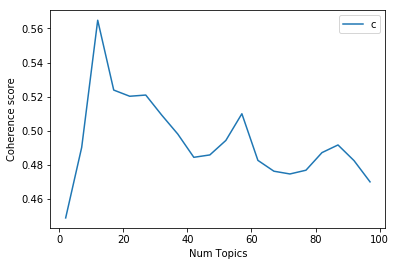

In [82]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_LDA, corpus=bow_corpus, texts=tokens, start=2, limit=100, step=5)
# Show graph
limit=100; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [83]:
coherence_values

[0.4489960920863726,
 0.4903179232291817,
 0.5648117069170581,
 0.523903304314873,
 0.5202762105047491,
 0.5209853320778416,
 0.5091944752261701,
 0.49811293360966175,
 0.48450352298773264,
 0.48589783044651325,
 0.49439206318990525,
 0.5100248141465891,
 0.4827111782637565,
 0.4763608843018164,
 0.47474787676142377,
 0.4769417342073886,
 0.48725570938067586,
 0.4917400618098766,
 0.4825698567178206,
 0.47011989689835154]

### 主題視覺化字詞分佈

In [96]:
%matplotlib inline

vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=bow_corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/home/winnie/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### mapping主題回原df

In [97]:
topic_results = list(lda_model.get_document_topics(bow_corpus, minimum_probability=None, minimum_phi_value=None, per_word_topics=False))

In [98]:
def takeSecond(elem):
    return elem[1]
sorted_result = []
for i in topic_results:
    sorted_i = sorted(i, key=takeSecond, reverse=True)
    sorted_result.append(sorted_i[:3])
result_df = pd.DataFrame([[y[0] for y in  x] for x in sorted_result], columns=['topic1', 'topic2', 'topic3'])
#final_result.reset_index(inplace=True)
cat_result = pd.concat([news, result_df], axis=1)

In [104]:
cat_result[cat_result['topic1'] == 3][['topic1','title', 'summary']][:100]

,topic1,title,summary
0,3,上次採訪還身陷生存危機，現已拚出千萬營收...6年社頭襪廠追蹤，看台灣頭家的突圍生存力,"2013年，商周第一次，也是至今唯一一次，把紀錄片推上戲院。因為一些約定，這紀錄片完整版鎖了5年，趁著這期封面故事＜襪子特攻隊10年突圍記＞推出，一併開放。\n說起來有點尷尬，6年前，我對黑狗兄印象最深刻的，竟然是他家廁所。\n沒錯，是廁所。當時同事寧寧正在彰化做田野調查，希望釐清台灣襪子產業在全球<a href=""http://www.businessweekly.com.tw/article.aspx?id=25692&type=Blog"">...詳全文</a><img width=""1"" alt="""" src=""http://feeds.feedburner.com/~r/bw-mix/~4/1Gc2VhfWqNc"" height=""1"">"
3,3,惜時如金，我卻耐心讀完這封行銷郵件！健身教練教我的一堂商業案例課,"產品是必要的，營銷是重要的\n我是一個惜時如金的人，我最貴的資源，就是時間。\n我要求自己，必須活成一隻瑞士鐘錶，自律、精密，享受規律帶來的樂趣。\n所以，在工作和生活中，一分一秒，都不願浪費。\n當然，我也不願意別人浪費我的時間。\n浪費時間無異於謀財害命，不論是自殺還是他殺，我都難以忍受。\n對<a href=""http://www.businessweekly.com.tw/article.aspx?id=25688&type=Blog"">...詳全文</a><img width=""1"" alt="""" src=""http://feeds.feedburner.com/~r/bw-mix/~4/oxaZbAWwY2Y"" height=""1"">"
13,3,客戶沒預算，也能成交上百萬訂單...多年企業公關經驗，觀察到的頂尖業務成交術,"從事企業公關工作多年，我常有採購媒體廣告或置入性報導的需求，接觸過不少媒體業務主管或專員；在談論工作之餘，我總是觀察這些業務人員的態度、應對、處事作法。\n雖然，過往很多優秀的業務前輩，都強調成功的業務員要能「聆聽客戶、滿足客戶需求」，但我發現，能成功從我手上做到生意的業務員，不只要能「聆聽客戶、滿<a href=""http://www.businessweekly.com.tw/article.aspx?id=25680&type=Blog"">...詳全文</a><img width=""1"" alt="""" src=""http://feeds.feedburner.com/~r/bw-mix/~4/1qQ580cpBcU"" height=""1"">"
14,3,開會時，你手機螢幕會朝上或朝下？不想影響工作專業度，戒掉5個容易犯的「手機病」,"「有一次我和一群男士打完高爾夫球後，在車上撥電話給太太，告訴她『現在打完球，要跟球友一起去吃飯』，但我忘了跟太太說自己開了擴音，誰知道電話那頭的她突然咆哮：『你這個死鬼，都不回來吃飯！』讓我當場陷入尷尬，也讓同車男士們異口同聲地說：擴音功能，還是少用為妙！」\n開擴音，務必告知對方\n這，是我的學員<a href=""http://www.businessweekly.com.tw/article.aspx?id=25684&type=Blog"">...詳全文</a><img width=""1"" alt="""" src=""http://feeds.feedburner.com/~r/bw-mix/~4/5DClZMvfMs0"" height=""1"">"
21,3,當顧客的「快樂販賣機」 車神娜娜年賣703輛車,"她一年賣掉703輛車子，但是客人上門，她最常談的不是車子，而是談狗、談小孩、談偶像藝人。\n陳茹芬演講所到之處，台下的人都稱她為車神，台灣汽車界的喬．吉拉德（Jo Girard）。\n被譽為世界上最偉大銷售員，創下金氏紀錄最會賣車的汽車業務員喬．吉拉德，15年銷售生涯共賣出1萬3000多輛；當時<a href=""http://magazine.businessweekly.com.tw/Article_mag_page.aspx?id=69357"">...詳全文</a><img width=""1"" alt="""" src=""http://feeds.feedburner.com/~r/bw-mix/~4/KBcIOwXwCWw"" height=""1"">"
30,3,當台灣抱怨薪資少...美國名校創近2萬個就業機會！矽谷大學如何孵出學生創業家？,"Apple、Google和Facebook有什麼共同之處？這些科技公司都是由大學生創立的。歷史上一些最成功的科技公司，是由大學生創立的。矽谷在舊金山灣區蓬勃發展的一個關鍵原因，是因為它靠近2所世界一流的研究型大學：加州大學柏克萊分校和史丹佛大學。 這2所大學發表了許多具前瞻性的研究、擁有鼓勵創新思想<a href=""http://www.businessweekly.com.tw/article.aspx?id=25673&type=Blog"">...詳全文</a><img width=""1"" alt="""" src=""http://feeds.feedburner.com/~r/bw-mix/~4/Lgd3wr7iZeg"" height=""1"">"
32,3,髮型、穿著、說話長度都要管！日本皇室一舉一動，背後都是「這群人」說了算,"2019年5月到了！日本冠上新年號「令和」的年代，將隨著新天皇的登基到來。但你可知道，3年前這件天皇「屆齡退休」的大事，不能大剌剌的直接宣布，而是「偷偷講」！\n時間回到2016年7月13日，日本NHK電視台以獨家新聞披露，「天皇陛下傳達了生前讓位給皇太子的意願。」才過了幾個小時，就被「宮內廳」，也<a href=""http://www.businessweekly.com.tw/article.aspx?id=25670&type=Blog"">...詳全文</a><img width=""1"" alt="""" src=""http://feeds.feedburner.com/~r/bw-mix/~4/2hK9HdYKtwU"" height=""1"">"
33,3,休息時間到，顧客上門也要說不！從美國酒廠員工身上，反思台灣的「配合文化」,"艾麗這次赴美出差主要任務為帶著公司VIP以及媒體參訪酒廠。老美生性熱情，做為酒廠門面的導覽員更是如此，總是非常熱烈地、巴不得把他們肚子裡的故事，一股腦兒的分享給參訪者。\n導覧員帶著艾麗等人一站站參觀，鉅細靡遺地解説對製酒的堅持與對品牌的驕傲。難得可以了解酒的整個製程，大家都聽得津津有味。\n正當大<a href=""http://www.businessweekly.com.tw/article.aspx?id=25668&type=Blog"">...詳全文</a><img width=""1"" alt="""" src=""http://feeds.feedburner.com/~r/bw-mix/~4/_n1JP2dj4L4"" height=""1"">"
34,3,千萬別再用amazing稱讚人...英文這些「極限形容詞」，為何說了卻讓對方感受扣分？,"常常會有外籍老師和我們分享教學經驗。其中一位外籍老師David說，他發現台灣人非常喜歡用amazing。看到老外用筷子吃飯，amazing；發現老外會說幾句中文，amazing；聽到老外已經來台灣好幾年了，amazing&amp;hellip;.。\n他問學生為什麼會這麼多amazing，學生說以為<a href=""http://www.businessweekly.com.tw/article.aspx?id=25669&type=Blog"">...詳全文</a><img width=""1"" alt="""" src=""http://feeds.feedburner.com/~r/bw-mix/~4/XkPrWKBE7WI"" height=""1"">"
37,3,人人喊買的好物件，竟差點毀掉婚姻...這對夫妻「第二次」看房啟示：新手買房一定要懂3件事,"晚上7點，手機那頭傳來房仲小黃的看房邀約，由於物件聽起來還不錯，所以原打算跟聊得差不多的朋友興凱說聲抱歉，沒想到他一聽是房仲的電話，興沖沖的表示，自己也要跟。\n回過神，我想起興凱最近要買房的需求，加上他也看了好一陣子，應該也算有點「眼光」。索性，就決定帶他一起去看屋。\n來到現場，正如同小黃電話裡<a href=""http://www.businessweekly.com.tw/article.aspx?id=25666&type=Blog"">...詳全文</a><img width=""1"" alt="""" src=""http://feeds.feedburner.com/~r/bw-mix/~4/aJY8WhAPt0Y"" height=""1"">"


### 文章測試

In [100]:
test = """你曾經羨慕別人跟到好老闆嗎？

如果你覺得為什麼別人都遇得到願意傾囊相授的好主管，自己卻總是懷才不遇，或許可以試著換個想法：別人的老闆之所以比較好、願意用心帶他，可能是他自己「賺」來的！

畢竟，老闆沒有義務提攜每一個人，別人被重用的機會，是靠自己爭取的。換句話說，之所以沒有被老闆看見、被重用、被提攜，不是老闆沒給自己機會，而可能是你自己放任機會溜走的。 要怎麼讓老闆願意教你、培養你、提攜你、給你成長的建議與訓練？關鍵就在於讓老闆知道：你已經準備好成長，你收得下建議，你不怕被要求，花時間心力培養你絕對是值得的投資。


而老闆是怎麼看出一個員工「值不值得培養」？其實從以下4個情境就可以看得出來：

情境一》當老闆穿著短褲拖鞋來上班，你會…
（A）原來我們公司是可以穿短褲拖鞋來上班的，我以後也要這麼穿。
（B）儘管老闆穿著休閒，我還是要依照公司的規範，穿出得體。
職場穿著首重得體，這不只是對工作的尊重，更代表你已經準備好迎接下一個挑戰。並且，當你穿著不得體，也意味著你不知道這個場合該穿什麼衣服才適合，缺乏「外表的IQ」，而在老闆眼中，漂不漂亮、帥不帥、身材好不好...都是其次，是否擁有「覺察場合需求的能力」才是更重要的。

我經常在演講中被問到：「老闆都穿得很休閒，為什麼我不可以跟老闆看齊？」然而，老闆是老闆，屬下是屬下，老闆穿著休閒，不代表屬下也可以不拘小節。有時候老闆之所以可以穿得休閒，正是因為他已經是老闆，他的專業已經眾所皆知，能力已經被認可，穿著就可以逐漸不受限於一般職場規範；而當你的專業能力尚未達到業內頂尖，卻穿得跟大家很不一樣。（不論是過於正式或過於不正式），就很容易被貼上「不長眼」的標籤了。

事實上，若屬下穿著得體有品味，看在穿著休閒的老闆眼中，是很有面子的！如果你的老闆不是你專業穿著的好榜樣，建議你以「行業中的成功人士80%是怎麼穿的」作為參考範本，千萬不要老闆穿短褲，你也跟著穿短褲。

情境二》當你想跟老闆培養感情，你會…
（A）盡可能跟老闆攀關係，甚至處理私人事務，因為只要關係好了，一切就會順暢了。
（B）先認真把公事做好，關係自然就會好。
要和老闆培養感情，與其攀關係，不如把事情好好完成、績效穩穩達標，讓他覺得你是一個成熟、可靠，可以交付工作、可以順暢溝通討論的人；而不是只會社交，卻沒有真本事的人。

此外，不管你跟老闆的關係有多好，也要永遠遵守老闆/員工之間的分際，尊重老闆的身分，特別是在外人面前。

我曾看過部屬在客戶面前直稱老闆的暱稱；或者在同事聊天之中，高談闊論老闆邀他到家裡作客的情形。其實大部分老闆面對這樣的情況是很尷尬的：部屬沒大沒小，讓他在客戶面前很沒面子，但又不便出口糾正；而當部屬在同事之前透露與自己個人私交，又擔心其他同事覺得自己大小眼，甚至有其他的揣測。

老闆的賞識得來不易，千萬不要因為一時的得意忘形，而讓老闆感覺被你消費了。

情境三》老闆請大家吃飯時，你會…
（A）跟同事互相推辭，想盡可能坐得離老闆愈遠愈好。
（B）主動坐到老闆旁邊，並且坐得很大方自然。
容易得到老闆青睞的員工還有一個特質：他們不怕接近老闆。

不論在正式會議或非正式的餐敘，都很常看到這樣的情形：大家推來推去，想坐得離老闆愈遠愈好，最後一個來的人只好去坐老闆旁邊，還被大家取笑：「誰叫你遲到，活該坐老闆旁邊。」

想像一下，如果你是老闆，聽到這樣的話做何感想？

權威感強的領導者經常遇到這樣的狀況：員工對領導者敬畏三分，不只遇到事情會盡可能地揣摩上意，試著大事化小、小事化無，而報告時也盡量報喜不報憂；平時更是盡可能地離老闆愈遠愈好。

然而，許多領導者告訴我，他們很欣賞那些不畏懼權威，能夠自然自在接近他們的員工。這包括會議時主動坐在旁邊，從容地一起搭電梯、搭車、用餐等。這並不代表你要去拍馬屁，而是面對老闆可以以不卑不亢的態度去應對，而從中也展現出你的落落大方。

情境四》當老闆給你批評建議，但你心中並不服氣，這時你會…
（A）當下挫折委屈全寫在臉上，之後將其建議當作耳邊風。
（B）儘管當下並不能欣然接受，仍虛心收下建議並實踐，之後再跟老闆回饋結果。
在我的「領袖魅力學」課程中，有許多領導者坦承：身為領導最大的成就感來源之一是，自己給的建議，員工確實地收到了，並且成長了！

因此，如果你的主管是出自真心給你建議，身為屬下的你也請將建議穩穩地接下來，並且真的去做。千萬不要因為主管批評你、建議你，而感到挫折、難過或憤怒，因為批評建議正是成長最好的養分！

想想看，如果你要去某個地方卻走錯了路，你是希望別人盡早跟你說走錯了，還是等到你已經出發好幾天了才告訴你方向錯誤？主管的提醒，就像路上的路標，讓你提早發現錯誤，趁還來得及的時候轉向，才能最有效率地往目標衝刺。即使一時沒辦法立刻接受，也請把反駁的念頭壓住，試著以主管的角度去了解他為什麼要這樣說，這也是訓練自己「觀全局」的大好機會。

而當你真的依照主管的建議做出改變，並且體會到自己的進步或有其他新的想法時，請不要吝嗇地告訴你的主管。因為，你的成長是主管重要的成就感來源，你的感謝，讓他能夠繼續給你回饋與建議，讓你進步的同時，也讓團隊往好的方向發展。

如果你經常覺得自己不得老闆的緣，埋怨老闆都不教你、不帶你，請記得：在原地抱怨是不會前進的。如果你因為未受賞識而三番兩次地換環境，但每次到了最後還是覺得懷才不遇，那麼幾乎可以確定：需要改變的是自己，否則同樣的情形還是會重複發生，只不過是換了一批人、換了一個空間而已！發現自己需要改變，是很好的祝福，因為當你有這樣的覺察，就是啟動蛻變的開始。希望這篇文章能成為你成長的助力！"""

In [101]:
test = my_cut(test)

['穿著', '建議', '成長', '培養', '休閒', '主管', '情境', '機會', '短褲', '屬下', '旁邊', '領導者', '別人', '試著', '提攜', '專業', '告訴', '改變', '同事', '懷才', '老闆', '自己', '可以', '因為', '一個', '你的', '如果你', '員工']


In [102]:
result = lda_model[dictionary_LDA.doc2bow(list(test))]

In [105]:
#mapping回pyLDAvis的圖 3＝圖裡的4 ==> 滿準的！！
resultd

[(0, 0.09006238), (3, 0.79213303), (6, 0.0139795225), (13, 0.062804386)]

## 問題

In [ ]:
"""
1. 文章內容看起來應該不只有兩種分類，是否可拿到文章類別標籤=> 可以用別種模型

2. 文章斷詞取法？

"""